<a href="https://colab.research.google.com/github/907Resident/caldera-gases/blob/main/site_differentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Site Differentation
How are the sites similar and/or different?

The diffuse gas measurements collected at both calderas highlight spatial trends at the caldera scale and provide an avenue of insight that differs from the previously published point source emission studies. Furthermore, these data will be compared against previous diffuse CO$_{2}$ fluix and carbon isotope measurements and introduce novel diffuse CH$_{4}$ data as well. 

## Import necessary libraries

Import the needed generic libraries

In [1]:
# Import KS test for normality from statsmodels
from statsmodels.stats.diagnostic import kstest_normal
# Import the KW test from scipy
from scipy.stats import kruskal

# Import FK test for unequal variance from `scipy` module
from scipy.stats import fligner, ks_2samp, wilcoxon
from scipy import stats

# Import notebook aid packages
from IPython.core.pylabtools import figsize
from natsort import index_natsorted

# Import packages needed for connecting to google drive
from google.colab import drive

# Import fundamental packages
from matplotlib import cm

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

# Import axis formatting package
import matplotlib.ticker as ticker

# Import other essential python packages
import matplotlib
import zipfile
import fnmatch
import h5py
import time
import glob
import re
import os

Install the non-generic libraries through `pip` and then import.

In [2]:
# Install janitor for cleaning up dataframes
!pip install pyjanitor==0.21.2

# Install joypy for ridgeplots
!pip install joypy

# Install post-hoc tests from scikit
!pip install scikit-posthocs

# Install probscale package from PyPi
!pip install probscale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 7.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.2/434.2 KB 14.1 MB/s eta 0:00:00


In [3]:
from scikit_posthocs import posthoc_conover as conover
from janitor import clean_names, rename_columns
from joypy import joyplot

import probscale

Establish the basics for visualizations. Through the `plt.style.available`, all of the styles available for creating the plots. More information on plotting styles can be found [here](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html). 

In [4]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In this case, we will use a version of `seaborn-paper` so that the figures will be presentable for a written documnent.

In [5]:
# Establish plot paramters
custom_params = {
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "xtick.labelsize":16,
    "ytick.labelsize":16,
    "font.size": 18,
    "grid.alpha": 0.25,
    "legend.title_fontsize": 16,
    "legend.fontsize": 15
}

# plt.style.use(['seaborn-paper'])
sns.set_theme(
    style="whitegrid",
    context="paper",
    rc=custom_params
)

Establish colors for plots

| Color        | Caldera            | Gas                | Hex Code |   
| ----         | -----              | ---                | -------  |
| Dark Blue    | YC                 | CH<sub>4</sub>     | #66b3ff  |
| Light Blue   | VC                 | CH<sub>4</sub>     | #b3daff  |
| Dark Magenta | YC                 | CO<sub>2</sub>     | #d966ff  |
| Light Magenta| VC                 | CO<sub>2</sub>     | #ffb3ff  |
| Black        | East YC / North VC | Both gases         | #ffffff  |
| Gray         | West YC / South VC | Both gases         | #737373  |
| Goldenrod    | YC                 | Both gases         | #ffe51c  |
| Light Pink   | VC                 | Both gases         | #f5dae3  |


In [6]:
# Establish the color for CH4 (blue) and CO2 (magenta) with hexdecimal codes

# YC and VC colors 
CH4_color1 = "#66b3ff"
CO2_color1 = "#d966ff"
CH4_color2 = "#b3daff"
CO2_color2 = "#f59cff"
# East-North caldera side YC-VC
caldera_side_color_en = "#488485"
# West-South caldera side YC-VC
caldera_side_color_ws = "#00f8fc"
# Yellowstone
yc_color = "#ffe51c"
# Valles
vc_color = "#f5dae3"


Lists of markers for scatterplots

In [7]:
markers_4 = ["^", "o", "*", "*"]
markers_8 = ["^", "o", "*", "*", "D", "+", "8", "X"]

Set the format for date tick labels for all plots

In [8]:
# set the datetime format
_datetick_format = mdates.DateFormatter("%Y-%m-%d %H:%M")

## Import Data

### Mount Google Drive

In [9]:
# Connect to Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
# Point directory to correct place
%cd /content/gdrive/My Drive/Colab Notebooks/caldera-gases/src/notebooks

/content/gdrive/My Drive/Colab Notebooks/caldera-gases/src/notebooks


### Understand the Directory

The notebook(s) attached to this project will be located within the `src/notebooks` directory. To help users understand the relative paths used in this project, the image below shows the folders affiliated with `caldera-gases`:

In [11]:
!sudo apt install tree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (694 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: 

In [12]:
!tree ../../ -I tokenizers -d

../../
├── azure
│   ├── azure-app
│   └── graph_tutorial
│       ├── graph_tutorial
│       │   └── __pycache__
│       └── tutorial
│           ├── migrations
│           │   └── __pycache__
│           ├── __pycache__
│           ├── static
│           │   └── tutorial
│           └── templates
│               └── tutorial
├── docs
├── figures
├── misc
├── pertinent-data
│   ├── calibration-data
│   │   ├── 20180404-dat
│   │   ├── 20180412-dat
│   │   ├── 20180420-dat
│   │   └── 20190523-h5
│   │       └── Picarro
│   │           └── G2000
│   │               └── Log
│   │                   └── DataLogger
│   │                       └── DataLog_Private
│   ├── egm-data
│   ├── inferential-stats-output
│   │   ├── valles
│   │   └── yellowstone
│   ├── mat-files
│   ├── other-data
│   └── summary-data
├── regression
│   ├── egm-regression
│   └── point-source-diffuse-regression
└── src
    ├── MATLAB-functions
    └── notebooks

40 directories


### Programmatically Upload Summary Data
Assuming the files are up to date, they can be uploaded into the workspace programmatically

#### Google Drive |  Yellowstone - Programmatically Import Data

In [13]:
# Upload Yellowstone Summary Data
df_2018_YC = pd.read_excel(
    "../../pertinent-data/summary-data/YNP_SummaryData.xlsx", 
    sheet_name="2018",
    header=0, 
    parse_dates=True
  )
# Delete first row that contains secondary data information
df_2018_YC.drop([0], inplace=True)

# Reset index
df_2018_YC.reset_index(drop=True, inplace=True)

In [14]:
# Upload Yellowstone Summary Data
df_2019_YC = pd.read_excel(
    "../../pertinent-data/summary-data/YNP_SummaryData.xlsx", 
    sheet_name="2019",
    header=0, 
    parse_dates=True
  )
# Delete first row that contains secondary data information
df_2019_YC.drop([0], inplace=True)

# Reset index
df_2019_YC.reset_index(drop=True, inplace=True)

#### Google Drive |  Valles Caldera - Programmatically Import data

In [15]:
# Import file into workspace
df_2017_VC = pd.read_excel(
    "../../pertinent-data/summary-data/VC_SummaryData.xlsx",
    sheet_name="2017",
    header=0, 
    parse_dates=True
  )
# Delete first row that contains secondary data information
df_2017_VC.drop([0], inplace=True)

# Reset index
df_2017_VC.reset_index(drop=True, inplace=True)

In [16]:
# Import file into workspace
df_2019_VC = pd.read_excel(
    "../../pertinent-data/summary-data/VC_SummaryData.xlsx",
    sheet_name="2019",
    header=0
  )

# Change the soil chemistry classification of Hummingbird to acid-sulfate
df_2019_VC.loc[df_2019_VC.Group=="Hummingbird", "Soil_Classification"] = "Acid-Sulphate" 

# Delete first row that contains secondary data information
df_2019_VC.drop([0], inplace=True)

# Reset index
df_2019_VC.reset_index(drop=True, inplace=True)

### Manually upload files
If changes have been made to the summary workbooks, **upload them to Google Drive and the workspace manually instead of using the "Programmatically Upload" section**.

>If programatic upload is working properly, skip and _do not_ execute the cells in this section.


#### Google Drive |  Yellowstone - Manual Import data

In [ ]:
# Manual File Upload from local drive
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
# Import file into workspace
import io
df_2018_YC = pd.read_excel(io.BytesIO(uploaded['YNP_SummaryData.xlsx']), 
                           sheet_name="2018",
                           header=0, parse_dates=True)
# Delete first row that contains secondary data information
df_2018_YC.drop([0], inplace=True)

# Reset index
df_2018_YC.reset_index(drop=True, inplace=True)

In [ ]:
# Import file into workspace
df_2019_YC = pd.read_excel(io.BytesIO(uploaded['YNP_SummaryData.xlsx']), 
                           sheet_name="2019",
                           header=0)
# Delete first row that contains secondary data information
df_2019_YC.drop([0], inplace=True)

# Reset index
df_2019_YC.reset_index(drop=True, inplace=True)

#### Google Drive | Valles Caldera - Import Data
The data has been processed in the same way for Yellowstone.

In [ ]:
# Manual File Upload from local drive
uploaded = files.upload()

In [ ]:
# Import file into workspace
df_2017_VC = pd.read_excel(io.BytesIO(uploaded['VC_SummaryData.xlsx']), 
                           sheet_name="2017",
                           header=0, parse_dates=True)
# Delete first row that contains secondary data information
df_2017_VC.drop([0], inplace=True)

# Reset index
df_2017_VC.reset_index(drop=True, inplace=True)

In [ ]:
# Import file into workspace
df_2019_VC = pd.read_excel(io.BytesIO(uploaded['VC_SummaryData.xlsx']), 
                           sheet_name="2019",
                           header=0)
# Delete first row that contains secondary data information
df_2019_VC.drop([0], inplace=True)

# Reset index
df_2019_VC.reset_index(drop=True, inplace=True)

### Customized Utilities

This subsection contains functions, classes, and other customized code that builds more efficiency in the notebook.

#### Utility Classes

In [17]:
# define Python user-defined exceptions
class Error(Exception):
  """Base class for other exceptions"""
  pass

class NotADataFrame(Error):
  """Raised when the value is not a dataframe."""
  pass

class NotAColumn(Error):
  """A column requested from the dataframe does not exist."""

#### Utility Functions

In [18]:
def basic_preprocessing(df):
  # Set dictionary for correct data types
  data_types = {
      "Group":"category",
      "Location":"object",
      "Soil_Classification":"category",
      "Latitude":"float64","Longitude":"float64",
      "Date_of_Measurement":"datetime64",
      "Start_Time_of_Chamber_Enclosure":"datetime64",
      "End_Time_of_Chamber_Enclosure":"datetime64",
      "Duration_of_Total_Chamber_Enclosure":"float64",
      "Start_Time_Flux":"datetime64",
      "End_Time_Flux":"datetime64",              
      "CH4_Flux":"float64",
      "LowerBound_CH4_Flux":"float64",
      "UpperBound_CH4_Flux":"float64",
      "KP_d13CH4_source":"float64",
      "KP_LowerBound_d13CH4_source":"float64",
      "KP_UpperBound_d13CH4_source":"float64",
      "d13CH4_source":"float64", 
      "d13CH4_LowerBound_source":"float64",
      "d13CH4_UpperBound_source":"float64",
      "CO2_Flux":"float64",
      "LowerBound_CO2_Flux":"float64",
      "UpperBound_CO2_Flux":"float64",
      "d13CO2_source":"float64",
      "KP_d13CO2_source":"float64",
      "KP_LowerBound_d13CO2_source":"float64",
      "KP_UpperBound_d13CO2_source":"float64",
      "d13CO2_source":"float64",
      "d13CO2_LowerBound_source":"float64",
      "d13CO2_UpperBound_source":"float64",
      "Horita_Geothermometer_Temperature_at_Formation":"float64",
      "Ambient_Temperature":"float64",
      "Barometric_Pressure":"float64",
      "Soil_Tempeature_at_Surface":"float64"
    }
  # Set data types accordingly
  df = df.astype(data_types)
  # Drop unnecessary columns
  df.drop(df.columns[30:33], axis=1, inplace=True)
  df.drop(df.columns[-1], axis=1, inplace=True)

  # Return data frame
  return df

In [19]:
# Quantify the number of measurements lost due to removing fluxes less than zero
def perc_diff(val1, val2):
  '''
  Using the number of rows from the original concatenated dataframe and the 
  trimmed dataframe, quantify the percent difference between the number of 
  rows lost
  ''' 
  diff = val1 - val2
  diff = np.absolute(diff)
  sum_val = val1 + val2
  perc_diff = (diff / (sum_val / 2)) * 100
  
  return perc_diff

In [20]:
# Function to fit and assess parameters of distributions against observed data
def assess_fit_params(data):
  '''
  This function quantifies and ranks the best distribution to fit the input,
  data. It examines several distributions (see 'list_of_dists') and fits them to
  the data to estimate the parameters using the maximum likelihood estimate 
  (MLE) algorithm. After the parameters have been approximated, a
  Kolmogorov-Smirnov (KS) test is employed to measure which of the 
  distributions had the lowest test statistic. The user must check that the 
  p-value is appropriate as well.

  INPUT: `data` is a 1-D series or array
  OUTPUT: `df` is a 9x3 dataframe that contains results from fit and KS test
  '''
  # Import stats package from scipy
  # Establish list of distributions to be tested against observed data
  list_of_dists = ["beta", "burr12", "chi2", "expon","fisk", "gamma",
                   "genlogistic","genpareto", "genexpon", "genextreme",
                   "invgamma", "loggamma", "lognorm", "maxwell",  "norm", 
                   "pareto","pearson3", "powerlaw", "rayleigh", "t", "vonmises",
                   "weibull_min"]
  # Establish an empty array to hold MLE parameters
  mle_param_estimates = []  
  # Loop through list of distributions to get MLE parameter estimates
  for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(data)
    a = stats.kstest(data, i, args=param)
    mle_param_estimates.append((i,a[0],list(param),a[1]))
  # Sort results by p-value
  mle_param_estimates.sort(key=lambda x:float(x[3]), reverse=True)
  # Organize results into dataframe
  df = pd.DataFrame(
      mle_param_estimates,
      columns=[
          "distribution", 
          "statistic", 
          "params",
          "p_value"
        ]
    )
  df = df.sort_values(by="p_value", ascending=False)
  # Return results
  return df

In [21]:
def plot_theoretical_dist(
    data, 
    # params, 
    dist_name="norm", 
    n_bins=20
):

  sz = len(data)
  h = plt.hist(data, bins=range(n_bins))

  dist = getattr(stats, dist_name)
  params = dist.fit(data)
  arg = params[:-2]
  loc = params[-2]
  scale = params[-1]
  if arg:
      pdf_fitted = dist.pdf(data, *arg, loc=loc, scale=scale) #* sz
  else:
      pdf_fitted = dist.pdf(data, loc=loc, scale=scale) #* sz
  plt.plot(pdf_fitted, label=dist_name)
    
  plt.xlim(0,np.max(data))
  plt.legend(loc="upper right")
  plt.show()

In [22]:
def group_egm_data(egm_df, caldera="YNP"):

  # Yellowstone
  if (re.search("YNP", caldera, re.IGNORECASE)) or (re.search("Yellowstone", caldera, re.IGNORECASE)):
    if "Site" in egm_df.columns:

      egm_df["Group"] = pd.Series(index=range(len(egm_df)))

      # convert this loop into a function using _group as an argument
      for i in range(len(egm_df)):

        _site = egm_df["Site"].iloc[i]

        # upper gb
        if (_site == "CSTL") or (_site == "GRND") or (_site == "DISY"):
          egm_df["Group"].iloc[i] = "Upper GB"
        # lower gb
        elif (_site == "CLPD") or (_site == "GFTN"):
          egm_df["Group"].iloc[i] = "Lower GB"
        # terrace springs
        elif (_site == "GBSN"):
          egm_df["Group"].iloc[i] = "Terrace Springs"
        # norris gb
        elif (_site == "NGBN"):
          egm_df["Group"].iloc[i] = "Norris GB"
        # north of norris
        elif (_site == "PRCN"):
          egm_df["Group"].iloc[i] = "North of Norris GB"
        # mammoth hot springs
        elif (_site == "MMTH"):
          egm_df["Group"].iloc[i] = "Mammoth HS"
        # west thumb gb
        elif (_site == "WTHB"):
          egm_df["Group"].iloc[i] = "West Thumb GB"
        # gas vents
        elif (_site == "GVNT"):
          egm_df["Group"].iloc[i] = "Gas Vents (Solfatara Springs)"
        # mud volcano
        elif (_site == "MDVC"):
          egm_df["Group"].iloc[i] = "Mud Volcano"
        # eastern yellowstone
        elif (_site == "EETR") or (_site == "NEER") or (_site == "YSLK"):
          egm_df["Group"].iloc[i] = "Eastern Yellowstone"

      # ensure the groups will be in west to east order
      ordered_groups_egm_YC = [
          "Upper GB", 
          "Lower GB", 
          "Terrace Springs",
          "Norris GB", 
          # "North of Norris GB",
          "Mammoth HS",
          "West Thumb GB",
          "Gas Vents (Solfatara Springs)",
          "Mud Volcano", 
          "Eastern Yellowstone"
      ]

      # convert to categories and order appropriately
      egm_df["Group"] = egm_df["Group"].astype("category")
      egm_df["Group"].cat.reorder_categories(
          ordered_groups_egm_YC, 
          ordered=True,
          inplace=True
      )

    else:
      print(
          "A column named 'Site' could not be found within the dataframe submitted to this function."
      )
  # Valles
  elif (re.search("VCNP", caldera, re.IGNORECASE)) or (re.search("Valles", caldera, re.IGNORECASE)):
    if "Site" in egm_df.columns:

      egm_df["Group"] = pd.Series(index=range(len(egm_df)))

      # convert this loop into a function using _group as an argument
      for i in range(len(egm_df)):

        _site = egm_df["Site"].iloc[i]

        # sulphur springs
        if (_site == "VCSS"):
          egm_df["Group"].iloc[i] = "Sulphur Springs"
        # hummingbird
        elif (_site == "VCHB"):
          egm_df["Group"].iloc[i] = "Hummingbird"
        # alamo canyon
        elif (_site == "VCAC"):
          egm_df["Group"].iloc[i] = "Alamo Canyon"

      # ensure the groups will be in north to south order
      ordered_groups_egm_VC = [
          "Alamo Canyon", 
          "Sulphur Springs", 
          # "Redondo Peak",
          "Hummingbird", 
          # "Soda Dam"
        ]

      # convert to categories and order appropriately
      egm_df["Group"] = egm_df["Group"].astype("category")
      egm_df["Group"].cat.reorder_categories(
          ordered_groups_egm_VC, 
          ordered=True,
          inplace=True
      )

    else:
      print(
          "A column named 'Site' could not be found within the dataframe submitted to this function."
      )
  # no appropriate caldera was selected in the original argument
  else:
    print("Please select an appropriate caldera.")

  return egm_df

In [23]:
# Compare egm data and crds data using the non-parametric kruskal-wallis test
def egm_crds_kw_test(egm_df, crds_df):

  # assert to ensure the dataframes have been formatted properly and contain the pertinent information
  egm_df_bool = isinstance(egm_df, pd.DataFrame)
  crds_df_bool = isinstance(crds_df, pd.DataFrame)
  if (not egm_df_bool) or (not crds_df_bool):
    raise NotADataFrame

  if ("Group" not in egm_df):
    print("EGM DataFrame is missing column, 'Group'")
    raise NotAColumn
  elif ("Group" not in crds_df):
    print("CRDS DataFrame is missing column, 'Group'")
    raise NotAColumn

  # get the lists of the groups and make sure they match
  egm_grp_lst = egm_df.Group.unique().tolist()
  crds_grp_lst = crds_df.Group.unique().tolist()

  # get intersection items in two lists
  all_grp_lst = list(set(egm_grp_lst) & set(crds_grp_lst))

  for _group in all_grp_lst:
    # extract data and execute kw test
    egm = egm_df[egm_df["Group"] == _group]["fCO2"]
    crds= crds_df[crds_df["Group"] == _group]["CO2_Flux"]
    # conduct ks test

    # conduct fk test

    # conduct kw test

    # conover-imam test



  egm = df_egm_all[df_egm_all["Group"] == "Eastern Yellowstone"]["fCO2"].to_list()

  crds = df_all[df_all["Group"] == "Eastern Yellowstone"]["CO2_Flux"].to_list()
  

In [24]:
# Function to add "n= ##" to horizontal boxplots
## Does not work quite right yet [31 Mar 2021]
def add_nobvs_hboxplt(df, group, metric, palatte):
  fig, ax = plt.subplots(figsize = (10, 8))
  ax = sns.boxplot(y=group, x=metric, hue="Caldera", data=df_all,
                   palette=palatte)
  ax.set_xlim(-150,)
  medians = df.groupby([group])[metric].min().values-60
  nobs = df[metric].value_counts().values
  nobs = [str(x) for x in nobs.tolist()]
  nobs = ["n= " + i for i in nobs] 
  pos = range(len(nobs))
  for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(medians[tick], tick, nobs[tick], size="x-small",
            color='black', verticalalignment = "bottom",
            horizontalalignment="center", rotation=0)
  return ax

## Preprocessing and cleaning
Several cleaning steps are requireed to ensure correct data types, addressing missing data, and other cleaning activities.

In [25]:
# Assess the data types for the dataframe
df_2018_YC.dtypes

Site_Name                                         object
Group                                             object
Location                                          object
Soil_Classification                               object
Latitude                                          object
Longitude                                         object
Date_of_Measurement                               object
Start_Time_of_Chamber_Enclosure                   object
End_Time_of_Chamber_Enclosure                     object
Duration_of_Total_Chamber_Enclosure               object
Start_Time_Flux                                   object
End_Time_Flux                                     object
CH4_Flux                                          object
LowerBound_CH4_Flux                               object
UpperBound_CH4_Flux                               object
KP_d13CH4_source                                  object
KP_LowerBound_d13CH4_source                       object
KP_UpperBound_d13CH4_source    

From visual inspection of the data types, it appears that all columns have been set to `object`. Therefore, it will require a dictionary where, I have mannually set up.

Execute `basic_preprocessing()` to assign the correct data types and get rid of unncessary columns.

In [26]:
# Yellowstone
## 2018
df_2018_YC = basic_preprocessing(df_2018_YC)
## 2019
df_2019_YC = basic_preprocessing(df_2019_YC)

# Valles Caldera
## 2017
df_2017_VC = basic_preprocessing(df_2017_VC)
## 2019
df_2019_VC = basic_preprocessing(df_2019_VC)

In [27]:
# Map Categorical Label for West and East for Yellowstone
mask_west_2018 = (df_2018_YC.Group == "Upper GB") | (df_2018_YC.Group == "Lower GB") | (df_2018_YC.Group == "Terrace Springs") | (df_2018_YC.Group == "Norris GB") | (df_2018_YC.Group == "North of Norris GB") | (df_2018_YC.Group == "Mammoth HS") | (df_2018_YC.Group == "West Thumb GB")
mask_west_2019 = (df_2019_YC.Group == "Upper GB") | (df_2019_YC.Group == "Lower GB") | (df_2019_YC.Group == "Terrace Springs") | (df_2019_YC.Group == "Norris GB") | (df_2019_YC.Group == "Mammoth HS")         | (df_2019_YC.Group == "West Thumb GB")
df_2018_YC["caldera_side"] = pd.Categorical(np.where(mask_west_2018, "west", "east"))
df_2019_YC["caldera_side"] = pd.Categorical(np.where(mask_west_2019, "west", "east"))

In [28]:
# Map Categorical Label for North and South for Valles
mask_north_2017 = (df_2017_VC.Group == "Alamo Canyon") | (df_2017_VC.Group == "Sulphur Springs") | (df_2017_VC.Group == "Redondo Peak") 
mask_north_2019 = (df_2019_VC.Group == "Alamo Canyon") | (df_2019_VC.Group == "Sulphur Springs") | (df_2019_VC.Group == "Redondo Peak")
df_2017_VC["caldera_side"] = pd.Categorical(np.where(mask_north_2017, "north", "south"))
df_2019_VC["caldera_side"] = pd.Categorical(np.where(mask_north_2019, "north", "south"))

Concatenate the dataframes from each respective campaign together chronologically. After this process there will be two dataframes, one for Yellowstone and the other for Valles.

In [29]:
# Concatenate 2018 & 2019 dataframes for Yellowstone
df_YC_all = pd.concat([df_2018_YC, df_2019_YC], ignore_index=True)

# Preview dataframe dimensions
YNP_all_shape = df_YC_all.shape
print(YNP_all_shape)

(154, 32)


In [30]:
# Concatenate 2017 & 2019 dataframes for Valles Caldera
df_VC_all = pd.concat([df_2017_VC, df_2019_VC], ignore_index=True)

# Preview dataframe dimensions
VCNP_all_shape = df_VC_all.shape
print(VCNP_all_shape)

(48, 32)


The groups need to be ordered to represent the geography. For Yellowstone, the groups are ordered from west to east, and for Valles, the groups are ordered from north to south.

In [31]:
# List the categories ordered from west to east for Yellowstone
ordered_groups_YC = ["Upper GB", "Lower GB", "Terrace Springs",
                     "Norris GB", "North of Norris GB",
                     "Mammoth HS","West Thumb GB",
                     "Gas Vents (Solfatara Springs)",
                     "Mud Volcano", "Eastern Yellowstone"]
# Create a list to order the sides of the caldera from west to east                     
ordered_sides_YC = ["west", "east"]

# Order the groups from west to east
df_YC_all["Group"] = df_YC_all["Group"].astype("category")
df_YC_all["Group"].cat.reorder_categories(
    ordered_groups_YC, 
    ordered=True,
    inplace=True
  )

# Order the sides of the caldera
df_YC_all["caldera_side"] = df_YC_all["caldera_side"].astype("category")
df_YC_all["caldera_side"].cat.reorder_categories(
    ordered_sides_YC,
    ordered=True,
    inplace=True
  )

<ipython-input-31-d3c02416d1e9>:12: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_YC_all["Group"].cat.reorder_categories(
<ipython-input-31-d3c02416d1e9>:20: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_YC_all["caldera_side"].cat.reorder_categories(


Preview the the number of non-null values and data types asscociated with the columns of data in the Yellowstone dataframe.

In [32]:
df_YC_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Site_Name                            154 non-null    object        
 1   Group                                154 non-null    category      
 2   Location                             154 non-null    object        
 3   Soil_Classification                  154 non-null    object        
 4   Latitude                             153 non-null    float64       
 5   Longitude                            153 non-null    float64       
 6   Date_of_Measurement                  154 non-null    datetime64[ns]
 7   Start_Time_of_Chamber_Enclosure      154 non-null    datetime64[ns]
 8   End_Time_of_Chamber_Enclosure        154 non-null    datetime64[ns]
 9   Duration_of_Total_Chamber_Enclosure  154 non-null    float64       
 10  Start_Time_Flu

In [33]:
# List the categories ordered from north to south at Valles Caldera
ordered_groups_VC = ["Alamo Canyon", "Sulphur Springs", "Redondo Peak",
                     "Hummingbird", "Soda Dam"]
# Order the groups from north to south
df_VC_all["Group"] = df_VC_all["Group"].astype("category")
df_VC_all["Group"].cat.reorder_categories(ordered_groups_VC, ordered=True,
                                          inplace=True)

<ipython-input-33-52b77410d1c2>:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_VC_all["Group"].cat.reorder_categories(ordered_groups_VC, ordered=True,


Preview the the number of non-null values and data types asscociated with the columns of data in the Valles dataframe.

In [34]:
df_VC_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Site_Name                            48 non-null     object        
 1   Group                                48 non-null     category      
 2   Location                             48 non-null     object        
 3   Soil_Classification                  48 non-null     object        
 4   Latitude                             48 non-null     float64       
 5   Longitude                            48 non-null     float64       
 6   Date_of_Measurement                  48 non-null     datetime64[ns]
 7   Start_Time_of_Chamber_Enclosure      47 non-null     datetime64[ns]
 8   End_Time_of_Chamber_Enclosure        47 non-null     datetime64[ns]
 9   Duration_of_Total_Chamber_Enclosure  47 non-null     float64       
 10  Start_Time_Flux 

Add a category _Caldera_ that will be useful when combining data from both locations


In [35]:
# Yellowstone
df_YC_all["Caldera"] = "YNP"
df_YC_all["Caldera"] = df_YC_all["Caldera"].astype("category")
# Valles
df_VC_all["Caldera"] = "VCNP"
df_VC_all["Caldera"] = df_VC_all["Caldera"].astype("category")

Change the units for fluxes are presented in mg CH<sub>4</sub> m<sup>-2</sup> day<sup>-1</sup> and g CO<sub>2</sub>  m<sup>-2</sup> day<sup>-1</sup>.

In [36]:
# Convert Fluxes to mass m-2 per day
## F_CH4: mg m-2 day-1
df_YC_all["CH4_Flux"] = df_YC_all.CH4_Flux * 24
df_YC_all["LowerBound_CH4_Flux"] = df_YC_all.LowerBound_CH4_Flux * 24
df_YC_all["UpperBound_CH4_Flux"] = df_YC_all.UpperBound_CH4_Flux * 24
## F_CO2: g m-2 day-1
df_YC_all["CO2_Flux"] = (df_YC_all.CO2_Flux / 1000) * 24
df_YC_all["LowerBound_CO2_Flux"] = (df_YC_all.LowerBound_CO2_Flux / 1000) * 24
df_YC_all["UpperBound_CO2_Flux"] = (df_YC_all.UpperBound_CO2_Flux / 1000) * 24

In [37]:
# Convert Fluxes to mass m-2 per day
## F_CH4: mg m-2 day-1
df_VC_all["CH4_Flux"] = df_VC_all.CH4_Flux * 24
df_VC_all["LowerBound_CH4_Flux"] = df_VC_all.LowerBound_CH4_Flux * 24
df_VC_all["UpperBound_CH4_Flux"] = df_VC_all.UpperBound_CH4_Flux * 24
## F_CO2: g m-2 day-1
df_VC_all["CO2_Flux"] = (df_VC_all.CO2_Flux / 1000) * 24
df_VC_all["LowerBound_CO2_Flux"] = (df_VC_all.LowerBound_CO2_Flux / 1000) * 24
df_VC_all["UpperBound_CO2_Flux"] = (df_VC_all.UpperBound_CO2_Flux / 1000) * 24

This is a statement plot to highlight the median value for each side of the Yellowstone caldera.

In [38]:
# Groupby caldera side and find the median of the fluxes by caldera side
## yellowstone
caldera_side_yc_ch4_median = df_YC_all.groupby(by=["caldera_side"])["CH4_Flux"].agg(np.nanmedian)
caldera_side_yc_co2_median = df_YC_all.groupby(by=["caldera_side"])["CO2_Flux"].agg(np.nanmedian)

## easy to read print statments
### CH4
print(
    "The median CH4 flux value for the western part of Yellowstone is {:.4f} mg CH4 m-2 day-1\nThe median CH4 flux value for the eastern part of Yellowstone is {:.4f} mg CH4 m-2 day-1".format(
        caldera_side_yc_ch4_median[0],
        caldera_side_yc_ch4_median[1]
    )
)
### CO2
print(
    "The median CO2 flux value for the western part of Yellowstone is {:.4f} g CO2 m-2 day-1\nThe median CO2 flux value for the eastern part of Yellowstone is {:.4f} g CO2 m-2 day-1".format(
        caldera_side_yc_co2_median[0],
        caldera_side_yc_co2_median[1]
    )
)

The median CH4 flux value for the western part of Yellowstone is -0.5235 mg CH4 m-2 day-1
The median CH4 flux value for the eastern part of Yellowstone is 7.4314 mg CH4 m-2 day-1
The median CO2 flux value for the western part of Yellowstone is 3.5249 g CO2 m-2 day-1
The median CO2 flux value for the eastern part of Yellowstone is 98.8721 g CO2 m-2 day-1


This is a grouped statement to highlight the median value for each side of Valles Caldera.

In [39]:
# Groupby caldera side and find the median of the fluxes by caldera side
## valles
caldera_side_vc_ch4_median = df_VC_all.groupby(by=["caldera_side"])["CH4_Flux"].agg(np.nanmedian)
caldera_side_vc_co2_median = df_VC_all.groupby(by=["caldera_side"])["CO2_Flux"].agg(np.nanmedian)

## easy to read print statments
### CH4
print(
    "The median CH4 flux value for the northern part of Valles is {:.4f} mg CH4 m-2 day-1\nThe median CH4 flux value for the southern part of Valles is {:.4f} mg CH4 m-2 day-1".format(
        caldera_side_vc_ch4_median[0],
        caldera_side_vc_ch4_median[1]
    )
)
### CO2
print(
    "The median CO2 flux value for the northern part of Valles is {:.4f} g CO2 m-2 day-1\nThe median CO2 flux value for the southern part of Valles is {:.4f} g CO2 m-2 day-1".format(
        caldera_side_vc_co2_median[0],
        caldera_side_vc_co2_median[1]
    )
)

The median CH4 flux value for the northern part of Valles is 18.1259 mg CH4 m-2 day-1
The median CH4 flux value for the southern part of Valles is 111.9105 mg CH4 m-2 day-1
The median CO2 flux value for the northern part of Valles is 230.9736 g CO2 m-2 day-1
The median CO2 flux value for the southern part of Valles is 275.1822 g CO2 m-2 day-1


Merge the Yellowstone and Valles daataframes together on the start time of chamber enclosure

In [40]:
# Merge data from both calderas together
df_all = pd.concat([df_YC_all, df_VC_all], ignore_index=True)
df_all.sort_values(by=["Start_Time_of_Chamber_Enclosure"],
                   key=lambda x: np.argsort(index_natsorted(df_all["Date_of_Measurement"])),
                   inplace=True)
# Reset index
df_all.reset_index(drop=True, inplace=True)
df_all.shape

(202, 33)

In [41]:
# Order "Group" by Yellowstone first and then Valles
ordered_groups_all = ordered_groups_YC + ordered_groups_VC
df_all["Group"] = df_all["Group"].astype("category")
df_all["Group"].cat.reorder_categories(ordered_groups_all, ordered=True,
                                       inplace=True)
# Order "Caldera" by Yellowstone and then Valles
df_all["Caldera"] = df_all["Caldera"].astype("category")
df_all["Caldera"].cat.reorder_categories(["YNP", "VCNP"], ordered=True,
                                         inplace=True)

<ipython-input-41-7ba5b185eed2>:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_all["Group"].cat.reorder_categories(ordered_groups_all, ordered=True,
<ipython-input-41-7ba5b185eed2>:8: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_all["Caldera"].cat.reorder_categories(["YNP", "VCNP"], ordered=True,


### Load Werner and Brantley (2003) Data into Workspace

After contacting Drs. Werner and Brantley directly via email (circa July 2022), we obtained a `.xlsx` file that contains the data recorded in their paper. Here, we load it in the worksapce to be manipulated later in the notebook.

In [42]:
from pandas.core.arrays.categorical import Categorical
# Load Werner and Brantley Data
df_wb_2003 = (
    pd.read_excel(
        "../../pertinent-data/other-data/Yellowstone_CO2_Fluxes_Werner_and_Brantley_G3_2000.xlsx",
        sheet_name="organized_for_code"
    )
    .pipe(clean_names)
    .astype(
        {
            "region":"category",
            "group":"category",
        }
    )
)

In [43]:
df_wb_2003.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   wb_site_name  799 non-null    object  
 1   region        799 non-null    category
 2   group         799 non-null    category
 3   co2_flux      799 non-null    float64 
dtypes: category(2), float64(1), object(1)
memory usage: 14.6+ KB


The number of samples per group for Werner and Brantley (2003):
                     co2_flux_log
group                           
Lamar Valley                  44
Mammoth HS                    26
Mud Volcano                  673
North of Norris GB            37
Upper GB                      18


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

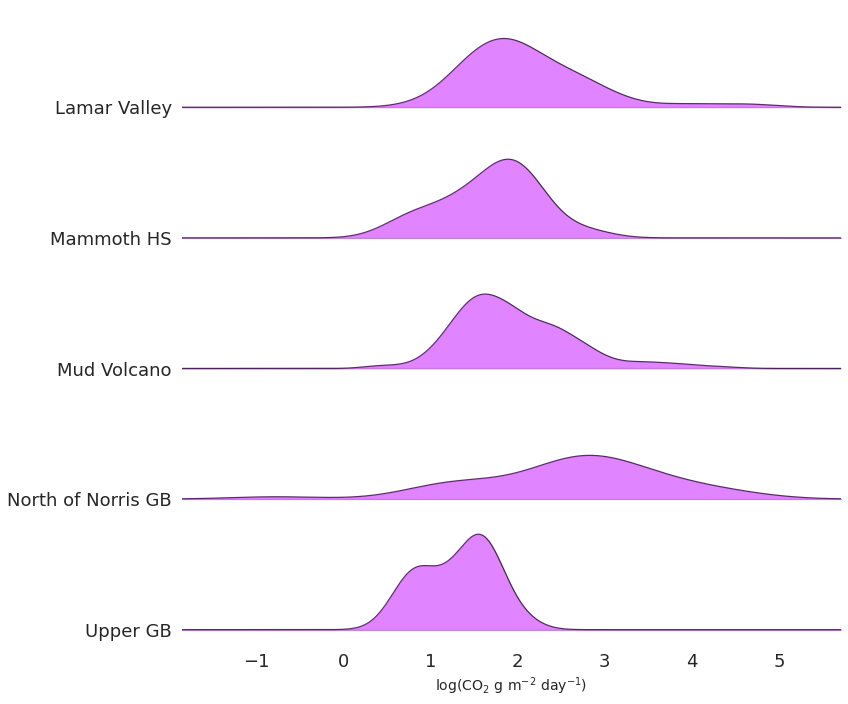

In [44]:
## Log fluxes
df_wb_2003["co2_flux_log"] = np.log10(df_wb_2003["co2_flux"])
data = df_wb_2003[["co2_flux_log", "group"]]

## Remove nan and/or inf values from log values
data = data[-data.isin([np.nan, np.inf, -np.inf]).any(1)]

## Show the number of measurements per group
print(
    "The number of samples per group for Werner and Brantley (2003):\n {}".format(
        data.groupby(by=["group"]).count()
    )
  )

## CO2
plt.figure()
joyplot(
    data = data,
    by="group", 
    alpha=0.8,
    color=[
           "#d966ff",
           "#d966ff",
           "#d966ff",
           "#d966ff",
           "#d966ff"
    ],
    figsize=(12,10)
)
plt.xlabel("log(CO$_2$ g m$^{-2}$ day$^{-1}$)", fontsize=14)
plt.rcParams.update({'font.size': 14})
plt.tight_layout()
plt.savefig("../../figures/werner_brantley_CO2_flx_ridge.png", dpi=300)
plt.show()

del(data)

## Analyze Flux and Isotope Compositions

To begin the exploratory data analysis process, we will visualize the two variables of interest, fluxes and carbon isotope (δ<sup>13</sup>C) compositions. The analysis will begin with site-by-site analysis and then examine geochemical groups.

### Descriptive Statistics

Descriptive stats by group and soil classification for the Yellowstone fluxes and isotopes

In [45]:
# Descriptive Stats by Group
df_YC_descrip_grp = df_YC_all.groupby(by=["Group", "Soil_Classification"]) \
[["CH4_Flux", "CO2_Flux", "d13CH4_source", "d13CO2_source", 
  "Soil_Tempeature_at_Surface"]].describe()

# Export table to .csv
df_YC_descrip_grp.to_csv("df_YC_descrip_grp.csv", sep=",")

# View dataframe
df_YC_descrip_grp

CH4_Flux             \
                                                     count       mean   
Group                         Soil_Classification                       
Upper GB                      Neutral-Chloride        27.0  -0.630208   
Lower GB                      Neutral-Chloride         9.0  -0.952191   
Terrace Springs               Travertine               6.0  -0.543687   
Norris GB                     Neutral-Chloride        21.0  33.169121   
North of Norris GB            Acid-Sulphate            2.0  -0.628463   
                              Neutral-Chloride         6.0  -0.413817   
Mammoth HS                    Travertine              17.0  -1.195992   
West Thumb GB                 Neutral-Chloride        11.0   6.429227   
Gas Vents (Solfatara Springs) Acid-Sulphate           22.0  70.051899   
Mud Volcano                   Acid-Sulphate           10.0   3.369366   
Eastern Yellowstone           Acid-Sulphate           15.0  92.050436   
                              Unclassified             8.0  -1.142334   

                                                                         \
                                                          std       min   
Group                         Soil_Classification                         
Upper GB                      Neutral-Chloride       0.418029 -1.360242   
Lower GB                      Neutral-Chloride       0.732672 -1.867082   
Terrace Springs               Travertine             0.294743 -0.847884   
Norris GB                     Neutral-Chloride      17.361701 -2.063207   
North of Norris GB            Acid-Sulphate          0.014373 -0.638626   
                              Neutral-Chloride       0.210673 -0.599377   
Mammoth HS                    Travertine             1.174692 -4.022761   
West Thumb GB                 Neutral-Chloride      22.202015 -1.140673   
Gas Vents (Solfatara Springs) Acid-Sulphate         80.940710 -2.170537   
Mud Volcano                   Acid-Sulphate          6.807375 -2.810356   
Eastern Yellowstone           Acid-Sulphate        202.374526 -1.175111   
                              Unclassified           0.595339 -2.401315   

                                                                         \
                                                         25%        50%   
Group                         Soil_Classification                         
Upper GB                      Neutral-Chloride     -0.838327  -0.653709   
Lower GB                      Neutral-Chloride     -1.561578  -1.027334   
Terrace Springs               Travertine           -0.766805  -0.622016   
Norris GB                     Neutral-Chloride     39.702120  41.396279   
North of Norris GB            Acid-Sulphate        -0.633545  -0.628463   
                              Neutral-Chloride     -0.564050  -0.466137   
Mammoth HS                    Travertine           -1.830449  -0.882259   
West Thumb GB                 Neutral-Chloride     -0.592974  -0.428383   
Gas Vents (Solfatara Springs) Acid-Sulphate         3.319406  30.086222   
Mud Volcano                   Acid-Sulphate        -0.488729  -0.044046   
Eastern Yellowstone           Acid-Sulphate         1.665267  16.514934   
                              Unclassified         -1.330514  -0.949280   

                                                                          \
                                                         75%         max   
Group                         Soil_Classification                          
Upper GB                      Neutral-Chloride     -0.343140    0.174132   
Lower GB                      Neutral-Chloride     -0.568105    0.276368   
Terrace Springs               Travertine           -0.325458   -0.128531   
Norris GB                     Neutral-Chloride     43.044516   44.509155   
North of Norris GB            Acid-Sulphate        -0.623381   -0.618300   
                              Neutral-Chloride     -0.352603   -0.039806   
Mammoth HS        

The tables below highlight the IQR for CH<sub>4</sub> and CO<sub>2</sub> for Yellowstone.

In [46]:
ch4_descrip = df_YC_descrip_grp.CH4_Flux[["count", "min", "25%", "50%", "75%", "max"]]
ch4_descrip_iqr = ch4_descrip[["count", "25%", "75%"]]
ch4_descrip_iqr

count        25%        75%
Group                         Soil_Classification                             
Upper GB                      Neutral-Chloride      27.0  -0.838327  -0.343140
Lower GB                      Neutral-Chloride       9.0  -1.561578  -0.568105
Terrace Springs               Travertine             6.0  -0.766805  -0.325458
Norris GB                     Neutral-Chloride      21.0  39.702120  43.044516
North of Norris GB            Acid-Sulphate          2.0  -0.633545  -0.623381
                              Neutral-Chloride       6.0  -0.564050  -0.352603
Mammoth HS                    Travertine            17.0  -1.830449  -0.317386
West Thumb GB                 Neutral-Chloride      11.0  -0.592974   0.398078
Gas Vents (Solfatara Springs) Acid-Sulphate         22.0   3.319406  94.575634
Mud Volcano                   Acid-Sulphate         10.0  -0.488729   5.852262
Eastern Yellowstone           Acid-Sulphate         15.0   1.665267  38.621600
                              Unclassified           8.0  -1.330514  -0.776483

Breakdown of the CO<sub>2</sub> and CH<sub>4</sub> fluxes by caldera side for Yellowstone.

In [47]:
# aggregate the CH4 fluxes by caldera side
df_YC_caldera_side =  df_YC_all.groupby(by=["caldera_side"])[["CH4_Flux", "CO2_Flux", "d13CH4_source", "d13CO2_source", 
  "Soil_Tempeature_at_Surface"]].describe()

df_YC_caldera_side

CH4_Flux                                                       \
                count       mean         std       min       25%       50%   
caldera_side                                                                 
west             99.0   7.215696   17.332392 -4.022761 -0.838327 -0.523550   
east             55.0  53.571878  120.854310 -2.810356 -0.624071  7.431372   

                                    CO2_Flux              ... d13CO2_source  \
                    75%         max    count        mean  ...           75%   
caldera_side                                              ...                 
west           0.099814   73.346802     99.0   26.669423  ...     -6.596886   
east          46.774110  604.201742     55.0  158.575361  ...     -4.740726   

                       Soil_Tempeature_at_Surface                              \
                   max                      count       mean        std   min   
caldera_side                                                                    
west         -3.606219                       51.0  27.290588   6.181972  18.0   
east         -3.355852                       50.0  36.591200  13.698561  10.8   

                                          
                25%    50%     75%   max  
caldera_side                              
west          22.65  26.90  30.580  49.5  
east          28.65  33.95  42.325  75.8  

[2 rows x 40 columns]

In [48]:
co2_descrip = df_YC_descrip_grp.CO2_Flux[["count", "min", "25%", "50%", "75%", "max"]]
co2_descrip_iqr = co2_descrip[["count", "25%", "75%"]]
co2_descrip_iqr

count        25%  \
Group                         Soil_Classification                     
Upper GB                      Neutral-Chloride      27.0   0.565185   
Lower GB                      Neutral-Chloride       9.0   1.848310   
Terrace Springs               Travertine             6.0   1.411170   
Norris GB                     Neutral-Chloride      21.0  47.825144   
North of Norris GB            Acid-Sulphate          2.0  69.155733   
                              Neutral-Chloride       6.0  11.211085   
Mammoth HS                    Travertine            17.0   2.811914   
West Thumb GB                 Neutral-Chloride      11.0   0.844302   
Gas Vents (Solfatara Springs) Acid-Sulphate         22.0  79.259278   
Mud Volcano                   Acid-Sulphate         10.0  49.562466   
Eastern Yellowstone           Acid-Sulphate         15.0  46.987402   
                              Unclassified           8.0   6.669097   

                                                          75%  
Group                         Soil_Classification              
Upper GB                      Neutral-Chloride       1.577410  
Lower GB                      Neutral-Chloride       6.231366  
Terrace Springs               Travertine             2.312120  
Norris GB                     Neutral-Chloride      52.443398  
North of Norris GB            Acid-Sulphate        179.071843  
                              Neutral-Chloride      20.545032  
Mammoth HS                    Travertine            95.863342  
West Thumb GB                 Neutral-Chloride       5.404836  
Gas Vents (Solfatara Springs) Acid-Sulphate        332.684730  
Mud Volcano                   Acid-Sulphate        186.391768  
Eastern Yellowstone           Acid-Sulphate        120.323060  
                              Unclassified          20.505182

For Valles, the data is to be grouped by _Group_ name and summarized with descriptive statistics for the main four metrics

In [49]:
# Descriptive Stats by Group
df_VC_descrip_grp = df_VC_all.groupby(by=["Group", "Soil_Classification"]) \
[["CH4_Flux", "CO2_Flux", "d13CH4_source", "d13CO2_source", 
  "Soil_Tempeature_at_Surface"]].describe()

# Export dataframe to .csv
df_YC_descrip_grp.to_csv("df_VC_descrip_grp.csv", sep=",")

# View Dataframe  
df_VC_descrip_grp

CH4_Flux                          \
                                       count        mean         std   
Group           Soil_Classification                                    
Alamo Canyon    Acid-Sulphate            8.0    4.860835    9.874847   
Sulphur Springs Acid-Sulphate           17.0  174.248623  290.161603   
Redondo Peak    Unclassified             7.0  111.304713  159.243254   
Hummingbird     Acid-Sulphate            9.0  177.327692  126.768870   
Soda Dam        Travertine               6.0   32.187519   65.460982   

                                                                       \
                                          min         25%         50%   
Group           Soil_Classification                                     
Alamo Canyon    Acid-Sulphate       -0.863972   -0.169980    0.157699   
Sulphur Springs Acid-Sulphate        1.510209   15.286042  121.882074   
Redondo Peak    Unclassified        -0.830579    0.420996   20.057384   
Hummingbird     Acid-Sulphate        0.818278  111.910550  137.816164   
Soda Dam        Travertine          -1.840104   -0.112512    3.938545   

                                                             CO2_Flux  \
                                            75%          max    count   
Group           Soil_Classification                                     
Alamo Canyon    Acid-Sulphate          3.500465    26.567321      8.0   
Sulphur Springs Acid-Sulphate        165.670948  1213.607225     17.0   
Redondo Peak    Unclassified         171.718704   415.626785      7.0   
Hummingbird     Acid-Sulphate        248.035454   414.147692      9.0   
Soda Dam        Travertine            19.025105   164.497033      6.0   

                                                 ... d13CO2_source            \
                                           mean  ...           75%       max   
Group           Soil_Classification              ...                           
Alamo Canyon    Acid-Sulphate         84.580932  ...     -7.338119 -5.785009   
Sulphur Springs Acid-Sulphate        374.509881  ...     -7.481047 -4.013128   
Redondo Peak    Unclassified         475.989144  ...     -5.374853 -2.252906   
Hummingbird     Acid-Sulphate        660.155812  ...     -6.837913 -4.630169   
Soda Dam        Travertine            74.122131  ...     -6.939442 -6.724130   

                                    Soil_Tempeature_at_Surface             \
                                                         count       mean   
Group           Soil_Classification                                         
Alamo Canyon    Acid-Sulphate                              8.0  26.637500   
Sulphur Springs Acid-Sulphate                             17.0  25.823529   
Redondo Peak    Unclassified                               7.0  30.000000   
Hummingbird     Acid-Sulphate                              8.0  35.425000   
Soda Dam        Travertine                                 6.0  35.133333   

                                                                            \
                                          std   min     25%    50%     75%   
Group           Soil_Classification                                          
Alamo Canyon    Acid-Sulphate        7.959933  15.7  18.450  29.65  32.275   
Sulphur Springs Acid-Sulphate        3.273479  18.1  23.400  27.20  27.900   
Redondo Peak    Unclassified         2.877354  26.3  28.175  30.60  30.825   
Hummingbird     Acid-Sulphate        3.043846  29.9  33.200  36.50  37.500   
Soda Dam        Travertine           6.920597  28.8  31.125  34.10  35.050   

                                           
                                      max  
Group           Soil_Classification        
Alamo Canyon    Acid-Sulphate        36.5  
Sulphur Springs Acid-Sulphate        30.2  
Redondo Peak    Unclassified         35.1  
Hummingbird     Acid-Sulphate        39.1  
Soda Dam        Travertine           48.3  

[5 rows x 40 columns]

In [50]:
# Caldera level descriptive stats
df_all.groupby(by=["Caldera"])[["CH4_Flux", "CO2_Flux", "d13CH4_source",
                                "d13CO2_source", "Soil_Tempeature_at_Surface"]]\
                                .describe()

CH4_Flux                                                         \
           count        mean         std       min       25%        50%   
Caldera                                                                   
YNP        154.0   23.771475   76.445993 -4.022761 -0.792938  -0.314612   
VCNP        47.0  118.496183  202.284492 -1.840104  0.937248  22.724425   

                                CO2_Flux              ... d13CO2_source  \
               75%          max    count        mean  ...           75%   
Caldera                                               ...                 
YNP       15.94968   604.201742    154.0   73.778686  ...     -5.055435   
VCNP     152.34521  1213.607225     47.0  356.624990  ...     -6.767559   

                  Soil_Tempeature_at_Surface                              \
              max                      count       mean        std   min   
Caldera                                                                    
YNP     -3.355852                      101.0  31.894851  11.528080  10.8   
VCNP    -2.252906                       46.0  29.484783   6.213425  15.7   

                                   
            25%   50%   75%   max  
Caldera                            
YNP      24.600  29.7  35.9  75.8  
VCNP     26.525  29.8  33.2  48.3  

[2 rows x 40 columns]

In [51]:
# Print the median values for fluxes
print("The median CH4 flux for YNP is {:.2f} mg m-2 day-1, \nand CO2 flux for YNP is {:.2f} g m-2 day-1\n".format(df_YC_all.CH4_Flux.agg(func=np.median), df_YC_all.CO2_Flux.agg(func=np.median)))
print("The median CH4 flux for VCNP is {:.2f} mg m-2 day-1, \nand CO2 flux for VCNP is {:.2f} g m-2 day-1\n".format(df_VC_all.CH4_Flux.agg(func=np.median), df_VC_all.CO2_Flux.agg(func=np.median)))

The median CH4 flux for YNP is -0.31 mg m-2 day-1, 
and CO2 flux for YNP is 14.37 g m-2 day-1

The median CH4 flux for VCNP is 22.72 mg m-2 day-1, 
and CO2 flux for VCNP is 264.97 g m-2 day-1



Examining descriptive statistics for fluxes greater than zero.

In [52]:
# Caldera level descriptive stats for fluxes greater than zero
df_all[(df_all["CH4_Flux"] > 0) | (df_all["CO2_Flux"] > 0)]\
.groupby(by=["Caldera"])\
[["CH4_Flux", "CO2_Flux", "d13CH4_source","d13CO2_source", 
  "Soil_Tempeature_at_Surface"]].describe()
  

CH4_Flux                                                         \
           count        mean         std       min       25%        50%   
Caldera                                                                   
YNP        150.0   24.430173   77.356610 -4.022761 -0.787260  -0.256322   
VCNP        47.0  118.496183  202.284492 -1.840104  0.937248  22.724425   

                                CO2_Flux              ... d13CO2_source  \
               75%          max    count        mean  ...           75%   
Caldera                                               ...                 
YNP       16.42607   604.201742    150.0   75.792361  ...     -4.989708   
VCNP     152.34521  1213.607225     47.0  356.624990  ...     -6.767559   

                  Soil_Tempeature_at_Surface                              \
              max                      count       mean        std   min   
Caldera                                                                    
YNP     -3.355852                       99.0  31.930101  11.309471  15.5   
VCNP    -2.252906                       45.0  29.407778   6.261398  15.7   

                                  
          25%   50%    75%   max  
Caldera                           
YNP      24.6  29.7  35.65  75.8  
VCNP     26.3  29.8  33.20  48.3  

[2 rows x 40 columns]

In [53]:
eastern_YNP_and_VCNP = ["Gas Vents (Solfatara Springs)", "Mud Volcano",
                        "Eastern Yellowstone", "Alamo Canyon", 
                        "Sulphur Springs", "Redondo Peak", 
                        "Hummingbird", "Soda Dam"]                    
# Caldera level descriptive stats for fluxes in the eastern portion of YNP
df_all_positive_flux = df_all[df_all["Group"].isin(eastern_YNP_and_VCNP)]\
.groupby(by=["Caldera"])\
[["CH4_Flux", "CO2_Flux", "d13CH4_source","d13CO2_source", 
  "Soil_Tempeature_at_Surface"]]

df_all_positive_flux_descrip = df_all_positive_flux.describe()
df_all_positive_flux_descrip

CH4_Flux                                                         \
           count        mean         std       min       25%        50%   
Caldera                                                                   
YNP         55.0   53.571878  120.854310 -2.810356 -0.624071   7.431372   
VCNP        47.0  118.496183  202.284492 -1.840104  0.937248  22.724425   

                                CO2_Flux              ... d13CO2_source  \
               75%          max    count        mean  ...           75%   
Caldera                                               ...                 
YNP       46.77411   604.201742     55.0  158.575361  ...     -4.740726   
VCNP     152.34521  1213.607225     47.0  356.624990  ...     -6.767559   

                  Soil_Tempeature_at_Surface                              \
              max                      count       mean        std   min   
Caldera                                                                    
YNP     -3.355852                       50.0  36.591200  13.698561  10.8   
VCNP    -2.252906                       46.0  29.484783   6.213425  15.7   

                                      
            25%    50%     75%   max  
Caldera                               
YNP      28.650  33.95  42.325  75.8  
VCNP     26.525  29.80  33.200  48.3  

[2 rows x 40 columns]

In [54]:
# Print the median values for fluxes
print("The median CH4 flux for YNP (considering only positive fluxes) is {:.2f} mg m-2 day-1, \nand CO2 flux (considering only positive fluxes) for YNP is {:.2f} g m-2 day-1\n".format(df_all_positive_flux_descrip.loc["YNP"][("CH4_Flux", "50%")], df_all_positive_flux_descrip.loc["YNP"][("CO2_Flux", "50%")]))
print("The median CH4 flux for VCNP (considering only positive fluxes) is {:.2f} mg m-2 day-1, \nand CO2 flux (considering only positive fluxes) for VCNP is {:.2f} g m-2 day-1\n".format(df_all_positive_flux_descrip.loc["VCNP"][("CH4_Flux", "50%")], df_all_positive_flux_descrip.loc["VCNP"][("CO2_Flux", "50%")]))

The median CH4 flux for YNP (considering only positive fluxes) is 7.43 mg m-2 day-1, 
and CO2 flux (considering only positive fluxes) for YNP is 98.87 g m-2 day-1

The median CH4 flux for VCNP (considering only positive fluxes) is 22.72 mg m-2 day-1, 
and CO2 flux (considering only positive fluxes) for VCNP is 264.97 g m-2 day-1



## Fluxes Summary

### Caldera Level Flux Summary

The probability plot below has been constructed to highlight the probability of observing a measurement for west-east and north-south fluxes at Yellowstone and Valles.

#### Experimemnt: Using scipy lognorm with histogram

Not working super well. Needs a way to duynamicallyu add pdf when multiple histograms exist on a plot. 

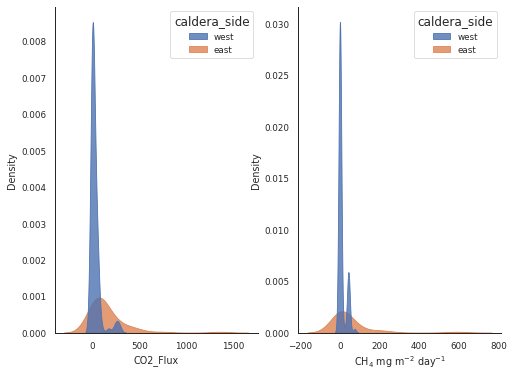

In [ ]:
# Visualize the fluxes as probability plots

fig, ax = plt.subplots(1,2,figsize=(8,6), sharey=False)
## All CH4
### Yellowstone
sns.kdeplot(
    data=df_YC_all,
    x = "CH4_Flux", 
    color=CH4_color1,
    shade=True,
    hue="caldera_side", 
    alpha=0.8, 
    log_scale=False, 
    ax=ax[1]
  )
### Valles Caldera
# sns.kdeplot(
#     data=df_VC_all,
#     x = "CH4_Flux", 
#     color=CH4_color2,
#     shade=True, 
#     alpha=0.7, 
#     log_scale=False, 
#     ax=ax[1]
#   )
# ax[1].legend(["YNP - East", "YNP - West"], loc="upper left", ncol=1)
ax[1].set_xlabel("CH$_4$ mg m$^{-2}$ day$^{-1}$")
ax[1].set_ylabel("Density")

## All CO2
### Yellowstone
sns.kdeplot(
    data=df_YC_all,
    x="CO2_Flux", 
    color=CO2_color1,
    shade=True, 
    hue="caldera_side",
    alpha=0.8, 
    log_scale=False, 
    ax=ax[0]
  )
# ### Valles Caldera
# sns.kdeplot(df_all.CO2_Flux, color=CO2_color2,
#             shade=True, alpha=0.7, log_scale=True, ax=ax[0])
# ax[0].legend(["YNP", "VCNP"], loc="upper left", ncol=1)
# ax[0].set_xlabel("CO$_2$ g m$^{-2}$ day$^{-1}$")
# #plt.suptitle("Fluxes")
# plt.show()
# plt.savefig("../../figures/CH4-CO2_flx_all_caldera_kde.png", dpi=300)

Histogram plot for the CO<sub>2</sub> and CH<sub>4</sub> for the Yellowstone observations. 

Make sure the binwidth of the KDE matches the binwidth used for histogram. If these do not match, the curve will not be representative of probability.

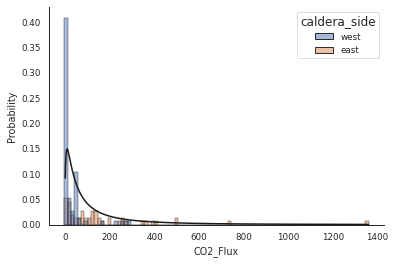

In [ ]:
data = df_YC_all[df_YC_all["caldera_side"] == "east"]
# lognorm_pdf_params = stats.lognorm.fit(data.CO2_Flux.dropna())
# co2_lognorm_pdf = stats.lognorm.pdf(
#     data.CO2_Flux.dropna(), 
#     *lognorm_pdf_params
#   )

shape, loc, scale = stats.lognorm.fit(data.CO2_Flux.dropna())

x_fit = np.linspace(
    data.CO2_Flux.dropna().min(), 
    data.CO2_Flux.dropna().max(), 
    1000
  )

co2_lognorm_pdf_fit = stats.lognorm.pdf(
    x_fit, 
    shape, 
    loc=loc, 
    scale=scale
  )

# rv = stats.lognorm()
 
fig, ax = plt.subplots()
sns.histplot(
    data=df_YC_all,
    x = "CO2_Flux",
    hue="caldera_side",
    stat="probability", 
    edgecolor="black",
    binwidth=15
)
ax.plot(
    x_fit,
    co2_lognorm_pdf_fit * 15,
    "k-",
    lw=1.5
)

plt.show()

Made an attempot at using the scipy PDF function with the histogram plot but does not work quite right. Using the KDE instead as an approximation of the PDF.

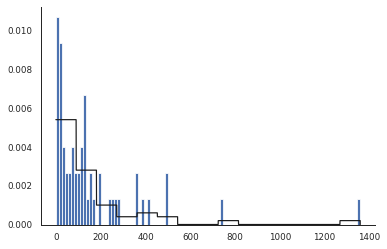

In [ ]:
hist = np.histogram(
    data.CO2_Flux.dropna(),
    bins=15
)

hist_dist = stats.rv_histogram(hist)

x_fit = np.linspace(
    data.CO2_Flux.dropna().min(), 
    data.CO2_Flux.dropna().max(), 
    10000
  )

fig, ax = plt.subplots()

plt.hist(
    data.CO2_Flux.dropna(), 
    bins=100,
    density=True
  )
plt.plot(
    x_fit, 
    hist_dist.pdf(x_fit), 
    "k-",
    label='PDF'
  )

plt.show()

#### KDE Overlay on Probability Histograms

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


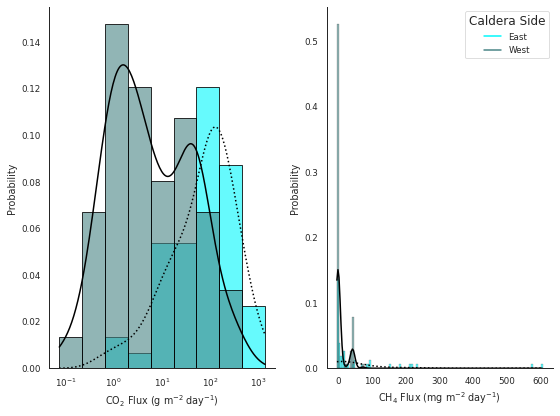

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,6), sharey=False)
## All CH4
### Yellowstone
binwidith_val = 5
sns.histplot(
    data=df_YC_all,
    x = "CH4_Flux", 
    palette=[caldera_side_color_en, caldera_side_color_ws],
    hue="caldera_side",
    stat="probability", 
    edgecolor="black",
    kde=True,
    # kde_kws={"bw_adjust":binwidith_val},
    line_kws={"linewidth":1.5},
    alpha=0.6, 
    log_scale=False,
    binwidth=binwidith_val, 
    legend=False,
    ax=ax[1]
  )

# legend_labels, _ = ax[1].get_legend_handles_labels()
# ax[1].legend(
#     legend_labels,
#     ["West", "East"],
#     bbox_to_anchor=(1,1),
#     title='Caldera Side'
#   )

# customize legend
ax[1].legend(
    title="Caldera Side", 
    loc='upper right', 
    labels=['East', 'West']
  )

# customize kde lines
ax[1].lines[0].set_color('black')
ax[1].lines[0].set_linestyle(':')
ax[1].lines[1].set_color('black')
ax[1].lines[1].set_linestyle('-')

# set x-axis label
ax[1].set_xlabel(
    "CH$_{4}$ Flux (mg m$^{-2}$ day$^{-1}$)"
)

# CO2
sns.histplot(
  data=df_YC_all,
  x="CO2_Flux", 
  palette=[caldera_side_color_en, caldera_side_color_ws],
  hue="caldera_side",
  stat="probability",
  edgecolor="black",
  kde=True,
  #kde_kws={"bw_adjust":binwidith_val},
  line_kws={"lw":1.5},
  alpha=0.6, 
  log_scale=True, 
  # binwidth=25.0,
  ax=ax[0]
)

ax[0].lines[0].set_color('black')
ax[0].lines[0].set_linestyle(':')
ax[0].lines[1].set_color('black')
ax[0].lines[1].set_linestyle('-')

ax[0].set_xlabel(
    "CO$_{2}$ Flux (g m$^{-2}$ day$^{-1}$)"
)
ax[0].get_legend().remove()

plt.tight_layout()

plt.savefig("../../figures/dist-hist_flx_yc_all_caldera-side.png", dpi=300)

plt.show()

The plot below is to be used as inset for the plot above. Explicitly, the plot below will contain CH<sub>4</sub> fluxes that are between -5 and +5 mg CH<sub>4</sub> hr<sup>-1</sup> day<sup>-1</sup>.

The plots will be organized properly on a `.pptx`.

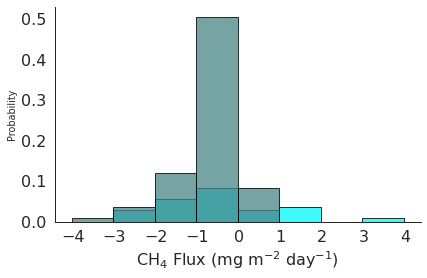

In [ ]:
# trim data for inset
inset_ch4_df = df_YC_all[
    (df_YC_all["CH4_Flux"] >= -5) & (df_YC_all["CH4_Flux"] <= 5)
  ]

fig, ax = plt.subplots(figsize=(6,4))
## All CH4
### Yellowstone
binwidith_val = 1
sns.histplot(
    data=inset_ch4_df,
    x = "CH4_Flux", 
    palette=[caldera_side_color_en, caldera_side_color_ws],
    hue="caldera_side",
    stat="probability", 
    edgecolor="black",
    kde=False,
    # kde_kws={"bw_adjust":binwidith_val},
    line_kws={"linewidth":1.5},
    alpha=0.75, 
    log_scale=False,
    binwidth=binwidith_val, 
    ax=ax
  )

# ax.lines[0].set_color('black')
# ax.lines[0].set_linestyle(':')
# ax.lines[1].set_color('black')
# ax.lines[1].set_linestyle('-')

ax.set_xlabel(
    "CH$_{4}$ Flux (mg m$^{-2}$ day$^{-1}$)",
    size=16
)
ax.get_legend().remove()

plt.tight_layout()
plt.savefig(
    "../../figures/dist-hist_flx_yc_inset_caldera-side.png", 
    dpi=300
  )

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(16)

plt.show()

Histogram plot of fluxes at Valles with KDE overlay

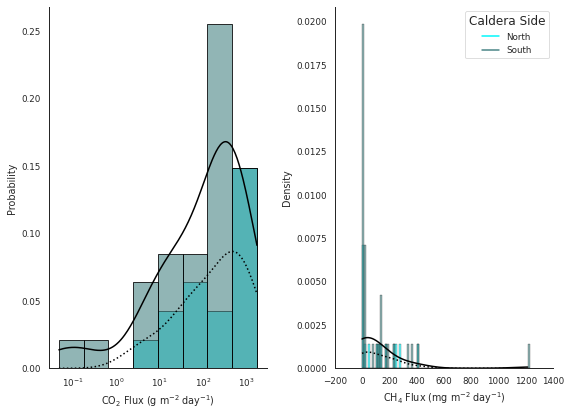

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,6), sharey=False)
## All CH4
### Yellowstone
binwidith_val = 15
sns.histplot(
    data=df_VC_all,
    x = "CH4_Flux", 
    palette=[caldera_side_color_en, caldera_side_color_ws],
    hue="caldera_side",
    stat="density", 
    edgecolor="black",
    kde=True,
    # kde_kws={"bw_adjust":binwidith_val},
    line_kws={"linewidth":1.5},
    alpha=0.6, 
    log_scale=False,
    binwidth=binwidith_val, 
    legend=False,
    ax=ax[1]
  )

# extend x-axis limits
ax[1].set_xlim([-200,1400])

# customize legend
ax[1].legend(
    title="Caldera Side", 
    loc='upper right', 
    labels=['North', 'South']
  )

# customize kde lines
ax[1].lines[0].set_color('black')
ax[1].lines[0].set_linestyle(':')
ax[1].lines[1].set_color('black')
ax[1].lines[1].set_linestyle('-')

# set x-axis label
ax[1].set_xlabel(
    "CH$_{4}$ Flux (mg m$^{-2}$ day$^{-1}$)"
)

# CO2
sns.histplot(
  data=df_VC_all,
  x="CO2_Flux", 
  palette=[caldera_side_color_en, caldera_side_color_ws],
  hue="caldera_side",
  stat="probability",
  edgecolor="black",
  kde=True,
  #kde_kws={"bw_adjust":binwidith_val},
  line_kws={"lw":1.5},
  alpha=0.6, 
  log_scale=True, 
  # binwidth=25.0,
  ax=ax[0]
)

ax[0].lines[0].set_color('black')
ax[0].lines[0].set_linestyle(':')
ax[0].lines[1].set_color('black')
ax[0].lines[1].set_linestyle('-')

ax[0].set_xlabel(
    "CO$_{2}$ Flux (g m$^{-2}$ day$^{-1}$)"
)
ax[0].get_legend().remove()

plt.tight_layout()

plt.savefig("../../figures/dist-hist_flx_vc_all_caldera-side.png", dpi=300)

plt.show()

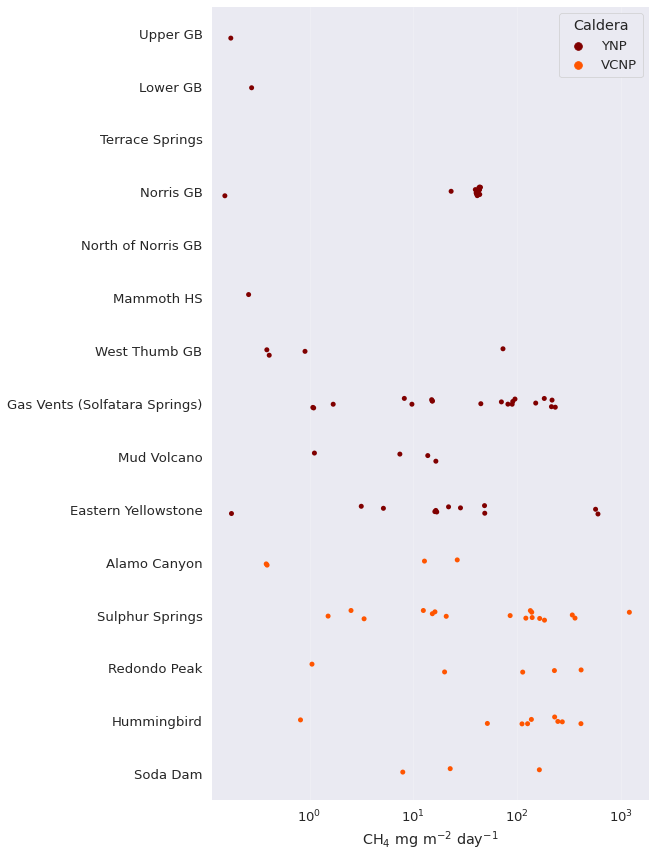

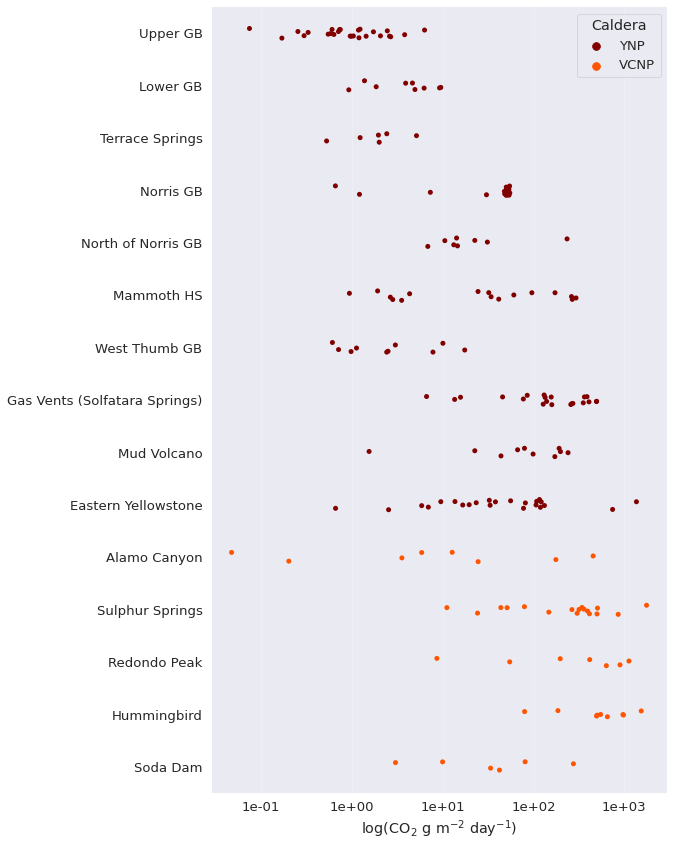

In [ ]:
# Set theme (e.g., visual style, color pallette, etc.)
sns.set_theme(context="paper", style="darkgrid", palette="tab10",
              font_scale=1.5)

# Strip plots fluxes by group (i.e. site)
## CH4 - Yellowstone
p_CH4_flx = sns.catplot(x="CH4_Flux", y="Group", data=df_all,
                        hue="Caldera", kind="strip",
                        orient="h", height=12, aspect=0.8,
                        legend_out=False, palette="gist_heat")
p_CH4_flx.set_axis_labels("CH$_4$ mg m$^{-2}$ day$^{-1}$", "")
p_CH4_flx.set(xscale="log")
plt.savefig("../../figures/CH4_flx_all_strip.png", dpi=300)

## CO2 - Yellowstone
p_CO2_flx = sns.catplot(x="CO2_Flux", y="Group", data=df_all, 
                        kind="strip", hue="Caldera", orient="h", 
                        height=12, aspect=0.8,
                        palette="gist_heat", legend_out=False)
p_CO2_flx.set_axis_labels("log(CO$_2$ g m$^{-2}$ day$^{-1}$)", "")
p_CO2_flx.set(xscale="log")
for ax in p_CO2_flx.axes.flat:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'{y:2.0e}'))
plt.tight_layout()
# Save plot to Google Drive Directory  
plt.savefig("../../figures/CO2_flx_all_strip.png", dpi=300)

Flux Figure: Strip plots of fluxes collected across YNP (darker) and VCNP (lighter). The data are sorted by groups labelled in the same fashion for Bergfeld et al. (2011) and Chiodini et al. (2012) for YNP and Goff and Janick (2002) for VCNP. Reading down the y-axis for the YNP measurements marks an east to west progression, and a north to south direction for VCNP.

The strip plots of CH<sub>4</sub> and CO2 fluxes (Figure ##) highlight the extent to which fluxes can vary at each site. There was a wide range of CH4 flux observations at YNP (19.24 ± 48.40 mg m<sup>-2</sup> day<sup>-1</sup>) with the maximum value (337 mg m<sup>-2</sup> day<sup>-1</sup>) occuring in the eastern portion (i.e. east of West Thumb) of the park. These exceptionally high fluxes occurred in the eastern regions supported by previous reports (Werner). In particular, acid-sulphate patches along the East Entrance Road (EETR) oustide of the caldera boundary, CH4 fluxes were very high (54.17 ± 114.31 mg m<sup>-2</sup> day<sup>-1</sup>). Similary within Gas Vents (also known as Solfatara Springs) (GVNT), fluxes of CH<sup>4</sup> varied greately but were also great in magnitude as well (49.45 ± 69.49 <sup>-2</sup> day<sup>-1</sup>). Apart from the high fluxes that occured in the eastern portion of YNP, most CH4 fluxes were relatively low (≤ 6 mg <sup>-2</sup> day<sup>-1</sup>) across YNP.

At VCNP, the CH<sub>4</sub> fluxes were very high in the acid-sulphate region along the western boundary of the caldera known as Sulphur Springs (VCSS). At VCSS, CH<sub>4</sub> fluxes had a similar distribution (124.95 ± 290.16 mg m<sup>-2</sup> day<sup>-1</sup>) as GVNT (Figure #_JoyPlot_#). However, the median flux at VCSS (121.88 mg m<sup>-2</sup> day<sup>-1</sup>, n = 17) was much greater than at GVNT (mg m<sup>-2</sup> day<sup>-1</sup>, n = 22). 

These CO<sub>2</sub> flux data from YNP align with previous work conducted by Werner and Brantley (2003), where the neutral-chloride sections (e.g. Upper and Lower GB) were low in CO<sub>2</sub> and the acid-sulphate regions distinguished themselves with higher fluxes (Figure ## and #_scatter plot by soil classification_#). Results from this study at Mud Volacano (MDVC) (95.20 ± 67.88 g <sup>-2</sup> day<sup>-1</sup>) are within the same order of magnitude presented in Werner and Brantley (2003). However, measurements in the acid-sulphate region at Gas Vents (147.71 ± 119.30 g <sup>-2</sup> day<sup>-1</sup>) eclipse the those from MDVC and all other sites across YNP suggesting that the site is significant source of diffuse CO2. 

At VCNP, the CO<sub>2</sub>

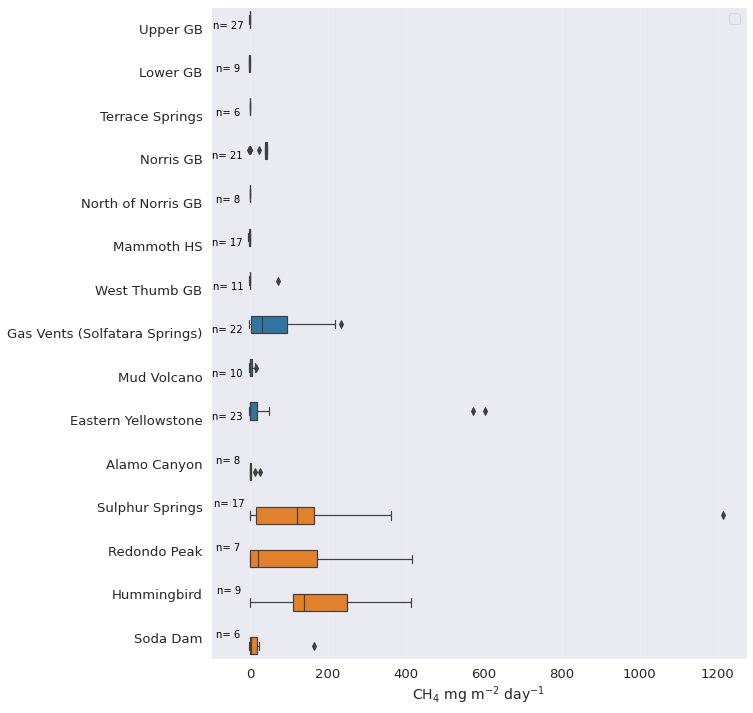

In [ ]:
fig, p_CH4_flx = plt.subplots(figsize = (0.8*12, 12))
p_CH4_flx = sns.boxplot(
    y="Group", 
    x="CH4_Flux", 
    hue="Caldera",
    data=df_all, 
    # palette="gist_heat"
  )
p_CH4_flx.set_xlim(-100,)
mins = df_all.groupby(["Group"])["CH4_Flux"].min().values-55
nobs = df_all.groupby(["Group"])["CH4_Flux"].count()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n= " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,p_CH4_flx.get_yticklabels()):
  p_CH4_flx.text(mins[tick], tick, nobs[tick], size="x-small",
                 color='black', verticalalignment = "baseline",
                 horizontalalignment="center", rotation=0)
p_CH4_flx.set_xlabel("CH$_4$ mg m$^{-2}$ day$^{-1}$", fontsize=14)
p_CH4_flx.set_ylabel("")
p_CH4_flx.legend("")
plt.savefig("../../figures/CH4_flx_all_box_nobvs.png", dpi=300)

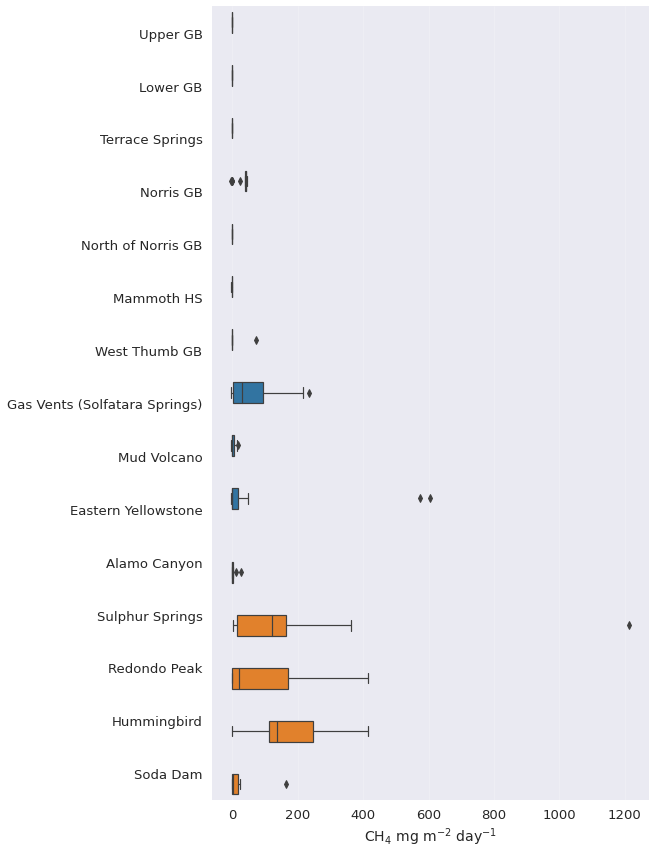

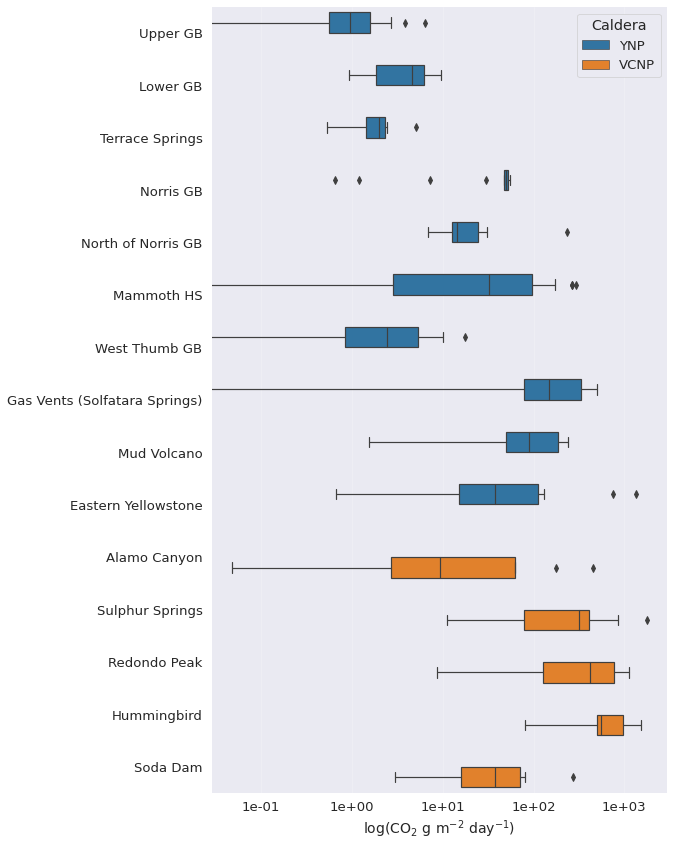

In [ ]:
# Boxplots fluxes by group (i.e. site)
## CH4 - Yellowstone
p_CH4_flx = sns.catplot(
    x="CH4_Flux", 
    y="Group", 
    data=df_all,
    hue="Caldera", 
    kind="box", 
    # palette="gist_heat",
    orient="h", 
    height=12, 
    aspect=0.8,
    legend=False, 
    legend_out=False
  )
p_CH4_flx.set_axis_labels("CH$_4$ mg m$^{-2}$ day$^{-1}$", "", fontsize=14)
p_CH4_flx.set(xscale="linear")
plt.savefig("../../figures/CH4_flx_all_box.png", dpi=300)

## CO2 - Yellowstone
p_CO2_flx = sns.catplot(
    x="CO2_Flux", 
    y="Group", 
    data=df_all, 
    kind="box",
    hue="Caldera", 
    orient="h", 
    height=12, 
    aspect=0.8,
    legend_out=False, 
    # palette="gist_heat"
  )
p_CO2_flx.set_axis_labels("log(CO$_2$ g m$^{-2}$ day$^{-1}$)", "", fontsize=14)
p_CO2_flx.set(xscale="log")
for ax in p_CO2_flx.axes.flat:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'{y:2.0e}'))
plt.tight_layout()
# Save plot to Google Drive Directory  
plt.savefig("../../figures/CO2_flx_all_box.png", dpi=300)

Boxplots of fluxes: caption for the strip plots applies here



### Partitioning Fluxes by Magnitude

Examine the fluxes by proportion of flux type. Using graphic statistical analysis (GSA) (Chiodini et al., 2012; Sinclair (1974), Wen et al., 2016), the fluxes can be partitioned into different flux categories such as low flux (LF), moderate flux (MF), and high flux (HF). These flux categories highlight the likely mode of transport to the surface (e.g., passing through sinter or a fracture). (---this needs to be rewritten---) 

This process relies on the fact that the fluxes are distributed lognormally. The lognormally distrbuted fluxes are plotted against the cumulative frequency (also known as the non-exceedence probability) highlights the proportion of fluxes that are less than or equal to the cumulative frequency, and the inflection points demonstrate flux values that correspond to different flux categories as described above. 

This process begins by defining the distribution of fit for the flux data. The data were first plotted using a histogram to gain a visual sense of the likely distribution. For CH4 ---, and CO2 was skewed left suggesting that a lognormal population with σ > µ is possible. To prove that the distribution

#### Trimming Flux Dataframes
Short statements trimming dataset for relevant fluxes

In [ ]:
# Retain rows that report a flux that is ≥ 0 for either gas
df_YC_flx_pos_only = df_YC_all[(df_YC_all["CH4_Flux"] >= 0) | 
                           (df_YC_all["CO2_Flux"] >= 0)]
# Assess the shape of the trimmed dataframe
YNP_flx_pos_only_shape = df_YC_flx_pos_only.shape
print("After fluxes less than zero are removed from the dataframe, \nthe number of rows and columns present are {} and {}, respectively.".format(YNP_flx_pos_only_shape[0], YNP_flx_pos_only_shape[1]))

After fluxes less than zero are removed from the dataframe, 
the number of rows and columns present are 150 and 33, respectively.


In [ ]:
# Retain rows that report a flux that is ≥ 0 for either gas
df_VC_flx_pos_only = df_VC_all[(df_VC_all["CH4_Flux"] >= 0) | 
                           (df_VC_all["CO2_Flux"] >= 0)]
# Assess the shape of the trimmed dataframe
VCNP_flx_pos_only_shape = df_VC_flx_pos_only.shape
print("After fluxes less than zero are removed from the dataframe, \nthe number of rows and columns present are {} and {}, respectively.".format(VCNP_flx_pos_only_shape[0], VCNP_flx_pos_only_shape[1]))

After fluxes less than zero are removed from the dataframe, 
the number of rows and columns present are 47 and 33, respectively.


In [ ]:
flx_pos_only_loss = perc_diff(YNP_flx_pos_only_shape[0], YNP_all_shape[0])
### Report the percentage of lost fluxes
print("{:.1f}% of fluxes were lost when values less than zero were removed".format(flx_pos_only_loss))

2.6% of fluxes were lost when values less than zero were removed


In [ ]:
flx_pos_only_loss = perc_diff(VCNP_flx_pos_only_shape[0], VCNP_all_shape[0])
### Report the percentage of lost fluxes
print("{:.1f}% of fluxes were lost when values less than zero were removed".format(flx_pos_only_loss))

2.1% of fluxes were lost when values less than zero were removed


#### Visualize the Distribution of Fluxes
With density plots, visualize the spread of fluxes by caldera and by site

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


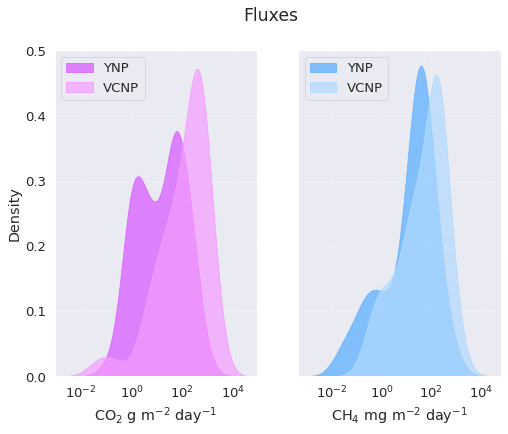

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualize the fluxes as density plots
# Plot histograms
fig, ax = plt.subplots(1,2,figsize=(8,6), sharey=True)
## All CH4
### Yellowstone
sns.kdeplot(df_YC_flx_pos_only.CH4_Flux, color=CH4_color1,
            shade=True, alpha=0.8, log_scale=True, ax=ax[1])
### Valles Caldera
sns.kdeplot(df_VC_flx_pos_only.CH4_Flux, color=CH4_color2,
            shade=True, alpha=0.7, log_scale=True, ax=ax[1])
ax[1].legend(["YNP", "VCNP"], loc="upper left", ncol=1)
ax[1].set_xlabel("CH$_4$ mg m$^{-2}$ day$^{-1}$")
ax[1].set_ylabel("Density")

## All CO2
### Yellowstone
sns.kdeplot(df_YC_flx_pos_only.CO2_Flux, color=CO2_color1,
            shade=True, alpha=0.8, log_scale=True, ax=ax[0])
### Valles Caldera
sns.kdeplot(df_VC_flx_pos_only.CO2_Flux, color=CO2_color2,
            shade=True, alpha=0.7, log_scale=True, ax=ax[0])
ax[0].legend(["YNP", "VCNP"], loc="upper left", ncol=1)
ax[0].set_xlabel("CO$_2$ g m$^{-2}$ day$^{-1}$")
plt.suptitle("Fluxes")
plt.show()
plt.savefig("../../figures/CH4-CO2_flx_all_caldera_kde.png", dpi=300)

KDE Plot of Fluxes: Kernel density estimate (KDE) plots approximates the probability density function for CH<sub>4</sub> and CO<sub>2</sub>. All fluxes greater than zero are presented for YNP darker shade; _n_ = 150) and VCNP (lighter shade; _n_ = 47). Note: mass units for CH<sub>4</sub> are in mg and g for CO<sub>2</sub>.

The distribution of CH<sub>4</sub> fluxes for both calderas are similar in shape although the slightly greater median for VCNP () than YNP (). The shape of the KDE plots indicates a primary bump that peaks near their respective medians, and there is a smaller peak to the left of the primary peak (see ridgeplot text for details).

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: inva

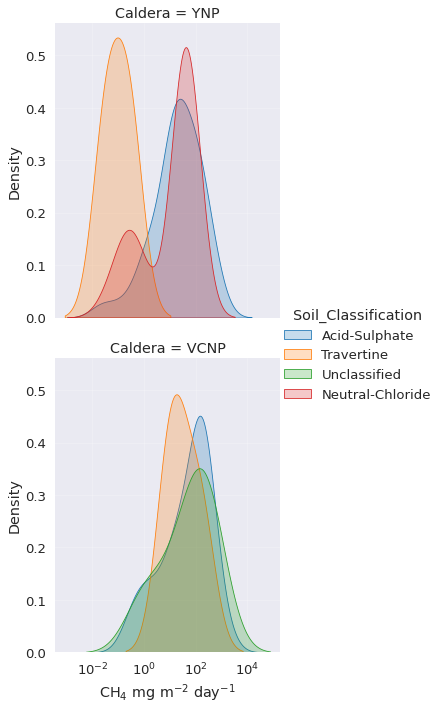

In [ ]:
## CH4 fluxes: Comparisons between the caldera
fg = sns.FacetGrid(df_all, 
                   hue="Soil_Classification",
                   row="Caldera", height=5, aspect=0.9,
                   sharex=True, legend_out=True)
fg.map_dataframe(sns.kdeplot, data=df_all, log_scale=True,
                 x="CH4_Flux", fill=True)
fg.add_legend()
fg.set_axis_labels(x_var="CH$_4$ mg m$^{-2}$ day$^{-1}$", y_var="Density")
plt.savefig("../../figures/faceted_kde_CH4_Flux.png")

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


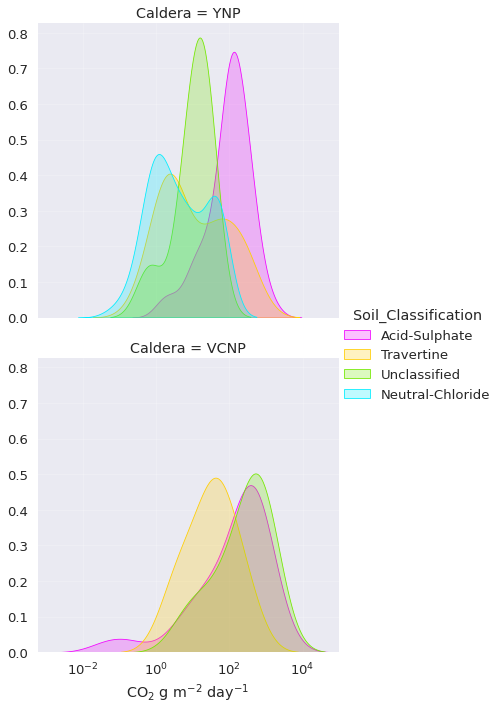

In [ ]:
## CO2 fluxes: Comparisons between the caldera
fg = sns.FacetGrid(df_all, 
                   hue="Soil_Classification", palette="gist_ncar_r",
                   row="Caldera", height=5, aspect=1.1,
                   sharex=True, legend_out=True)
fg.map_dataframe(sns.kdeplot, data=df_all, log_scale=True,
                 x="CO2_Flux", fill=True)
fg.set_axis_labels(x_var="CO$_2$ g m$^{-2}$ day$^{-1}$", y_var="")
fg.set(xlim=(0,1E05))
fg.add_legend()
plt.savefig("../../figures/faceted_kde_CO2_Flux.png")

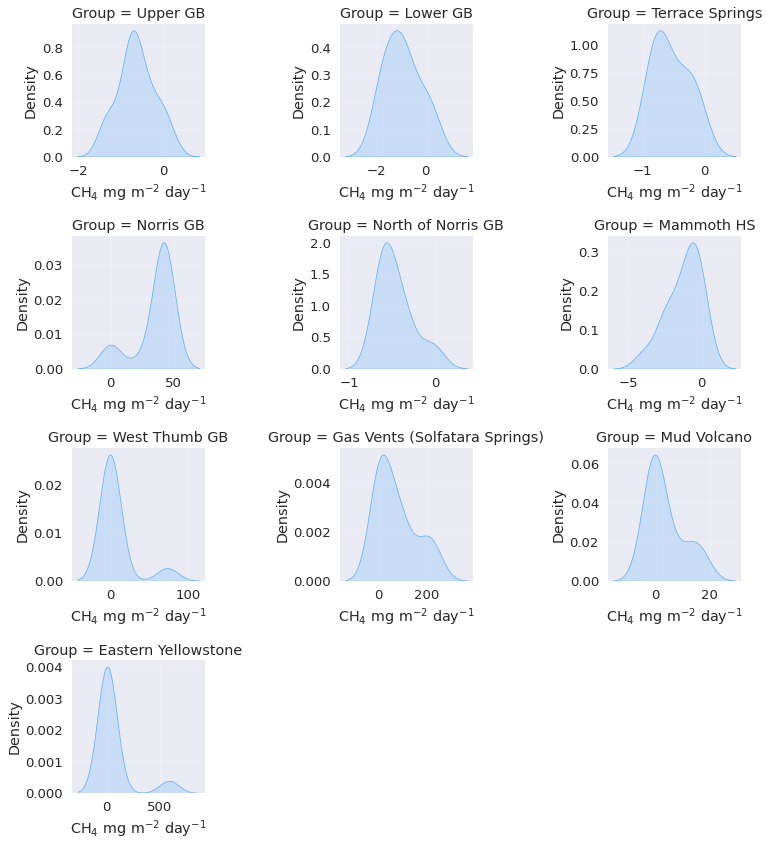

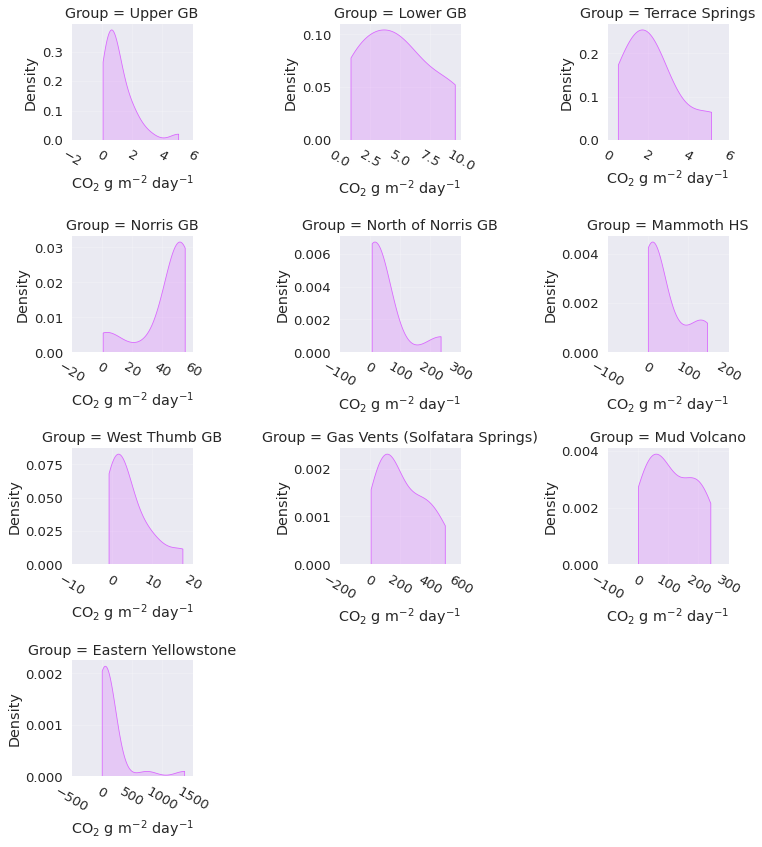

In [ ]:
# Flux Histograms by Site
## CH4
fg1 = sns.FacetGrid(df_YC_flx_pos_only,
                   col="Group", col_wrap=3,
                   height=3, aspect=1.2,
                   col_order=ordered_groups_YC,
                   sharex=False,sharey=False)
fg1.map_dataframe(sns.kdeplot, x="CH4_Flux",
                 color=CH4_color1, shade=True)
fg1.set(xlabel="CH$_4$ mg m$^{-2}$ day$^{-1}$",
       ylabel="Density")
fg1.tight_layout()
plt.savefig("../../figures/YNP_CH4_flx_kde.png", dpi=300)

## CO2
fg2 = sns.FacetGrid(df_YC_flx_pos_only,
                    col="Group", col_wrap=3, 
                    height=3, aspect=1.2,
                    col_order=ordered_groups_YC,
                    sharex=False, sharey=False)
fg2.map_dataframe(sns.kdeplot, x="CO2_Flux",
                  color=CO2_color1, shade=True, cut=0)
fg2.set(xlabel="CO$_2$ g m$^{-2}$ day$^{-1}$",
        ylabel="Density")
fg2.set_xticklabels(rotation=-30)
fg2.tight_layout()
plt.savefig("../../figures/YNP_CO2_flx_kde.png", dpi=300)

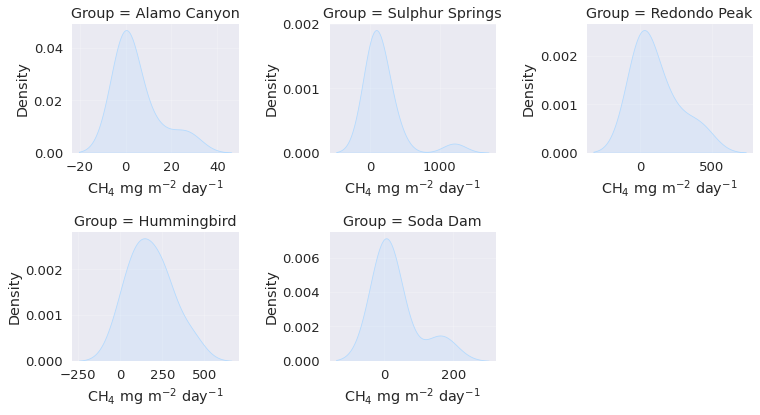

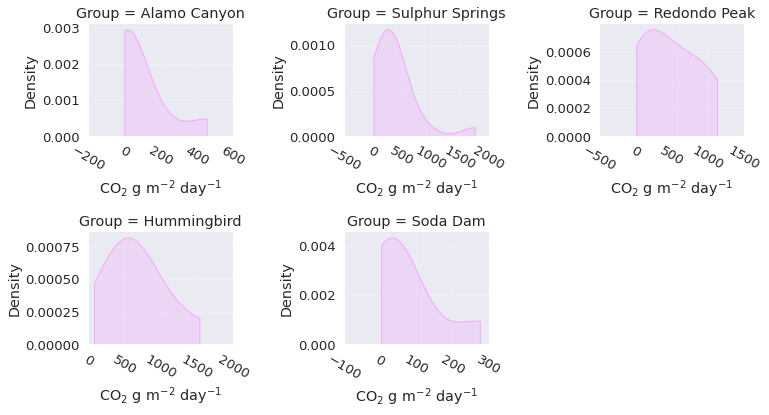

In [ ]:
# Flux Histograms by Site
## CH4
fg1 = sns.FacetGrid(df_VC_flx_pos_only,
                   col="Group", col_wrap=3, height=3,aspect=1.2,
                   col_order=ordered_groups_VC,
                   sharex=False,sharey=False)
fg1.map_dataframe(sns.kdeplot, x="CH4_Flux",
                 color=CH4_color2, shade=True)
fg1.set(xlabel="CH$_4$ mg m$^{-2}$ day$^{-1}$",
       ylabel="Density")
fg1.tight_layout()
plt.savefig("../../figures/VCNP_CH4_flx_kde.png", dpi=300)

## CO2
fg2 = sns.FacetGrid(df_VC_flx_pos_only,
                   col="Group", col_wrap=3, height=3,aspect=1.2,
                   col_order=ordered_groups_VC,
                   sharex=False, sharey=False)
fg2.map_dataframe(sns.kdeplot, x="CO2_Flux", cut=0,
                 color=CO2_color2, shade=True)
fg2.set(xlabel="CO$_2$ g m$^{-2}$ day$^{-1}$",
       ylabel="Density")
fg2.set_xticklabels(rotation=-30)
fg2.tight_layout()
plt.savefig("../../figures/VCNP_CO2_flx_kde.png", dpi=300)

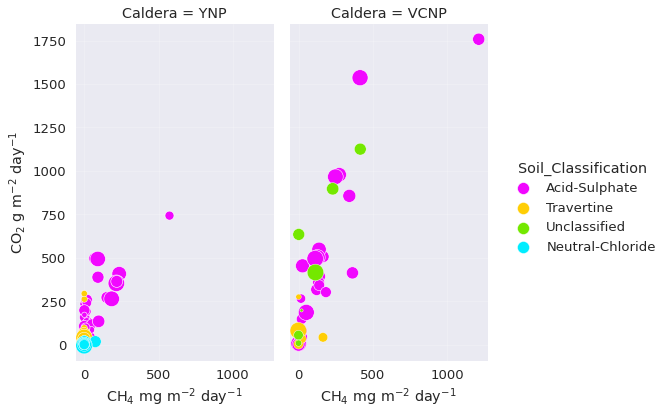

In [ ]:
# CO2 FLux v CH4 Flux at both calderas
fg = sns.FacetGrid(
    df_all,
    col="Caldera", 
    height=6, 
    aspect=0.6,
    hue="Soil_Classification", 
    legend_out=True,
    palette="gist_ncar_r",
    sharex=True,
    sharey=True
  )
fg.map_dataframe(
    sns.scatterplot, 
    x="CH4_Flux", 
    y="CO2_Flux",
    size="Soil_Tempeature_at_Surface", 
    sizes=(10,275),
    markers=markers_4,
    legend="brief"
  )
fg.set(xlabel="CH$_4$ mg m$^{-2}$ day$^{-1}$",
       ylabel="CO$_2$ g m$^{-2}$ day$^{-1}$")
fg.add_legend()
fg.tight_layout()
plt.savefig("../../figures/all_CO2vCH4_flx_soiltype.png", dpi=300)

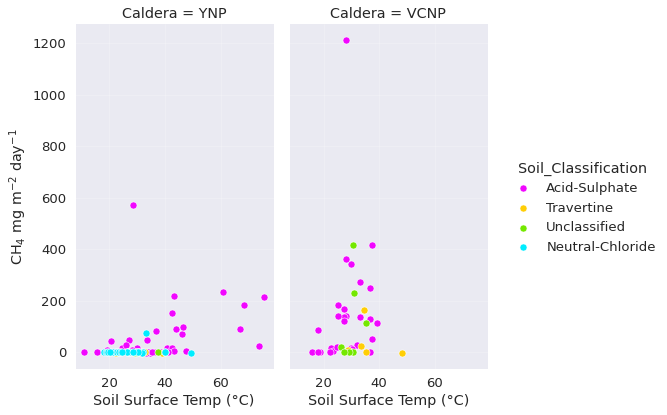

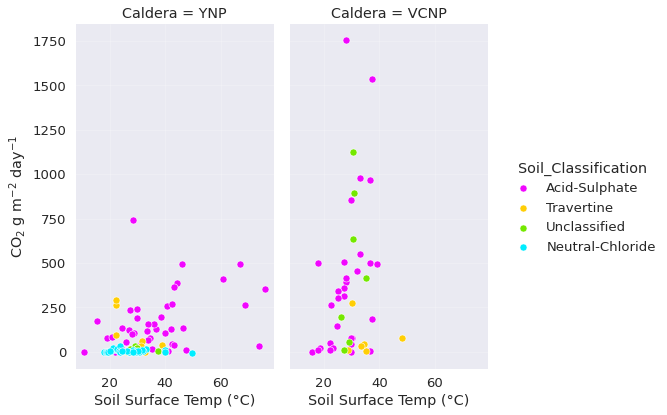

In [ ]:
# CH4 Flux v Soil Temp
fg = sns.FacetGrid(df_all,
                   col="Caldera", height=6, aspect=0.6,
                   hue="Soil_Classification", legend_out=True,
                   palette="gist_ncar_r",
                   sharex=True,sharey=True)
fg.map_dataframe(sns.scatterplot,
                 s=50,
                 markers=markers_4,
                 x="Soil_Tempeature_at_Surface", y="CH4_Flux",
                 legend="brief")
fg.set(xlabel="Soil Surface Temp (°C)",
       ylabel="CH$_4$ mg m$^{-2}$ day$^{-1}$")
fg.add_legend()
fg.tight_layout()
plt.savefig("../../figures/all_CH4_flx_soiltemp_caldera.png", dpi=300)

# CO2 Flux v Soil Temp
fg = sns.FacetGrid(df_all,
                   col="Caldera", height=6, aspect=0.6,
                   hue="Soil_Classification", legend_out=True,
                   palette="gist_ncar_r",
                   sharex=True,sharey=True)
fg.map_dataframe(sns.scatterplot, 
                 s=50,
                 markers=markers_4,
                 x="Soil_Tempeature_at_Surface", y="CO2_Flux",
                 legend="brief")
fg.set(xlabel="Soil Surface Temp (°C)",
       ylabel="CO$_2$ g m$^{-2}$ day$^{-1}$")
fg.add_legend()
fg.tight_layout()
plt.savefig("../../figures/all_CO2_flx_soiltemp_caldera.png", dpi=300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

<Figure size 432x288 with 0 Axes>

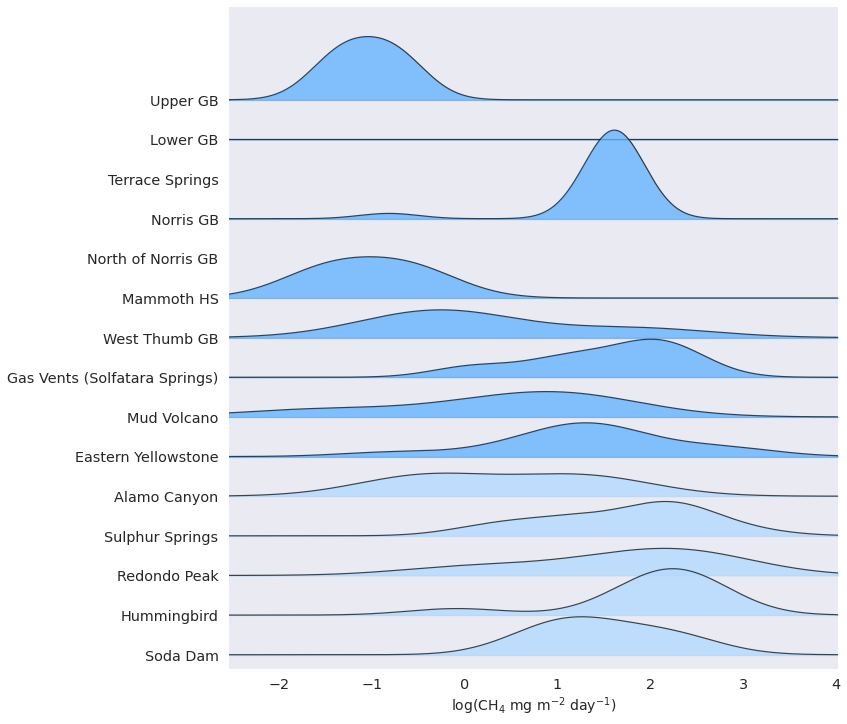

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

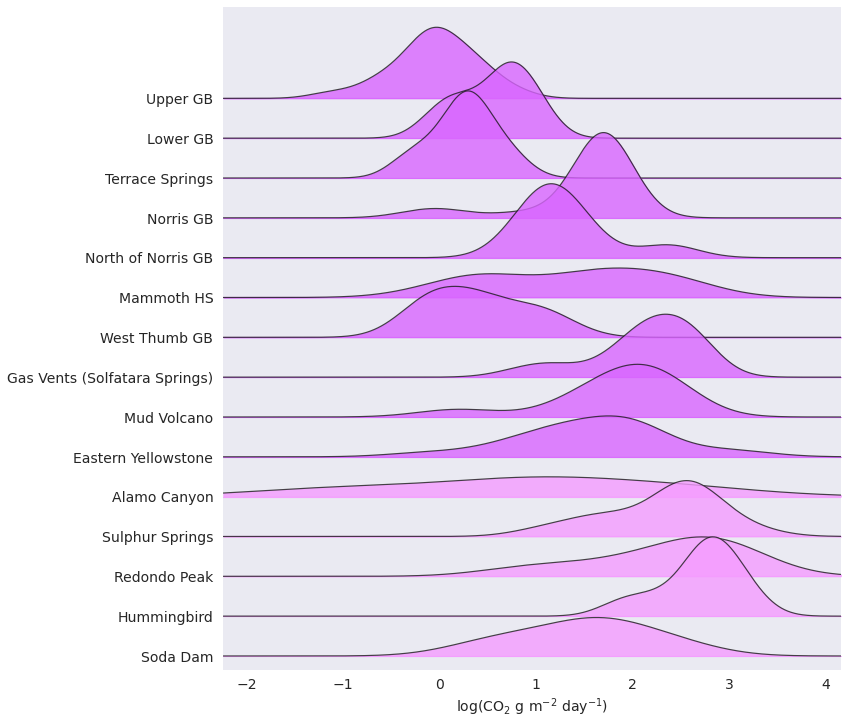

<Figure size 432x288 with 0 Axes>

In [ ]:
# Make Ridgeline Plot for Fluxes
# Order the groups from west to east
df_all["Group"] = df_all["Group"].astype("category")
df_all["Group"].cat.reorder_categories(ordered_groups_all, ordered=True,
                                       inplace=True)

## Log fluxes
df_all_log = df_all[["Group", "Location", "Soil_Classification",
                     "CH4_Flux","CO2_Flux"]]
df_all_log["CH4_Flux"] = np.log10(df_all_log["CH4_Flux"])
df_all_log["CO2_Flux"] = np.log10(df_all_log["CO2_Flux"])

## CH4
plt.figure()
joyplot(
    data=df_all_log[["CH4_Flux", "Group"]],
    by="Group", 
    alpha=0.8,
    color=[
        CH4_color1, CH4_color1, CH4_color1,
        CH4_color1, CH4_color1, CH4_color1,
        CH4_color1, CH4_color1, CH4_color1,
        CH4_color1,
        CH4_color2, CH4_color2, CH4_color2,
        CH4_color2, CH4_color2
      ],
    kind="kde",
    figsize=(12,10)
  )
plt.xlabel("log(CH$_4$ mg m$^{-2}$ day$^{-1}$)", fontsize=14)
plt.rcParams.update({'font.size': 14})
plt.show()
plt.savefig("../../figures/all_CH4_flx_ridge.png", dpi=300)

## CO2
plt.figure()
joyplot(data=df_all_log[["CO2_Flux", "Group"]],
        by="Group", alpha=0.8, 
        color=[CO2_color1, CO2_color1, CO2_color1,
               CO2_color1, CO2_color1, CO2_color1,
               CO2_color1, CO2_color1, CO2_color1,
               CO2_color1,
               CO2_color2, CO2_color2, CO2_color2,
               CO2_color2, CO2_color2],
        figsize=(12,10))
plt.xlabel("log(CO$_2$ g m$^{-2}$ day$^{-1}$)", fontsize=14)
plt.rcParams.update({'font.size': 14})
plt.show()
plt.savefig("../../figures/all_CO2_flx_ridge.png", dpi=300)

Ridgeline plot Figure: Ridgeline plot of CH<sub>4</sub> (left) and CO<sub>2 </sub>(right) fluxes at both calderas. The groups and caldera designations follow the description in (Figure 1). Only fluxes greater than zero are shown, sites where a ridgeplot is absent indicates all measurements were below zero. Note: the scale of the x-axis for both plots is logged. 

The ridgline plots demonstrate the distribution of fluxes that are greater than zero at each site. For CH<sub>4</sub>, the fluxes exhibit broad ranges in log space, highlighting a wide range of over several orders of magnitude at several of the sites. Contrasting this generalization are sites near the western portion of YNP. Upper GB and Mammoth HS both show narrow distributions of low magnitude fluxes. Lower GB, Terrace Springs, and North of Norris fluxes show primarily non-existant distributions because all or very few measurements were greater than zero. 

However, starting at West Thumb (WTHB) and moving east through YNP, the distributions are wider and center near greater magnitudes than the other western YNP locations. The wide distribution at WTHB differs from GVNT, Mud Volcano (MDVC), and Eastern Yellowstone because it skews right indicating the densest portion of the distribution lies near lower fluxes (< 1 mg m<sup>-2</sup> day<sup>-1</sup>) but some lager fluxes can be found in the tail. The mirror image of WTHB can be found at GVNT, where the left skew shows a high number of measurements to the right of the center of the distribution. For MDVC and Eastern Yellowstone, skew is not a signficant characteristic  of the distributions as they illustrate a wide array of values of great magnitude. 

At VCNP, the distribution of CH<sub>4</sub> fluxes became narrower from the north end at Alamo Canyon (VCAC) southward toward Soda Dam (VCSD). The narrowest distribution of fluxes occured at Hummingbird (VCHB) also coincides with the highest median CH<sub>4</sub> flux measurement (137.82 mg m<sup>-2</sup> day<sup>-1</sup>, n =9) calcualted at all sites at VCNP and YNP. The narrowness of the distribution is what makes VCHB unique among VCNP measurements because Redondo Peak (VCRP, 20.06 mg m<sup>-2</sup>, n = 7) and VCSS (121.88 mg m<sup>-2</sup>, n = 17) retain similar medians. However, with narrow distribution, VCHB is believed to be a more homogeneous producer of CH<sub>4</sub>. 

In [ ]:
df_all_log.groupby(by=["Group"]).count()

Location  Soil_Classification  CH4_Flux  \
Group                                                                    
Upper GB                             27                   27         2   
Lower GB                              9                    9         1   
Terrace Springs                       6                    6         0   
Norris GB                            21                   21        18   
North of Norris GB                    8                    8         0   
Mammoth HS                           17                   17         2   
West Thumb GB                        11                   11         4   
Gas Vents (Solfatara Springs)        22                   22        19   
Mud Volcano                          10                   10         5   
Eastern Yellowstone                  23                   23        12   
Alamo Canyon                          9                    9         4   
Sulphur Springs                      17                   17        17   
Redondo Peak                          7                    7         5   
Hummingbird                           9                    9         9   
Soda Dam                              6                    6         3   

                               CO2_Flux  
Group                                    
Upper GB                             26  
Lower GB                              9  
Terrace Springs                       6  
Norris GB                            20  
North of Norris GB                    8  
Mammoth HS                           16  
West Thumb GB                        10  
Gas Vents (Solfatara Springs)        21  
Mud Volcano                          10  
Eastern Yellowstone                  23  
Alamo Canyon                          8  
Sulphur Springs                      17  
Redondo Peak                          7  
Hummingbird                           9  
Soda Dam                              6

CO<sub>2</sub> fluxes at YNP 

Viewing the distribution of all fluxes (both less than and greater than zero) at the individual site level (Supplementary Figure ##) on a linear scale reveals several sites with slightly bimodal distributions. For example, the distribution of CH<sub>4</sub> and CO<sub>2</sub> fluxes at MDVC shows one peak centered near zero and a second peak of a lower density centered near 15 mg CH<sub>4</sub> m<sup>-2</sup> day<sup>-1</sup> and 180 g CO<sub>2</sub> m<sup>-2</sup> day<sup>-1</sup>. These bimodal distributions underscore how many fluxes of the diffuse gases will be reported near near but there will be a smaller amount of fluxes at much greater magnitudes. 

<Figure size 432x288 with 0 Axes>

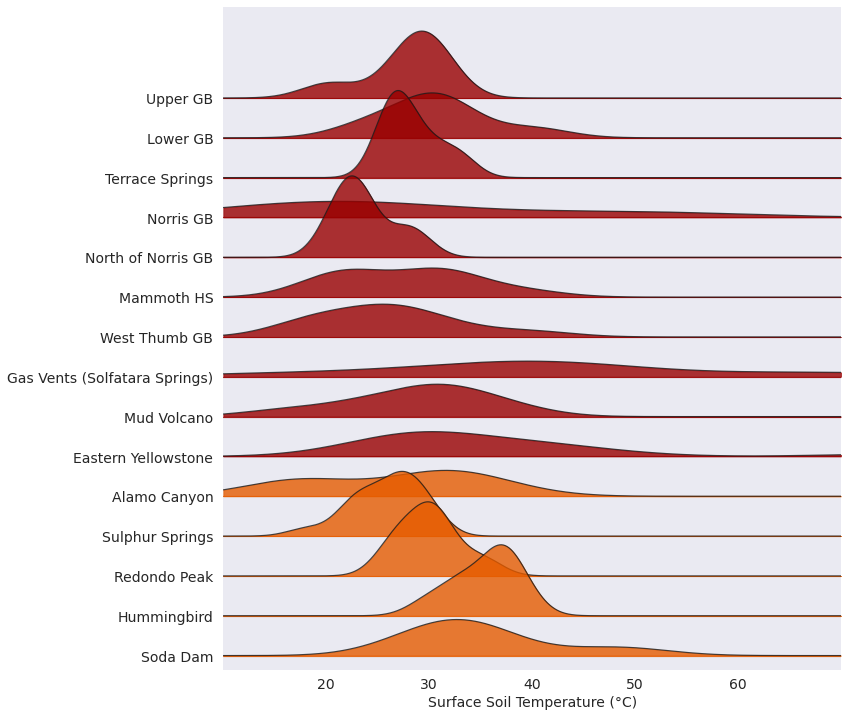

<Figure size 432x288 with 0 Axes>

In [ ]:
# Soil Tempterature Ride Line plot for Valles and Yellowstone
# CH4
plt.figure()
joyplot(
    data=df_all[["Soil_Tempeature_at_Surface", "Caldera", "Group"]],
    by="Group", alpha=0.8, x_range=(10,70),
    color=[
        "#990000", "#990000", "#990000",
        "#990000", "#990000", "#990000",
        "#990000", "#990000", "#990000",
        "#990000",
        "#e65c00", "#e65c00", "#e65c00",
        "#e65c00", "#e65c00"
      ],
      figsize=(12,10)
    )
plt.xlabel("Surface Soil Temperature (°C)", fontsize=14)
plt.rcParams.update({'font.size': 14})
plt.show()
plt.savefig("../../figures/all_soil-temp_ridge.png", dpi=300)

Scatterplot | Fluxes vs. Soil Temperature

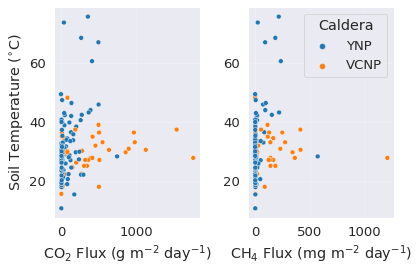

In [ ]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(
    data=df_all,
    x="CH4_Flux",
    y="Soil_Tempeature_at_Surface",
    hue="Caldera",
    ax=ax[1]
)
ax[1].set_xlabel("CH$_{4}$ Flux (mg m$^{-2}$ day$^{-1}$)")
ax[1].set_ylabel("")


sns.scatterplot(
    data=df_all,
    x="CO2_Flux",
    y="Soil_Tempeature_at_Surface",
    hue="Caldera",
    ax=ax[0]
)
ax[0].set_ylabel("Soil Temperature ($^{\circ}$C)")
ax[0].set_xlabel("CO$_{2}$ Flux (g m$^{-2}$ day$^{-1}$)")
ax[0].get_legend().remove()

plt.tight_layout()
plt.show()


#### Graphical Statistical Analysis of Fluxes

##### Assess the Distribution of Fluxes
With the distribution of fluxes visualized, is time to assess which distribution(s) are likely to represent the data. This was accomplished by using the maximum liklihood estimator (MLE) to find the appropriate parameter(s) from several distrubutions (beta, gamma, loggamma, lognormal, normal, pareto, pearson, powerlaw, and weibull). Once the parameters are estimated, the Kolmogrov-Smironov test is used to assess the goodness-of-fit that the estimated parameters to the observed data. 

In [ ]:
# Trim data to only include non-NaN values
df_all_flx_pos_only = df_all[(df_all["CH4_Flux"] >= 0) |
                         (df_all["CO2_Flux"] >= 0)]

flx_pos_only_loss = perc_diff(df_all_flx_pos_only.shape[0], df_all.shape[0])
### Report the percentage of lost fluxes
print("{:.1f}% of fluxes were lost when values less than zero were removed".format(flx_pos_only_loss))

2.5% of fluxes were lost when values less than zero were removed


In [ ]:
# CH4
dist_fit_CH4_flx = assess_fit_params(df_all_flx_pos_only["CH4_Flux"])
dist_fit_CH4_flx

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastruc

distribution     statistic        p_value
0        burr12  1.936009e-01   6.077406e-07
1      invgamma  2.345319e-01   5.156286e-10
2    genextreme  2.357087e-01   4.120725e-10
3       lognorm  2.516349e-01   1.765075e-11
4             t  2.519482e-01   1.655403e-11
5   weibull_min  2.678269e-01   5.735873e-13
6          chi2  2.691201e-01   4.320075e-13
7        pareto  2.864399e-01   8.421486e-15
8      pearson3  2.876289e-01   6.364712e-15
9      powerlaw  3.091039e-01   3.261161e-17
10  genlogistic  3.154946e-01   6.266918e-18
11         beta  3.174234e-01   3.781785e-18
12         norm  3.422460e-01   4.193540e-21
13      maxwell  3.424821e-01   3.920006e-21
14     loggamma  3.608903e-01   1.734424e-23
15     rayleigh  3.646482e-01   5.513574e-24
16         fisk  3.973241e-01   1.456850e-28
17    genpareto  4.164773e-01   1.846334e-31
18     genexpon  4.811060e-01   1.811433e-42
19        expon  4.826614e-01   9.302139e-43
20        gamma  9.766422e-01  7.608611e-322
21     vonmises  4.946771e+30   0.000000e+00

In [ ]:
# CO2
## Critival Value at 0.05 Significance
crit_val = 1.35810 / np.sqrt(df_YC_flx_pos_only.shape[0])
print("The critical value of the KS test for a sample size {} is {}"\
      .format(df_YC_flx_pos_only.shape[0],crit_val))
## Analze potential distribution fits
dist_fit_CO2_flx = assess_fit_params(df_YC_flx_pos_only["CO2_Flux"])
dist_fit_CO2_flx

The critical value of the KS test for a sample size 150 is 0.11088840065579449


/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastruc

distribution     statistic       p_value
0   weibull_min  1.025658e-01  7.933771e-02
1       lognorm  1.076003e-01  5.750090e-02
2         gamma  1.152746e-01  3.417235e-02
3          beta  1.220778e-01  2.090642e-02
4    genextreme  1.228166e-01  1.978641e-02
5        pareto  1.386730e-01  5.599282e-03
6      invgamma  1.389393e-01  5.474580e-03
7        burr12  1.453759e-01  3.134778e-03
8      pearson3  1.830891e-01  7.136579e-05
9          chi2  1.948296e-01  1.833715e-05
10  genlogistic  2.156168e-01  1.335330e-06
11     powerlaw  2.623827e-01  1.333916e-09
12      maxwell  3.080826e-01  3.866465e-13
13         norm  3.107843e-01  2.285244e-13
14         fisk  3.128834e-01  1.513522e-13
15     genexpon  3.223815e-01  2.258115e-14
16        expon  3.224100e-01  2.245038e-14
17    genpareto  3.258132e-01  1.118230e-14
18     rayleigh  3.304278e-01  4.290309e-15
19     loggamma  3.328392e-01  2.585199e-15
20            t  3.592680e-01  7.657257e-18
21     vonmises  1.115916e+31  0.000000e+00

The results show that the data for the fluxes of both gases across YNP are appropriately fitted by a lognormal distribution. A [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) is part of the exponential family of distributions 

##### Assess the different flux groups through probability plots

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


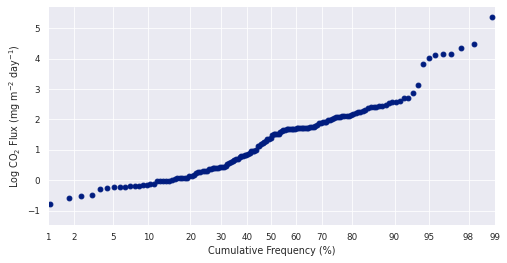

In [ ]:
# Log Flux vs Cumulative Frequency

# Establish Figure Size
fig, ax = plt.subplots(figsize=(8,4))
# Probability Plot
probscale.probplot(np.log10(df_YC_flx_pos_only.CO2_Flux), ax=ax,
                   datascale="linear", probax="x")
# Pop A
'''
cum_frequency = np.arange(1, 100, step=1, dtype=int)
sns.lineplot(x=cum_frequency,
             y=(cum_frequency/0.18)*100,
             dashes=True,
             ax=ax)
'''
# Pop B
#sns.lineplot()
# Pop C
#sns.lineplot()
ax.set_xlim(left=1, right=99)
ax.set(xlabel="Cumulative Frequency (%)",
       ylabel="Log CO$_2$ Flux (mg m$^{-2}$ day$^{-1}$)")
sns.despine(fig=fig)

In [ ]:
li = ax.lines[0]
li = li.get_xydata()
df = pd.DataFrame(li, columns=["Cumulative_Freq", "Flux"])
df = df[df["Flux"] >= 0]
df.reset_index(drop=True, inplace=True)
df.head()

Cumulative_Freq      Flux
0        15.046605  0.015612
1        15.712383  0.049732
2        16.378162  0.071571
3        17.043941  0.077138
4        17.709720  0.082713

Now, let's visualize the carbon isotopes. We will do this within the landscape of associated fluxes through a scatter plot.

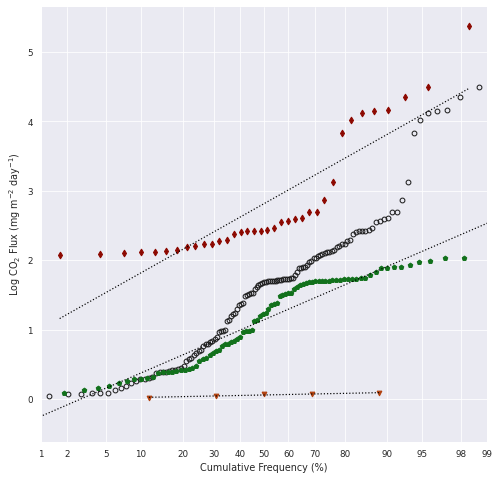

In [ ]:
df_low = df[df["Cumulative_Freq"] <= 18]
df_mod = df[(df["Cumulative_Freq"] >  18) & (df["Cumulative_Freq"] <= 75)]
df_high= df[(df["Cumulative_Freq"] >  75) & (df["Cumulative_Freq"] <= 100)]

# Establish Figure Size
fig, ax = plt.subplots(figsize=(8,8))
## Probability Plot - Main
probscale.probplot(df.Flux, ax=ax,
                   datascale="linear", probax="x",
                   bestfit=False, estimate_ci=False,
                   scatter_kws=dict(marker="o", fillstyle="none", mec="k"),
                   line_kws=dict(color="black", linestyle="dotted"))
## Probability Plot - A
probscale.probplot(df_low.Flux, ax=ax,
                   datascale="linear", probax="x",
                   bestfit=True, estimate_ci=False,
                   scatter_kws=dict(marker="v"),
                   line_kws=dict(color="black", linestyle="dotted"))
## Probability Plot - B
probscale.probplot(df_mod.Flux, ax=ax,
                   datascale="linear", probax="x",
                   bestfit=True, estimate_ci=False,
                   scatter_kws=dict(marker="p"),
                   line_kws=dict(color="black", linestyle="dotted"))
## Probability Plot - C
probscale.probplot(df_high.Flux, ax=ax,
                   datascale="linear", probax="x",
                   bestfit=True, estimate_ci=False,
                   scatter_kws=dict(marker="d"),
                   line_kws=dict(color="black", linestyle="dotted"))
ax.set_xlim(left=1, right=99)
ax.set(xlabel="Cumulative Frequency (%)",
       ylabel="Log CO$_2$ Flux (mg m$^{-2}$ day$^{-1}$)")
sns.despine(fig=fig)
plt.savefig("../../figures/GSA_CO2_Flux.png", dpi=300)

Figure ##: Flux partitioning of CO<sub>2</sub> gases across YNP using graphical statistical analysis (GSA), also called "probability plot", methods described originally by Sinclair (1974) and adapted by Chiodini et al. (1998) and later by Wen et al. (2016). Here the fluxes measured across the park using the CRDS-AC equipment shows there are roughly three populations of measurements: low (i.e., sinter capped), moderate (i.e., fractured sinter and porous soil), and high (i.e., “sinter-less”, highly porous soil).  


In [ ]:
# Descriptive Stats for each flux popoulation
print(np.power(10, df_low["Flux"]).describe())
print(np.power(10, df_mod["Flux"].describe()))
print(np.power(10, df_high["Flux"].describe()))

count      25.000000
mean      461.286908
std       315.500495
min        75.739422
25%       156.536421
50%       489.595421
75%       617.223211
max      1050.275764
Name: Flux, dtype: float64
count    1.000000e+81
mean     1.227966e+04
std      3.815966e+00
min      1.051731e+03
25%      3.583799e+03
50%      1.145646e+04
75%      4.842366e+04
max      9.022860e+04
Name: Flux, dtype: float64
count    1.000000e+30
mean     1.680408e+05
std      1.495472e+00
min      9.448964e+04
25%      1.217358e+05
50%      1.659463e+05
75%      2.002679e+05
max      4.228520e+05
Name: Flux, dtype: float64


The GSA partitions the fluxes measured across YNP into three different populations as described in Figure ##. The low flux (sinter capped) areas show that the minimum value of fluxes in this area are 1 and 3 orders of magnitude less than the moderate (fractured sinter and porous soil) and high (sinter-free highly porous soil) areas, respectively. Furthermore, the mean values of the low, moderate, and high flux areas are 461 ± 316, 12280 ± 38, and 168089 ± 15 mg CO<sub>2</sub> m<sup>-2</sup> day<sup>-1</sup>. There also appears to be a celing  or a maximum value of approximately 50000 mg CO<sub>2</sub> m<sup>-2</sup> day<sup>-1</sup> present in the moderate flux population suggesting that there is possibly increased advection or another mechanism that aids the increased fluxes observed within the high flux population.

### Differences in Fluxes between Soil Chemistry Groups
In this section, we compute the statistical relationships between the measureed fluxes across with the soil chemistry groups being the dependent variable. 

The process begins by testing the groups of interest, in this case, fluxes sorted by soil chemistry, for normality to understand if we can apply tests for normality or if we must use non-parametric tests.

#### KS Test
The [Komologorov-Smirnov](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.kstest_normal.html) (KS) is an effective method for quantifying the distance between the empirical distribution and the cumulative distribution of the reference (i.e., normal) function. The null hypothesis of the KS test is that the sample being analyzed is drawn for the reference distribution.

> `gb_sclf` = group by soil chemistry classification \
> Returns a list of dataframes, where each item in the list is a dataframe of samples collected and organized by the same soil classification and caldera.

In [ ]:
# Separate data into fluxes by soil chemistry
## YNP
gb_sclf_YC = df_YC_all.groupby(by=["Soil_Classification"])
gb_sclf_YC = [gb_sclf_YC.get_group(x) for x in gb_sclf_YC.groups]
## VCNP
gb_sclf_VC = df_VC_all.groupby(by=["Soil_Classification"])
gb_sclf_VC = [gb_sclf_VC.get_group(x) for x in gb_sclf_VC.groups]

> `KS_rslts_sclf_flux` = KS test results from the soil chemistry flux

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "ks_stat_CH4",
        "pval_CH4",
        "ks_stat_CO2", 
        "pval_CO2"
      ],
    index=range(4)
  )

# Loop through each soil type and check for normality
for i in range(4):
  #---YNP---#
  # Gather Soil Classification
  df_KS_rslts_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_YC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_rslts_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_YC[i].Caldera.iloc[0]
  # Run KS Test - CH4
  ks_stat, pval = kstest_normal(gb_sclf_YC[i].CH4_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_sclf_flux_YC.loc[i]["ks_stat_CH4"] = ks_stat
  ## pval
  df_KS_rslts_sclf_flux_YC.loc[i]["pval_CH4"] = pval
  # Run KS Test - CO2
  ks_stat, pval = kstest_normal(gb_sclf_YC[i].CO2_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_sclf_flux_YC.loc[i]["ks_stat_CO2"] = ks_stat
  ## pval
  df_KS_rslts_sclf_flux_YC.loc[i]["pval_CO2"] = pval

# export results to `.csv`
df_KS_rslts_sclf_flux_YC.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/ks_results_sclf_yc.csv",
    index=False
)

# view results
df_KS_rslts_sclf_flux_YC

Soil_Classification Caldera ks_stat_CH4  pval_CH4 ks_stat_CO2  pval_CO2
0       Acid-Sulphate     YNP    0.308983     0.001    0.215611     0.001
1    Neutral-Chloride     YNP    0.437927     0.001    0.281113     0.001
2          Travertine     YNP    0.227667  0.003407    0.304706     0.001
3        Unclassified     YNP    0.192082  0.522885    0.152841  0.836063

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_sclf_flux_VC = pd.DataFrame(
    columns=[
        "Soil_Classification", 
        "Caldera",
        "ks_stat_CH4", 
        "pval_CH4",
        "ks_stat_CO2", 
        "pval_CO2"
      ],
      index=range(3)
    )

# Loop through each soil type and check for normality
for i in range(3):
  #---VCNP---#
  # Gather Soil Classification
  df_KS_rslts_sclf_flux_VC.loc[i]["Soil_Classification"] = \
  gb_sclf_VC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_rslts_sclf_flux_VC.loc[i]["Caldera"] = \
  gb_sclf_VC[i].Caldera.iloc[0]
  # Run KS Test - CH4
  ks_stat, pval = kstest_normal(gb_sclf_VC[i].CH4_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_sclf_flux_VC.loc[i]["ks_stat_CH4"] = ks_stat
  ## pval
  df_KS_rslts_sclf_flux_VC.loc[i]["pval_CH4"] = pval
  # Run KS Test - CO2
  ks_stat, pval = kstest_normal(gb_sclf_VC[i].CO2_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_sclf_flux_VC.loc[i]["ks_stat_CO2"] = ks_stat
  ## pval
  df_KS_rslts_sclf_flux_VC.loc[i]["pval_CO2"] = pval

# export results to a `.csv`
df_KS_rslts_sclf_flux_VC.to_csv(
    "../../pertinent-data/inferential-stats-output/valles/ks_results_sclf_vc.csv",
    index=False
)

# view results
df_KS_rslts_sclf_flux_VC

Soil_Classification Caldera ks_stat_CH4  pval_CH4 ks_stat_CO2  pval_CO2
0       Acid-Sulphate    VCNP    0.271671     0.001    0.184906  0.005046
1          Travertine    VCNP    0.390805  0.004485     0.30737  0.077072
2        Unclassified    VCNP    0.288108  0.081212    0.171176  0.771733

The KS test for normality of the CH<sub>4</sub> fluxes at YNP shows that each subset is nonnormal due to $p ≤ 0.005$, thereby rejected the null hypothesis. The unclassified group is the exception ($p ≥ 0.38$). This group represents measurements collected at NEER, where gas collections were made on altered soil but not visible thermal activity or nearby. It is expected that data collected at NEER serves as a background measurement for data collected on altyered soil but without active or recent thermal input. 

For CO<sub>2</sub> fluxes, the KS tests showed similar findings. Each soil chemistry class is nonnormal ($p ≤ 0.0001$) except for the unclassified set of measurements ($p = 0.2$).

At VCNP, only three soil chemistry classes were assessed, acid-sulphate, travertine, and neutral-chloride. The KS test reveals that the CH<sub>4</sub> fluxes are all nonnormal ($p ≤ 0.005$) except for the unclassified group ($p=0.2%+$). Unlike YNP, the unclasified group at VCNP consits of measurements collected at VCRP and VCHB, with the latter being the slight majority comprising 57% of unclassified group. 

The  CO<sub>2</sub> fluxes at VCNP showed all nonnormal datasets across the soil chemistry classes with all groups with $p ≤ 0.0001$.

#### FK Test

Following the KS tests, we test for equality of variance (i.e., homogenous variance) using the [Fligner-Killeen (FK) test](https://www.geeksforgeeks.org/fligner-killeen-test-in-r-programming). The null hypothesis for this test is that the samples are drawn from populations with the same variance. The FK test was chosen because many of the fluxes in these groups vary significantly. From earliter, the medians are often reported because large outliers are present without a pattern. This test for homoscedasticity centers the data on the median rather than mean, which provides for more robustness for nonnormal data, which the KS test demonstrated was exisisten in almost all groups (Fligner & Killeen, 1976). Further similations with offshore oil permit bids showed that the FK test performed robustly with departures from normality and power (Conover et al., 1981).

Yellowstone FK test

In [ ]:
# Test YNP 
## CH4
fk_stat_ch4, pval_ch4 = fligner(
    gb_sclf_YC[0].CH4_Flux, 
    gb_sclf_YC[1].CH4_Flux,
    gb_sclf_YC[2].CH4_Flux, 
    gb_sclf_YC[3].CH4_Flux
  )
print("After applying the FK test to the YNP CH4 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}\n".format(fk_stat_ch4, pval_ch4))
## CO2
fk_stat_co2, pval_co2 = fligner(
    gb_sclf_YC[0].CO2_Flux, 
    gb_sclf_YC[1].CO2_Flux,
    gb_sclf_YC[2].CO2_Flux, 
    gb_sclf_YC[3].CO2_Flux
  )
print("After applying the FK test to the YNP CO2 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}\n".format(fk_stat_co2, pval_co2))

# consolidate results into a dataframe
df_FK_rslts_sclf_flux_yc = pd.DataFrame(
    {
      "fk_stat_ch4":fk_stat_ch4,
      "pval_ch4":pval_ch4,
      "fk_stat_co2":fk_stat_co2,
      "pval_co2":pval_co2
    },
    index=range(1)
)

# export results to a `.csv`
df_FK_rslts_sclf_flux_yc.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/fk_results_sclf_yc.csv",
    index=False
)

After applying the FK test to the YNP CH4 Flux data, 
the FK stat is 48.84 and the p-value is 1.411e-10

After applying the FK test to the YNP CO2 Flux data, 
the FK stat is 55.86 and the p-value is 4.497e-12



Valles Caldera FK test

In [ ]:
# Test VCNP 
## CH4
fk_stat_ch4, pval_ch4 = fligner(
    gb_sclf_VC[0].CH4_Flux, 
    gb_sclf_VC[1].CH4_Flux,
    gb_sclf_VC[2].CH4_Flux
  )
print("After applying the FK test to the VCNP CH4 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}\n".format(fk_stat_ch4, pval_ch4))
## CO2
fk_stat_co2, pval_co2 = fligner(
    gb_sclf_VC[0].CO2_Flux, 
    gb_sclf_VC[1].CO2_Flux,
    gb_sclf_VC[2].CO2_Flux
  )
print("After applying the FK test to the VCNP CO2 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}\n".format(fk_stat_co2, pval_co2))

# consolidate results into a dataframe
df_FK_rslts_sclf_flux_vc = pd.DataFrame(
    {
      "fk_stat_ch4":fk_stat_ch4,
      "pval_ch4":pval_ch4,
      "fk_stat_co2":fk_stat_co2,
      "pval_co2":pval_co2
    },
    index=range(1)
)

# export results to a `.csv`
df_FK_rslts_sclf_flux_yc.to_csv(
    "../../pertinent-data/inferential-stats-output/valles/fk_results_sclf_vc.csv",
    index=False
)

After applying the FK test to the VCNP CH4 Flux data, 
the FK stat is 20.16 and the p-value is 4.187e-05

After applying the FK test to the VCNP CO2 Flux data, 
the FK stat is 20.19 and the p-value is 4.121e-05



~Levene test for unequal variance, an alternative not used to the FK test~

In [ ]:
# # Import Levene's test for unequal variance from `scipy` module
# from scipy.stats import levene

# # Test VCNP 
# ## CH4
# lev_stat, pval = levene(gb_scls_YC[0].CH4_Flux, gb_scls_YC[1].CH4_Flux,
#                         gb_scls_YC[2].CH4_Flux, gb_scls_YC[3].CH4_Flux, 
#                         center="median")
# print("After applying the Levene test to the YNP CH4 Flux data, \nthe Levene stat is {:.2f} and the p-value is {:.3e}".format(lev_stat, pval))
# ## CO2
# lev_stat, pval = levene(gb_scls_YC[0].CO2_Flux, gb_scls_YC[1].CO2_Flux,
#                         gb_scls_YC[2].CO2_Flux, gb_scls_YC[3].CO2_Flux, 
#                         center="median")
# print("After applying the Levene test to the YNP CO2 Flux data, \nthe Levene stat is {:.2f} and the p-value is {:.3e}".format(lev_stat, pval))

# # Test VCNP 
# ## CH4
# lev_stat, pval = levene(gb_scls_VC[0].CH4_Flux.dropna(), gb_scls_VC[1].CH4_Flux.dropna(),
#                         gb_scls_VC[2].CH4_Flux.dropna(), 
#                         center="median")
# print("After applying the Levene test to the VCNP CH4 Flux data, \nthe Levene stat is {:.2f} and the p-value is {:.3e}".format(lev_stat, pval))
# ## CO2
# lev_stat, pval = levene(gb_scls_VC[0].CO2_Flux.dropna(), gb_scls_VC[1].CO2_Flux.dropna(),
#                         gb_scls_VC[2].CO2_Flux.dropna(), 
#                         center="median")
# print("After applying the Levene test to the VCNP CO2 Flux data, \nthe Levene stat is {:.2f} and the p-value is {:.3e}".format(lev_stat, pval))

The results from the FK test reject the null hypothesis that when organized by soil chemistry class, the Yellowstone CH$_{4}$ ($p ≤ 0.0001$) and CO$_{2}$ ($p ≤ 0.0001$) fluxes are from populations are from equal variance.

Thus, the FK test demonstrates that for both gases, the varaince in flux between each soil chemistry class is not equal and not constant. This means the data has heterogenous variance, underscoring the need to use non-parametric analysis to durther distinguish significant relationships.

#### KW Test

The Kruskal-Wallis (KW) test is a reputable method to assess the difference in the medians across groups. Its null hypothesis states that the medians across all groups are equal to one another, and it can verify if there is a statistical significant difference between the medians if the null is rejected. Similar to ANOVA, it is the non-parametric method for testing differences between medians. Specifically, the medians of the CH<sub>4</sub> and CO<sub>2</sub> fluxes across and between the calderas.

Yellowstone KW test

In [ ]:
# CH4 fluxes across soil chemistry classes at YNP
kw_stat_ch4, pval_ch4 = kruskal(
    gb_sclf_YC[0].CH4_Flux, 
    gb_sclf_YC[1].CH4_Flux,
    gb_sclf_YC[2].CH4_Flux, 
    gb_sclf_YC[3].CH4_Flux,
    nan_policy="omit"
  )
print("After applying the KW test to the YNP CH4 Flux data across soil chemistry \nclasses, the KW stat is {:.2f} and the p-value is {:.3e}".format(kw_stat_ch4, pval_ch4))

# CO2 fluxes across soil chemistry classes at YNP
kw_stat_co2, pval_co2 = kruskal(
    gb_sclf_YC[0].CO2_Flux, 
    gb_sclf_YC[1].CO2_Flux,
    gb_sclf_YC[2].CO2_Flux, 
    gb_sclf_YC[3].CO2_Flux,
    nan_policy="omit"
  )
print("After applying the KW test to the YNP CO2 Flux data across soil chemistry \nclasses, the KW stat is {:.2f} and the p-value is {:.3e}".format(kw_stat_co2, pval_co2))


# consolidate results into a dataframe
df_KW_rslts_sclf_flux_yc = pd.DataFrame(
    {
      "kw_stat_ch4":kw_stat_ch4,
      "pval_ch4":pval_ch4,
      "kw_stat_co2":kw_stat_co2,
      "pval_co2":pval_co2
    },
    index=range(1)
)

# export results to a `.csv`
df_FK_rslts_sclf_flux_yc.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/kw_results_sclf_yc.csv",
    index=False
)

After applying the KW test to the YNP CH4 Flux data across soil chemistry 
classes, the KW stat is 37.50 and the p-value is 3.606e-08
After applying the KW test to the YNP CO2 Flux data across soil chemistry 
classes, the KW stat is 59.03 and the p-value is 9.463e-13


Valles Caldera KW test

In [ ]:
# CH4 fluxes across soil chemistry classes at VCNP
kw_stat_ch4, pval_ch4 = kruskal(
    gb_sclf_VC[0].CH4_Flux, 
    gb_sclf_VC[1].CH4_Flux,
    gb_sclf_VC[2].CH4_Flux,
    nan_policy="omit"
  )
print("After applying the KW test to the VCNP CH4 Flux data across soil chemistry \nclasses, the KW stat is {:.2f} and the p-value is {:.3e}".format(kw_stat_ch4, pval_ch4))

# CO2 fluxes across soil chemistry classes at VCNP
kw_stat_co2, pval_co2 = kruskal(
    gb_sclf_VC[0].CO2_Flux, 
    gb_sclf_VC[1].CO2_Flux,
    gb_sclf_VC[2].CO2_Flux,
    nan_policy="omit"
  )
print("After applying the KW test to the VCNP CO2 Flux data across soil chemistry \nclasses, the KW stat is {:.2f} and the p-value is {:.3e}".format(kw_stat_co2, pval_co2))


# consolidate results into a dataframe
df_KW_rslts_sclf_flux_yc = pd.DataFrame(
    {
      "kw_stat_ch4":kw_stat_ch4,
      "pval_ch4":pval_ch4,
      "kw_stat_co2":kw_stat_co2,
      "pval_co2":pval_co2
    },
    index=range(1)
)

# export results to a `.csv`
df_FK_rslts_sclf_flux_yc.to_csv(
    "../../pertinent-data/inferential-stats-output/valles/kw_results_sclf_vc.csv",
    index=False
)

After applying the KW test to the VCNP CH4 Flux data across soil chemistry 
classes, the KW stat is 2.93 and the p-value is 2.314e-01
After applying the KW test to the VCNP CO2 Flux data across soil chemistry 
classes, the KW stat is 4.82 and the p-value is 8.994e-02


The results from the KW tests reject the null hypothesis that the CH<sub>4</sub> and CO<sub>2</sub> fluxes have equal medians across the soil chemistry classes at YNP ($p ≤ 0.0001$). Similar findings occured when the CO<sub></sub> fluxes were tested at VCNP. The null was rejected indicating at least one group was significantly different than than the others ($p ≤ 0.002$). However, the KW test failed to reject that the medians of CH<sub>4</sub> fluxes at VCNP are equal ($p = 0.14$). 

#### Post-Hoc Analysis

With these results, it is now prudent to assess the relationship between each of these groups to one another. This analysis is called post-hoc analysis, and there are two tests used. There are two methods to conduct this analsysis: 1) [Dunn's](https://www.statology.org/dunns-test/) test and 2) [Conover-Imam](https://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-07677-MS) test. Dunn's test is utilzed most often and can be used whether or not the KW test rejected the null hypothesis. However, the Conover-Imam test leverages [greater statistical power](https://stackoverflow.com/questions/31434166/which-post-hoc-test-should-i-conduct-after-doing-a-kruskal-wallis) in assessing the different groups, when the KW test rejects the null hypothesis. Both are used in this post-hoc analysis.

In [ ]:
# Create a new colormap
# bk_wt_cmap = mcolors.ListedColormap(["#111111", "#F5F5F5"])
bk_wt_cmap = cm.get_cmap('Greys_r', 2)
bk_wt_cmap.set_under("#111111")

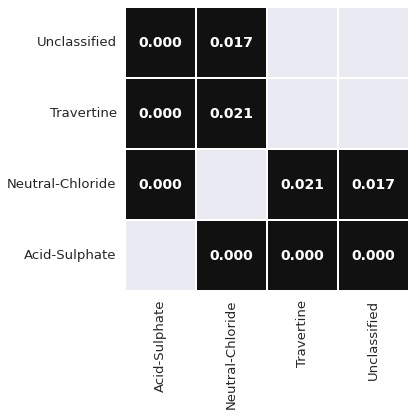

In [ ]:
# Conover-Imam test for CH4 at YNP across soil chemistry classes
## Apply the test to the samples
conover_CH4_sclf_YNP = conover(
    df_YC_all,
    val_col="CH4_Flux", 
    group_col="Soil_Classification",
    p_adjust="bonferroni",
    sort=True
  )

# Create heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    conover_CH4_sclf_YNP, 
    linewidths=0.35, 
    # cmap="Greys_r",
    cmap=bk_wt_cmap,
    vmin=0.05,
    vmax=1.0,
    mask=conover_CH4_sclf_YNP > 0.05,
    square=True, 
    fmt=".3f",
    annot=True, 
    annot_kws={"color":"white", "weight":"bold"},
    cbar=False,
    cbar_kws={"label":"p-value"}
  ) 
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../../figures/conover_CH4_v_soil-class_YNP.png", dpi=300)

Figure: Heatmap for displaying the relationships between the CH<sub>4</sub> fluxes at YNP using the results from the Conovoer-Imam test.  The white squares indicate relations with high ($p \sim 1$). 

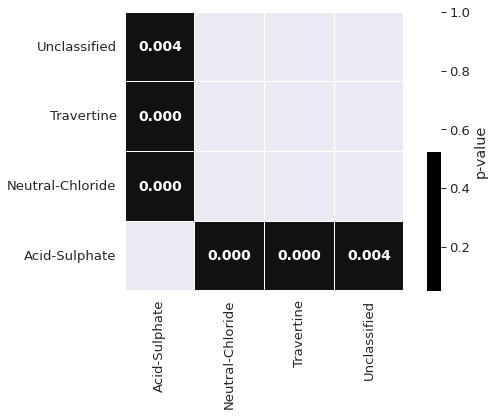

In [ ]:
# Conover-Imam test for CO2 at YNP across soil chemistry classes
## Apply the test to the samples
conover_CO2_scls_YNP = conover(
    df_YC_all,
    val_col="CO2_Flux", 
    group_col="Soil_Classification",
    p_adjust="bonferroni",
    sort=True
  )

# Create heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    conover_CO2_scls_YNP, 
    linewidths=0.35, 
    # cmap="Greys_r",
    cmap=bk_wt_cmap,
    vmin=0.05,
    vmax=1.0,
    mask=conover_CO2_scls_YNP > 0.05,
    square=True, 
    fmt=".3f",
    annot=True, 
    annot_kws={"color":"white", "weight":"bold"},
    cbar_kws={"label":"p-value"}
  ) 
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../../figures/conover_CO2_v_soil-class_YNP.png", dpi=300)

The Conovor-Imam test demonstrates that there are several signifcant relationships between social chemistry classes (Figure ##). The acid-sulphate CH<sub>4</sub> fluxes at proved to be significantly different from every soil chemistry class at YNP. Neutral-chloride is signnificantly different than the travertine and unclassified classes. However, travertine and unclassified do not express any additional significantly different relationships. 

At YNP, the CO<sub>2</sub> fluxes are significantly different between all other soil chemistry classes. Neutral-Chloride and travertine are significantly different from each other, and the unclassified measurements are not significantly different than the other groups except for acid-sulphate. Due to the numerous amount of low fluxes in the nuetral-chloride and travertine locations, distinction from the unclassified was not observed.

In [ ]:
# filter groups where the KW null was rejected
df_VC_kw_reject = df_VC_all[["CH4_Flux", "CO2_Flux", "Soil_Classification"]]
df_VC_kw_reject = df_VC_kw_reject[df_VC_kw_reject["Soil_Classification"]!= "Unclassified"]

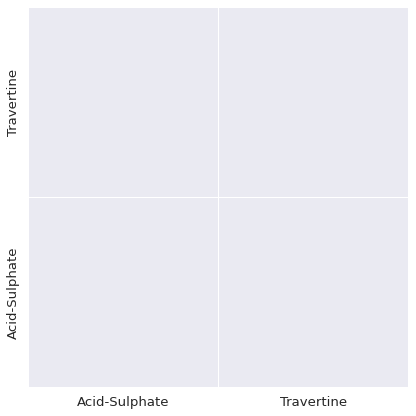

In [ ]:
# Conover-Iman test for CH4 at VC across soil chemistry classes
## Apply the test to the samples
conover_CH4_sclf_VC = conover(
    df_VC_kw_reject,
    val_col="CH4_Flux", 
    group_col="Soil_Classification",
    p_adjust="bonferroni",
    sort=True
  )

# Create heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    conover_CH4_sclf_VC, 
    linewidths=0.35, 
    # cmap="Greys_r",
    cmap=bk_wt_cmap,
    vmin=0.05,
    vmax=1.0,
    mask=conover_CH4_sclf_VC > 0.05,
    square=True, 
    fmt=".3f",
    annot=True, 
    annot_kws={"color":"white", "weight":"bold"},
    cbar=False,
    cbar_kws={"label":"p-value"}
  ) 
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../../figures/conover_CH4_v_soil-class_VC.png", dpi=300)

In [ ]:
conover_CH4_sclf_VC

Acid-Sulphate  Travertine
Acid-Sulphate       1.000000    0.134055
Travertine          0.134055    1.000000

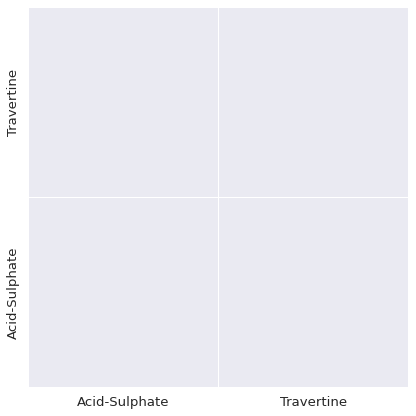

In [ ]:
# Conover-Imam test for CO2 at VC across soil chemistry classes
## Apply the test to the samples
conover_CO2_sclf_VC = conover(
    df_VC_kw_reject,
    val_col="CO2_Flux", 
    group_col="Soil_Classification",
    p_adjust="bonferroni",
    sort=True
  )

# Create heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    conover_CO2_sclf_VC, 
    linewidths=0.35, 
    # cmap="Greys_r",
    cmap=bk_wt_cmap,
    vmin=0.05,
    vmax=1.0,
    mask=conover_CO2_sclf_VC > 0.05,
    square=True, fmt=".3f",
    annot=True, 
    annot_kws={"color":"white", "weight":"bold"},
    cbar=False,
    cbar_kws={"label":"p-value"}
  ) 
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../../figures/conover_CO2_v_soil-class_VC.png", dpi=300)

In [ ]:
conover_CO2_sclf_VC

Acid-Sulphate  Travertine
Acid-Sulphate       1.000000    0.081839
Travertine          0.081839    1.000000

##### Experiment: Using Dunn's test for post-hoc analysis

Dunn's test was applied to the results from VCNP; however, Conover-Iman has greater statistical power and should be used instead where appropriate. 

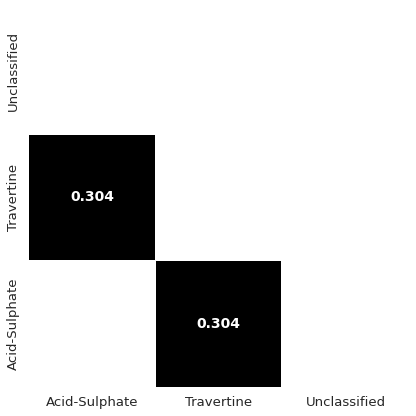

In [ ]:
# Assess the significant differences between groups
## Import the test
from scikit_posthocs import posthoc_dunn as dunn 

# Dunn's test for CO2 at YNP across soil chemistry classes
## Apply the test to the samples
dunn_CH4_scls_YNP = dunn(
    df_VC_all,
    val_col="CH4_Flux",
    group_col="Soil_Classification",
    p_adjust="bonferroni",
    sort=True
  )

# Create heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    dunn_CH4_scls_YNP, 
    linewidths=0.35, 
    # cmap="Greys_r",
    cmap=bk_wt_cmap,
    vmin=0.05,
    vmax=1.0,
    # mask=conover_CO2_sclf_VC > 0.05,
    square=True, 
    fmt=".3f",
    annot=True, 
    annot_kws={"color":"white", "weight":"bold"},
    cbar=False,
    cbar_kws={"label":"p-value"}
  ) 
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../../figures/dunn_CH4_v_soil-class_VCNP.png", dpi=300)

In [ ]:
dunn_CH4_scls_YNP

Acid-Sulphate  Travertine  Unclassified
Acid-Sulphate       1.000000    0.304023           1.0
Travertine          0.304023    1.000000           1.0
Unclassified        1.000000    1.000000           1.0

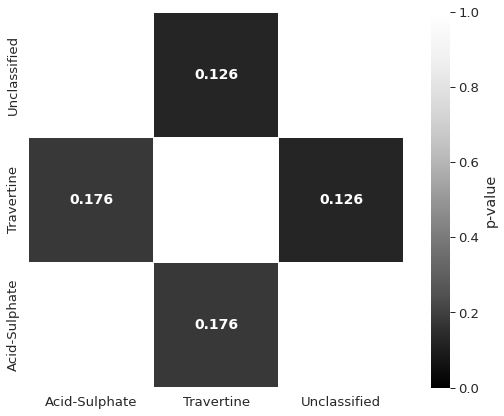

In [ ]:
# Dunn's test for CO2 at YNP across soil chemistry classes
## Apply the test to the samples
dunn_CO2_scls_YNP = \
dunn(df_VC_all,
        val_col="CO2_Flux", group_col="Soil_Classification",
        p_adjust="bonferroni",
        sort=True)

# Create heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(dunn_CO2_scls_YNP, linewidths=0.35, cmap="Greys_r",
                 square=True, fmt=".3f", vmin=0, vmax=1,
                 annot=True, annot_kws={"color":"white", "weight":"bold"},
                 cbar_kws={"label":"p-value"}) 
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../../figures/dunn_CO2_v_soil-class_VCNP.png", dpi=300)

Dunn's test failed to reject the the null hypothesis that the median CH<sub>4</sub> fluxes were equal between all soil chemistry groups at VCNP ($p ≥ 0.174$). However, the results for the CO<sub>2</sub> fluxes showed significant differences between the unclassified group and the acid-sulphate as well as the travertine groups ($p ≤ 0.026$). The acid-sulphate and travertine fluxes were not statistically significant from one another ($p ≥ 0.655$). 

#### Overlapping Distributions of Fluxes by Soil Chemistry Class

In [ ]:
df_YC_all.columns

Index(['Site_Name', 'Group', 'Location', 'Soil_Classification', 'Latitude',
       'Longitude', 'Date_of_Measurement', 'Start_Time_of_Chamber_Enclosure',
       'End_Time_of_Chamber_Enclosure', 'Duration_of_Total_Chamber_Enclosure',
       'Start_Time_Flux', 'End_Time_Flux', 'CH4_Flux', 'LowerBound_CH4_Flux',
       'UpperBound_CH4_Flux', 'KP_d13CH4_source',
       'KP_LowerBound_d13CH4_source', 'KP_UpperBound_d13CH4_source',
       'd13CH4_source', 'd13CH4_LowerBound_source', 'd13CH4_UpperBound_source',
       'CO2_Flux', 'LowerBound_CO2_Flux', 'UpperBound_CO2_Flux',
       'KP_d13CO2_source', 'KP_LowerBound_d13CO2_source',
       'KP_UpperBound_d13CO2_source', 'd13CO2_source',
       'd13CO2_LowerBound_source', 'd13CO2_UpperBound_source',
       'Soil_Tempeature_at_Surface', 'caldera_side', 'Caldera'],
      dtype='object')

Yellowstone

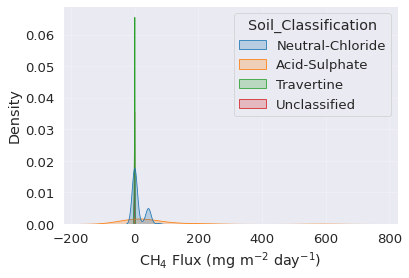

In [ ]:
# ch4 fluxes
fig, ax = plt.subplots()
sns.kdeplot(
    data=df_YC_all,
    x="CH4_Flux",
    hue="Soil_Classification",
    fill=True,
    ax=ax
)

plt.xlabel("CH$_{4}$ Flux (mg m$^{-2}$ day$^{-1}$)")
plt.savefig("../../figures/kde_ch4_flux_YC.png")
plt.show()

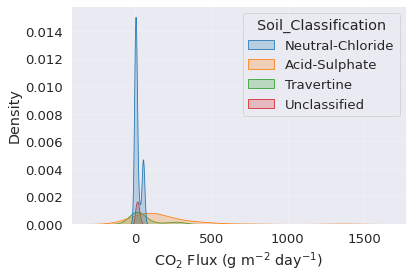

In [ ]:
# co2 fluxes
fig, ax = plt.subplots()
sns.kdeplot(
    data=df_YC_all,
    x="CO2_Flux",
    hue="Soil_Classification",
    fill=True,
    ax=ax
)

plt.xlabel("CO$_{2}$ Flux (g m$^{-2}$ day$^{-1}$)")
plt.savefig("../../figures/kde_co2_flux_YC.png")
plt.show()

Valles

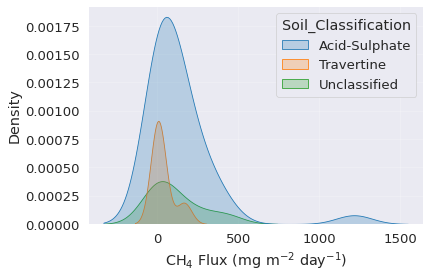

In [ ]:
# ch4 fluxes
fig, ax = plt.subplots()
sns.kdeplot(
    data=df_VC_all,
    x="CH4_Flux",
    hue="Soil_Classification",
    fill=True,
    ax=ax
)

plt.xlabel("CH$_{4}$ Flux (mg m$^{-2}$ day$^{-1}$)")
plt.savefig("../../figures/kde_ch4_flux_VC.png")
plt.show()

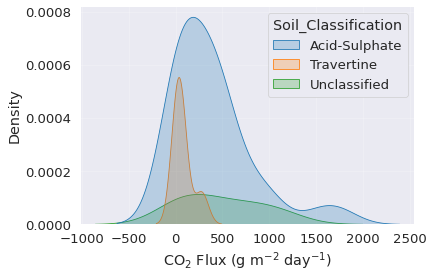

In [ ]:
# co2 fluxes
fig, ax = plt.subplots()
sns.kdeplot(
    data=df_VC_all,
    x="CO2_Flux",
    hue="Soil_Classification",
    fill=True,
    ax=ax
)

plt.xlabel("CO$_{2}$ Flux (g m$^{-2}$ day$^{-1}$)")
plt.savefig("../../figures/kde_co2_flux_VC.png")
plt.show()

### Hypothesis Tests Across Groups

Using a similar workflow as the differentation of fluxes across soil chemistry classes, we now examine the differences between groups within the respective calderas.

Using the information gleaned from quantifying the mean and standard deviation of the fluxes it is possible that one or both gases are displaying non-normal behavior. To test this, we employ Kolmogorov-Smirnov (KS) test for normality.

#### KS Test
Assess the normality of the distributions within each group.

In [ ]:
# Separate data into fluxes by soil chemistry
## YNP
gb_grps_YC = df_YC_all.groupby(by=["Group"])
gb_grps_YC = [gb_grps_YC.get_group(x) for x in gb_grps_YC.groups]
## VCNP
gb_grps_VC = df_VC_all.groupby(by=["Group"])
gb_grps_VC = [gb_grps_VC.get_group(x) for x in gb_grps_VC.groups]

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_grps_flux_YC = \
pd.DataFrame(columns=["Group", "Caldera", "Soil_Classification",
                      "ks_stat_CH4", "pval_CH4",
                      "ks_stat_CO2", "pval_CO2"],
             index=range(10))

# Loop through each soil type and check for normality
for i in range(10):
  #---YNP---#
  # Gather Group
  df_KS_rslts_grps_flux_YC.loc[i]["Group"] = \
  gb_grps_YC[i].Group.iloc[0]
  # Gather Caldera
  df_KS_rslts_grps_flux_YC.loc[i]["Caldera"] = \
  gb_grps_YC[i].Caldera.iloc[0]
  # Gather Soil Classification
  df_KS_rslts_grps_flux_YC.loc[i]["Soil_Classification"] = \
  gb_grps_YC[i].Soil_Classification.iloc[0] 
  # Run KS Test - CH4
  ks_stat, pval = kstest_normal(gb_grps_YC[i].CH4_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_grps_flux_YC.loc[i]["ks_stat_CH4"] = ks_stat
  ## pval
  df_KS_rslts_grps_flux_YC.loc[i]["pval_CH4"] = pval
  # Run KS Test - CO2
  ks_stat, pval = kstest_normal(gb_grps_YC[i].CO2_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_grps_flux_YC.loc[i]["ks_stat_CO2"] = ks_stat
  ## pval
  df_KS_rslts_grps_flux_YC.loc[i]["pval_CO2"] = pval

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_grps_flux_VC = \
pd.DataFrame(columns=["Group", "Caldera", "Soil_Classification",
                      "ks_stat_CH4", "pval_CH4",
                      "ks_stat_CO2", "pval_CO2"],
             index=range(5))

# Loop through each soil type and check for normality
for i in range(5):
  #---YNP---#
  # Gather Group
  df_KS_rslts_grps_flux_VC.loc[i]["Group"] = \
  gb_grps_VC[i].Group.iloc[0]
  # Gather Caldera
  df_KS_rslts_grps_flux_VC.loc[i]["Caldera"] = \
  gb_grps_VC[i].Caldera.iloc[0]
  # Gather Soil Classification
  df_KS_rslts_grps_flux_VC.loc[i]["Soil_Classification"] = \
  gb_grps_VC[i].Soil_Classification.iloc[0] 
  # Run KS Test - CH4
  ks_stat, pval = kstest_normal(gb_grps_VC[i].CH4_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_grps_flux_VC.loc[i]["ks_stat_CH4"] = ks_stat
  ## pval
  df_KS_rslts_grps_flux_VC.loc[i]["pval_CH4"] = pval
  # Run KS Test - CO2
  ks_stat, pval = kstest_normal(gb_grps_VC[i].CO2_Flux.dropna())
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_grps_flux_VC.loc[i]["ks_stat_CO2"] = ks_stat
  ## pval
  df_KS_rslts_grps_flux_VC.loc[i]["pval_CO2"] = pval

# Show results table
df_KS_rslts_grps_flux = pd.concat([df_KS_rslts_grps_flux_YC, 
                                   df_KS_rslts_grps_flux_VC])
df_KS_rslts_grps_flux.reset_index(drop=True, inplace=True)
df_KS_rslts_grps_flux.to_csv("df_KS_rslts_grps_flux.csv", sep=",", index=False)

The p-values for the KS test demonstrate there multiple groups (YNP = 5/15; VCNP = 3/5) that are reject the the null hypothesis at the 95% confidence level that their CH<sub>4</sub> fluxes are distributed normally (Supplementary Table ##). These groups at both calderas primarily belong to the acid-sulphate group, but there are exceptions. 

Similarly, CO<sub>2</sub> fluxes from the majority of measurement groups (YNP = 7/10; VCNP = 2/5) across both calderas were shown not come from a normally distributed populations (Supplementary Table ##). 

#### FK Test
The Fligner-Killeen test examines the null the hypothesis that the variance between the groups is equal.

In [ ]:
# Test YNP 
## CH4
fk_stat, pval = fligner(gb_grps_YC[0].CH4_Flux, gb_grps_YC[1].CH4_Flux,
                        gb_grps_YC[2].CH4_Flux, gb_grps_YC[3].CH4_Flux,
                        gb_grps_YC[4].CH4_Flux, gb_grps_YC[5].CH4_Flux,
                        gb_grps_YC[6].CH4_Flux, gb_grps_YC[7].CH4_Flux,
                        gb_grps_YC[8].CH4_Flux, gb_grps_YC[9].CH4_Flux)
print("After applying the FK test to the YNP CH4 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}".format(fk_stat, pval))
## CO2
fk_stat, pval = fligner(gb_grps_YC[0].CO2_Flux, gb_grps_YC[1].CO2_Flux,
                        gb_grps_YC[2].CO2_Flux, gb_grps_YC[3].CO2_Flux,
                        gb_grps_YC[4].CO2_Flux, gb_grps_YC[5].CO2_Flux,
                        gb_grps_YC[6].CO2_Flux, gb_grps_YC[7].CO2_Flux,
                        gb_grps_YC[8].CO2_Flux, gb_grps_YC[9].CO2_Flux)
print("After applying the FK test to the YNP CO2 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}".format(fk_stat, pval))

# Test VCNP 
## CH4
fk_stat, pval = fligner(gb_grps_VC[0].CH4_Flux.dropna(), gb_grps_VC[1].CH4_Flux,
                        gb_grps_VC[2].CH4_Flux, gb_grps_VC[3].CH4_Flux,
                        gb_grps_VC[4].CH4_Flux)
print("After applying the FK test to the VCNP CH4 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}".format(fk_stat, pval))
## CO2
fk_stat, pval = fligner(gb_grps_VC[0].CO2_Flux.dropna(), gb_grps_VC[1].CO2_Flux,
                        gb_grps_VC[2].CO2_Flux, gb_grps_VC[3].CO2_Flux,
                        gb_grps_VC[4].CO2_Flux)
print("After applying the FK test to the VCNP CO2 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}".format(fk_stat, pval))

After applying the FK test to the YNP CH4 Flux data, 
the FK stat is 87.79 and the p-value is 4.512e-15
After applying the FK test to the YNP CO2 Flux data, 
the FK stat is 83.60 and the p-value is 3.108e-14
After applying the FK test to the VCNP CH4 Flux data, 
the FK stat is 11.13 and the p-value is 2.518e-02
After applying the FK test to the VCNP CO2 Flux data, 
the FK stat is 9.52 and the p-value is 4.928e-02


#### KW Test

The KS test for the CH<sub>4</sub> and CO<sub>2</sub> fluxes across measurement groups shows that these meterics **do not** represent normally distributed data. Therefore, to analyze the significant differences between groups, a non-parametric model will need to be used. In this case, a [Kruskal-Wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) (KW) test will be appropriate. The KW test will analyze the different groups (sites) as they have been presented above to see if at least one group is significantly different than the others. If so, post-hoc tests will be conducted to see which group(s) are significantly different. 

In [ ]:
# Conduct the KW test
from scipy.stats import kruskal

## CH4 - YNP
KW, pvalue = kruskal(gb_grps_YC[0].CH4_Flux, gb_grps_YC[1].CH4_Flux,
                     gb_grps_YC[2].CH4_Flux, gb_grps_YC[3].CH4_Flux,
                     gb_grps_YC[4].CH4_Flux, gb_grps_YC[5].CH4_Flux,
                     gb_grps_YC[6].CH4_Flux, gb_grps_YC[7].CH4_Flux,
                     gb_grps_YC[8].CH4_Flux, gb_grps_YC[9].CH4_Flux)
print("The pvalue for the Kruskal-Wallis test for CH4 fluxes at YNP is: {}".format(pvalue))

## CH4 - VCNP
KW, pvalue = kruskal(gb_grps_VC[0].CH4_Flux.dropna(), gb_grps_VC[1].CH4_Flux, 
                     gb_grps_VC[2].CH4_Flux, gb_grps_VC[3].CH4_Flux, 
                     gb_grps_VC[4].CH4_Flux)
print("The pvalue for the Kruskal-Wallis test for CH4 fluxes at VCNP is: {}".format(pvalue))

## CO2 - YNP
KW, pvalue = kruskal(gb_grps_YC[0].CO2_Flux, gb_grps_YC[1].CO2_Flux,
                     gb_grps_YC[2].CO2_Flux, gb_grps_YC[3].CO2_Flux,
                     gb_grps_YC[4].CO2_Flux, gb_grps_YC[5].CO2_Flux,
                     gb_grps_YC[6].CO2_Flux, gb_grps_YC[7].CO2_Flux,
                     gb_grps_YC[8].CO2_Flux, gb_grps_YC[9].CO2_Flux)
print("The pvalue for the Kruskal-Wallis test for CO2 fluxes at YNP is: {}".format(pvalue))

## CO2 - VCNP
KW, pvalue = kruskal(gb_grps_VC[0].CO2_Flux.dropna(), gb_grps_VC[1].CO2_Flux, 
                     gb_grps_VC[2].CO2_Flux, gb_grps_VC[3].CO2_Flux, 
                     gb_grps_VC[4].CO2_Flux)
print("The pvalue for the Kruskal-Wallis test for CO2 fluxes at VCNP is: {}".format(pvalue))

The pvalue for the Kruskal-Wallis test for CH4 fluxes at YNP is: 6.907722404163676e-10
The pvalue for the Kruskal-Wallis test for CH4 fluxes at VCNP is: 0.0029076965544620904
The pvalue for the Kruskal-Wallis test for CO2 fluxes at YNP is: 2.3927624377817292e-14
The pvalue for the Kruskal-Wallis test for CO2 fluxes at VCNP is: 0.0007989165362843145


As anticipated, the KW test rejected the null hypothesis for CH<sub>4</sub> fluxes was rejected (p-value ≤ 0.003), and the null for CO<sub>2</sub> was also rejected (p-value ≤ 0.0008). 

Since both of these gases have at least one significantly different group among them, the next step is to conduct post-hoc analysis.

#### Conover-Imam Test
Post-hoc analysis to see which groups are significantly different from each other.

CH<sub>4</sub> - YNP

In [ ]:
# Assess the significant differences between groups
# Import the test
from scikit_posthocs import posthoc_conover as conover

## Apply the test to the datasets
pval_conover_CH4 = conover([gb_grps_YC[0].CH4_Flux, gb_grps_YC[1].CH4_Flux,
                        gb_grps_YC[2].CH4_Flux, gb_grps_YC[3].CH4_Flux,
                        gb_grps_YC[4].CH4_Flux, gb_grps_YC[5].CH4_Flux,
                        gb_grps_YC[6].CH4_Flux, gb_grps_YC[7].CH4_Flux,
                        gb_grps_YC[8].CH4_Flux, gb_grps_YC[9].CH4_Flux],
                       p_adjust="bonferroni")
# Names for Conover-Imam test results
names = ["Upper GB", "Lower GB", "Terrace Springs", "Norris GB", 
         "North of Norris GB", "Mammoth HS", "West Thumb GB", 
         "Gas Vents (Solfatara Springs)", "Mud Volcano", "Eastern Yellowstone"]
## Change the column and index names
pval_conover_CH4.columns = names
pval_conover_CH4.index = names
# Export to csv
pval_conover_CH4.to_csv("pval_conover_CH4_YNP.csv", index=False)
# Show the results
pval_conover_CH4

Upper GB  ...  Eastern Yellowstone
Upper GB                       1.000000e+00  ...             0.426896
Lower GB                       1.000000e+00  ...             0.216044
Terrace Springs                1.000000e+00  ...             1.000000
Norris GB                      3.729642e-07  ...             0.035371
North of Norris GB             1.000000e+00  ...             1.000000
Mammoth HS                     1.000000e+00  ...             0.058935
West Thumb GB                  1.000000e+00  ...             1.000000
Gas Vents (Solfatara Springs)  9.480123e-08  ...             0.016062
Mud Volcano                    1.000000e+00  ...             1.000000
Eastern Yellowstone            4.268959e-01  ...             1.000000

[10 rows x 10 columns]

CH<sub>4</sub> - VCNP

In [ ]:
## Apply the test to the datasets
pval_conover_CH4_VC = conover([gb_grps_VC[0].CH4_Flux.dropna(),
                            gb_grps_VC[1].CH4_Flux,gb_grps_VC[2].CH4_Flux,
                            gb_grps_VC[3].CH4_Flux, gb_grps_VC[4].CH4_Flux],
                           p_adjust="bonferroni")
# Names for Conover-Imam test results
names_VC = ["Alamo Canyon", "Sulphur Springs", "Redondo Peak", "Hummingbird",
            "Soda Dam"]
## Change the column and index names
pval_conover_CH4_VC.columns = names_VC
pval_conover_CH4_VC.index = names_VC
# Export to csv
pval_conover_CH4_VC.to_csv("pval_conover_CH4_VCNP.csv", index=False)
# Show the results
pval_conover_CH4_VC

Alamo Canyon  Sulphur Springs  ...  Hummingbird  Soda Dam
Alamo Canyon         1.000000         0.006389  ...     0.002700  1.000000
Sulphur Springs      0.006389         1.000000  ...     1.000000  0.191192
Redondo Peak         0.608711         1.000000  ...     0.704325  1.000000
Hummingbird          0.002700         1.000000  ...     1.000000  0.065675
Soda Dam             1.000000         0.191192  ...     0.065675  1.000000

[5 rows x 5 columns]

CO<sub>2</sub> - YNP

In [ ]:
## Apply the test to the datasets
pval_conover_CO2 = \
conover([gb_grps_YC[0].CO2_Flux.dropna(), gb_grps_YC[1].CO2_Flux,
         gb_grps_YC[2].CO2_Flux, gb_grps_YC[3].CO2_Flux,
         gb_grps_YC[4].CO2_Flux, gb_grps_YC[5].CO2_Flux,
         gb_grps_YC[6].CO2_Flux, gb_grps_YC[7].CO2_Flux,
         gb_grps_YC[8].CO2_Flux, gb_grps_YC[9].CO2_Flux],
        p_adjust="bonferroni")
## Change the column and index names
pval_conover_CO2.columns = names
pval_conover_CO2.index = names
# Export to csv
pval_conover_CO2.to_csv("pval_conover_CO2_YNP.csv", index=False)
# Show the results
pval_conover_CO2

Upper GB  ...  Eastern Yellowstone
Upper GB                       1.000000e+00  ...         3.987774e-12
Lower GB                       1.000000e+00  ...         8.541917e-03
Terrace Springs                1.000000e+00  ...         1.782037e-03
Norris GB                      4.102304e-09  ...         1.000000e+00
North of Norris GB             2.847590e-04  ...         1.000000e+00
Mammoth HS                     3.752343e-07  ...         1.000000e+00
West Thumb GB                  1.000000e+00  ...         5.781996e-05
Gas Vents (Solfatara Springs)  2.561192e-18  ...         7.330849e-01
Mud Volcano                    2.933702e-10  ...         1.000000e+00
Eastern Yellowstone            3.987774e-12  ...         1.000000e+00

[10 rows x 10 columns]

CO<sub>2</sub> - VCNP

In [ ]:
## Apply the test to the datasets
pval_conover_CO2_VC = conover([gb_grps_VC[0].CO2_Flux.dropna(),
                               gb_grps_VC[1].CO2_Flux, gb_grps_VC[2].CO2_Flux,
                               gb_grps_VC[3].CO2_Flux, gb_grps_VC[4].CO2_Flux],
                              p_adjust="bonferroni")
## Change the column and index names
pval_conover_CO2_VC.columns = names_VC
pval_conover_CO2_VC.index = names_VC  
# Export to csv
pval_conover_CO2_VC.to_csv("pval_conover_CO2_VCNP.csv", index=False)
# Show the results
pval_conover_CO2_VC                           

Alamo Canyon  Sulphur Springs  ...  Hummingbird  Soda Dam
Alamo Canyon         1.000000         0.026471  ...     0.000317  1.000000
Sulphur Springs      0.026471         1.000000  ...     0.356696  0.197881
Redondo Peak         0.025777         1.000000  ...     1.000000  0.132347
Hummingbird          0.000317         0.356696  ...     1.000000  0.003615
Soda Dam             1.000000         0.197881  ...     0.003615  1.000000

[5 rows x 5 columns]

#### Significance Heatmap for CH<sub>4</sub> Fluxes
Figure ##: Heatmap that presents the results of a Conover-Imam test to examine the differences in CH<sub>4</sub> fluxes across the Yellowstone caldera. Dark colors indicate significance, where light colors show a lack of significance. Values within the squares reprsent the corresponding $p$-values. Values with "0.00" represent $p$ < 0.005.

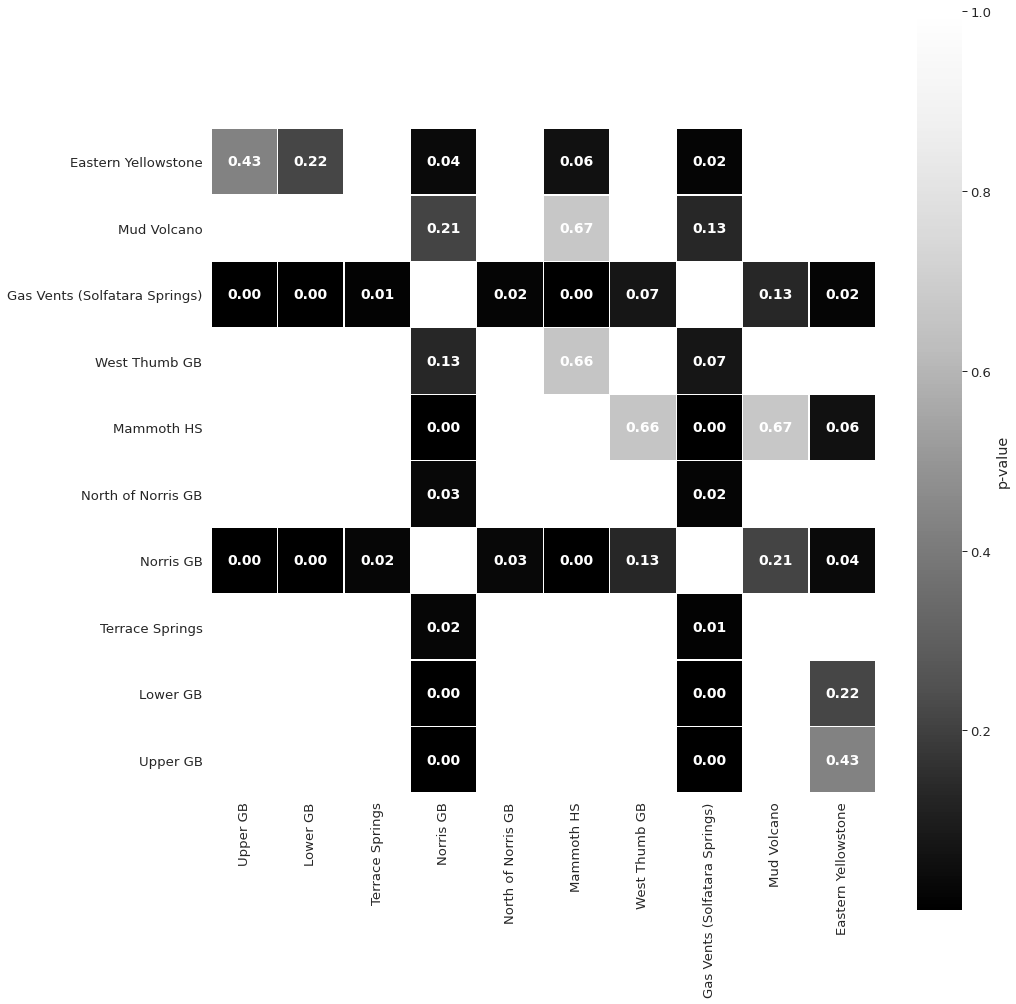

In [ ]:
# Create heatmap
plt.figure(figsize=(15,15))
ax = sns.heatmap(pval_conover_CH4, linewidths=0.35, cmap="Greys_r",
                 square=True, fmt=".2f",
                 annot=True, annot_kws={"color":"white", "weight":"bold"},
                 cbar_kws={"label":"p-value"}) 
ax.invert_yaxis()
sns.set(font_scale=1.75)
plt.tight_layout()
plt.savefig("../../figures/CH4_flx_CI_tst.png", dpi=300)

<Figure size 864x864 with 0 Axes>

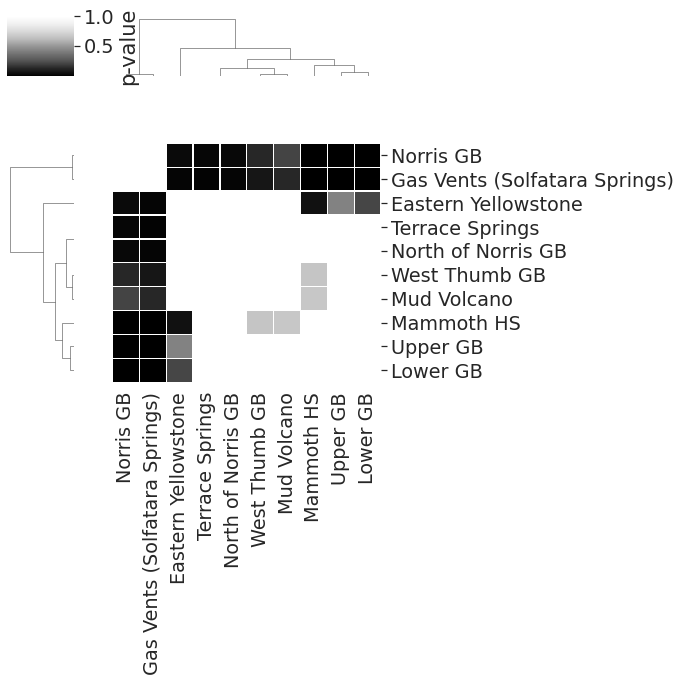

In [ ]:
# Create clustermap
plt.figure(figsize=(12,12))
ax = sns.clustermap(pval_conover_CH4, col_cluster=True, cmap="Greys_r",
                    cbar_kws={"label":"p-value"}, linewidths=0.35, fmt=".2f",
                    annot=False, annot_kws={"color":"white", "weight":"bold"}) 
plt.tight_layout()
plt.savefig("../../figures/CH4_flx_CI_tst_clustermap.png", dpi=300)

After applying the Conover-Imam test for signifance ($\alpha = 0.05$) between the median fluxes at each sit, the results show that the CH<sub>4</sub> fluxes at Mud Volcano is signficantly different than one of the other two remianing acid-sulphate regions (Gas Vents; $p$ ≤ 0.01). The other acid sulphate region, Eastern Yellowstone was not significantly different than Mud Volcano ($p$ = 0.06) but it must be stated there are many arguments that diminish the importance of the precisce cutoff of $p$ = 0.05 (add citations). 

Between the two travertine settings, Mammoth Hot Springs and Terrace Springs, there was a signifact difference between the CH<sub>4</sub> fluxes.

Among the neutral-chloride locations, none of the sites within the category were significantly different.

CH<sub>4</sub>  - VCNP

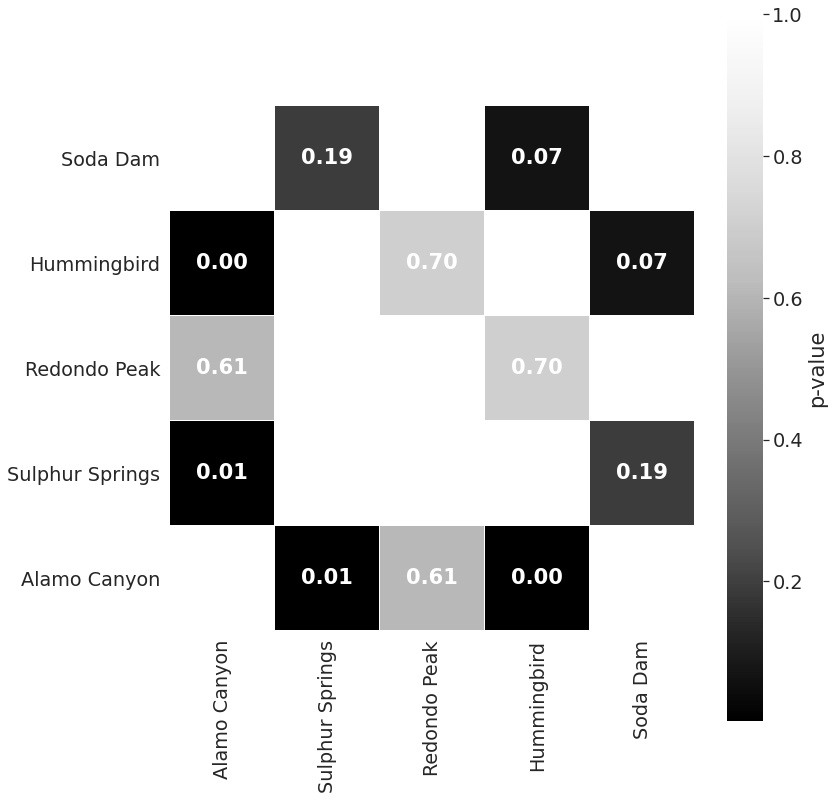

In [ ]:
# Create heatmap
plt.figure(figsize=(12,12))
ax = sns.heatmap(pval_conover_CH4_VC, linewidths=0.35, cmap="Greys_r",
                 square=True, fmt=".2f",
                 annot=True, annot_kws={"color":"white", "weight":"bold"},
                 cbar_kws={"label":"p-value"}) 
ax.invert_yaxis()
sns.set(font_scale=1.75)
plt.tight_layout()
plt.savefig("../../figures/CH4_flx_CI_tst_VCNP.png", dpi=300)

<Figure size 864x864 with 0 Axes>

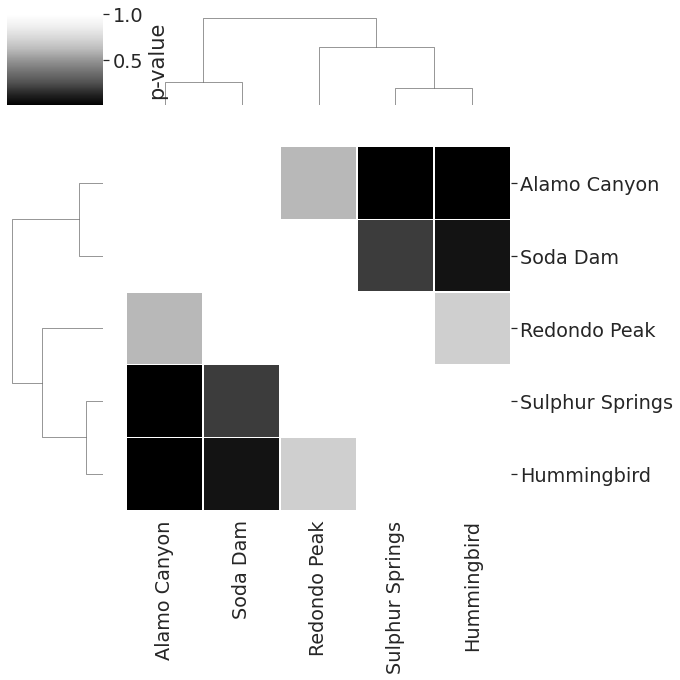

In [ ]:
# Create clustermap
plt.figure(figsize=(12,12))
ax = sns.clustermap(pval_conover_CH4_VC, col_cluster=True, cmap="Greys_r",
                    cbar_kws={"label":"p-value"}, linewidths=0.35, fmt=".2f",
                    annot=False, annot_kws={"color":"white", "weight":"bold"}) 
plt.tight_layout()
plt.savefig("../../figures/CH4_flx_CI_tst_clustermap_VCNP.png", dpi=300)

#### Significance Heatmap for CO<sub>2</sub> Fluxes

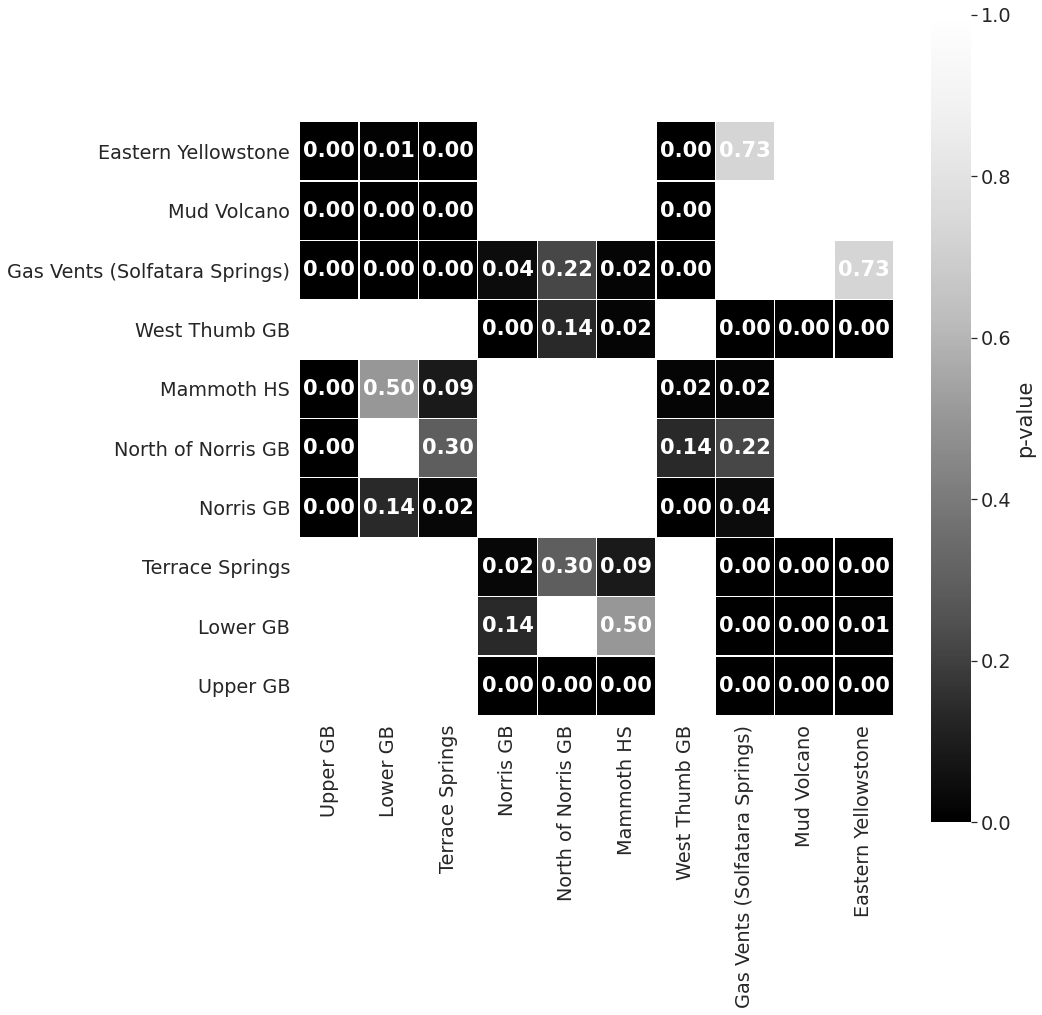

In [ ]:
## CO2
# Create heatmap
plt.figure(figsize=(15,15))
ax = sns.heatmap(pval_conover_CO2, linewidths=0.35, cmap="Greys_r",
                 square=True, fmt=".2f",
                 annot=True, annot_kws={"color":"white", "weight":"bold"},
                 cbar_kws={"label":"p-value"}) 
ax.invert_yaxis()
sns.set(font_scale=1.75)
plt.tight_layout()
plt.savefig("../../figures/CO2_flx_CI_tst.png", dpi=300)

Figure ##: Heatmap that presents the results of a Conover-Imam test to examine the differences in CO<sub>2</sub> fluxes across the Yellowstone caldera. Dark colors indicate significance, where light colors show a lack of significance. Values within the squares reprsent the corresponding $p$-values. Values with "0.00" represent $p < 0.005$.

<Figure size 864x864 with 0 Axes>

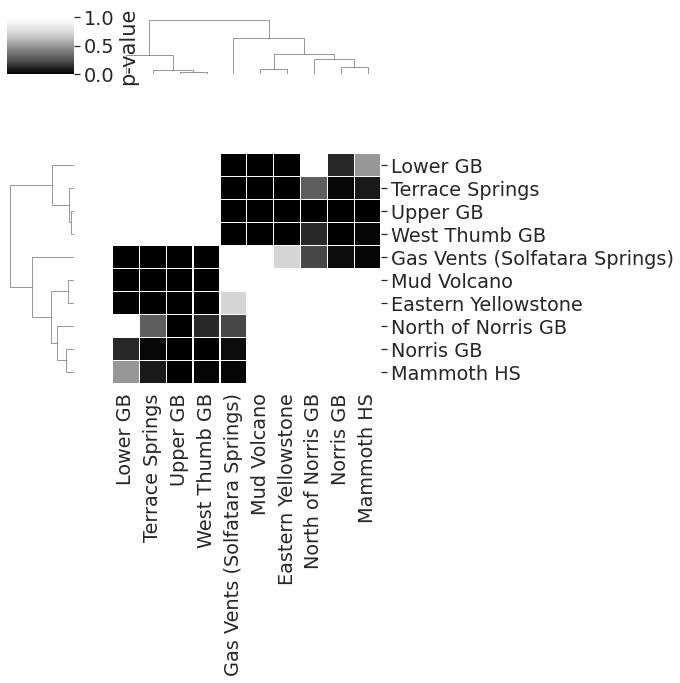

In [ ]:
# Create clustermap
plt.figure(figsize=(12,12))
ax = sns.clustermap(pval_conover_CO2, col_cluster=True, cmap="Greys_r",
                    cbar_kws={"label":"p-value"}, linewidths=0.35, fmt=".2f",
                    annot=False, annot_kws={"color":"white", "weight":"bold"})  
plt.tight_layout()
plt.savefig("../../figures/CO2_flx_CI_tst_clustermap.png", dpi=300)

CO<sub>2</sub> - VCNP

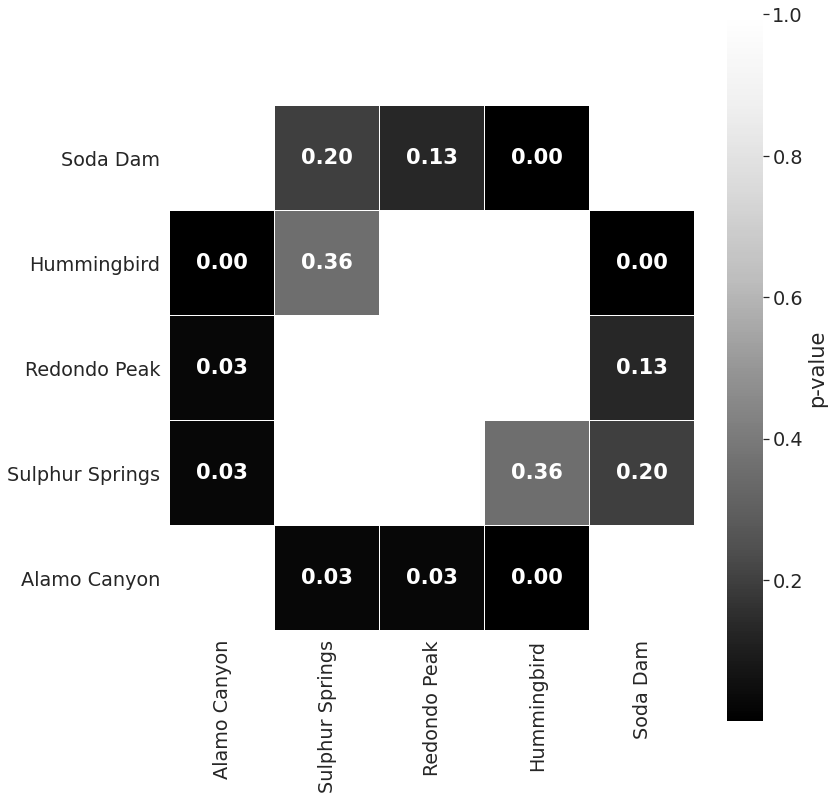

In [ ]:
## CO2
# Create heatmap
plt.figure(figsize=(12,12))
ax = sns.heatmap(pval_conover_CO2_VC, linewidths=0.35, cmap="Greys_r",
                 square=True, fmt=".2f",
                 annot=True, annot_kws={"color":"white", "weight":"bold"},
                 cbar_kws={"label":"p-value"}) 
ax.invert_yaxis()
sns.set(font_scale=1.75)
plt.tight_layout()
plt.savefig("../../figures/CO2_flx_CI_tst_VCNP.png", dpi=300)

<Figure size 864x864 with 0 Axes>

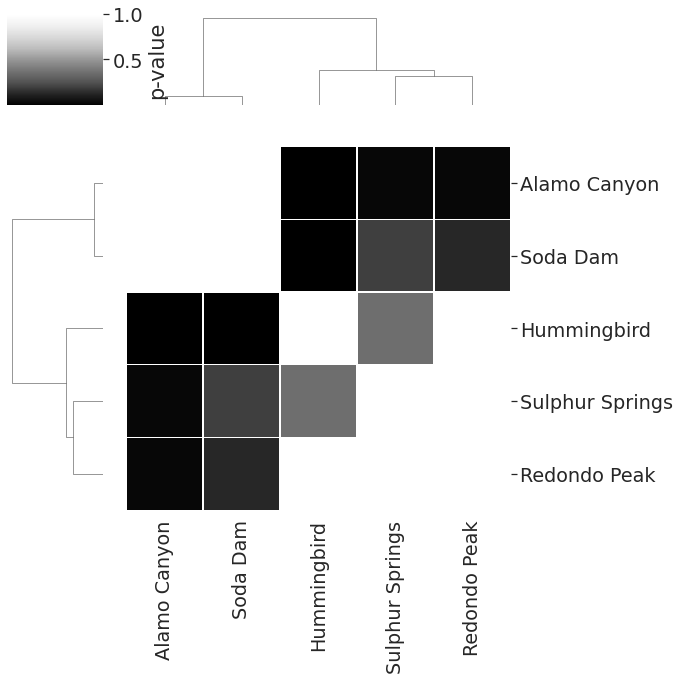

In [ ]:
# Create clustermap
plt.figure(figsize=(12,12))
ax = sns.clustermap(pval_conover_CO2_VC, col_cluster=True, cmap="Greys_r",
                    cbar_kws={"label":"p-value"}, linewidths=0.35, fmt=".2f",
                    annot=False, annot_kws={"color":"white", "weight":"bold"})  
plt.tight_layout()
plt.savefig("../../figures/CO2_flx_CI_tst_clustermap_VCNP.png", dpi=300)

### Comparing CO2 Fluxes to Previous Resarch

Werner and Brantley (2003) documented several scores of CO2 surface flux measurements that took place in YC. Through their work, the authors document several dozen CO2 flux measurements across the Yellostone region. Thus, the authors of this study compared the CO2 fluxes collected to those reported by Werner and Brantley (2003).

Ridge plots with Werner and Brantley (2003) data

In [ ]:
df_wb_2003.head()

wb_site_name region        group   co2_flux  co2_flux_log
0      Grizzly   MDVC  Mud Volcano  30.532178      1.484758
1      Grizzly   MDVC  Mud Volcano  46.567754      1.668085
2      Grizzly   MDVC  Mud Volcano  18.433268      1.265602
3      Grizzly   MDVC  Mud Volcano  79.085827      1.898099
4      Grizzly   MDVC  Mud Volcano  45.383512      1.656898

In [ ]:
# Combine Ajayi & Ayers data with Werner & Brantley (2003)

# gather Ajayi & Ayers data
df_all_log_wb_2003_combo = (
    df_all_log[["Group", "CO2_Flux"]]
    .pipe(clean_names)
    .rename(columns={"co2_flux":"co2_flux_aa"})
)
# add new categorical column to denote "Ajayi & Ayers" (aa)
aa = pd.Series(
    index=df_all_log_wb_2003_combo.index
)
aa = aa.fillna("aa").astype("category")
df_all_log_wb_2003_combo.insert(2, "study", aa)
df_all_log_wb_2003_combo = df_all_log_wb_2003_combo[df_all_log_wb_2003_combo["co2_flux_aa"] > 0]

# gather Werner and Branley data as new data frame with only pertinent columns
df_wb_2003_ = (
    df_wb_2003[["group", "co2_flux_log"]]
    .rename(columns={"co2_flux_log":"co2_flux_wb"})
)
# add new categorical column to denote "Werner & Brantley" (wb)
wb = pd.Series(
    index=df_wb_2003.index
)
wb = wb.fillna("wb").astype("category")
df_wb_2003_.insert(2, "study", wb)
df_wb_2003_ = df_wb_2003_[df_wb_2003_["co2_flux_wb"] > 0]

# join Werner and Brantley data
df_all_log_wb_2003_combo = df_all_log_wb_2003_combo.append(
    df_wb_2003_
)

NameError: ignored

In [ ]:
df_all_log_wb_2003_combo["group"] = (
    df_all_log_wb_2003_combo["group"]
    .astype("category")
    .cat
    .reorder_categories(
        ordered_groups_all, 
        ordered=True,
        inplace=False
    )
)

df_all_log_wb_2003_combo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  


group  co2_flux_aa study  co2_flux_wb
0    Sulphur Springs     1.708527    aa          NaN
1    Sulphur Springs     2.423197    aa          NaN
2    Sulphur Springs     1.383218    aa          NaN
3    Sulphur Springs     1.045284    aa          NaN
4    Sulphur Springs     2.168479    aa          NaN
..               ...          ...   ...          ...
794         Upper GB          NaN    wb     0.623249
795         Upper GB          NaN    wb     1.000000
796         Upper GB          NaN    wb     1.724276
797         Upper GB          NaN    wb     1.653213
798         Upper GB          NaN    wb     0.778151

[969 rows x 4 columns]

/usr/local/lib/python3.7/dist-packages/joypy/joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


<Figure size 432x288 with 0 Axes>

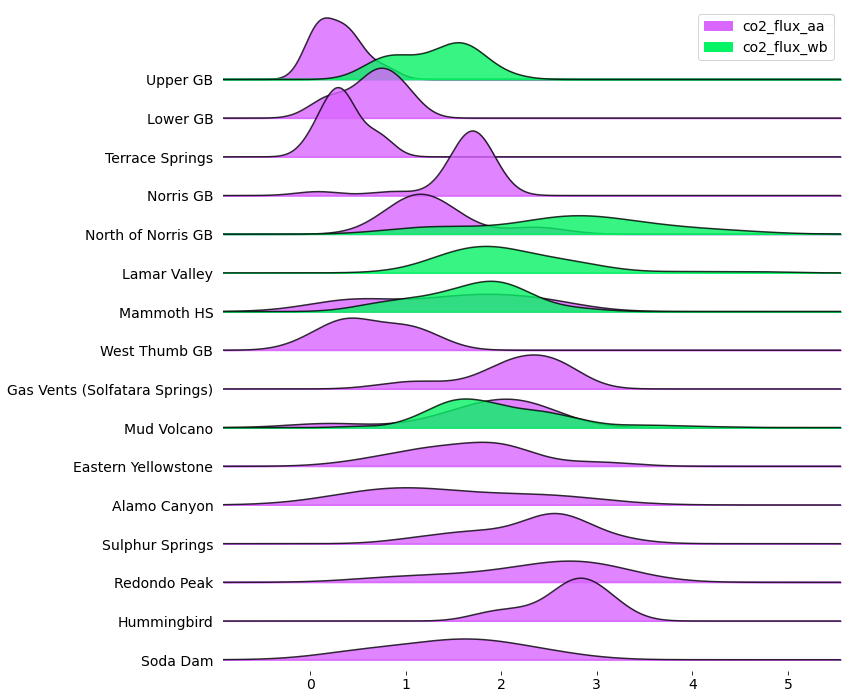

In [ ]:
plt.figure(facecolor="white")
joyplot(
    data=df_all_log_wb_2003_combo,
    by=["group"],
    alpha=0.8,  
    column=["co2_flux_aa", "co2_flux_wb"],
    # color=['#EC06F3', '#06F364'],
    color=[
           CO2_color1, '#06F364',  # Upper GB
           CO2_color1,             # Lower GB
           CO2_color1,             # Terrace Springs
           CO2_color1,             # Norris GB
           CO2_color1, '#06F364',  # North of Norris GB
           '#06F364',              # Lamar Valley
           CO2_color1, '#06F364',  # Mammoth HS
           CO2_color1,             # West Thumb
           CO2_color1,             # Gas Vents
           CO2_color1,             # Mud Volcano
           CO2_color1, '#06F364',  # E Yelloswtone
           CO2_color2,             # Alamo Canyon
           CO2_color2,             # Sulphur Springs
           CO2_color2,             # Redondo Peak
           CO2_color2,             # Hummingbird
           CO2_color2              # Soda Dam
          ],
    legend=True,
    figsize=(12,10)
)
plt.legend(["Ajayi & Ayers", "Werner & Brantley (2003)"])
plt.tight_layout()
plt.savefig(
    "../../figures/co2_fluxes_all_and_wb2003.png",
    dpi=300
)
plt.show()


> Ridgeline plot figure: Ridgeline plot of CO<sub>2</sub> fluxes at both calderas. The groups and caldera designations follow the description in (Figure 1). However, in this plot data (green) collected by Werner and Brantley (2003) has been overlain the data from this study (magenta). Only fluxes greater than zero are shown, sites where a ridgeplot is absent indicates all measurements were below zero. One exception is that this study did not make any measurements in Lamar Valley and therefore only Werrner and Brantley show measurements. Note: the scale of the x-axis for this plot is logged.

Comparing the data collected by Werner and Brantley to the data collected in this study shows differences from the west and more similarity as the locations move to the east. Specifically, the measurements in the upper geyser basin are about an order of magnitiude lower in this study than those presented in Werner and Brantley (2003). Similarly, the North of Norris location showed differences between median values that were approximatley one order of magnitude lower in this study than what was reported by Werner and Brantley. 

However, at MMTH, the range of values in the distribution of measurements in this study overlapped almost in its entireity with measurements that documented by Werner and Brantley. The difference here is rather the shape of the distributions. The distrubution of CO2 fluxes in this study at MMTH is very wide crossing valkues that spread across two orders of magnitiude with no discernable peak. Werner and Brantley recorded values that provided a small peak near 10E02 g CO<sub>2</sub> day<sup>-1</sup>. Their distribution was slightly skewed to the left. 

At MDVC, the measurements across both s

### EGM Fluxes
In addition to making flux measurements with the CRDS-AC, CO<sub>2</sub> fluxes were measured using an [EGM-5](https://ppsystems.com/egm-5/). The EGM is a portable accumulation chamber (PAC, as named in Ajayi & Ayers, 2021). Instead of measuring CH4 and carbon isotopes, the EGM only measures CO2 and produces a rapid and reliable flux estimate using a linear model, which is similar to what is for the CRDS-AC measurements.

Due to the portability of EGM versus the lack of mobility for the CRDS-AC, EGM measurements were made in full and half reactangular grids surrounding the CRDS-AC measurements. For example, consider a Cartesian coordinate system, where the CRDS-AC measurement at a location was made at the origin. EGM measurements would be made at (-1,0), (-1,1), (0,1), (1,0), (1,1), (1,-1), (0,-1), and (-1,-1). The actual distance between the CRDS-AC and the EGM ranged between 1.2 and 2.6 m. In some cases, all of the above measurements were not possible due to time or a suitable surface (e.g. non-rocky, no standing liquid, large thermal feature), but a subset of measurements was made at most measuring sites beginning with the 2018 campaign in Yellowstone.  

In this section of the notebook, the EGM fluxes are compared to the CRDS-AC fluxes. The objective of this exercise is to demonstrate how close the CO<sub>2</sub> fluxes collected by the EGM are to the fluxes estimated by the CRDS-AC. Where the differences are large, one can infer that heterogeneity is high, and conversely, when differences are small, homogenity (at least at the scale of meters) is a likely explanation.

#### Programmatically Import EGM Data

Import Yellowstone EGM data

In [ ]:
# Import file into workspace
df_egm_YC = (
    pd.read_csv(
      "../../pertinent-data/egm-data/EGM_CO2FluxesAllData.csv",
      header=0, 
      parse_dates=True
  )
)

# add a column `caldera` to organize the data by general location
df_egm_YC["Caldera"] = "YNP"

# arrange groups identically to the crds flux
df_egm_YC = group_egm_data(df_egm_YC)

# Convert fluxes from g CO2 m-2 hr-1 to g CO2 m-2 day-1
df_egm_YC["fCO2"] = df_egm_YC["fCO2"] * 24

# Add Soil Classification
df_egm_YC["Soil_Classification"] = ""
for i in range(len(df_egm_YC)):
  if "NEER" in df_egm_YC.Site.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Unclassified"
  elif "EETR" in df_egm_YC.Site.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Acid-Sulphate"
  elif "YSLK" in df_egm_YC.Site.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Acid-Sulphate"
  elif "Upper" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Neutral-Chloride"
  elif "Lower" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Neutral-Chloride"
  elif "Norris" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Neutral-Chloride"
  elif "Mammoth" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Travertine"
  elif "Terrace" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Travertine"
  elif "West Thumb" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Neutral-Chloride"
  elif "Vent" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Acid-Sulphate"
  elif "Volcano" in df_egm_YC.Group.iloc[i]:
    df_egm_YC.Soil_Classification.iloc[i] = "Acid-Sulphate"

# Convert Soil Classification to a categorical object
df_egm_YC["Soil_Classification"] = df_egm_YC.Soil_Classification.astype("category")

# Order the categories apporopriately
df_egm_YC["Soil_Classification"] = (
    df_egm_YC["Soil_Classification"]
    .cat
    .reorder_categories(
        [
         "Acid-Sulphate", 
         "Neutral-Chloride",
         "Travertine", 
         "Unclassified", 
        ],
        ordered=True
    )
)

# log the egm measurements
df_egm_YC["CO2_Flux_log10"] = np.log10(df_egm_YC.fCO2).replace(-np.inf, np.nan)

# Preview dataframe info
df_egm_YC.info()

<ipython-input-22-0404a12857f5>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  egm_df["Group"] = pd.Series(index=range(len(egm_df)))
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-22-0404a12857f5>:61: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  egm_df["Group"].cat.reorder_categories(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Date                 626 non-null    object  
 1   Year                 626 non-null    int64   
 2   Location             597 non-null    object  
 3   EGM_Location         626 non-null    object  
 4   Site                 626 non-null    object  
 5   Site_Number          626 non-null    object  
 6   Site_Letter          626 non-null    object  
 7   fCO2                 625 non-null    float64 
 8   log10fCO2            576 non-null    float64 
 9   Latitude             620 non-null    float64 
 10  Longitude            620 non-null    float64 
 11  Caldera              626 non-null    object  
 12  Group                626 non-null    category
 13  Soil_Classification  626 non-null    category
 14  CO2_Flux_log10       576 non-null    float64 
dtypes: category(2), float64

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df_egm_YC[["fCO2", "CO2_Flux_log10", "log10fCO2"]]

fCO2  CO2_Flux_log10  log10fCO2
0    0.96       -0.017729  -1.397940
1    1.44        0.158362  -1.221849
2    0.00             NaN        NaN
3    1.20        0.079181  -1.301030
4    0.24       -0.619789  -2.000000
..    ...             ...        ...
621  0.72       -0.142668  -1.522879
622  0.96       -0.017729  -1.397940
623  1.68        0.225309  -1.154902
624  1.44        0.158362  -1.221849
625  2.16        0.334454  -1.045757

[626 rows x 3 columns]

Import Valles Caldera EGM data

> Note: The EGM locations at Valles were limited to only Acid-Sulphate regions because the equipment was not available to the reseach group except for the second campaign, where VCAC, VCSS, and VCHB were the only locations measured.

In [ ]:
# Import file into workspace
df_egm_VC = pd.read_csv(
    "../../pertinent-data/egm-data/VCNP_EGMCO2Fluxes_AllData.csv",
    header=0, 
    parse_dates=True
)

# add a column `caldera` to organize the data by general location
df_egm_VC["Caldera"] = "VCNP"

# arrange groups identically to the crds flux
df_egm_VC = group_egm_data(df_egm_VC, caldera="VCNP")

# Convert fluxes from g CO2 m-2 hr-1 to g CO2 m-2 day-1
df_egm_VC["fCO2"] = df_egm_VC["fCO2"] * 24

# Add Soil Classification
df_egm_VC["Soil_Classification"] = ""
for i in range(len(df_egm_VC)):
  if "VCSS" in df_egm_VC.Site.iloc[i]:
    df_egm_VC.Soil_Classification.iloc[i] = "Acid-Sulphate"
  elif "VCAC" in df_egm_VC.Site.iloc[i]:
    df_egm_VC.Soil_Classification.iloc[i] = "Acid-Sulphate"
  elif "VCHB" in df_egm_VC.Site.iloc[i]:
    df_egm_VC.Soil_Classification.iloc[i] = "Acid-Sulphate"
  # elif "VCSD" in df_egm_VC.Group.iloc[i]:
  #   df_egm_VC.Soil_Classification.iloc[i] = "Travertine"
  # elif "VCRP" in df_egm_VC.Group.iloc[i]:
  #   df_egm_VC.Soil_Classification.iloc[i] = "Unclassified"

# Convert Soil Classification to a categorical object
df_egm_VC["Soil_Classification"] = df_egm_VC.Soil_Classification.astype("category")

# Order the categories apporopriately
df_egm_VC["Soil_Classification"] = (
    df_egm_VC["Soil_Classification"]
    .cat
    .reorder_categories(
        [
         "Acid-Sulphate",
        #  "Travertine", 
        #  "Unclassified", 
        ],
        ordered=True
    )
)    

# log the egm measurements
df_egm_VC["CO2_Flux_log10"] = np.log10(df_egm_VC.fCO2).replace(-np.inf, np.nan)

df_egm_VC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Date                 95 non-null     object  
 1   Year                 95 non-null     int64   
 2   Location             85 non-null     object  
 3   EGM_Location         95 non-null     object  
 4   Site                 95 non-null     object  
 5   Site_Number          95 non-null     float64 
 6   Site_Letter          95 non-null     object  
 7   fCO2                 58 non-null     float64 
 8   log10fCO2            53 non-null     float64 
 9   Latitude             60 non-null     float64 
 10  Longitude            60 non-null     float64 
 11  Caldera              95 non-null     object  
 12  Group                95 non-null     category
 13  Soil_Classification  95 non-null     category
 14  CO2_Flux_log10       53 non-null     float64 
dtypes: category(2), float64(6

<ipython-input-22-0404a12857f5>:75: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  egm_df["Group"] = pd.Series(index=range(len(egm_df)))
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-22-0404a12857f5>:103: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  egm_df["Group"].cat.reorder_categories(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is tryin

In [ ]:
df_egm_VC[["fCO2", "CO2_Flux_log10", "log10fCO2"]]

fCO2  CO2_Flux_log10  log10fCO2
0      9.36        0.971276  -0.408935
1    360.00        2.556303   1.176091
2   1222.32        3.087185   1.706974
3       NaN             NaN        NaN
4       NaN             NaN        NaN
..      ...             ...        ...
90    20.88        1.319730  -0.060481
91   160.80        2.206286   0.826075
92    11.52        1.061452  -0.318759
93   360.72        2.557170   1.176959
94      NaN             NaN        NaN

[95 rows x 3 columns]

#### Distribution Fitting

This section replaces the same section that has been struck out. Here, simple descriptive statistics have been added and visazlied and the assessments for normality have also been conducted as well.


###### Visualize the raw data

Histogram of fluxes as raw observations and log transformed as well.

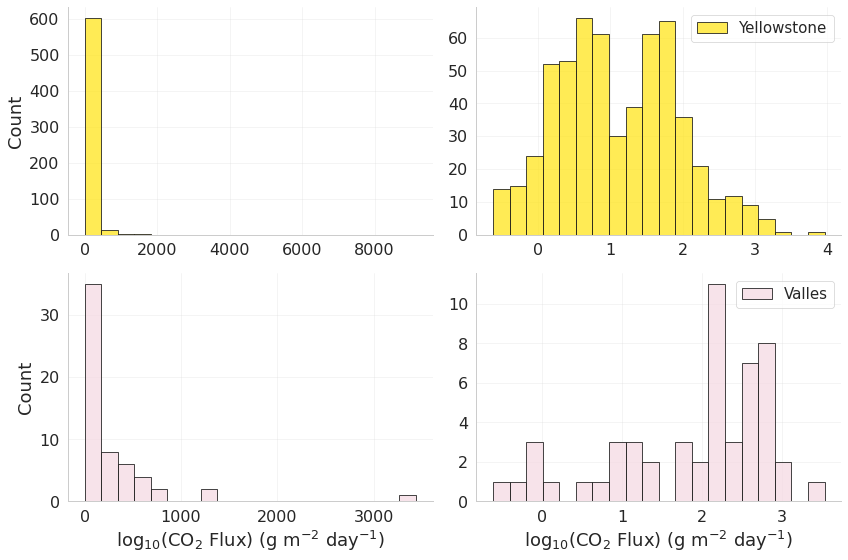

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

# yellowstone
# raw data
sns.histplot(
    df_egm_YC,
    x="fCO2",
    bins=20,
    color=yc_color,
    edgecolor="k",
    ax=ax[0,0]
)
ax[0,0].yaxis.get_label().set_fontsize(18)
ax[0,0].set(
    xlabel=""
)


# log transformed
sns.histplot(
    df_egm_YC,
    x="CO2_Flux_log10",
    bins=20,
    color=yc_color,
    edgecolor="k",
    ax=ax[0,1]
)
ax[0,1].set(
    ylabel="",
    xlabel=""
)
ax[0,1].legend(["Yellowstone"])

# valles
# raw data
sns.histplot(
    df_egm_VC,
    x="fCO2",
    bins=20,
    color=vc_color,
    edgecolor="k",
    ax=ax[1,0]
)
ax[1,0].set(
    xlabel="log$_{10}$(CO$_{2}$ Flux) (g m$^{-2}$ day$^{-1})$"
)
ax[1,0].xaxis.get_label().set_fontsize(18)
ax[1,0].yaxis.get_label().set_fontsize(18)

# log transformed
sns.histplot(
    df_egm_VC,
    x="CO2_Flux_log10",
    bins=20,
    color=vc_color,
    edgecolor="k",
    ax=ax[1,1]
)
ax[1,1].set(
    ylabel="",
    xlabel="log$_{10}$(CO$_{2}$ Flux) (g m$^{-2}$ day$^{-1})$"
)
ax[1,1].xaxis.get_label().set_fontsize(18)
ax[1,1].legend(["Valles"])

plt.tight_layout()
plt.show()

##### Finding the best distribution

Best distribution to describe fluxes

###### Yellowstone

In [ ]:
# Trim data to only include non-NaN values
df_egm_fCO2_pos_only = df_egm_YC[(df_egm_YC["fCO2"] >= 0)]

flx_pos_only_loss = perc_diff(df_egm_fCO2_pos_only.shape[0], df_egm_YC.shape[0])
### Report the percentage of lost fluxes
print("{:.1f}% of fluxes were lost when values less than zero were removed".format(flx_pos_only_loss))

3.9% of fluxes were lost when values less than zero were removed


Only 4% of the EGM fluxes at YC were less than zero, letting us know that dropping negative fluxes and moving forward should not be probhibitive in analyzing the data at the caldera level.

Below, a series of tests are conducted to find the best distribution to describe the data. The _logged transformed_ fluxes are inserted into the function, `assess_fit_params()` to find the best distribution. `assess_fit_params()` works by:
1. Collecting all non-nan data
2. Selecting a theoretical distribution (e.g., "beta", "normal", "t", _etc_.)
3. Obtain necessary parameters using the [maximum likelihood estimator]() technique
4. Apply a Kolmogorov-Smirnov (KS) test with observations against each theoretical distribution
5. The _higher_ the p-value the more likely that the distribution accurately describes the observations

In [ ]:
dist_fit_egm_YC_logCO2 = assess_fit_params(df_egm_YC["CO2_Flux_log10"].dropna())
dist_fit_egm_YC_logCO2

/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


distribution     statistic  \
0          beta  5.043580e-02   
1   weibull_min  5.251489e-02   
2        burr12  5.285998e-02   
3          norm  5.376365e-02   
4             t  5.378203e-02   
5      loggamma  5.384358e-02   
6    genextreme  5.699509e-02   
7       lognorm  5.913320e-02   
8      pearson3  6.019825e-02   
9         gamma  6.020025e-02   
10     invgamma  6.120417e-02   
11      maxwell  6.561794e-02   
12         fisk  6.713339e-02   
13     rayleigh  6.940134e-02   
14  genlogistic  7.232687e-02   
15     genexpon  7.599412e-02   
16    genpareto  1.773246e-01   
17        expon  2.431494e-01   
18       pareto  3.054747e-01   
19     powerlaw  3.082473e-01   
20         chi2  3.720627e-01   
21     vonmises  2.093448e+30   

                                               params       p_value  
0   [3.8187851400708444, 6.055922256200583, -1.121...  1.031490e-01  
1   [2.683516058463948, -0.9947063509940162, 2.359...  8.048592e-02  
2   [2.690608995863136, 255.1383720295687, -0.9962...  7.716390e-02  
3             [1.102196211145151, 0.8460627642262482]  6.900982e-02  
4   [5631595.94526469, 1.1022269825541895, 0.84603...  6.885188e-02  
5   [1120.8701604623375, -199.81018771398067, 28.6...  6.832522e-02  
6   [0.20618702445223364, 0.7737974797706384, 0.80...  4.557690e-02  
7   [0.09533451914325491, -7.770790923213126, 8.83...  3.417941e-02  
8   [0.31689242643057736, 1.1022082235070623, 0.84...  2.949807e-02  
9   [39.83827089599366, -4.2548065171710086, 0.134...  2.948983e-02  
10  [145.58634148391764, -9.114853211744443, 1477....  2.560515e-02  
11          [-0.9695347782915118, 1.2919994032590174]  1.338434e-02  
12  [16.672185441991417, -7.1757186793055645, 8.23...  1.060100e-02  
13          [-0.41066618267021054, 1.225678347616312]  7.404627e-03  
14  [2.332642563396712, 0.3841877546717442, 0.6107...  4.579573e-03  
15  [0.001110354784927649, 1.402331243860031, 0.00...  2.438166e-03  
16  [-0.5244529778673594, -0.6197887597178691, 2.4...  2.581620e-16  
17            [-0.619788758288394, 1.721984969433545]  1.822902e-30  
18  [1.0471859919328095, -1.7430683086793823, 1.12...  3.336345e-48  
19  [1.1296585728572883, -0.9993168891646462, 4.96...  4.294060e-49  
20  [1.2665948754165972, -0.6197887582883941, 1.16...  4.516076e-72  
21  [0.9833975383121226, 1.4569225151126939, 1.903...  0.000000e+00

###### Valles

In [ ]:
# Trim data to only include non-NaN values
df_egm_fCO2_pos_only = df_egm_VC[(df_egm_VC["fCO2"] >= 0)]

flx_pos_only_loss = perc_diff(df_egm_fCO2_pos_only.shape[0], df_egm_VC.shape[0])
### Report the percentage of lost fluxes
print("{:.1f}% of fluxes were lost when values less than zero were removed".format(flx_pos_only_loss))

50.0% of fluxes were lost when values less than zero were removed


Approximately 50% of the EGM fluxes at VC were less than zero. This a significant number and needs to be considered when intrepreting impact of the analysis in this section.


The best fit for the proper distribution to described the logged CO$_{2}$ fluxes from the EGM is assessed with the function, `assess_fit_params()`. 

The functionality is explained above in the corresponding Yellowstone section.

In [ ]:
dist_fit_egm_VC_logCO2 = assess_fit_params(df_egm_VC["CO2_Flux_log10"].dropna())
dist_fit_egm_VC_logCO2

/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


distribution     statistic  \
0   genlogistic  9.271223e-02   
1      loggamma  1.150393e-01   
2        burr12  1.330797e-01   
3   weibull_min  1.339974e-01   
4      pearson3  1.386475e-01   
5    genextreme  1.499466e-01   
6          fisk  1.555040e-01   
7      powerlaw  1.687631e-01   
8     genpareto  1.941911e-01   
9       lognorm  2.015863e-01   
10            t  2.021050e-01   
11         norm  2.021105e-01   
12     invgamma  2.038523e-01   
13        gamma  2.128204e-01   
14         chi2  2.145456e-01   
15      maxwell  2.405559e-01   
16     rayleigh  2.527875e-01   
17     genexpon  2.606360e-01   
18         beta  2.745317e-01   
19        expon  3.033540e-01   
20       pareto  3.210079e-01   
21     vonmises  4.198696e+31   

                                               params   p_value  
0   [0.18102626033167746, 2.8177688026336325, 0.18...  0.717405  
1   [0.5496638919639221, 2.735163978045236, 0.4994...  0.451074  
2   [3640.9661725583173, 1323.6979138699417, -2683...  0.279379  
3   [43411928.08972055, -32080655.500692874, 32080...  0.272073  
4   [-1.0125933000947833, 1.8673430465465697, 0.97...  0.237173  
5   [0.5406778921311529, 1.6440696404947737, 1.063...  0.166453  
6   [191291025.6231152, -106204432.61063862, 10620...  0.138392  
7   [1.5810545957137907, -0.7512073466744823, 4.28...  0.086664  
8   [-1.2416164908256886, -0.6259188049559095, 5.1...  0.031685  
9   [0.002895014414972686, -340.54064918375457, 34...  0.023018  
10  [2454670.899534695, 1.8673713877587788, 0.9903...  0.022497  
11           [1.8673603204283489, 0.9903128315168451]  0.022492  
12  [463.0039141302691, -20.69430835111927, 10430....  0.020820  
13  [298.95016033950776, -15.808650986184013, 0.05...  0.013838  
14  [239.4713323301081, -9.680608962546124, 0.0481...  0.012766  
15           [-0.9790721688693871, 1.740008217893854]  0.003488  
16         [-0.41465245820147806, 1.7590198728406585]  0.001796  
17  [0.000866827279673781, 4.96833393407133, 7.937...  0.001152  
18  [1.7780875658677737, 0.7777198134855008, -1.10...  0.000507  
19            [-0.619788758288394, 2.487149078716743]  0.000080  
20  [22646099.457622796, -53681868.22014141, 53681...  0.000023  
21  [1.2100506225337784, 2.974593675648245, 1.3624...  0.000000

##### QQ Plot

###### Yellowstone

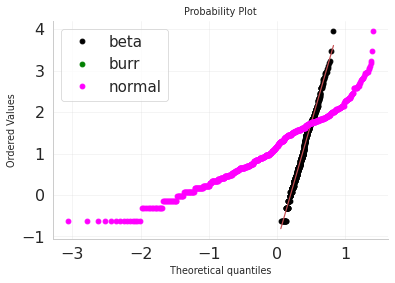

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# beta
beta_parms = dist_fit_egm_YC_logCO2.params.iloc[0]
stats.probplot(
    df_egm_YC["CO2_Flux_log10"].dropna(), 
    dist=stats.beta, 
    sparams=(beta_parms[0],beta_parms[1]), 
    plot=plt, 
    fit=True
)
# burr12
burr12_parms = dist_fit_egm_YC_logCO2.params.iloc[1]
stats.probplot(
    df_egm_YC["CO2_Flux_log10"].dropna(), 
    dist=stats.burr12, 
    sparams=(burr12_parms[0],burr12_parms[1]), 
    plot=plt, 
    fit=True
)
# weibull_min
# wb_min_parms = dist_fit_egm_YC_logCO2.params.iloc[2]
# stats.probplot(
#     df_egm_YC["CO2_Flux_log10"].dropna(), 
#     dist=stats.weibull_min, 
#     sparams=(wb_min_parms[0],wb_min_parms[1]), 
#     plot=plt, 
#     fit=True
# )
# # loggamma
# loggamma_params = dist_fit_egm_YC_logCO2.params.iloc[3]
# stats.probplot(
#     df_egm_YC["CO2_Flux_log10"].dropna(), 
#     dist=stats.loggamma, 
#     sparams=(loggamma_params[0],loggamma_params[1]), 
#     plot=plt, 
#     fit=True
# )
# normal
norm_params = dist_fit_egm_YC_logCO2.params.iloc[4]
stats.probplot(
    df_egm_YC["CO2_Flux_log10"], 
    dist=stats.norm, 
    # sparams=(norm_params[0],norm_params[1]), 
    plot=plt, 
    fit=True
)
# Remove the regression lines
# ax.get_lines()[0].remove()
# ax.get_lines()[1].remove()
# # ax.get_lines()[2].remove()
# # ax.get_lines()[3].remove()
# # ax.get_lines()[4].remove()

# Change colour of scatter
ax.get_lines()[0].set_markerfacecolor("black")
ax.get_lines()[0].set_markeredgecolor("black")
ax.get_lines()[2].set_markerfacecolor("green")
ax.get_lines()[2].set_markeredgecolor("green")
# ax.get_lines()[2].set_markerfacecolor('C2')
# ax.get_lines()[3].set_markerfacecolor('C3')
ax.get_lines()[4].set_markerfacecolor("magenta")
ax.get_lines()[4].set_markeredgecolor("magenta")

# ax.plot([0, 1], [0, 1], c='C5')
plt.legend(
    [ax.get_lines()[0], ax.get_lines()[2], ax.get_lines()[4]], 
    ['beta', 'burr', "normal"]
)
plt.show()

The QQ-plot supports the results from the series of KS tests. A normal distribution does **not** best describe the the shape of the logged EGM observations. In the tail, in particular at the lower end, the observations veer from the theoretical normal distribution. Instead, a Beta or even a Burr distribution more closley defines the logged observations.

###### Valles

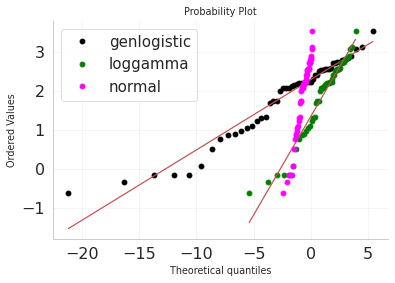

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# genlogistic
genlogistic_parms = dist_fit_egm_VC_logCO2.params.iloc[0]
stats.probplot(
    df_egm_VC["CO2_Flux_log10"].dropna(), 
    dist=stats.genlogistic, 
    sparams=(genlogistic_parms[0],genlogistic_parms[1]), 
    plot=plt, 
    fit=True
)
# loggamma
loggamma_parms = dist_fit_egm_VC_logCO2.params.iloc[1]
stats.probplot(
    df_egm_VC["CO2_Flux_log10"].dropna(), 
    dist=stats.loggamma, 
    sparams=(loggamma_parms[0],loggamma_parms[1]), 
    plot=plt, 
    fit=True
)
# normal
norm_params = dist_fit_egm_VC_logCO2.params.iloc[11]
stats.probplot(
    df_egm_VC["CO2_Flux_log10"], 
    dist=stats.norm, 
    # sparams=(norm_params[0],norm_params[1]), 
    plot=plt, 
    fit=True
)

# Change colour of scatter
ax.get_lines()[0].set_markerfacecolor("black")
ax.get_lines()[0].set_markeredgecolor("black")
ax.get_lines()[2].set_markerfacecolor("green")
ax.get_lines()[2].set_markeredgecolor("green")
ax.get_lines()[4].set_markerfacecolor("magenta")
ax.get_lines()[4].set_markeredgecolor("magenta")

plt.legend(
    [ax.get_lines()[0], ax.get_lines()[2], ax.get_lines()[4]], 
    ['genlogistic', 'loggamma', "normal"]
)
plt.show()

#### Descriptive Statistics

##### Quantity of samples per relevant groups

###### Yellowstone

In [ ]:
# group all of the egm measurements by soil classification type
df_egm_YC_sclf_grp = (
    df_egm_YC
    .dropna()
    .groupby(by=["Soil_Classification"])[["fCO2", "CO2_Flux_log10"]]
    .agg([np.count_nonzero])
)

df_egm_YC_sclf_grp

fCO2 CO2_Flux_log10
                    count_nonzero  count_nonzero
Soil_Classification                             
Acid-Sulphate                 209            209
Neutral-Chloride              201            201
Travertine                     71             71
Unclassified                   63             63

In [ ]:
# group all of the egm measurements by group
df_egm_YC_group_grp = (
    df_egm_YC
    .dropna()
    .groupby(by=["Group"])[["fCO2", "log10fCO2"]]
    .agg([np.count_nonzero])
)

df_egm_YC_group_grp

fCO2     log10fCO2
                              count_nonzero count_nonzero
Group                                                    
Upper GB                                 89            89
Lower GB                                 27            27
Terrace Springs                          37            37
Norris GB                                45            45
Mammoth HS                               34            34
West Thumb GB                            40            40
Gas Vents (Solfatara Springs)            89            88
Mud Volcano                              42            42
Eastern Yellowstone                     141           141

###### Valles

In [ ]:
# group all of the egm measurements by soil classification type
df_egm_VC_sclf_grp = (
    df_egm_VC
    .dropna()
    .groupby(by=["Soil_Classification"])[["fCO2", "CO2_Flux_log10"]]
    .agg([np.count_nonzero])
)

df_egm_VC_sclf_grp

fCO2 CO2_Flux_log10
                    count_nonzero  count_nonzero
Soil_Classification                             
Acid-Sulphate                  45             45

In [ ]:
# group all of the egm measurements by group
df_egm_VC_group_grp = (
    df_egm_VC
    .dropna()
    .groupby(by=["Group"])[["fCO2", "log10fCO2"]]
    .agg([np.count_nonzero])
)

df_egm_VC_group_grp

fCO2     log10fCO2
                count_nonzero count_nonzero
Group                                      
Alamo Canyon               14            14
Sulphur Springs            16            16
Hummingbird                15            15

##### Summary descriptive stats

In [ ]:
df_egm_YC_sclf_grp = (
    df_egm_YC
    .dropna()
    .groupby(by=["Group"])[["fCO2", "log10fCO2"]]
    .describe()
)

df_egm_YC_sclf_grp.to_csv(
    "../../pertinent-data/summary-data/egm_sclf_group_summary.csv",
    index=False
)

df_egm_YC_sclf_grp

fCO2                                        \
                               count        mean          std   min    25%   
Group                                                                        
Upper GB                        89.0   16.012584   118.369827  0.24   0.96   
Lower GB                        27.0    5.617778     4.090986  0.48   2.76   
Terrace Springs                 37.0   23.027027    75.681479  0.24   1.44   
Norris GB                       45.0  239.589333  1357.794781  0.48   7.20   
Mammoth HS                      34.0   32.470588    52.899659  0.48   3.36   
West Thumb GB                   40.0    4.338000     4.033358  0.24   1.62   
Gas Vents (Solfatara Springs)   89.0  103.987416   171.170942  2.88  27.60   
Mud Volcano                     42.0  193.034286   263.796265  2.64  41.34   
Eastern Yellowstone            141.0  127.209021   354.004664  0.24   7.44   

                                                       log10fCO2            \
                                 50%     75%       max     count      mean   
Group                                                                        
Upper GB                        2.16    4.32  1118.400      89.0 -1.074680   
Lower GB                        4.56    7.80    16.320      27.0 -0.758522   
Terrace Springs                 2.88    3.84   421.440      37.0 -0.840032   
Norris GB                      37.44   61.44  9144.000      45.0 -0.050912   
Mammoth HS                      8.28   30.78   203.760      34.0 -0.365148   
West Thumb GB                   2.64    5.82    21.120      40.0 -0.913350   
Gas Vents (Solfatara Springs)  60.00   99.60  1170.720      89.0  0.359899   
Mud Volcano                    92.04  182.04   909.840      42.0  0.550393   
Eastern Yellowstone            19.44   47.28  2957.592     141.0 -0.023219   

                                                                       \
                                    std       min       25%       50%   
Group                                                                   
Upper GB                       0.554536 -2.000000 -1.397940 -1.045757   
Lower GB                       0.371565 -1.698970 -0.939713 -0.721246   
Terrace Springs                0.669952 -2.000000 -1.221849 -0.920819   
Norris GB                      0.808169 -1.698970 -0.522879  0.193125   
Mammoth HS                     0.698200 -1.698970 -0.865357 -0.462227   
West Thumb GB                  0.417130 -2.000000 -1.171639 -0.958607   
Gas Vents (Solfatara Springs)  0.481990 -0.920819  0.060698  0.397940   
Mud Volcano                    0.604452 -0.958607  0.236158  0.582477   
Eastern Yellowstone            0.768617 -2.000000 -0.508638 -0.091515   

                                                   
                                    75%       max  
Group                                              
Upper GB                      -0.744727  1.668386  
Lower GB                      -0.488580 -0.167491  
Terrace Springs               -0.795880  1.244525  
Norris GB                      0.408240  2.580925  
Mammoth HS                     0.108035  0.928908  
West Thumb GB                 -0.616915 -0.055517  
Gas Vents (Solfatara Springs)  0.618048  1.688242  
Mud Volcano                    0.879955  1.578754  
Eastern Yellowstone            0.294466  2.090728

#### EGM Hypothesis Testing

The data for the EGM analysis is juxtaposed with the CRDS data to determine the level of similarity of the peripheral EGM measurements are to the CRDS measurements. At the end of the analysis, there will be a quantifiable relationship between the EGM and CRDS data.

For more information on the types of tests conducted, refer to the concepts referenced [here](https://colab.research.google.com/drive/1wZtnsEc6ANNVZg0Yyim-YT3IEpPmcZHj#scrollTo=I-uOEx_F4W8g) more details.

In [ ]:
# get the CRDS data grouped by soil class classification if not present in memory

if "gb_sclf_YC" not in locals():
  # Separate data into fluxes by soil chemistry
  ## YNP
  gb_sclf_YC = df_YC_all.groupby(by=["Soil_Classification"])
  gb_sclf_YC = [gb_sclf_YC.get_group(x) for x in gb_sclf_YC.groups]

if "gb_sclf_VC" not in locals():
  ## VCNP
  gb_sclf_VC = df_VC_all.groupby(by=["Soil_Classification"])
  gb_sclf_VC = [gb_sclf_VC.get_group(x) for x in gb_sclf_VC.groups]

##### KS Test


###### Yellowstone

In [ ]:
# YNP -- egm
gb_sclf_egm_YC = df_egm_YC.groupby(by=["Soil_Classification"])
gb_sclf_egm_YC = [gb_sclf_egm_YC.get_group(x) for x in gb_sclf_egm_YC.groups]

gb_sclf_egm_YC

[          Date  Year              Location EGM_Location  Site Site_Number  \
 47   24-Jun-18  2018  EETR_24Jun2018_1.1.1   EETR_1.1_A  EETR         1.1   
 48   24-Jun-18  2018  EETR_24Jun2018_1.1.1   EETR_1.1_B  EETR         1.1   
 49   24-Jun-18  2018  EETR_24Jun2018_1.1.1   EETR_1.1_C  EETR         1.1   
 50   24-Jun-18  2018  EETR_24Jun2018_1.1.1   EETR_1.1_D  EETR         1.1   
 51   24-Jun-18  2018  EETR_24Jun2018_1.1.1   EETR_1.1_E  EETR         1.1   
 ..         ...   ...                   ...          ...   ...         ...   
 528  10-Jun-19  2019    EETR_10Jun2019_2.1   EETR_2.1_A  EETR         2.1   
 529  10-Jun-19  2019    EETR_10Jun2019_2.1   EETR_2.1_B  EETR         2.1   
 530  10-Jun-19  2019    EETR_10Jun2019_2.1   EETR_2.1_C  EETR         2.1   
 531  10-Jun-19  2019    EETR_10Jun2019_2.1   EETR_2.1_D  EETR         2.1   
 532  10-Jun-19  2019    EETR_10Jun2019_2.1   EETR_2.1_E  EETR         2.1   
 
     Site_Letter      fCO2  log10fCO2   Latitude   Longitude C

The data collected by the CRDS has already been calcualted at an earlier stage. The YNP data is referred to as `gb_sclf_YC`. 

Unlike the KS test conducted for the CRDS data or the tests performed earlier in this section, the KS test for this section will be a two sample test to compare the EGM data against the CRDS data, which can be considered the reference dataset.

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = geta

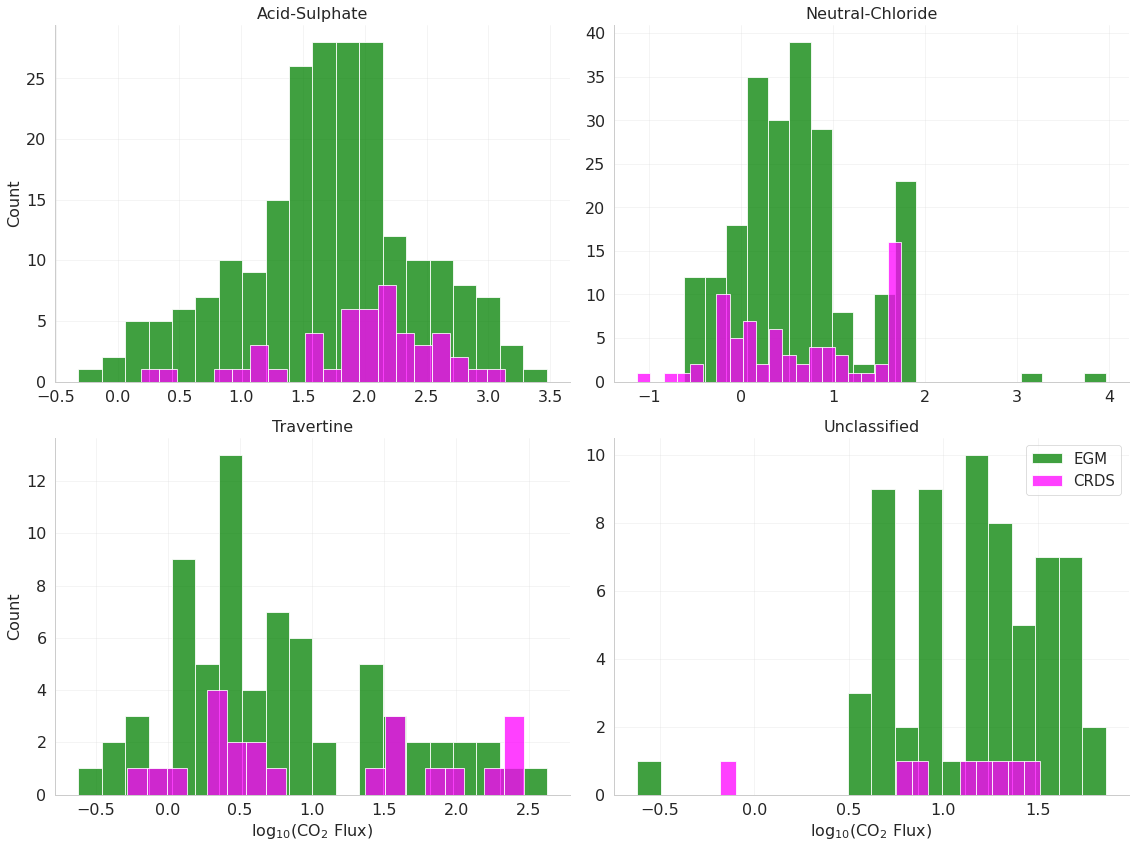

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_egm_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "ks_stat", 
        "pval",
        "n_egm",
        "n_crds"
      ],
    index=range(4)
  )

# Loop through each soil type and check for normality
fig, ax = plt.subplots(2,2, figsize=(16,12))

for i in range(4):
  #---YNP---#
  # Gather Soil Classification
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_YC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_egm_YC[i].Caldera.iloc[0]
  # Run KS Test gb_grps_YC[i].CO2_Flux.dropna()
  ## use for original (non-log) data
  # ks_stat, pval = ks_2samp(
  #     gb_sclf_egm_YC[i].fCO2.dropna(), 
  #     gb_sclf_YC[i].CO2_Flux.dropna()
  # )
  ks_stat, pval = ks_2samp(
      gb_sclf_egm_YC[i].CO2_Flux_log10.dropna(), 
      np.log10(gb_sclf_YC[i].CO2_Flux.dropna())
  )
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["ks_stat"] = ks_stat
  ## pval
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["pval"] = pval
  ## n_egm
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["n_egm"] = \
  len(gb_sclf_egm_YC[i].CO2_Flux_log10.dropna())
  ## n_crds
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["n_crds"] = \
  len(gb_sclf_YC[i].CO2_Flux.dropna())

  if i == 0:
    ax_r = 0
    ax_c = 0
  elif i == 1:
    ax_r = 0
    ax_c = 1
  elif i == 2:
    ax_r = 1
    ax_c = 0
  elif i == 3:
    ax_r = 1
    ax_c = 1

  # egm
  sns.histplot(
      gb_sclf_egm_YC[i],
      x=gb_sclf_egm_YC[i].CO2_Flux_log10.dropna(),
      color="green",
      bins=20,
      ax=ax[ax_r, ax_c]
  )
  # crds
  sns.histplot(
      gb_sclf_YC[i],
      x=np.log10(gb_sclf_YC[i].CO2_Flux.dropna()),
      color="magenta",
      bins=20,
      ax=ax[ax_r, ax_c]
  )

  ax[ax_r, ax_c].set_title(
    "{}".format(gb_sclf_egm_YC[i].Soil_Classification.iloc[0]),
    size=16
  )

df_KS_rslts_egm_sclf_flux_YC.to_csv(
      "../../pertinent-data/summary-data/egm_v_crds_ks_test_log10.csv"
  )

ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("Count", fontsize=16)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[1,0].set_xlabel("log$_{10}$(CO$_{2}$ Flux)", fontsize=16)
ax[1,0].set_ylabel("Count", fontsize=16)
ax[1,1].set_xlabel("log$_{10}$(CO$_{2}$ Flux)", fontsize=16)
ax[1,1].set_ylabel("")

plt.legend(
    [ax[1,1].containers[0], ax[1,1].containers[1]], 
    ['EGM', 'CRDS']
)
plt.tight_layout()

fig.savefig(
    "../../figures/egm_v_crds_hist_sclf_log10_co2.png"
)

plt.show()

# export results to `.csv`
df_KS_rslts_egm_sclf_flux_YC.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/ks_results_egm_log10_sclf_yc.csv",
    index=False
)

# view results
df_KS_rslts_egm_sclf_flux_YC.style.format(
    formatter={
        "ks_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

The KS test fails to reject the null hypothesis that the EGM observations are from a distribution that is differs from the CRDS in each respective soil chemistry class. Only Acid-Sulphate class violates this statement; the KS test rehected the null ($p ≤ 0.001$), suggesting the EGM data originates from a different distribution than that of the CRDS.

###### Valles

In [ ]:
# YNP -- egm
gb_sclf_egm_VC = df_egm_VC.groupby(by=["Soil_Classification"])
gb_sclf_egm_VC = [gb_sclf_egm_VC.get_group(x) for x in gb_sclf_egm_VC.groups]

gb_sclf_egm_VC

[         Date  Year              Location EGM_Location  Site  Site_Number  \
 0   25-May-19  2019  VCSS_25May2019_2.1.1   VCSS_2.1_A  VCSS          2.1   
 1   25-May-19  2019  VCSS_25May2019_2.1.1   VCSS_2.1_B  VCSS          2.1   
 2   25-May-19  2019  VCSS_25May2019_2.1.1   VCSS_2.1_C  VCSS          2.1   
 3   25-May-19  2019  VCSS_25May2019_2.1.1   VCSS_2.1_D  VCSS          2.1   
 4   25-May-19  2019  VCSS_25May2019_2.1.1   VCSS_2.1_E  VCSS          2.1   
 ..        ...   ...                   ...          ...   ...          ...   
 90  27-May-19  2019    VCAC_27May2019_3.2   VCAC_3.2_A  VCAC          3.1   
 91  27-May-19  2019    VCAC_27May2019_3.2   VCAC_3.2_B  VCAC          3.1   
 92  27-May-19  2019    VCAC_27May2019_3.2   VCAC_3.2_C  VCAC          3.1   
 93  27-May-19  2019    VCAC_27May2019_3.2   VCAC_3.2_D  VCAC          3.1   
 94  27-May-19  2019    VCAC_27May2019_3.2   VCAC_3.2_E  VCAC          3.1   
 
    Site_Letter     fCO2  log10fCO2   Latitude   Longitude Cal

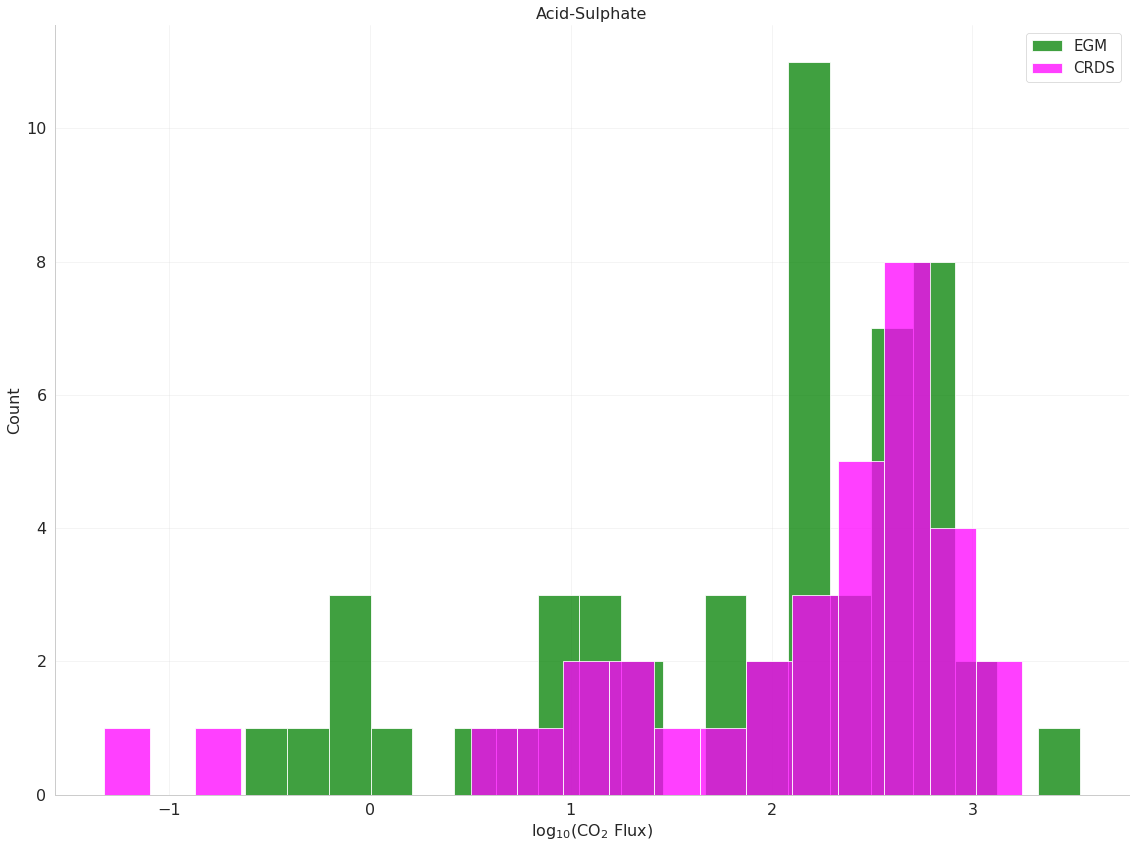

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_egm_sclf_flux_VC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "ks_stat", 
        "pval",
        "n_egm",
        "n_crds"
      ],
    index=range(1)
  )

# Loop through each soil type and check for normality
fig, ax = plt.subplots(figsize=(16,12))

for i in range(1):
  #---VCNP---#
  # Gather Soil Classification
  df_KS_rslts_egm_sclf_flux_VC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_VC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_rslts_egm_sclf_flux_VC.loc[i]["Caldera"] = \
  gb_sclf_egm_VC[i].Caldera.iloc[0]
  # Run KS Test gb_grps_YC[i].CO2_Flux.dropna()
  ## use for original (non-log) data
  # ks_stat, pval = ks_2samp(
  #     gb_sclf_egm_VC[i].fCO2.dropna(), 
  #     gb_sclf_YC[i].CO2_Flux.dropna()
  # )
  ks_stat, pval = ks_2samp(
      gb_sclf_egm_VC[i].CO2_Flux_log10.dropna(), 
      np.log10(gb_sclf_VC[i].CO2_Flux.dropna())
  )
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_egm_sclf_flux_VC.loc[i]["ks_stat"] = ks_stat
  ## pval
  df_KS_rslts_egm_sclf_flux_VC.loc[i]["pval"] = pval
  ## n_egm
  df_KS_rslts_egm_sclf_flux_VC.loc[i]["n_egm"] = \
  len(gb_sclf_egm_VC[i].CO2_Flux_log10.dropna())
  ## n_crds
  df_KS_rslts_egm_sclf_flux_VC.loc[i]["n_crds"] = \
  len(gb_sclf_VC[i].CO2_Flux.dropna())

  # egm
  sns.histplot(
      gb_sclf_egm_VC[i],
      x=gb_sclf_egm_VC[i].CO2_Flux_log10.dropna(),
      color="green",
      bins=20,
      ax=ax
  )
  # crds
  sns.histplot(
      gb_sclf_VC[i],
      x=np.log10(gb_sclf_VC[i].CO2_Flux.dropna()),
      color="magenta",
      bins=20,
      ax=ax
  )

  ax.set_title(
    "{}".format(gb_sclf_egm_VC[i].Soil_Classification.iloc[0]),
    size=16
  )

df_KS_rslts_egm_sclf_flux_YC.to_csv(
      "../../pertinent-data/summary-data/egm_v_crds_ks_test_log10_vc.csv"
  )

ax.set_ylabel("Count", fontsize=16)
ax.set_xlabel("log$_{10}$(CO$_{2}$ Flux)", fontsize=16)

plt.legend(
    [ax.containers[0], ax.containers[1]], 
    ['EGM', 'CRDS']
)
plt.tight_layout()

fig.savefig(
    "../../figures/egm_v_crds_hist_sclf_log10_co2_vc.png"
)

plt.show()

# export results to `.csv`
df_KS_rslts_egm_sclf_flux_VC.to_csv(
    "../../pertinent-data/inferential-stats-output/valles/ks_results_egm_log10_sclf_yc.csv",
    index=False
)

# view results
df_KS_rslts_egm_sclf_flux_VC.style.format(
    formatter={
        "ks_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

As there are only EGM measuerments from three acid-sulphate sites at Valles, the two sample KS test was only applied for one soil chemistry classification. The results show the null hypothesis could not be rejected ($p \sim 0.22$). This means that the EGM measurements across the several acid-sulphate sites at Valles could not be determined as statistically different than the CRDS measurements across the same soil chemistry regime. 

###### Linear (non log)


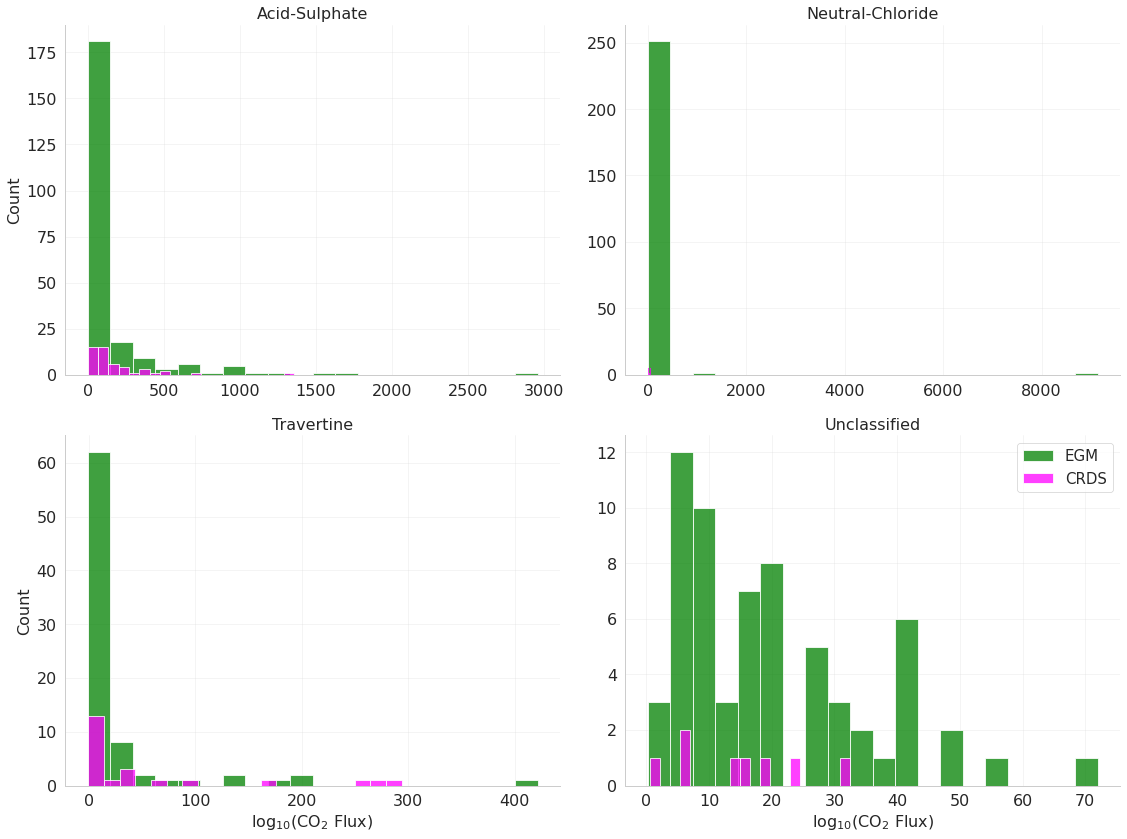

In [ ]:
# Set up the dataframe to receive results
df_KS_rslts_egm_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "ks_stat", 
        "pval"
      ],
    index=range(4)
  )

# Loop through each soil type and check for normality
fig, ax = plt.subplots(2,2, figsize=(16,12))

for i in range(4):
  #---YNP---#
  # Gather Soil Classification
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_YC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_egm_YC[i].Caldera.iloc[0]
  # Run KS Test gb_grps_YC[i].CO2_Flux.dropna()
  ## use for original (non-log) data
  # ks_stat, pval = ks_2samp(
  #     gb_sclf_egm_YC[i].fCO2.dropna(), 
  #     gb_sclf_YC[i].CO2_Flux.dropna()
  # )
  ks_stat, pval = ks_2samp(
      gb_sclf_egm_YC[i].fCO2.dropna(), 
      gb_sclf_YC[i].CO2_Flux.dropna()
  )
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["ks_stat"] = ks_stat
  ## pval
  df_KS_rslts_egm_sclf_flux_YC.loc[i]["pval"] = pval

  df_KS_rslts_egm_sclf_flux_YC.to_csv(
      "../../pertinent-data/summary-data/egm_v_crds_ks_test.csv"
  )

  if i == 0:
    ax_r = 0
    ax_c = 0
  elif i == 1:
    ax_r = 0
    ax_c = 1
  elif i == 2:
    ax_r = 1
    ax_c = 0
  elif i == 3:
    ax_r = 1
    ax_c = 1

  # egm
  sns.histplot(
      gb_sclf_egm_YC[i],
      x=gb_sclf_egm_YC[i].fCO2.dropna(),
      color="green",
      bins=20,
      ax=ax[ax_r, ax_c]
  )
  # crds
  sns.histplot(
      gb_sclf_YC[i],
      x=gb_sclf_YC[i].CO2_Flux.dropna(),
      color="magenta",
      bins=20,
      ax=ax[ax_r, ax_c]
  )

  ax[ax_r, ax_c].set_title(
    "{}".format(gb_sclf_egm_YC[i].Soil_Classification.iloc[0]),
    size=16
  )


ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("Count", fontsize=16)
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[1,0].set_xlabel("log$_{10}$(CO$_{2}$ Flux)", fontsize=16)
ax[1,0].set_ylabel("Count", fontsize=16)
ax[1,1].set_xlabel("log$_{10}$(CO$_{2}$ Flux)", fontsize=16)
ax[1,1].set_ylabel("")

plt.legend(
    [ax[1,1].containers[0], ax[1,1].containers[1]], 
    ['EGM', 'CRDS']
)
plt.tight_layout()

fig.savefig(
    "../../figures/egm_v_crds_hist_sclf_log10_co2.png"
)

plt.show()

# export results to `.csv`
df_KS_rslts_egm_sclf_flux_YC.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/ks_results_egm_sclf_yc.csv",
    index=False
)

# view results
df_KS_rslts_egm_sclf_flux_YC.style.format(
    formatter={
        "ks_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

The linear (non-logged) observations show that none of the null hypotheses can be rejected, except for the Acid-Sulphate class. This lends to the conclusion that the EGM is observin gases from a similar distribution than the CRDS. The exception for the Acid-Sulphate class is likely due to the wide range in values measured across both instruments.

##### One-Sample KS Test

To assess if the logged EGM data originate from a normal distribution, a one-sample KS test is performed. Where the observations are compared against the normal distributionm, which acts as the reference.

###### Yellowstone

In [ ]:
# Set up the dataframe to receive results
df_KS_one_samp_egm_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "ks_stat", 
        "pval"
      ],
    index=range(4)
  )

# Loop through each soil type and check for normality
for i in range(4):
  #---YNP---#
  # Gather Soil Classification
  df_KS_one_samp_egm_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_YC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_one_samp_egm_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_egm_YC[i].Caldera.iloc[0]
  # Run KS Test
  ks_stat, pval = kstest_normal(
      gb_sclf_egm_YC[i].CO2_Flux_log10.dropna()
  )
  # Assign results to dataframe
  ## ks_stat
  df_KS_one_samp_egm_sclf_flux_YC.loc[i]["ks_stat"] = ks_stat
  ## pval
  df_KS_one_samp_egm_sclf_flux_YC.loc[i]["pval"] = pval

df_KS_one_samp_egm_sclf_flux_YC.to_csv(
      "../../pertinent-data/summary-data/egm_ks_one-samp_test_log10.csv"
  )


df_KS_one_samp_egm_sclf_flux_YC.style.format(
    formatter={
        "ks_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

The one-sample KS test rejected the null that the log transformed EGM observations originate from a normal distribution for the Travertine ($p = 0.01$) and Neutral-Chloride ($p = 0.001$) soil chemistry classes.  

However, the one-sample KS test failed to reject the null for Acid-Sulphate ($p = 0.05$) and Unclassified ($p = 0.1$) indicating that a normal distribution may adequately describe the observations from these two classes. _Note, that the Acid-Sulphate class is near the pre-determined alpha value of 0.05._

###### Valles

In [ ]:
# Set up the dataframe to receive results
df_KS_one_samp_egm_sclf_flux_VC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "ks_stat", 
        "pval"
      ],
    index=range(1)
  )

# Loop through each soil type and check for normality
for i in range(1):
  #---VCNP---#
  # Gather Soil Classification
  df_KS_one_samp_egm_sclf_flux_VC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_VC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KS_one_samp_egm_sclf_flux_VC.loc[i]["Caldera"] = \
  gb_sclf_egm_VC[i].Caldera.iloc[0]
  # Run KS Test
  ks_stat, pval = kstest_normal(
      gb_sclf_egm_VC[i].CO2_Flux_log10.dropna()
  )
  # Assign results to dataframe
  ## ks_stat
  df_KS_one_samp_egm_sclf_flux_VC.loc[i]["ks_stat"] = ks_stat
  ## pval
  df_KS_one_samp_egm_sclf_flux_VC.loc[i]["pval"] = pval

df_KS_one_samp_egm_sclf_flux_VC.to_csv(
      "../../pertinent-data/summary-data/egm_ks_one-samp_test_log10_vc.csv"
  )


df_KS_one_samp_egm_sclf_flux_VC.style.format(
    formatter={
        "ks_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

The one-sample KS test demonstrated that the theoretical distribution of the EGM data is significantly different ($p \sim 0.001$) than the reference normal distribution. In assessment of other possible distributions to describe the EGM data, KS tests showed that genlogistic ($p > 0.71$) and loggamma ($p > 0.45$) could not detemermined to be significantly different than their reference distributions.

##### FK Test

Analysis of unequal variance across groups

###### Yellowstone

In [ ]:
# Set up the dataframe to receive results
df_FK_rslts_egm_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "fk_stat", 
        "pval",
        "n_egm",
        "n_crds"
      ],
    index=range(4)
  )

for i in range(4):
  fk_stat, pval = fligner(
      gb_sclf_egm_YC[i].CO2_Flux_log10.dropna(),
      np.log10(gb_sclf_YC[i].CO2_Flux)
  )

  # Assign results to dataframe
  ## soil classification
  df_FK_rslts_egm_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_YC[i].Soil_Classification.iloc[0]
  ## caldera
  df_FK_rslts_egm_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_egm_YC[i].Caldera.iloc[0]
  ## fk_stat
  df_FK_rslts_egm_sclf_flux_YC.loc[i]["fk_stat"] = fk_stat
  ## pval
  df_FK_rslts_egm_sclf_flux_YC.loc[i]["pval"] = pval
  ## n_egm
  df_FK_rslts_egm_sclf_flux_YC.loc[i]["n_egm"] = \
  len(gb_sclf_egm_YC[i].CO2_Flux_log10.dropna())
  ## n_crds
  df_FK_rslts_egm_sclf_flux_YC.loc[i]["n_crds"] = \
  len(gb_sclf_YC[i].CO2_Flux.dropna())

# export results to a `.csv`
df_FK_rslts_egm_sclf_flux_YC.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/fk_results_egm_v_crds_log10_sclf_yc.csv",
    index=False
)

df_FK_rslts_egm_sclf_flux_YC.style.format(
    formatter={
        "fk_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


The FK test rejects the null ($p ≤ 0.0001$) and shows that the variance between the EGM and CRDS is unequal. However, the unclassified soil chemistry class failed to reject the null hypothesis and is the lone exception for these tests.

###### Valles

In [ ]:
# Set up the dataframe to receive results
df_FK_rslts_egm_sclf_flux_VC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "fk_stat", 
        "pval",
        "n_egm",
        "n_crds"
      ],
    index=range(1)
  )

for i in range(1):
  fk_stat, pval = fligner(
      gb_sclf_egm_VC[i].CO2_Flux_log10.dropna(),
      np.log10(gb_sclf_YC[i].CO2_Flux)
  )

  # Assign results to dataframe
  ## soil classification
  df_FK_rslts_egm_sclf_flux_VC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_VC[i].Soil_Classification.iloc[0]
  ## caldera
  df_FK_rslts_egm_sclf_flux_VC.loc[i]["Caldera"] = \
  gb_sclf_egm_VC[i].Caldera.iloc[0]
  ## fk_stat
  df_FK_rslts_egm_sclf_flux_VC.loc[i]["fk_stat"] = fk_stat
  ## pval
  df_FK_rslts_egm_sclf_flux_VC.loc[i]["pval"] = pval
  ## n_egm
  df_FK_rslts_egm_sclf_flux_VC.loc[i]["n_egm"] = \
  len(gb_sclf_egm_VC[i].CO2_Flux_log10.dropna())
  ## n_crds
  df_FK_rslts_egm_sclf_flux_VC.loc[i]["n_crds"] = \
  len(gb_sclf_YC[i].CO2_Flux.dropna())

# export results to a `.csv`
df_FK_rslts_egm_sclf_flux_VC.to_csv(
    "../../pertinent-data/inferential-stats-output/valles/fk_results_egm_v_crds_log10_sclf_vc.csv",
    index=False
)

df_FK_rslts_egm_sclf_flux_VC.style.format(
    formatter={
        "fk_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


The FK test for Valles demonstrates that the solitary soil chemistry class (Acid-Sulphate) rejects the null that the EGM data has the same amount of variance as the CRDS data.

###### Linear (non-log)

In [ ]:
## CO2
fk_stat, pval = fligner(
    gb_sclf_YC[0].CO2_Flux,
    gb_sclf_egm_YC[0].fCO2.dropna(),
    gb_sclf_YC[1].CO2_Flux,
    gb_sclf_egm_YC[1].fCO2.dropna(),
    gb_sclf_YC[2].CO2_Flux, 
    gb_sclf_egm_YC[2].fCO2.dropna(),
    gb_sclf_YC[3].CO2_Flux,
    gb_sclf_egm_YC[3].fCO2.dropna(),
  )
print("After applying the FK test to the YNP CO2 Flux data, \nthe FK stat is {:.2f} and the p-value is {:.3e}\n".format(fk_stat, pval))

# consolidate results into a dataframe
df_FK_rslts_sclf_flux_yc = pd.DataFrame(
    {
      "fk_stat":fk_stat,
      "pval":pval
    },
    index=range(1)
)

# export results to a `.csv`
df_FK_rslts_sclf_flux_yc.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/fk_results_egm_v_crds_sclf_yc.csv",
    index=False
)

After applying the FK test to the YNP CO2 Flux data, 
the FK stat is 282.29 and the p-value is 3.643e-57



##### KW Test

Non-parametric version of an ANOVA

###### Yellowstone

In [ ]:
# Set up the dataframe to receive results
df_KW_rslts_egm_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "kw_stat", 
        "pval",
        "n_egm",
        "n_crds"
      ],
    index=range(4)
  )

# Loop through each soil type and check for normality
for i in range(4):
  #---YNP---#
  # Gather Soil Classification
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_YC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_egm_YC[i].Caldera.iloc[0]

  kw_stat, pval = kruskal(
      gb_sclf_egm_YC[i].CO2_Flux_log10, 
      np.log10(gb_sclf_YC[i].CO2_Flux),
      nan_policy="omit"
  )
  # Assign results to dataframe
  ## kw_stat
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["kw_stat"] = kw_stat
  ## pval
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["pval"] = pval
  ## n_egm
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["n_egm"] = \
  len(gb_sclf_egm_YC[i].CO2_Flux_log10.dropna())
  ## n_crds
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["n_crds"] = \
  len(gb_sclf_YC[i].CO2_Flux.dropna())

# export results to `.csv`
df_KW_rslts_egm_sclf_flux_YC.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/kw_results_egm_log10_sclf_yc.csv",
    index=False
)

# view results
df_KW_rslts_egm_sclf_flux_YC.style.format(
    formatter={
        "kw_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

The KW test fails to reject that the median values from the EGM data come from different populations than the median values observed by the CRDS across the soil chemistry classes. The exception is the Acid-Sulphate group, which rejects the null ($p ≤ 0.01$).

###### Valles

In [ ]:
# Set up the dataframe to receive results
df_KW_rslts_egm_sclf_flux_VC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "kw_stat", 
        "pval",
        "n_egm",
        "n_crds"
      ],
    index=range(1)
  )

# Loop through each soil type and check for normality
for i in range(1):
  #---YNP---#
  # Gather Soil Classification
  df_KW_rslts_egm_sclf_flux_VC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_VC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KW_rslts_egm_sclf_flux_VC.loc[i]["Caldera"] = \
  gb_sclf_egm_VC[i].Caldera.iloc[0]

  kw_stat, pval = kruskal(
      gb_sclf_egm_VC[i].CO2_Flux_log10, 
      np.log10(gb_sclf_YC[i].CO2_Flux),
      nan_policy="omit"
  )
  # Assign results to dataframe
  ## kw_stat
  df_KW_rslts_egm_sclf_flux_VC.loc[i]["kw_stat"] = kw_stat
  ## pval
  df_KW_rslts_egm_sclf_flux_VC.loc[i]["pval"] = pval
  ## n_egm
  df_KW_rslts_egm_sclf_flux_VC.loc[i]["n_egm"] = \
  len(gb_sclf_egm_VC[i].CO2_Flux_log10.dropna())
  ## n_crds
  df_KW_rslts_egm_sclf_flux_VC.loc[i]["n_crds"] = \
  len(gb_sclf_YC[i].CO2_Flux.dropna())

# export results to `.csv`
df_KW_rslts_egm_sclf_flux_VC.to_csv(
    "../../pertinent-data/inferential-stats-output/valles/kw_results_egm_log10_sclf_vc.csv",
    index=False
)

# view results
df_KW_rslts_egm_sclf_flux_VC.style.format(
    formatter={
        "kw_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


The KW test conducted on the Valles EGM and CRDS data show that the null hypothesis cannot be rejected indicating that the EGM and CRDS data come from the same distribution for the measurements collected at Acid-Sulphate sites.

###### Linear (non-log)

In [ ]:
# Set up the dataframe to receive results
df_KW_rslts_egm_sclf_flux_YC = pd.DataFrame(
    columns=[
        "Soil_Classification",
        "Caldera",
        "kw_stat", 
        "pval"
      ],
    index=range(4)
  )

# Loop through each soil type and check for normality
for i in range(4):
  #---YNP---#
  # Gather Soil Classification
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["Soil_Classification"] = \
  gb_sclf_egm_YC[i].Soil_Classification.iloc[0]
  # Gather Caldera
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["Caldera"] = \
  gb_sclf_egm_YC[i].Caldera.iloc[0]

  kw_stat, pval = kruskal(
      gb_sclf_egm_YC[i].fCO2, 
      gb_sclf_YC[i].CO2_Flux,
      nan_policy="omit"
  )
  # Assign results to dataframe
  ## kw_stat
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["kw_stat"] = kw_stat
  ## pval
  df_KW_rslts_egm_sclf_flux_YC.loc[i]["pval"] = pval

# export results to `.csv`
df_KW_rslts_egm_sclf_flux_YC.to_csv(
    "../../pertinent-data/inferential-stats-output/yellowstone/kw_results_egm_sclf_yc.csv",
    index=False
)

# view results
df_KW_rslts_egm_sclf_flux_YC.style.format(
    formatter={
        "kw_stat": "{:.3e}",
        "pval": "{:.3e}"
    }
)

The linear scale (non-logged) EGM fluxes appear to be significantly different from the CRDS only in the case of the Acid-Sulphate group. The remaining soil chemistry classes are unable to reject the null that the EGM data come from a population with a different median than the CRDS.

#### Boxplot of fluxes -- EGM v CRDS

##### Yellowstone

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: Settin

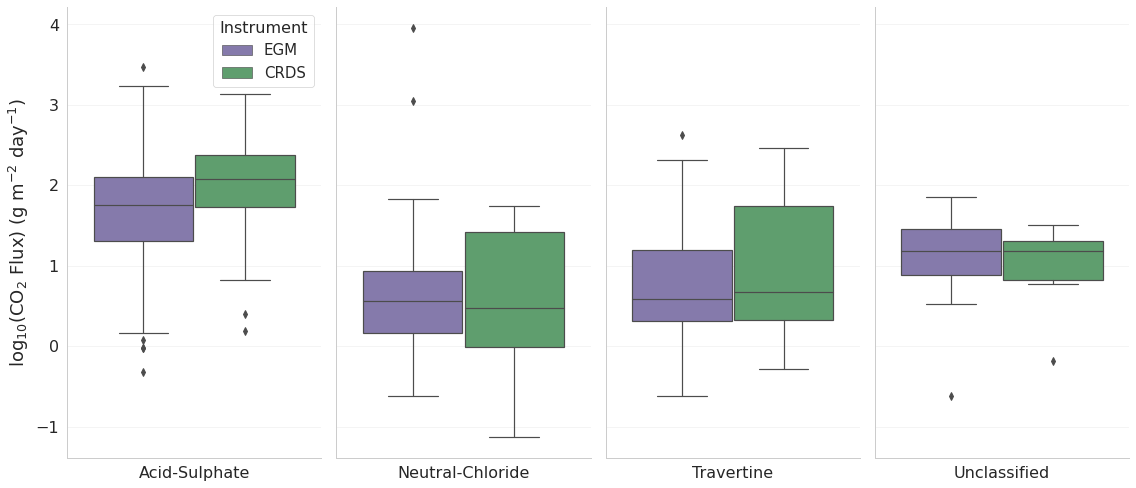

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,7), sharey=True)
for i in range(4):
  x = gb_sclf_egm_YC[i][["Soil_Classification", "Caldera", "CO2_Flux_log10"]]
  x["Instrument"] = "EGM"

  y = gb_sclf_YC[i][["Soil_Classification", "Caldera", "CO2_Flux"]]
  y["CO2_Flux_log10"] = np.log10(y["CO2_Flux"])
  y["Instrument"] = "CRDS"

  df = pd.concat([x,y])

  g = sns.boxplot(
    data=df,
    x="Soil_Classification", 
    y="CO2_Flux_log10",
    hue="Instrument", 
    palette=["m", "g"],
    ax=ax[i]
  )
  
  ax[i].set_yscale("linear")
  ax[i].set_xlabel("")
  if i == 0:
    ax[i].set_ylabel(
        "log$_{10}$(CO$_{2}$ Flux) (g m$^{-2}$ day$^{-1}$)",
        fontsize=18
      )
  elif i > 0:
    ax[i].get_legend().remove()
    ax[i].set_ylabel("")

plt.tight_layout()
fig.savefig(
    "../../figures/egm_v_crds_boxplots_sclf_log10.png"
)

plt.show()

##### Valles

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: Settin

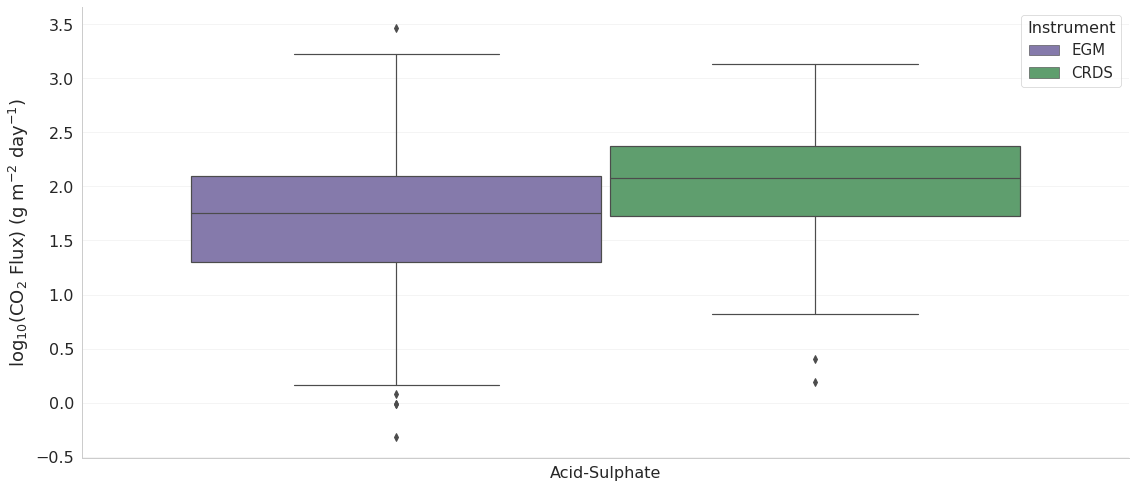

In [ ]:
fig, ax = plt.subplots(figsize=(16,7), sharey=True)
for i in range(1):
  x = gb_sclf_egm_YC[i][["Soil_Classification", "Caldera", "CO2_Flux_log10"]]
  x["Instrument"] = "EGM"

  y = gb_sclf_YC[i][["Soil_Classification", "Caldera", "CO2_Flux"]]
  y["CO2_Flux_log10"] = np.log10(y["CO2_Flux"])
  y["Instrument"] = "CRDS"

  df = pd.concat([x,y])

  g = sns.boxplot(
    data=df,
    x="Soil_Classification", 
    y="CO2_Flux_log10",
    hue="Instrument", 
    palette=["m", "g"],
    ax=ax
  )
  ax.set_yscale("linear")
  ax.set_xlabel("")
  if i > 0:
    ax.get_legend().remove()
    ax.set_ylabel("")

ax.set_ylabel(
    "log$_{10}$(CO$_{2}$ Flux) (g m$^{-2}$ day$^{-1}$)",
    fontsize=18
)
plt.tight_layout()
fig.savefig(
    "../../figures/egm_v_crds_boxplots_sclf_log10_vc.png"
)

plt.show()

### EGM _Ad hoc_ Analysis and Visualizations

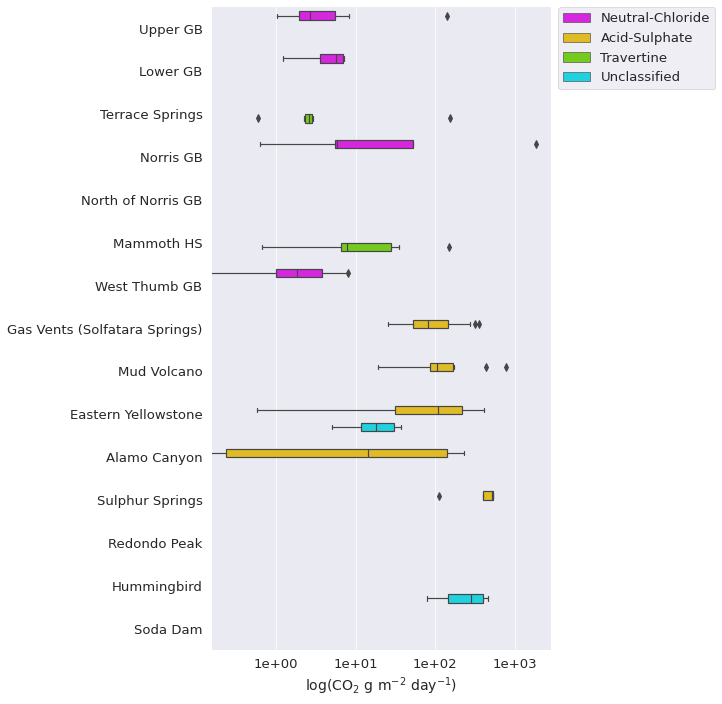

In [ ]:
## CO2 - Yellowstone
p_CO2_flx = sns.catplot(
    x="fCO2_mean", 
    y="Group", 
    data=df_xy, 
    kind="box",
    hue="Soil_Classification", 
    orient="h",
    height=10, 
    aspect=1.03,
    legend_out=False, 
    palette="gist_ncar_r"
)
p_CO2_flx.set_axis_labels(
    "log(CO$_2$ g m$^{-2}$ day$^{-1}$)", 
    "",
    fontsize=14
)
p_CO2_flx.set(xscale="log")
for ax in p_CO2_flx.axes.flat:
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'{y:2.0e}'))
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
# Save plot to Google Drive Directory  
plt.savefig("../../figures/EGM_CO2_flx_all_box.png", dpi=300)

Boxplot for EGM Data: Boxplots of CO<sub>2</sub> fluxes collected using the EGM-5 chamber. Each boxplot is colored by the soil classification. Note the logged x-axis and there are two box plots (acid-sulphate and unclassified) for the Eastern Yellowstone site. Rows without boxplots indicate that no EGM measurements were collected at that site.

Visualize the differences between average EGM CO2 flux and the CRDS-AC

In [ ]:
x = df_xy[(df_xy["CO2_Flux"] > 0) & (df_xy["fCO2_mean"] > 0)]
df_xy_pos_only = df_xy.loc[x.index]

Using only fluxes that are greater than zero, the EGM CO<sub>2</sub> fluxes are examined against the CRDS-AC Fluxes.

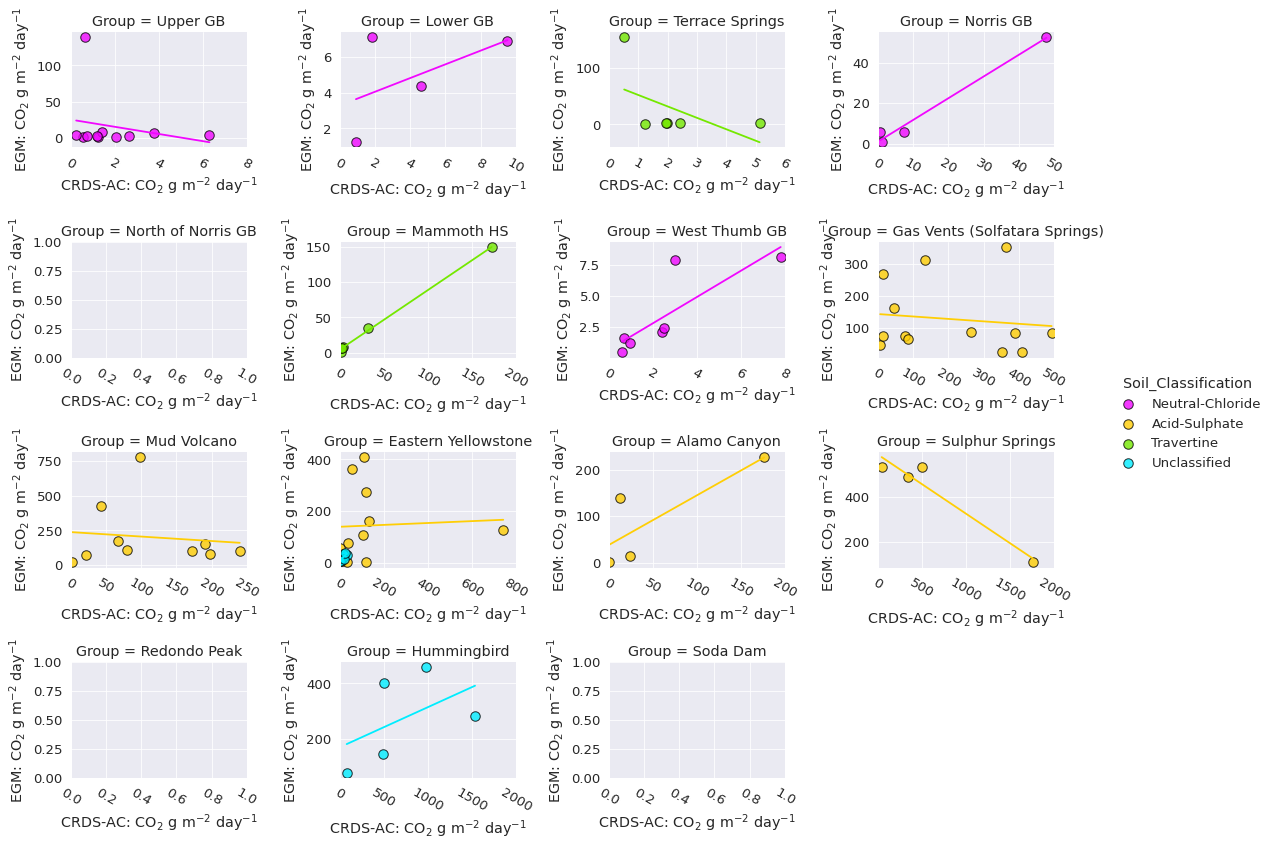

In [ ]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def refline_fg(data, **kws):
  ax = plt.gca()
  line = mlines.Line2D([0,1], [0,1], color="black")
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  ax.set_xlim(0,None)
  ax.set_ylim(0,None)

# Visualize the differences
## Avg EGM CO2 vs CRDS-AC measurements
fg = sns.FacetGrid(df_xy_pos_only,
                   palette="gist_ncar_r",
                   hue="Soil_Classification",
                   col="Group", col_wrap=4, 
                   height=3, aspect=1.3, 
                   sharex=False, sharey=False)
fg.map_dataframe(sns.regplot, x="CO2_Flux", y="fCO2_mean", ci=None,
                 scatter_kws={"s":90, "edgecolors":"k"})
#fg.map_dataframe(refline_fg)
fg.set(xlabel="CRDS-AC: CO$_2$ g m$^{-2}$ day$^{-1}$",
       ylabel="EGM: CO$_2$ g m$^{-2}$ day$^{-1}$")
plt.rcParams.update({'font.size': 18})
fg.set_xticklabels(rotation=-30)
fg.add_legend()
fg.tight_layout()
plt.savefig("../../figures/all_EGM_CO2_flx_v_Picarro_CO2_flx.png", dpi=300)

Figure ##: EGM CO<sub>2</sub> fluxes are compared aginst CRDS-AC CO<sub>2</sub>  fluxes. Each scatter plot represents a different group, and the data has been seprarted by soil classification with color. 

The measurements collected by  portable EGM chmaber are compareed to the less mobile CRDS-AC. This relationship sheds light on how much fine-scale heterogeneity exists with regard to the fluxes at each site. Recall, the EGM measuurements  

In [ ]:
# Import the ordinary least squares algorithm from statsmodels
import statsmodels.formula.api as sm 
# Establish column names for results dataframe
columns = ["Group", "Soil_Classification", "egm", "intcpt", 
           "egm_pval", "intcpt_pval", "r2", "f_stat", "f_pval",
           "nobs"]
# Create empty dataframe           
df_EGM_ols_rslts = pd.DataFrame(columns=columns, index=range(15))
# Group data by the group        
df_xy_pos_only_grp = df_xy_pos_only.groupby(by=["Group"])
# Loop through the EGM data and apply an OLS to each group
for i, group in zip(range(15), df_xy_pos_only_grp.groups.keys()):
  ## Skip the groups that do not have EGM data
  if group == "North of Norris GB":
    continue
  elif group == "Redondo Peak":
    continue
  elif group == "Soda Dam":
    continue
  ## Run a linear regression for those that have EGM data  
  else:
    df = df_xy_pos_only_grp.get_group(group)
    df['constant']=1
    egm = df[['fCO2_mean']]
    crds_ac = df[['CO2_Flux']]
    results = sm.ols("crds_ac ~ egm", data=df).fit()
    ## Add relevant data to output dataframe
    df_EGM_ols_rslts.loc[i]["Group"] = group
    df_EGM_ols_rslts.loc[i]["Soil_Classification"] =  \
    df["Soil_Classification"].iloc[0]
    df_EGM_ols_rslts.loc[i]["egm"] = results.params["egm"]
    df_EGM_ols_rslts.loc[i]["intcpt"] = results.params["Intercept"]
    df_EGM_ols_rslts.loc[i]["egm_pval"] = results.pvalues["egm"]
    df_EGM_ols_rslts.loc[i]["intcpt_pval"] = results.pvalues["Intercept"]
    df_EGM_ols_rslts.loc[i]["r2"] = results.rsquared
    df_EGM_ols_rslts.loc[i]["f_stat"] = results.fvalue
    df_EGM_ols_rslts.loc[i]["f_pval"] = results.f_pvalue
    df_EGM_ols_rslts.loc[i]["nobs"] = results.nobs
    print(group)
    print(results.summary())
    # Print Summary to .txt File
    ols_txt_summary = "regression/egm-regression/%s_ols_egm_cRDS_regression.txt" % group
    print(results.summary(), file= open(ols_txt_summary, "w"))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


Upper GB
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.4439
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.522
Time:                        17:30:31   Log-Likelihood:                -21.254
No. Observations:                  11   AIC:                             46.51
Df Residuals:                       9   BIC:                             47.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0488      0.601      3.411

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


Terrace Springs
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1.437
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.297
Time:                        17:30:32   Log-Likelihood:                -9.7980
No. Observations:                   6   AIC:                             23.60
Df Residuals:                       4   BIC:                             23.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5710      0.689    

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


Mammoth HS
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1490.
Date:                Wed, 21 Apr 2021   Prob (F-statistic):           2.69e-06
Time:                        17:30:32   Log-Likelihood:                -15.523
No. Observations:                   6   AIC:                             35.05
Df Residuals:                       4   BIC:                             34.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1788      1.924     -2.6

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


West Thumb GB
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     10.34
Date:                Wed, 21 Apr 2021   Prob (F-statistic):             0.0236
Time:                        17:30:33   Log-Likelihood:                -11.878
No. Observations:                   7   AIC:                             27.76
Df Residuals:                       5   BIC:                             27.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3920      0.899      

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


Gas Vents (Solfatara Springs)
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.075
Method:                 Least Squares   F-statistic:                    0.1670
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.691
Time:                        17:30:33   Log-Likelihood:                -85.208
No. Observations:                  13   AIC:                             174.4
Df Residuals:                      11   BIC:                             175.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    229.1557 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.110
Method:                 Least Squares   F-statistic:                    0.1083
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.751
Time:                        17:30:33   Log-Likelihood:                -57.761
No. Observations:                  10   AIC:                             119.5
Df Residuals:                       8   BIC:                             120.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.7575     37.537      3.190      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


Alamo Canyon
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     4.098
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.180
Time:                        17:30:34   Log-Likelihood:                -20.522
No. Observations:                   4   AIC:                             45.04
Df Residuals:                       2   BIC:                             43.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.1631     41.274     -0

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


Sulphur Springs
                            OLS Regression Results                            
Dep. Variable:                crds_ac   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     29.53
Date:                Wed, 21 Apr 2021   Prob (F-statistic):             0.0322
Time:                        17:30:34   Log-Likelihood:                -26.093
No. Observations:                   4   AIC:                             56.19
Df Residuals:                       2   BIC:                             54.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2152.2339    298.151    

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


In [ ]:
# Clean up the results dataframe
df_EGM_ols_rslts.dropna(inplace=True)
df_EGM_ols_rslts.reset_index(inplace=True, drop=True)
# Export the dataframe to a .csv
df_EGM_ols_rslts.to_csv("df_EGM_ols_rslts.csv", sep=",", index=False)
df_EGM_ols_rslts

Group Soil_Classification  ...       f_pval nobs
0                        Upper GB    Neutral-Chloride  ...     0.521938   11
1                        Lower GB    Neutral-Chloride  ...       0.4601    4
2                 Terrace Springs          Travertine  ...     0.296768    6
3                       Norris GB    Neutral-Chloride  ...   0.00734314    4
4                      Mammoth HS          Travertine  ...  2.69143e-06    6
5                   West Thumb GB    Neutral-Chloride  ...    0.0235668    7
6   Gas Vents (Solfatara Springs)       Acid-Sulphate  ...     0.690623   13
7                     Mud Volcano       Acid-Sulphate  ...     0.750563   10
8             Eastern Yellowstone       Acid-Sulphate  ...     0.351006   19
9                    Alamo Canyon       Acid-Sulphate  ...     0.180223    4
10                Sulphur Springs       Acid-Sulphate  ...    0.0322369    4
11                    Hummingbird        Unclassified  ...     0.394388    5

[12 rows x 10 columns]

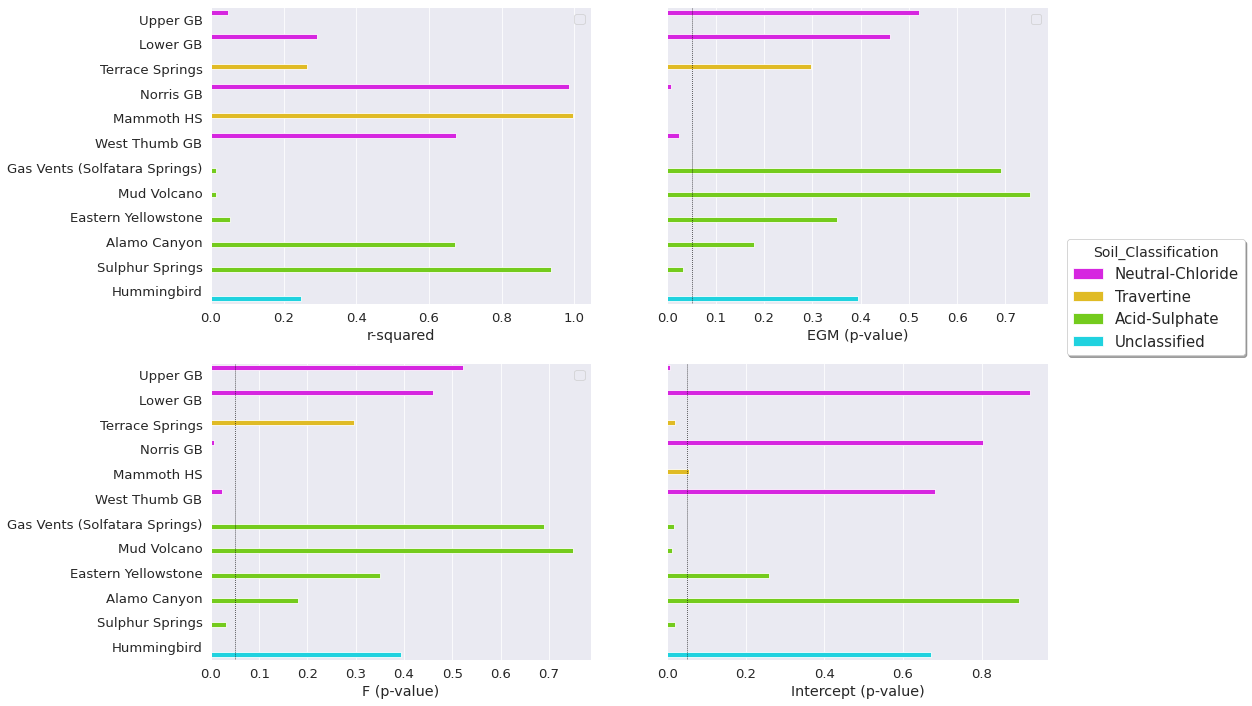

In [ ]:
# Combine this with the other plot in a four pack
fig, axes = plt.subplots(nrows=2,ncols=2,  figsize=(15,12),
                         sharex=False, sharey=True)
## R-squared - coefficient of determination to describe the percentage of
## variation that can be explained by the independent variable
bar1 = sns.barplot(x="r2", y="Group", data=df_EGM_ols_rslts,
                   hue="Soil_Classification", palette="gist_ncar_r",
                   ax=axes[0,0])
bar1.legend("")
bar1.set(xlabel="r-squared", ylabel="")
## F-test p-value - determines a significant relationship between the 
## independent variable on the response variable
bar2 = sns.barplot(x="f_pval", y="Group", data=df_EGM_ols_rslts,
                   hue="Soil_Classification", palette="gist_ncar_r",
                   ax=axes[1,0])
axes[1,0].axvline(0.05, linewidth=0.75,  ls=":", color="k")
bar2.legend("")
bar2.set(xlabel="F (p-value)", ylabel="")
## X p-value - determines a significant relationship between the 
## independent variable on the response variable
bar3 = sns.barplot(x="egm_pval", y="Group", data=df_EGM_ols_rslts,
                   hue="Soil_Classification", palette="gist_ncar_r",
                   ax=axes[0,1])
axes[0,1].axvline(0.05, linewidth=0.75,  ls=":", color="k")
bar3.legend("")
bar3.set(xlabel="EGM (p-value)", ylabel="")
## X p-value - determines a significant relationship between the 
## EGM fluxes on the CRDS-AC
bar4 = sns.barplot(x="intcpt_pval", y="Group", data=df_EGM_ols_rslts,
                   hue="Soil_Classification", palette="gist_ncar_r",
                   ax=axes[1,1])
axes[1,1].axvline(0.05, linewidth=0.75,  ls=":", color="k")
bar4.legend(fontsize = 15,
               bbox_to_anchor= (1.03, 1),
               title="Soil_Classification",
               title_fontsize = 14,
               shadow = True,
               facecolor = 'white');
bar4.set(xlabel="Intercept (p-value)", ylabel="")
# Export Figure
plt.savefig("../../figures/all_EGM_CO2_v_Picarro_CO2_flx_ols_analysis.png", dpi=300)

Figure ##: R<sup>2</sup>, p-value of F-statistic, p-value of EGM fluxes, and p-value of Intercept from least squares regression of CRDS-AC (CO<sub>2</sub> Fluxes) \~ EGM CO<sub>2</sub> Fluxes. Bars to the left of the thin black line in the relevant plots indicate group meets the level of 0.05 signifcance. All groups without EGM measurements have been omitted from this chart.

Ordinary least squares (OLS) regression was applied to evaluate the relationship between the CRDS-AC CO2 and EGM CO2 fluxes. The response variable was the CO2 fluxes from the CRDS-AC, and the explanatory variable was the CO2 fluxes from the EGM chamber. The objective was to see how much of the variation in the CRDS

In [ ]:
df_EGM_ols_rslts.sort_values("f_pval", ascending=True)

Group Soil_Classification  ...       f_pval nobs
4                      Mammoth HS          Travertine  ...  2.69143e-06    6
3                       Norris GB    Neutral-Chloride  ...   0.00734314    4
5                   West Thumb GB    Neutral-Chloride  ...    0.0235668    7
10                Sulphur Springs       Acid-Sulphate  ...    0.0322369    4
9                    Alamo Canyon       Acid-Sulphate  ...     0.180223    4
2                 Terrace Springs          Travertine  ...     0.296768    6
8             Eastern Yellowstone       Acid-Sulphate  ...     0.351006   19
11                    Hummingbird        Unclassified  ...     0.394388    5
1                        Lower GB    Neutral-Chloride  ...       0.4601    4
0                        Upper GB    Neutral-Chloride  ...     0.521938   11
6   Gas Vents (Solfatara Springs)       Acid-Sulphate  ...     0.690623   13
7                     Mud Volcano       Acid-Sulphate  ...     0.750563   10

[12 rows x 10 columns]

## δ<sup>13</sup>C Summary

### Partitioning Isotopes 
To build on the partitioning of fluxes, isotopes can be incorporated into the GSA to further delineate populations (Chiodini et al., (2008) and negate the arbitrary selection fo inflection points (Smith, 2016; Wen et al. (2016)).

In [55]:
# Create trimmed dataframe (use isotopes to trim)
df_all_iso_pos_only = df_all[(df_all["d13CH4_source"] <= 0) &
                         (df_all["d13CH4_source"] >= -100) &
                         (df_all["d13CO2_source"] <= 0) &
                         (df_all["d13CO2_source"] >= -30)]
# Quantify the error for the isotopes  
df_all_iso_pos_only["d13CH4_err"] = df_all_iso_pos_only.d13CH4_UpperBound_source - df_all_iso_pos_only.d13CH4_LowerBound_source
df_all_iso_pos_only["d13CO2_err"] = df_all_iso_pos_only.d13CO2_UpperBound_source - df_all_iso_pos_only.d13CO2_LowerBound_source                               
df_all_iso_pos_only.head()

<ipython-input-55-c5246fa84a09>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_iso_pos_only["d13CH4_err"] = df_all_iso_pos_only.d13CH4_UpperBound_source - df_all_iso_pos_only.d13CH4_LowerBound_source
<ipython-input-55-c5246fa84a09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_iso_pos_only["d13CO2_err"] = df_all_iso_pos_only.d13CO2_UpperBound_source - df_all_iso_pos_only.d13CO2_LowerBound_source


Site_Name            Group            Location Soil_Classification  \
0  Sulphur Springs  Sulphur Springs  VCSS_08Jul2017_1.1       Acid-Sulphate   
1  Sulphur Springs  Sulphur Springs  VCSS_08Jul2017_1.2       Acid-Sulphate   
2  Sulphur Springs  Sulphur Springs  VCSS_08Jul2017_1.3       Acid-Sulphate   
3  Sulphur Springs  Sulphur Springs  VCSS_10Jul2017_1.4       Acid-Sulphate   
4  Sulphur Springs  Sulphur Springs  VCSS_10Jul2017_1.5       Acid-Sulphate   

    Latitude   Longitude Date_of_Measurement Start_Time_of_Chamber_Enclosure  \
0  35.907929 -106.615888          2017-07-08             2017-07-08 12:14:37   
1  35.907838 -106.615947          2017-07-08             2017-07-08 12:57:24   
2  35.907716 -106.615991          2017-07-08             2017-07-08 13:47:18   
3  35.907632 -106.616073          2017-07-10             2017-07-10 11:04:39   
4  35.907598 -106.616118          2017-07-10             2017-07-10 11:55:26   

  End_Time_of_Chamber_Enclosure  Duration_of_Total_Chamber_Enclosure  ...  \
0           2017-07-08 12:24:59                            10.366667  ...   
1           2017-07-08 13:00:37                             3.216667  ...   
2           2017-07-08 14:07:45                            20.450000  ...   
3           2017-07-10 11:24:55                            20.266667  ...   
4           2017-07-10 12:02:21                             6.916667  ...   

  KP_LowerBound_d13CO2_source KP_UpperBound_d13CO2_source  d13CO2_source  \
0                   -1.282136                   -0.660515      -4.815441   
1                   -3.799772                   -2.945493      -6.122984   
2                   -7.995603                   -7.740447      -8.355437   
3                  -13.800998                  -12.559483     -10.078260   
4                   -3.359028                   -2.998874      -4.348764   

   d13CO2_LowerBound_source  d13CO2_UpperBound_source  \
0                 -5.164223                 -4.466659   
1                 -6.414749                 -5.831219   
2                 -8.730671                 -7.980202   
3                -10.449797                 -9.706724   
4                 -4.692456                 -4.005072   

   Soil_Tempeature_at_Surface  caldera_side  Caldera  d13CH4_err  d13CO2_err  
0                        22.4         north     VCNP    3.551619    0.697563  
1                        22.5         north     VCNP    4.527058    0.583530  
2                        23.4         north     VCNP    4.045108    0.750469  
3                        22.4         north     VCNP    3.797414    0.743074  
4                        24.7         north     VCNP    4.380176    0.687384  

[5 rows x 35 columns]

#### Visualize the Distribution of Carbon Isotopes
Similar to Chiodini et al., (2008), the carbon isotopes are plotted against the magnitude of the fluxes. Following this presentation, the isotopes are visualized a density plot to ascertain the shape of their distribution. Using similar tests as with the examination of the fluxes, the best fit for the observed data will be applied to the isotopes. 



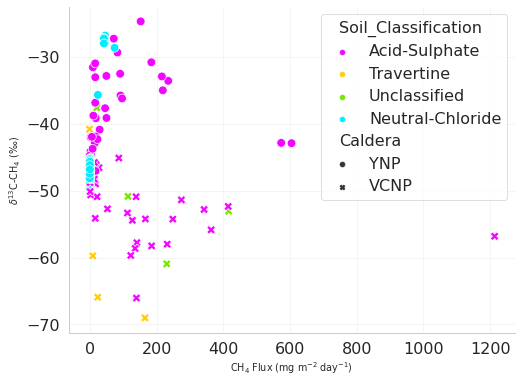

<Figure size 432x288 with 0 Axes>

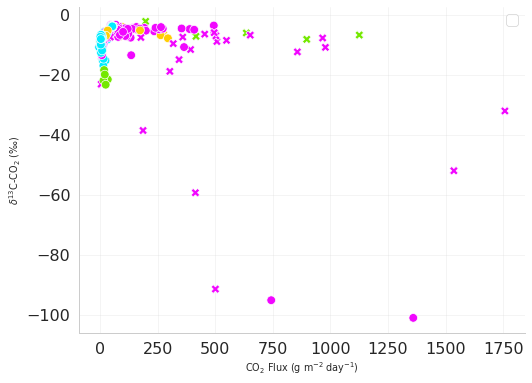

<Figure size 432x288 with 0 Axes>

In [91]:
# Scatter plot for d13C vs Fluxes
markers = {"YNP":"o", "VCNP":"X"}
## CH4
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x="CH4_Flux", y="d13CH4_source", data=df_all, s=75,
                     hue="Soil_Classification", palette="gist_ncar_r",
                     style="Caldera", markers=markers)
ax.set(xlabel="CH$_4$ Flux (mg m$^{-2}$ day$^{-1}$)",
       ylabel="$\delta^{13}$C-CH$_4$ (‰)")
plt.show()
plt.savefig("../../figures/CH4_d13_flx_all.png", dpi=300)
## CO2
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x="CO2_Flux", y="d13CO2_source", data=df_all, s=75,
                     hue="Soil_Classification", palette="gist_ncar_r",
                     style="Caldera", markers=markers)
ax.set(xlabel="CO$_2$ Flux (g m$^{-2}$ day$^{-1}$)",
       ylabel="$\delta^{13}$C-CO$_2$ (‰)")
ax.legend("")
plt.show()
plt.savefig("../../figures/CO2_d13_flx_all.png", dpi=300)

#### Summary tables for fluxes contional on δ13C values

In [ ]:
print(df_all_iso_pos_only[(df_all_iso_pos_only["Caldera"]=="VCNP") &
                      (df_all_iso_pos_only["d13CO2_source"]<= -8)].shape)
print(df_all_iso_pos_only[(df_all_iso_pos_only["Caldera"]=="VCNP")&
                      (df_all_iso_pos_only["d13CO2_source"]>= -5)].shape)

(18, 34)
(6, 34)


In [ ]:
df_all_iso_pos_only[(df_all_iso_pos_only["Caldera"]=="VCNP") &
                (df_all_iso_pos_only["d13CO2_source"]>=-5)][["CH4_Flux", "CO2_Flux"]].agg([np.mean, np.std])

CH4_Flux    CO2_Flux
mean  9.453830  101.543372
std   9.676143   58.168393

In [ ]:
df_all_iso_pos_only[(df_all_iso_pos_only["Caldera"]=="YNP") & 
                (df_all_iso_pos_only["d13CO2_source"]>=-5)][["CH4_Flux", "CO2_Flux"]].agg([np.mean, np.std])

CH4_Flux    CO2_Flux
mean  42.517847  125.377133
std   49.212948  110.322345

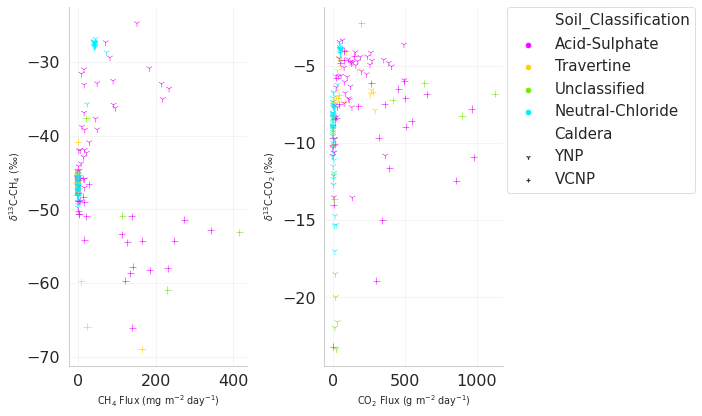

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure(figsize=(10,6))
## CH4
plt.subplot(1,2,1)
ax = plt.gca()
sns.scatterplot(x="CH4_Flux", y="d13CH4_source", data=df_all_iso_pos_only,
                hue="Soil_Classification", palette="gist_ncar_r", s=50,
                style="Caldera", markers=markers)
ax.set(xlabel="CH$_4$ Flux (mg m$^{-2}$ day$^{-1}$)",
       ylabel="$\delta^{13}$C-CH$_4$ (‰)")
plt.legend([],[], frameon=False)

## CO2
plt.subplot(1,2,2)
ax = plt.gca()
sns.scatterplot(x="CO2_Flux", y="d13CO2_source", data=df_all_iso_pos_only,
                hue="Soil_Classification", palette="gist_ncar_r", s=50,
                style="Caldera", markers=markers)
ax.set(xlabel="CO$_2$ Flux (g m$^{-2}$ day$^{-1}$)",
       ylabel="$\delta^{13}$C-CO$_2$ (‰)")
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()
plt.savefig("../../figures/d13C_v_flx_pos_only.png", dpi=300)

Figure ##: 

##### Errorbar plots for δ13C and fluxes

In [ ]:
  # Create an errorbar function for plotting
def errplot(x, y, xerr, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, xerr=xerr, yerr=yerr,
              kind="scatter", 
              s=60, edgecolor="k", linewidth=0.8,
              ax=ax, **kwargs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


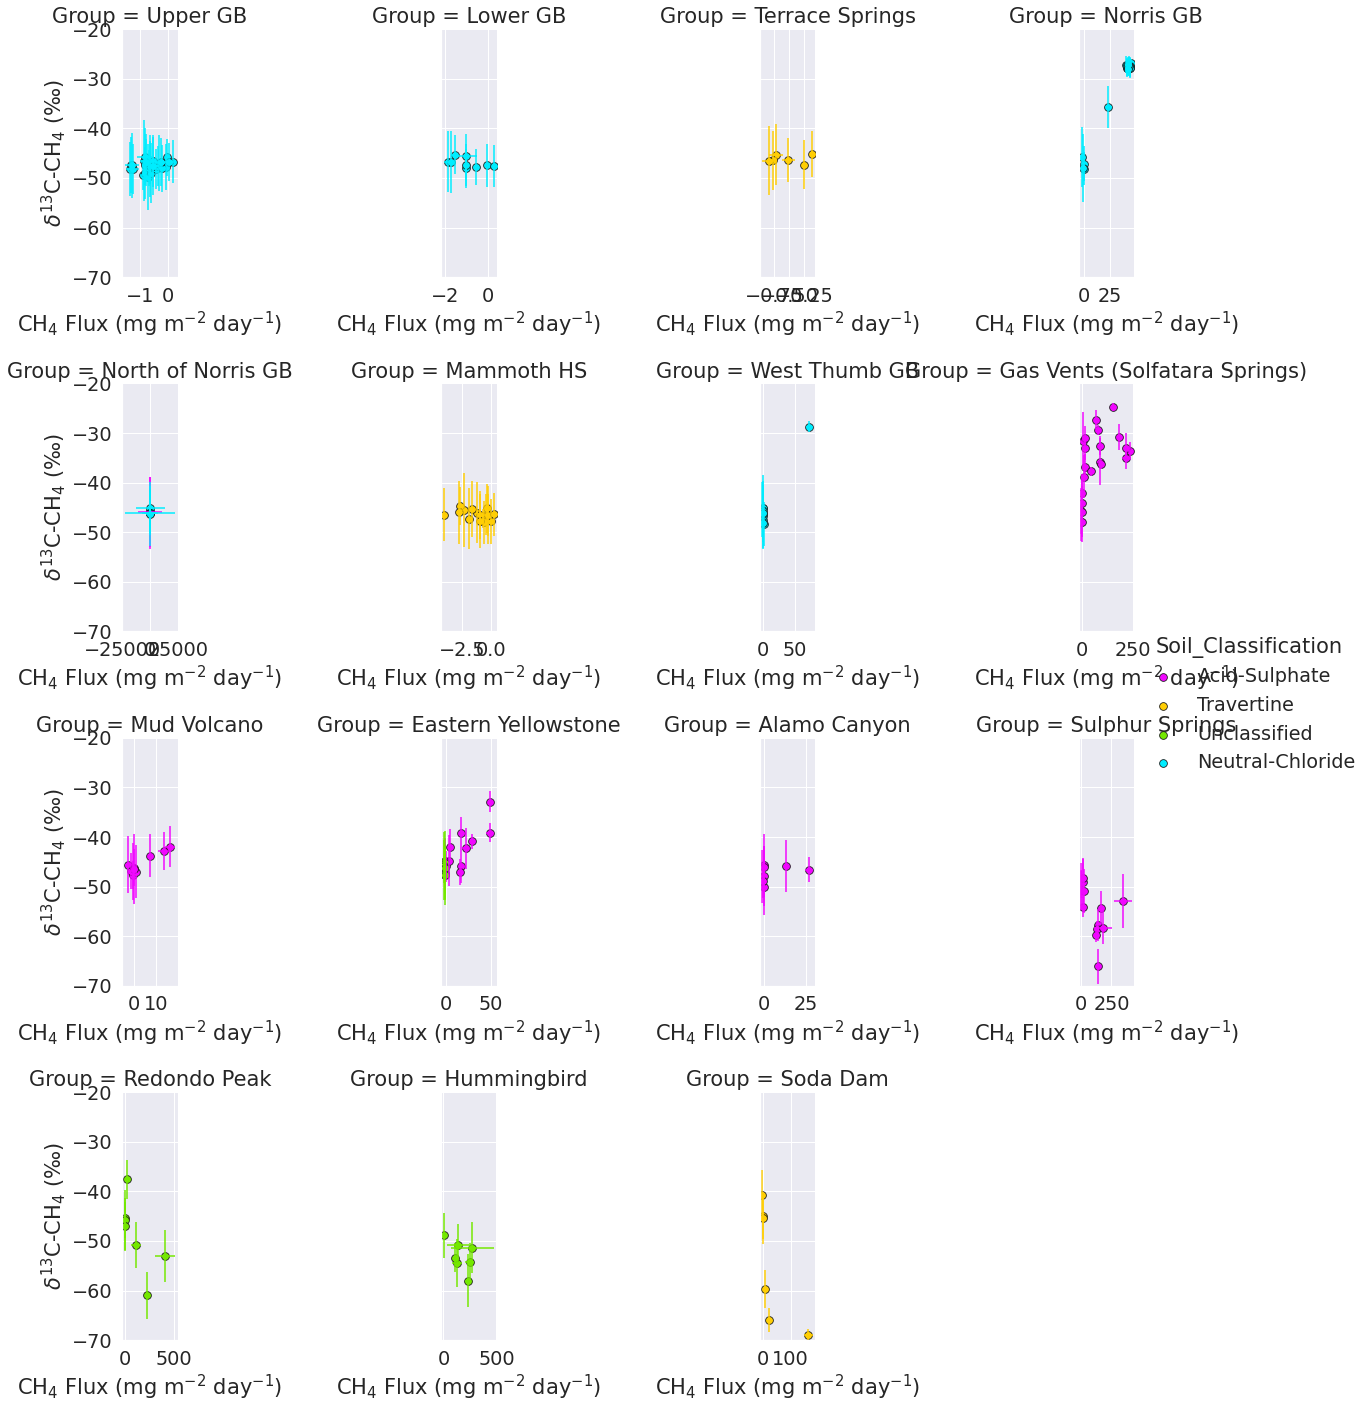

In [ ]:
# Quantify error for the fluxes
## CH4 Flux err
df_all_iso_pos_only["CH4_Flux_err"] = \
df_all_iso_pos_only.UpperBound_CH4_Flux - df_all_iso_pos_only.LowerBound_CH4_Flux

## CH4
fg = sns.FacetGrid(df_all_iso_pos_only, 
                   hue="Soil_Classification", palette="gist_ncar_r",
                   col="Group", col_wrap=4, height=5,aspect=0.8,
                   sharex=False)
fg.map_dataframe(errplot, x="CH4_Flux", y="d13CH4_source", 
                 xerr="CH4_Flux_err", yerr="d13CH4_err")
fg.set(ylim=(-70,-20),
       xlabel="CH$_4$ Flux (mg m$^{-2}$ day$^{-1}$)",
       ylabel="$\delta^{13}$C-CH$_4$ (‰)")
fg.tight_layout()
fg.add_legend()
plt.savefig("../../figures/faceted_d13CH4_v_CH4_Flux")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


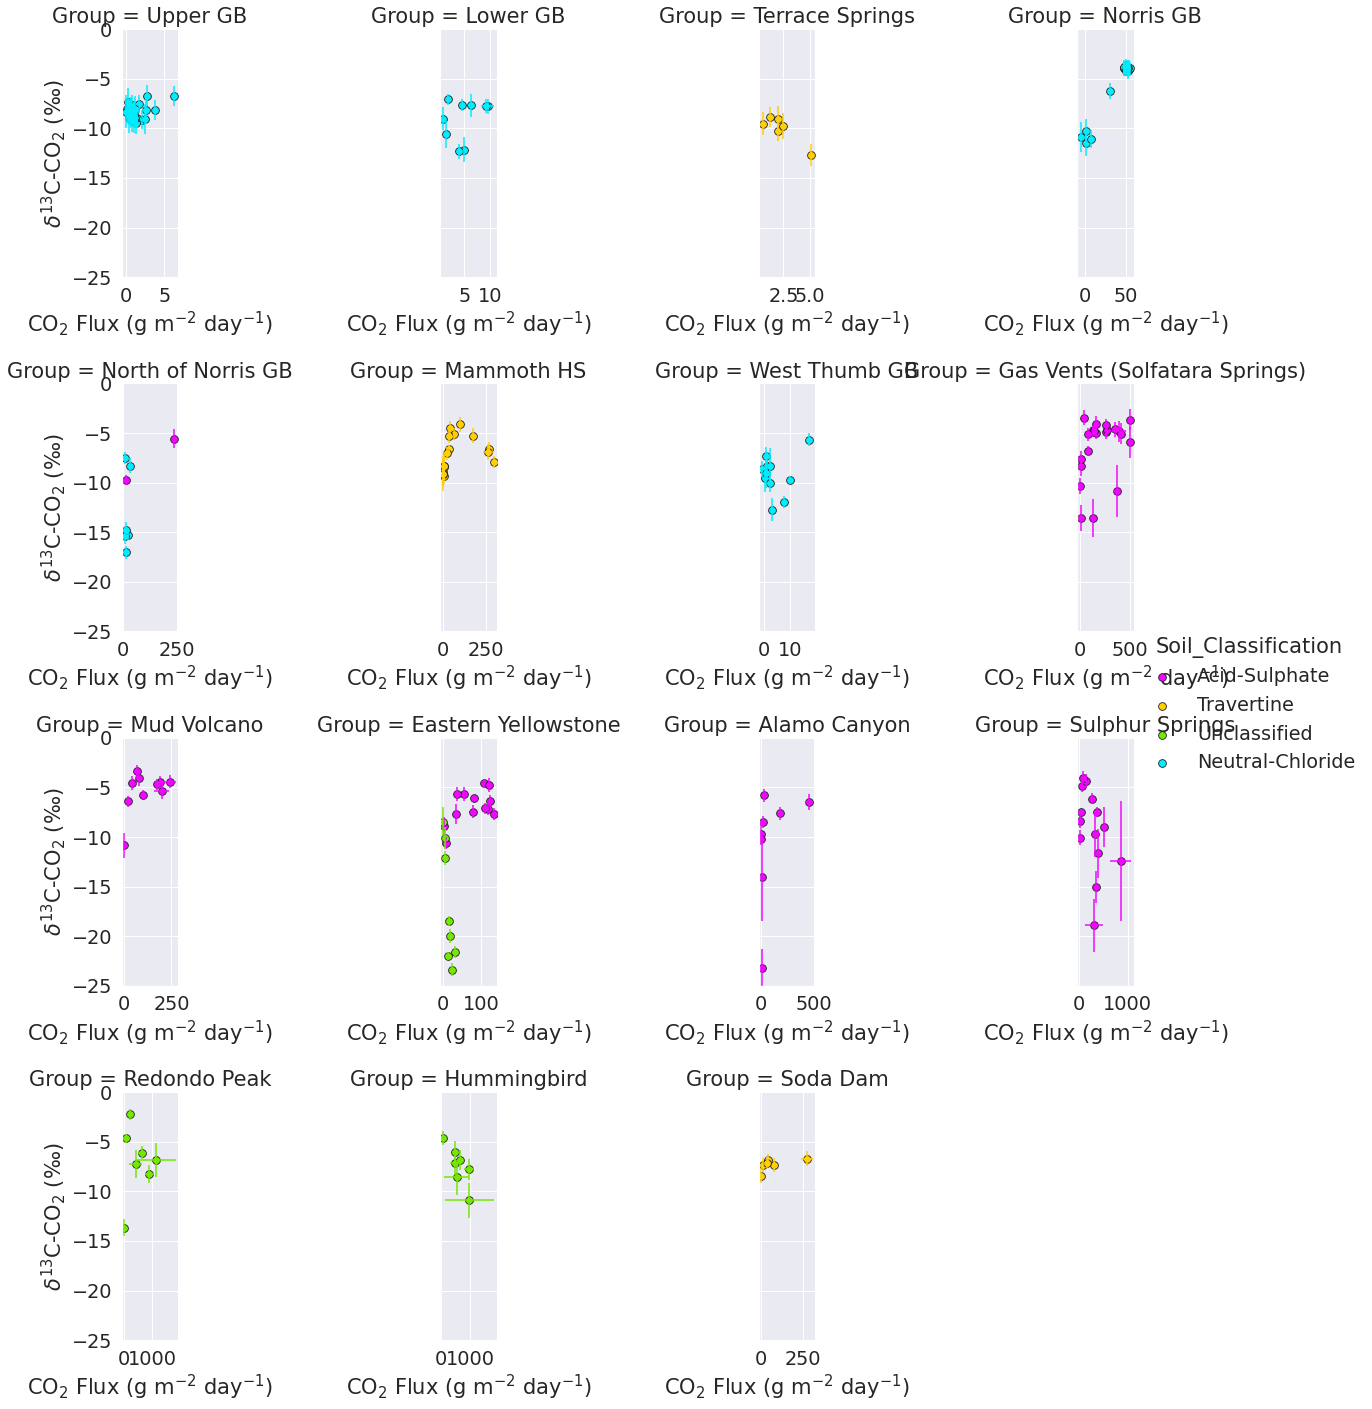

In [ ]:
## CO2 Flux err
df_all_iso_pos_only["CO2_Flux_err"] = \
df_all_iso_pos_only.UpperBound_CO2_Flux - df_all_iso_pos_only.LowerBound_CO2_Flux

## CO2
fg = sns.FacetGrid(df_all_iso_pos_only, 
                   hue="Soil_Classification", palette="gist_ncar_r",
                   col="Group", col_wrap=4, height=5,aspect=0.8,
                   sharex=False)
fg.map_dataframe(errplot, x="CO2_Flux", y="d13CO2_source", 
                 xerr="CO2_Flux_err", yerr="d13CO2_err")
fg.set(ylim=(-25,0),
       xlabel="CO$_2$ Flux (g m$^{-2}$ day$^{-1}$)",
       ylabel="$\delta^{13}$C-CO$_2$ (‰)")
fg.tight_layout()
fg.add_legend()
plt.savefig("../../figures/faceted_d13CO2_v_CO2_Flux.png")

#### Assess the Distribution of Carbon Isotopes
Just like with the fluxes, analyze which distributions will best fit the carbon isotopic data.

Next, density (kernel density estimate, kde) plot is used to understand the shape of the distribution of isotopes.---likely bimodel that will show up in the GSA for both--- 

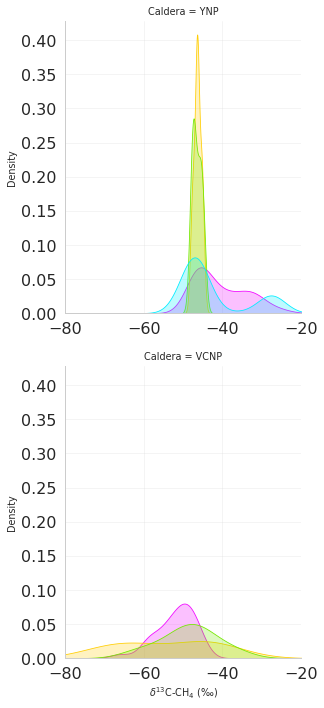

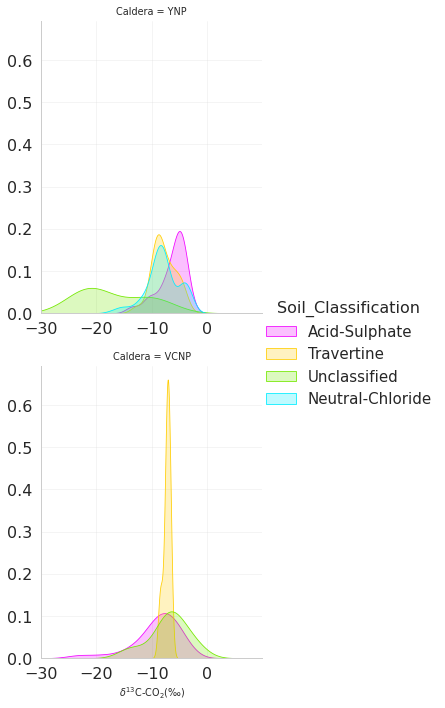

In [58]:
## δ13C-CH4: Comparisons between the caldera
fg = sns.FacetGrid(
    df_all_iso_pos_only,
    hue="Soil_Classification", 
    palette="gist_ncar_r",
    row="Caldera", 
    height=5, 
    aspect=0.9,
    sharex=False, 
    legend_out=False
)
fg.map_dataframe(
    sns.kdeplot, 
    data=df_all_iso_pos_only,
    x="d13CH4_source", 
    fill=True
)
fg.set_axis_labels(
    x_var="$\delta^{13}$C-CH$_4$ (‰)", 
    y_var="Density"
)
fg.set(xlim=(-80,-20))
#fg.add_legend()
plt.savefig("../../figures/faceted_kde_d13CH4.png")
## δ13C-CO2: Comparisons between the caldera
fg = sns.FacetGrid(
    df_all_iso_pos_only,
    hue="Soil_Classification", 
    palette="gist_ncar_r",
    row="Caldera", 
    height=5, 
    aspect=0.9,
    sharex=False
)
fg.map_dataframe(
    sns.kdeplot, 
    data=df_all_iso_pos_only,
    x="d13CO2_source", 
    fill=True, 
    legend=True
)
fg.set_axis_labels(
    x_var="$\delta^{13}$C-CO$_2$(‰)", 
    y_var=""
)
fg.set(
    xlim=(-30,10), 
    xticks=np.arange(-30,10,10)
)
fg.add_legend()
plt.savefig("../../figures/faceted_kde_d13CO2.png")

Figure ##: Kernel Density Estimate (KDE) plots estimate the distribution of δ<sup>13</sup>C compositions arcoss both calderas. Each distribution has been separated by soil classification.

The KDE plots for δ<sup>13</sup>C compositions demonstrate overlap between the soil chemistry classes, except for the unclassified group for the δ<sup>13</sup>C-CO<sub>2</sub> measurements at YNP. Though overlap exists, δ<sup>13</sup>C-CH<sub>4</sub> compositions at YNP are bimodal for neutral-chloride and acid-sulphate. Both of these soil chemistry classes exhibit a peak near atmospheric composition (~ -47‰) and another peak near the heavier ratio of -35‰. It should be noted that the location of  the neutral-chloride heavy isotope composition is from 17 measurements at Steamboat Geyser, whereas the measurements from the acid-sulphate class are a variety of locations east of WTHB (e.g., GVNT and Eaastern Yellowstone). 

The δ<sup>13</sup>C-CO<sub>2</sub> compositions were margibnally heaiver at YNP relative to VCNP. The exception to the overlap, the unclassified soil chemistry class at YNP, is centered near -22‰. These values represent the an altered patch but outside of the caldera rim and no signs of thermal activity. Effectively this cluser of unclassified measurements was made on an open meadow. 

The classic paper by Whiticar (1999) communciated that the one method to separate CH<sub>4</sub> originating from depth indicating a thermal source, or produced in the shallow subsurface by microbial activity. Specifically,  CH<sub>4</sub> can be formed by oxidation of CO<sub>2</sub>. Comparing the δ<sup>13</sup>C-CO<sub>2</sub> to the δ<sup>13</sup>C-CH<sub>4</sub> compositions permits this analysis to be completed visually. 

/usr/local/lib/python3.8/dist-packages/seaborn/relational.py:608: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  scout = ax.scatter(scout_x, scout_y, **kws)


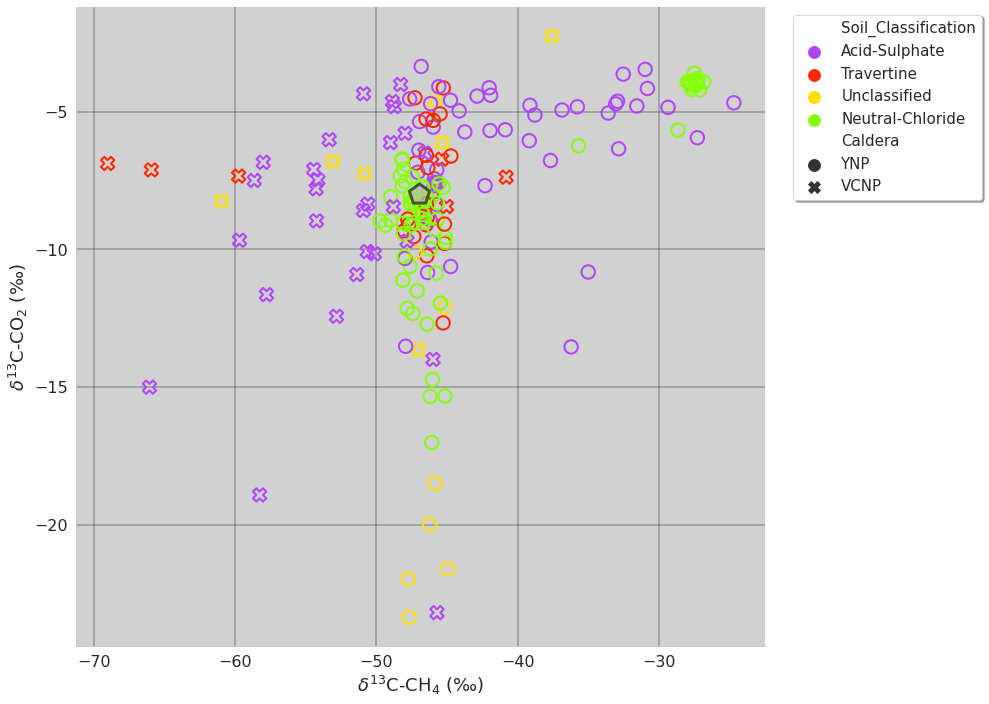

In [77]:
# create a pallette
_palette = dict(
    zip(
        df_all_iso_pos_only.Soil_Classification.unique(), 
        sns.color_palette("gist_ncar_r")
      )
)
ec_palette = df_all_iso_pos_only.Soil_Classification.map(_palette)

# Whiticar (1999) Plot
fig,ax = plt.subplots(figsize=(14,10))
kws={
  "s": 225, 
  # "facecolor": "none", 
  "linewidth": 2
}
sns.scatterplot(
    data=df_all_iso_pos_only, 
    x="d13CH4_source", 
    y="d13CO2_source",
    hue="Soil_Classification", 
    style="Caldera",
    markers=markers, 
    palette=_palette,
    fc="none",
    edgecolor=ec_palette,
    **kws,
    # linewidth=2,
    # s=180,
    ax=ax
)
ax.set( 
    facecolor="#d1d1d1",
    alpha=0.5
)
ax.set_xlabel(
    xlabel="$\delta^{13}$C-CH$_4$ (‰)",
    fontsize=18
)
ax.set_ylabel(
    ylabel="$\delta^{13}$C-CO$_2$ (‰)",
    fontsize=18
)
ax.scatter(
    -47, 
    -8, 
    marker="p", 
    s=450, 
    facecolors="#b9bdba", 
    alpha=0.7,
    edgecolors="k",
    linewidth=3
)
ax.grid(
    color="k",
    linestyle="-", 
    linewidth=2
)
ax.legend(
    title="",
    fontsize = 15,
    bbox_to_anchor= (1.03, 1),
    title_fontsize = 14,
    markerscale=2.5,
    shadow = True
)
plt.tight_layout()
plt.show()
fig.savefig(
    "../../figures/Whiticar_Plot_d13CO2_v_d13CH4.png", 
    dpi=300
)

Figure ##: Scatterplot of δ<sup>13</sup>C compositions across both calderas.



### Isotope Compositions Comparison between this Study and Previous Work with Point Sources
To assess the degree of similarity between the diffuse gases and the gases escaping from point sources, these components are compared in this section through regression. The variation in the carbon isotopes of the diffuse fluxes is modeled by the variation in the isotope compositions from the point source gases. 

Full Model used:\
$δ^{13}$C-CO$_2$ (CRDS-AC) ~ $δ^{13}$C-CO$_2$ (Bergfeld) + Xg + $\frac{CO_2}{CH_4}$ + Temperature + Feature Type \

Though the full model was used to perform a multilinear regression, all other combinations of the explanatory variables were also assessed by using a modified grid scearch. This modified grid search of explanatory variables resulted in 31 different regressions for each dataset. Only datasets with five or more samples for each group collected by Bergfeld were considered for these regressions. Thus, only Upper and Lower GB, Norris GB, Gas Vents (Solfatara Springs), Mud Volcano, and Eastern Yellowstone were examined in this exercise. 

In [ ]:
# Import Bergfeld dataset
## Programmatically Upload file from local drive
# Import file into workspace
df_Bergfeld_YC = pd.read_excel \
("YNP_Gas_Waters_REVISED_Bergfeld_all.xlsx",
 sheet_name="Table 1", header=0, parse_dates=True, na_values=[9999, 9999.0])

##### Preprocessing Point Emission Source Data
This group of cells prepares the data to be lobbed into a regression for analysis later in this section

In [ ]:
# Quick clean to prepare it further preprocessing
## Drop row of units
df_Bergfeld_YC.drop(0, axis=0, inplace=True)
## Reset index
df_Bergfeld_YC.reset_index(drop=True, inplace=True)

# Convert Group Number to Group string (category)
## Create an empty series to receive the new groups
grp = pd.Series(index=range(len(df_Bergfeld_YC.Group)))
## Create an empty series to receive the new numeric features
### 1 = Fry; 2 = Fum.; 3 = Pool_g; 4 = Seep; 5 = S.G.
feat = pd.Series(index=range(len(df_Bergfeld_YC.Group)))
for i in range(len(df_Bergfeld_YC.Group)):
  if df_Bergfeld_YC.Group.iloc[i] == 20.0:
    grp[i] = "Highland Hot Springs"
  elif df_Bergfeld_YC.Group.iloc[i] == 19.0:
    grp[i] = "Shoshone"
  elif df_Bergfeld_YC.Group.iloc[i] == 18.0:
    grp[i] = "Gibbon River Basins"
  elif df_Bergfeld_YC.Group.iloc[i] == 17.0:
    grp[i] = "North of Norris GB"
  elif df_Bergfeld_YC.Group.iloc[i] == 16.0:
    grp[i] = "Snake River Hot Spring"
  elif df_Bergfeld_YC.Group.iloc[i] == 15.0:
    grp[i] = "Upper GB"
  elif df_Bergfeld_YC.Group.iloc[i] == 14.0:
    grp[i] = "Mud Volcano"
  elif df_Bergfeld_YC.Group.iloc[i] == 13.0:
    grp[i] = "West Thumb GB"
  elif df_Bergfeld_YC.Group.iloc[i] == 12.0:
    grp[i] = "Smoke-jumper Hot Springs"
  elif df_Bergfeld_YC.Group.iloc[i] == 11.0:
    grp[i] = "Eastern Yellowstone"
  elif df_Bergfeld_YC.Group.iloc[i] == 10.0:
    grp[i] = "Gas Vents (Solfatara Springs)"
  elif df_Bergfeld_YC.Group.iloc[i] == 9.0:
    grp[i] = "Brimstone Basin"
  elif df_Bergfeld_YC.Group.iloc[i] == 8.0:
    grp[i] = "Norris GB"
  elif df_Bergfeld_YC.Group.iloc[i] == 7.0:
    grp[i] = "Terrace Springs"
  elif df_Bergfeld_YC.Group.iloc[i] == 6.0:
    grp[i] = "Roaring Mountain"
  elif df_Bergfeld_YC.Group.iloc[i] == 5.0:
    grp[i] = "Forest Springs"
  elif df_Bergfeld_YC.Group.iloc[i] == 4.0:
    grp[i] = "Mammoth HS"
  elif df_Bergfeld_YC.Group.iloc[i] == 3.0:
    grp[i] = "Lower GB"
  elif df_Bergfeld_YC.Group.iloc[i] == 2.0:
    grp[i] = "Washburn Hot Springs"
  elif df_Bergfeld_YC.Group.iloc[i] == 1.0:
    grp[i] = "Misc."
  else:
    grp[i] = "NaN"
## Convert Features (e.g., Pool_g, Fum., Fry) into numerical values    
  if df_Bergfeld_YC.Feature.iloc[i] == "Fry":
    feat[i] = 1
  elif df_Bergfeld_YC.Feature.iloc[i] == "Fum.":
    feat[i] = 2
  elif df_Bergfeld_YC.Feature.iloc[i] == "Pool_g":
    feat[i] = 3
  elif df_Bergfeld_YC.Feature.iloc[i] == "Seep":
    feat[i] = 4
  elif df_Bergfeld_YC.Feature.iloc[i] == "S.G.":
    feat[i] = 5
  else:
    feat[i] = np.nan
## Rename "Group" to "Group_num"
df_Bergfeld_YC.rename(columns={"Group":"Group_num"}, inplace=True)
## Insert grp into the Bergfeld dataframe
df_Bergfeld_YC.insert(3, "Group", grp)
## Insert feat into the Bergfeld dataframe
df_Bergfeld_YC.insert(7, "Feature_num", feat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


In [ ]:
# Establish proper datatypes
Berfeld_corrected_dtypes = {"Feature":"category", "Temperature":"float", 
                            "Easting":"float", "Northing":"float", "Xg":"float",
                            "CO2":"float", "H2S":"float", "NH3":"float", 
                            "He":"float", "H2":"float", "N2":"float", 
                            "CH4":"float", "C2H6":"float", "CO":"float", 
                            "C3H8":"float", "C4H10":"float", "C5H12":"float",
                            "d13C-CO2 (C)":"float", "d13C-CO2 (E)":"float", 
                            "d13C-CH4":"float","dDs":"float", "d18Os":"float"}
## Set the datatype      
df_Bergfeld_YC = df_Bergfeld_YC.astype(Berfeld_corrected_dtypes)

In [ ]:
# Collect the fluxes and isotopes from the Picarro dataset
#df_iso_merge_Bergfeld = df_all_iso_pos_only.merge(df_Bergfeld_YC, on="Group")
#df_iso_merge_Bergfeld.groupby(by="Group").get_group("Terrace Springs").head(10)


##### Linear Regression for Diffuse Isotopes vs Point Sources
This portion of the notebook quantifies the relationship between the carbon isotopes collected by the CRDS-AC and the point sources (Bergfeld et al. 2014). 



The function `StepWise()` is a modified grid search that separates the response variable from the independent variables and then proceeds to create a list of the response variable next to a sublist of all of the possible combinations of explanatory variables. 

In [ ]:
import itertools, copy

# The function to assess the combination of variables
def StepWise(cols, dependent):
    """ Takes the columns of a pandas dataframe, defines a dependent variable
        and returns all unique combinations of the remaining (independent)
        variables.
    """
    independent = cols.copy()
    independent.remove(dependent)

    lst1 = []
    lst2 = []
    for i in np.arange(1, len(independent)+1):
        elem = list(itertools.combinations(independent, i))
        lst1.append(elem)
        lst2.extend(elem)

    combosIndependent = [list(elem) for elem in lst2]
    combosAll =  [[dependent, other] for other in combosIndependent]
    return(combosAll)


The cell below describes the process of setting up dictionaries of empty dataframes, models, and model results that will contain:
- a dataframe of response and independent variables for each analyzed group
- an [ols regression model](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html) object for each fitted model (31 for each analyzed group)
- an ols regression [results wrapper](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html) containing the results (e.g., r$^{2}$, F-stat, _etc._) of each model (31 for each analyzed group)


In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Create empty dict of dfs
dict_dfs = {"Upper GB":[], "Lower GB":[], "Terrace Springs":[], "Norris GB":[],
           "North of NOrris GB":[], "Mammoth HS":[], "West Thumb GB":[], 
           "Gas Vents (Solfatara Springs)":[], "Mud Volcano":[], 
           "Eastern Yellowstone":[], "Alamo Canyon":[], "Sulphur Springs":[],
           "Redondo Peak":[], "Hummingbird":[], "Soda Dam":[]}                       
# Create an empty list  
dict_mdl = {"Upper GB":[], "Lower GB":[],
            "Terrace Springs":[], "Norris GB":[],
            "North of Norris GB":[], "Mammoth HS":[],
            "West Thumb GB":[],
            "Gas Vents (Solfatara Springs)":[],
            "Mud Volcano":[], "Eastern Yellowstone":[], 
            "Alamo Canyon":[], "Sulphur Springs":[],
            "Redondo Peak":[], "Hummingbird":[],
            "Soda Dam":[]}
# Create dictionary of model results
dict_ols_results = {"Upper GB":[], "Lower GB":[], 
                    "Terrace Springs":[], "Norris GB":[], 
                    "North of Norris GB":[], "Mammoth HS":[], 
                    "West Thumb GB":[], 
                    "Gas Vents (Solfatara Springs)":[], 
                    "Mud Volcano":[], "Eastern Yellowstone":[], 
                    "Alamo Canyon":[], "Sulphur Springs":[],
                    "Redondo Peak":[], "Hummingbird":[], 
                    "Soda Dam":[]}

for group in df_all_iso_pos_only.Group.cat.categories:
  # Gather the response variables (likely just d13CO2_source)
  y = df_all_iso_pos_only[df_all_iso_pos_only["Group"] == group]\
  [["d13CO2_source", "KP_d13CO2_source"]]

  # Gather explanatory variables (aka features, indepndent variables)
  X = df_Bergfeld_YC[df_Bergfeld_YC["Group"] == group]\
  [["Xg", "d13C-CO2 (C)", "Temperature", "Feature_num", "CO2", "CH4"]]
  ## Generate new feature of CO2 mol % / CH4 mol %
  X["CO2/CH4"] = X["CO2"]/X["CH4"]
  ### Drop CO2 and CH4
  X.drop(columns=["CO2", "CH4"], inplace=True)

  # Impute missing values using the median value
  X = X.fillna(X.median())

  # Create dataframe for Linear Regression by group
  df = X.reset_index(drop=True)
  y = y.reset_index(drop=True)
  df["d13CO2_source"] = y["d13CO2_source"]

  # Add dataframe to dict_dfs
  dict_dfs[group] = df
  # Acquire the combinations of explanatory variables
  ind_var_combos = StepWise(cols = df.columns.values.tolist(), 
                            dependent = 'd13CO2_source')
  print(group)

  # Skip groups where the dataframe has a length less than 5, break once the 
  # Valles Caldera locations are reached. Need data from that location before 
  # adding
  if len(df) < 5:
    continue
  elif group == "Alamo Canyon":
    break
  # Run the OLS regression
  data = []
  data2= []
  for i in range(len(ind_var_combos)):
    ## Organize the Design Matrix
    ### Get the columns for the design matrix
    call = ind_var_combos[i][1:]
    ind = df[call[0]]
    ind["constant"] = 1
    ## Create the response vector
    dep = df[["d13CO2_source"]]
    ## Apply the regression
    mdl = sm.OLS(dep, ind.astype(float), missing="drop")
    data2.append(mdl)
    ## Fit model
    ols_results = mdl.fit()
    data.append(ols_results)
  ### Store model in list
  dict_mdl[group] = data2    
  ### Store model fits/results
  dict_ols_results[group] = data


Upper GB
Lower GB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Terrace Springs
Norris GB
North of Norris GB
Mammoth HS
West Thumb GB
Gas Vents (Solfatara Springs)
Mud Volcano
Eastern Yellowstone
Alamo Canyon


When using multiple independent variables, a scatterplot matrix will provide a visualization to assess the linear relationship between each of the explanatory variables. The KDE in the diagonal deomonstarate the distribution of the data points for each of the features. When strong linear relationships are present between the explanatory variables, the likelihood for multicolinearity increases. 

In [ ]:
r2 = pd.DataFrame(columns=list(df_all_iso_pos_only.Group.cat.categories),
                  index=range(len(ind_var_combos)))
f_pval = pd.DataFrame(columns=list(df_all_iso_pos_only.Group.cat.categories),
                      index=range(len(ind_var_combos)))
for group in df_all_iso_pos_only.Group.cat.categories:
  if group == "Terrace Springs":
    continue
  elif group == "North of Norris GB":
    continue
  elif group == "Mammoth HS":
    continue
  elif  group == "West Thumb GB":
    continue
  elif group == "Alamo Canyon":
    break 
  for i in range(len(ind_var_combos)):
    r2[group][i] = dict_ols_results[group][i].rsquared
    f_pval[group][i] = dict_ols_results[group][i].f_pvalue
  
# Drop empty columns
r2.dropna(axis=1, how="all", inplace=True)
x = list(np.where((r2 >= 0.35 ) & (r2 <= 0.99 )))
x = pd.DataFrame(x, index=["Row", "Columns"])
x

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid


0   1   2   3   4   5   6   7   8   ...  43  44  45  46  47  48  49  50  51
Row       3   4   4   6   7   8   8  10  11  ...  27  28  28  28  29  29  29  30  30
Columns   1   1   3   1   1   1   3   1   1  ...   3   0   1   3   0   1   3   0   1

[2 rows x 52 columns]

In [ ]:
# Take a peek at the p-values of the F-statistic
f_pval["North of Norris GB"].sort_values()

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
30    NaN
Name: North of Norris GB, dtype: object

In [ ]:
val = r2[(r2["Mud Volcano"] >= 0.35) & (r2["Mud Volcano"] <= 0.99)]["Mud Volcano"].index


The selection of relevant models is currently (17 Apr 2021) being done via visual inspection of pertinent models. When time permits, another algorithm will be developed to highlight the most relevant models. 

In [ ]:
print(dict_ols_results["Gas Vents (Solfatara Springs)"][1].summary())

                            OLS Regression Results                            
Dep. Variable:          d13CO2_source   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                 -0.227
Method:                 Least Squares   F-statistic:                    0.2590
Date:                Fri, 23 Apr 2021   Prob (F-statistic):              0.646
Time:                        15:06:27   Log-Likelihood:               -0.99255
No. Observations:                   5   AIC:                             5.985
Df Residuals:                       3   BIC:                             5.204
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
d13C-CO2 (C)     0.5040      0.990      0.509   

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


In [ ]:
print(dict_ols_results["Gas Vents (Solfatara Springs)"][8].summary())

                            OLS Regression Results                            
Dep. Variable:          d13CO2_source   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     20.52
Date:                Fri, 23 Apr 2021   Prob (F-statistic):             0.0465
Time:                        15:06:27   Log-Likelihood:                 6.4729
No. Observations:                   5   AIC:                            -6.946
Df Residuals:                       2   BIC:                            -8.117
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xg            -5.0011      0.985     -5.078      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


The selection of relevant models was narrowed down by two criteria: (a) coefficient of determination and (b) Akaike information criterion (AIC). The former is well known in statistical literature as r$^{2}$. Briefly, this value determines the strength of the relationship between the response and explanatory variable(s). More specifically, it may be interpreted as the percentage of variation in the response (dependent) variable is explainable by the explanatory (independent) variables.

However, AIC is an estimator that assesses prediction error for a given set of statistical models, where the lower score indicates a more useful model relative the others. It is important to note that the AIC must be applied to models using the same repsonse variable data. AIC is especially useful when datasets are small (or in time series analysis) and there is not a test and/or validation dataset to be used. In this study most regressions were formed using a half to full dozen degrees of freedeom, thus not enough data for a test/validation set. 

The relevant models that were analyzed beyond the initial regression contained r$^{2}$ values greater or equal to 0.35 and less than or equal to 0.99; this criteria means that Mud Volcano (r$^{2}$≤ 0.29) and Eastern Yellowstone (r$^{2}$≤ 0.26) were not considered relevant as they related to the linear models.  

*Upper GB*\
Of the relevant groups, Upper GB had some of the lowest r$^{2}$ values (0.04 ≤ r$^{2}$ ≤ 0.52). There were nine models that fit the r$^{2}$ critera (0.35 ≤ r$^{2}$ ≤ 0.99) and of these models the model that showed the lowest AIC number (16.94) comapred the response variable (CRDS-AC δ$^{13}$C-CO$_2$) to δ$^{13}$C-CO$_2$ (Bergfeld), Temperature, and Feature Type (Supplementary Table ##). This model showed a slight negative relationship (coefficient = -0.36) between the response variable and δ$^{13}$C-CO$_2$ from the point sources and slight positive relationships between the other variables. However, none of the  variables were statistically signifcant at the 95% confidence level (Supplementary Table ##). \

*Lower GB* \
There were 26 models that met the r$^{2}$ critera for further evaluation for the Lower GB group. Of these 26 models, there were two models that presented with the lowest AIC (17.17). The first compared the response variable to Xg, Temperature, and Feature type. With an r$^{2}$ equal to 0.95, the model suggests that much of the variation in response variable can be explained by the explanatory variables. This suggestion is reinforced by the significant variable of Temperature ($p = 0.043$), but the other variables were deemed significant (Supplementary Table ##). 

The second model with an identical AIC compared the response variable to the same explanatory variables but with the addition of δ$^{13}$C-CO$_2$ (Bergfeld)(Supplementary Table ##). Again, only Temperature was a significant variable ($p = 0.043$). δ$^{13}$C-CO$_2$ (Bergfeld) was inversely related to the response variable (coefficient = -8.73). 

*Gas Vents (Solfatara Springs)*\
For the Gas Vents group, there were 16 relevant models. Of these models the model with the lowest AIC (-8.24) amd an r$^{2}$ of 0.98 compared the response variable to Xg, δ$^{13}$C-CO$_2$ (Bergfeld), and $\frac{CO_2}{CH_4}$ (Supplementary Table ##). All were statistically insignificant and the former two showed wide 95% confidence intervals for the coefficients (-25.97 ≤ Xg ≤ 13.66; -10.51 ≤ δ$^{13}$C-CO$_2$ (Bergfeld) ≤ 12.31) demonstratting a large degree of uncertainty. With the latter, $\frac{CO_2}{CH_4}$, the confidence interval was much narrower (-0.18 ≤ $\frac{CO_2}{CH_4}$ ≤ 0.72). 

Though not the lowest AIC (0.09), another iteration of the model produced an r$^{2}$ equal to 0.87. In this model, response variable is compared to 
δ$^{13}$C-CO$_2$ (Bergfeld), Temperature, and $\frac{CO_2}{CH_4}$.

In [ ]:
# Get the indexes that fit the criteria for r-squared
r2_lst = r2[(r2["Mud Volcano"] >= 0.35) & (r2["Mud Volcano"] <= 0.99)].index.tolist()
aic = pd.Series()
cond_no = pd.Series()
for i in range(len(r2_lst)):
  j = r2_lst[i]
  data = pd.Series(dict_ols_results["Mud Volcano"][j].aic)
  data2= pd.Series(dict_ols_results["Mud Volcano"][j].condition_number)
  aic = pd.concat([aic, data.astype("float")], ignore_index=True)
  cond_no = pd.concat([cond_no, data2.astype("float")], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [ ]:
# Get the indexes that fit the criteria for r-squared
r2_lst = r2[(r2["Mud Volcano"] >= 0.35) & (r2["Mud Volcano"] <= 0.99)].index.tolist()
# Create string and path to save results summary from ols
for i in range(len(r2_lst)):
  ols_vent_txt_summary = \
  "regression/point-source-diffuse-regression/%s_%d_ols_Bergfeld_CRDS_regression.txt"\
  % ("Mud Volcano", r2_lst[i])
  # Print summary to .txt file
  print(dict_ols_results["Mud Volcano"][r2_lst[i]].summary(),
        file= open(ols_vent_txt_summary, "w"))

##### OLS Diagnostics
In this section, most of the diagnositics for the linear regressions are conducted manually.

In [ ]:
# Set the variable `result` equal to the model of interest
diagnostic_group = "Upper GB"
model_iter = 17
result = dict_ols_results[diagnostic_group][model_iter]

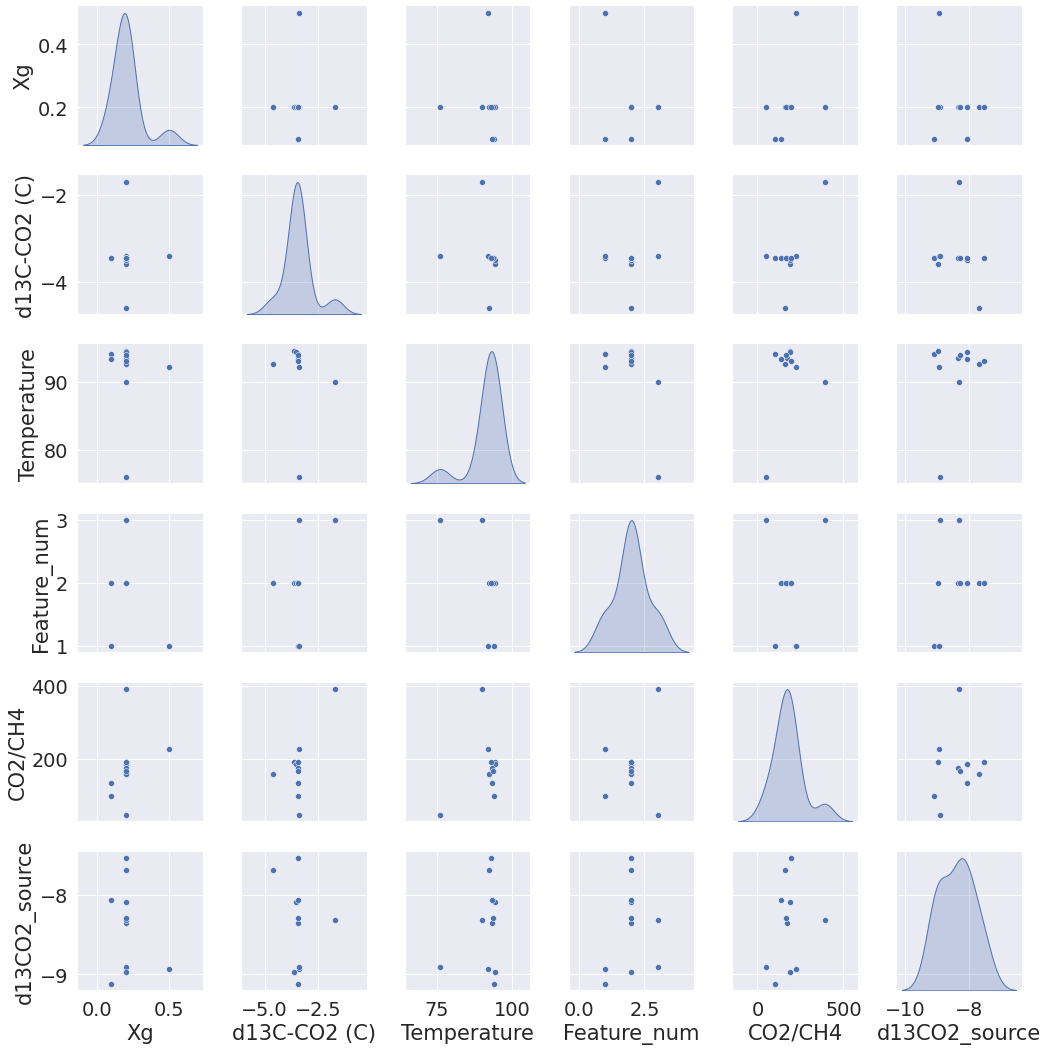

In [ ]:
# Assess colinearity among features with scatter matrix
sns.pairplot(dict_dfs[diagnostic_group], 
             diag_kind="kde", palette="ncar_gist_r", dropna=True)
plt_str = "../../figures/%s_%d_scattmatrix.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

Figure ##: Scattermatrix plot of explanatory variables used in the ols regression comparing the CRDS-AC carbon isotopes (i.e., the response variable) to the explanatory variables from the point sources.

The effect of outliers on model can be visualized with influence plots. These plots show which features contain points with high leverage ($\vert \, \text{studentized residual} \, \vert ≥ 3 $) called `student_resid` in the influence summary table (call: `ols_results.get_influence()`). 

To gauge the correlative nature of the features used in the linear models, their correlations are quantified and visualized using the heatmap below.

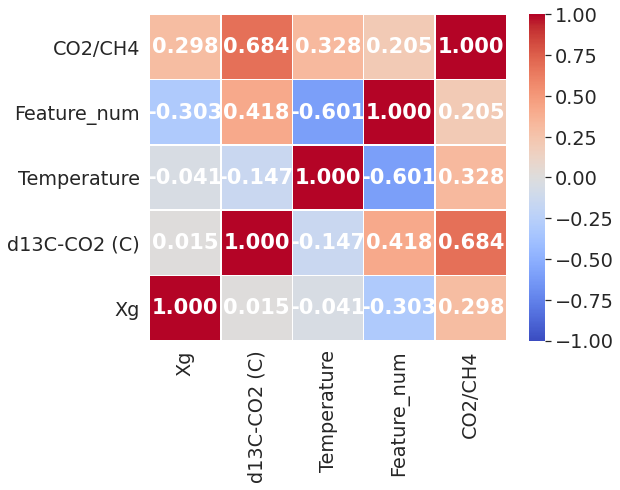

In [ ]:
# Diagnostic - Feature Correlation Heatmap
feat = dict_dfs[diagnostic_group].iloc[:,:-1]
corr = feat.corr().round(5)
plt.figure(figsize=(8,6))
hm = sns.heatmap(corr, linewidths=0.35, cmap="coolwarm",
            square=False, fmt=".3f", vmin=-1, vmax=1,
            annot=True, annot_kws={"color":"white", "weight":"bold"})
hm.invert_yaxis()
# Save figure
plt_str = "../../figures/%s_%d_feat_corr_hm.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

In [ ]:
influence = result.get_influence()
influence.summary_frame()

dfb_Xg  dfb_d13C-CO2 (C)  ...  student_resid    dffits
0   0.361730         -0.333511  ...      -1.568330 -0.963012
1  -1.481164         -0.130039  ...      -0.598774 -1.624374
2   0.215609          0.429684  ...       0.531516  0.653515
3   0.204343          0.418719  ...      -2.113075 -0.811766
4  -0.024840         -0.039900  ...       0.366770  0.124780
5  -0.050338         -0.182418  ...       0.148844  0.198097
6  -0.000435         -0.000325  ...       0.014512  0.004625
7  -0.184564          0.029895  ...       0.603532  0.307829
8   0.090191         -0.166128  ...      -0.180782 -0.483178
9  -0.003226          0.001038  ...       0.216382  0.069235
10 -0.129498         -0.175955  ...       1.817762  0.618416

[11 rows x 10 columns]

The influence plot compares the standardized residuals to leveage to visualize variables in the regression that exert a greater contribution to the model because of their distance from the mean values in their respective sample.

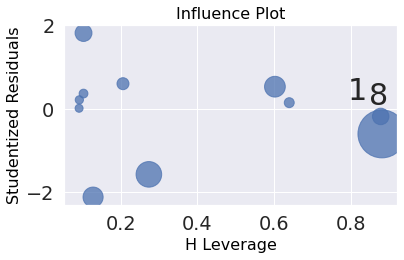

<Figure size 432x288 with 0 Axes>

In [ ]:
# Assess the influence of outliers on model
fig = sm.graphics.influence_plot(result, criterion="cooks")
fig.tight_layout(pad=1.0)
plt.show()
# Save figure
plt_str = "../../figures/%s_%d_inflence_plt.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

Figure ##: Influence plot

Diagnostic plots: (TL) the response variable vs an independent variable (observed and modeled) from the model, residuals vs independent variable, partial regression of the plot (i.e., regression using only the influence of the variable plotted and not the other variables used in the ols model), and a CCPR plot.

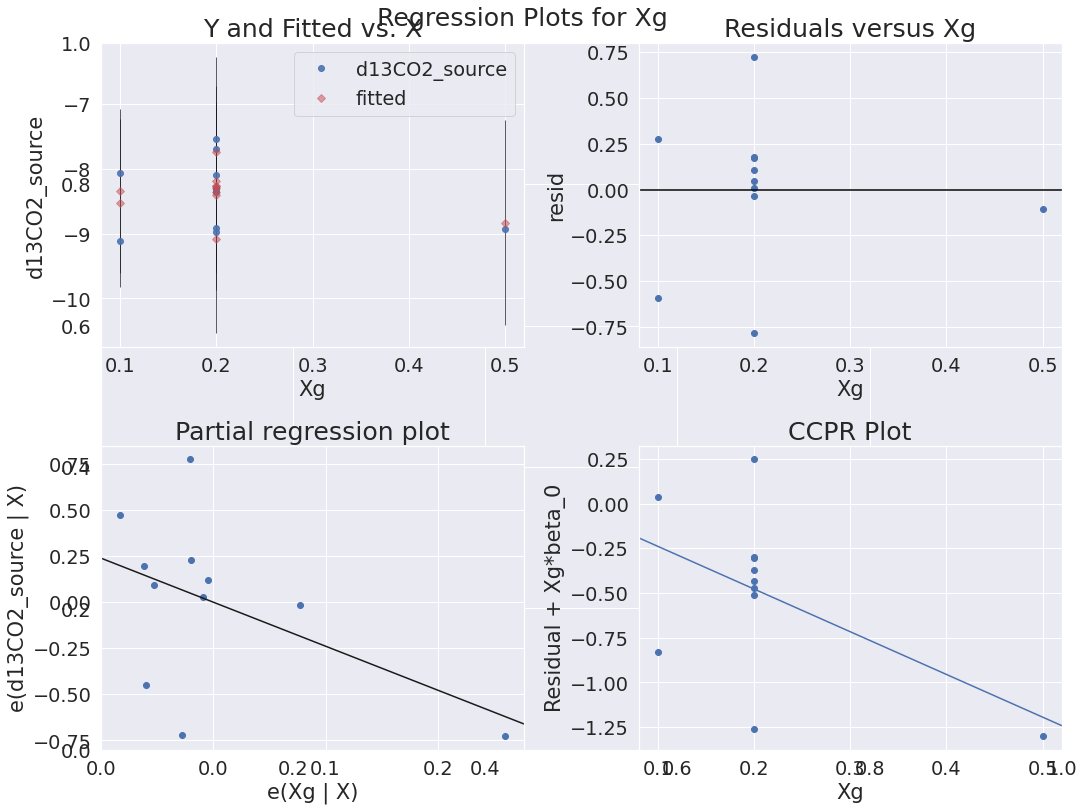

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
sm.graphics.plot_regress_exog(result, "Xg", fig=fig)
fig.tight_layout(pad=1.0)
plt.show()
# Save figure
plt_str = "../../figures/%s_%d_2x2_diagnostics.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

Covariation of parameters

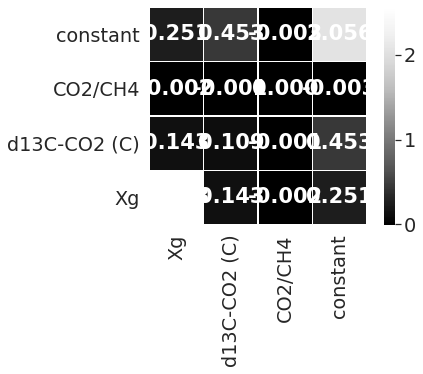

In [ ]:
cp = result.cov_params()
hm = sns.heatmap(cp,
                 linewidths=0.35, cmap="Greys_r",
                 square=True, fmt=".3f",
                 annot=True, annot_kws={"color":"white", "weight":"bold"})
hm.invert_yaxis()
# Save figure
plt_str = "../../figures/%s_%d_cov_params_hm.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

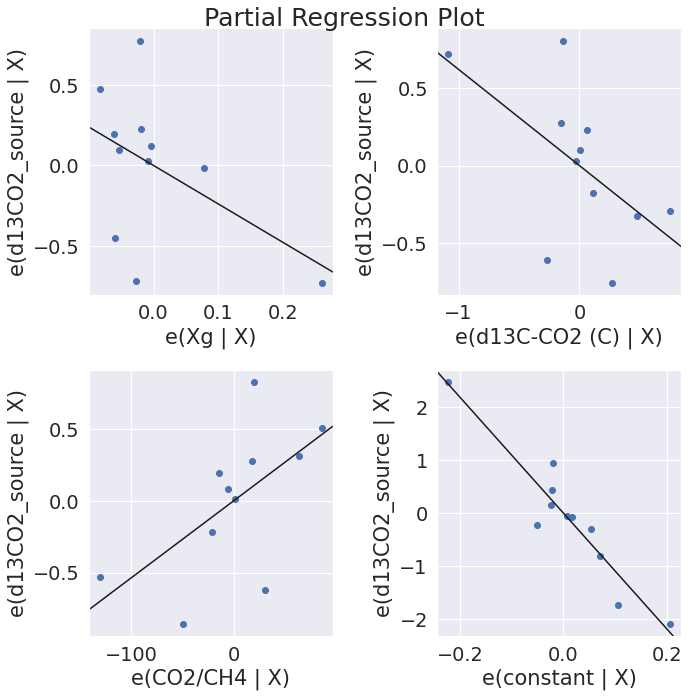

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.rc("figure", figsize=(10,10))
sm.graphics.plot_partregress_grid(result)
plt.show()
# Save figure
plt_str = "../../figures/%s_%d_partial_regression.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

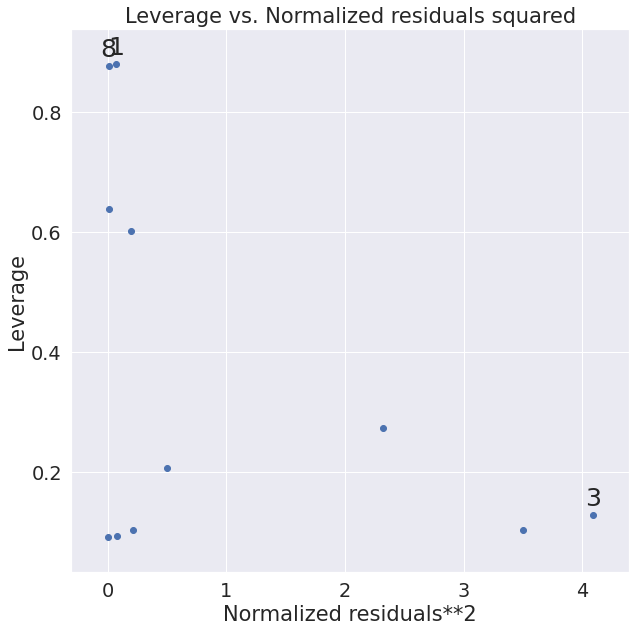

<Figure size 720x720 with 0 Axes>

In [ ]:
# Leveage vs Residuals
sm.graphics.plot_leverage_resid2(result)
plt.show()
# Save figure
plt_str = "../../figures/%s_%d_leverage_v_norm_resid-squared.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

Residuals: confirm the error of the model (i.e., residuals) is normal and random when the resuduals are plotted against predicted values, the chart should appear scattershot (random). 

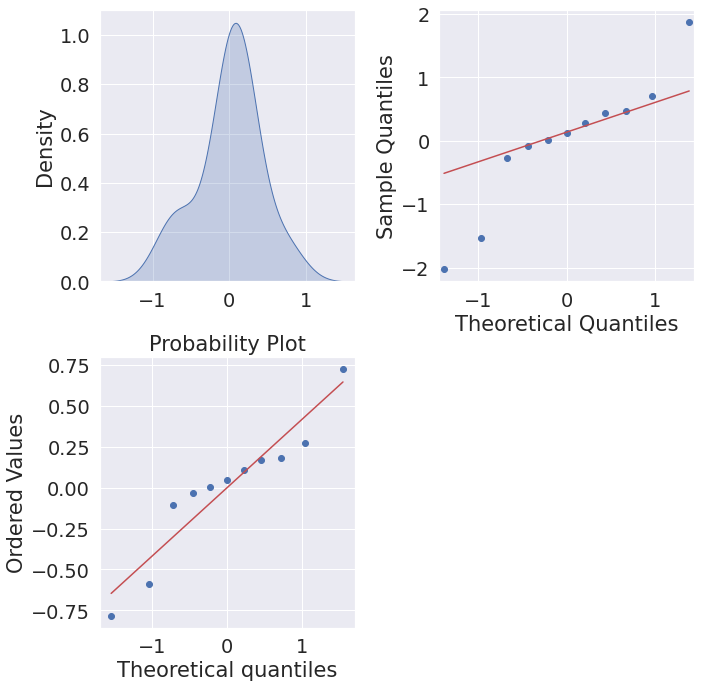

<Figure size 720x720 with 0 Axes>

In [ ]:
from scipy import stats
# Plot Standardized Residuals against Predicted Values
residual = result.resid
# Establish Figure
fig = plt.figure()

## Distribution of Residuals
ax = fig.add_subplot(2,2,1)
sns.kdeplot(residual, shade=True, palette="gist_ncar_r", ax=ax)
## QQ Plot of residuals
ax = fig.add_subplot(2,2,2)
sm.qqplot(residual, fit=True, line="q", ax=ax)
## PP Plot
ax = fig.add_subplot(2,2,3)
stats.probplot(residual, dist="norm", plot=ax)

plt.tight_layout()
plt.show()
# Save figure
plt_str = "../../figures/%s_%d_residual_analysis_dist_qq_pp_plots.png" \
% (diagnostic_group, model_iter)
plt.savefig(plt_str, dpi=300)

Applying the Harvey-Collier test (1976) to the fitted model can provide evidence of linearity of the model. 

### Comparing L10 Isotopes to KP Isotopes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use 

iso_differences  ... iso_differences_pct
                                        count  ...                 max
Group                                          ...                    
Upper GB                                 27.0  ...          185.132945
Lower GB                                  9.0  ...          182.764866
Terrace Springs                           6.0  ...          111.744533
Norris GB                                21.0  ...          185.230550
North of Norris GB                        8.0  ...           42.239948
Mammoth HS                               17.0  ...          152.827249
West Thumb GB                            11.0  ...          100.296413
Gas Vents (Solfatara Springs)            22.0  ...          195.190157
Mud Volcano                              10.0  ...          175.576647
Eastern Yellowstone                      21.0  ...          137.947845
Alamo Canyon                              8.0  ...          192.335628
Sulphur Springs                          14.0  ...          156.533863
Redondo Peak                              7.0  ...          113.328929
Hummingbird                               7.0  ...           43.789292
Soda Dam                                  6.0  ...           27.256753

[15 rows x 16 columns]

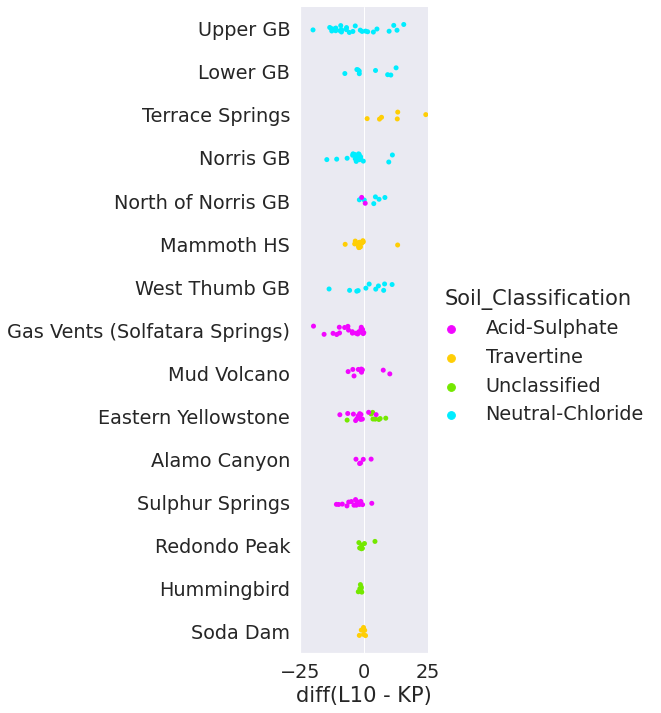

In [ ]:
diff_iso_pos_only = df_all_iso_pos_only[["Group", "Soil_Classification",
                                 "d13CO2_source", "KP_d13CO2_source"]]
diff_iso_pos_only["iso_differences"] = diff_iso_pos_only.d13CO2_source \
- diff_iso_pos_only.KP_d13CO2_source
diff_iso_pos_only["iso_differences_pct"] = perc_diff(np.abs(diff_iso_pos_only.d13CO2_source),  \
                                                 np.abs(diff_iso_pos_only.KP_d13CO2_source))
# Visualize
strip_iso = sns.catplot(data=diff_iso_pos_only, x="iso_differences", y="Group",
                        orient="h", hue="Soil_Classification", kind="strip",
                        palette="gist_ncar_r", height=10, aspect=0.8)
strip_iso.set_axis_labels("diff(L10 - KP)", "")
strip_iso.set(xlim=(-25,25))
plt.savefig("diff_L10_KP_iso_pos_only.png", dpi=300)
# Groupby Soil Classification
diff_iso_pos_only_grp = diff_iso_pos_only.groupby(by="Group")["iso_differences", "iso_differences_pct"].describe()
diff_iso_pos_only_grp

### Static Chamber Measurements

In [ ]:
# Import file into workspace
df_static_cham = pd.read_csv("static_cham_CH4_summary.csv", header=0,
                             dtype={"Group":"category", 
                                    "Soil_Classification":"category",
                                    "Caldera":"category"})

# Drop NaN rows
df_static_cham.dropna(axis=0, thresh=2, inplace=True)
# Order "Soil_Classification" categories
df_static_cham["Soil_Classification"].cat.reorder_categories\
(["Acid-Sulphate", "Travertine", "Unclassified", "Neutral-Chloride"],
 ordered=True, inplace=True)
# Reset index
df_static_cham.reset_index(drop=True, inplace=True)
df_static_cham.head(10)

Sample_ID                 Location  ...  Soil_Classification  Caldera
0  VCSS_3.2.A     VCSS_25May2019_3.2.1  ...        Acid-Sulphate     VCNP
1  VCHB_1.2.A     VCHB_26May2019_1.2.1  ...         Unclassified     VCNP
2  VCSD_1.3.A       VCSD_28May2019_1.3  ...           Travertine     VCNP
3  GVNT_4.2.A       GVNT_06Jun2019_2.2  ...        Acid-Sulphate      YNP
4  EETR_2.1.A       EETR_10Jun2019_2.1  ...        Acid-Sulphate      YNP
5  MDVC_2.3.A       MDVC_09Jun2019_2.3  ...        Acid-Sulphate      YNP
6  NGBN_1.2.A       NBGN_11Jun2019_1.2  ...     Neutral-Chloride      YNP
7  NGBN_2.1.A  NGBN_STMB_12Jun2019_1.1  ...     Neutral-Chloride      YNP
8  MMTH_5.1.A       MMTH_15Jun2019_4.1  ...           Travertine      YNP

[9 rows x 10 columns]

In [ ]:
# Upload Moran et al. 2017 data
df_Moran = pd.read_csv("Moran_et_al_2017_simple_data.csv", 
                       dtype={"Group":"category", 
                              "Soil_Classification":"category"})
# Reorder categories 
df_Moran.Soil_Classification.cat.reorder_categories\
(["Acid-Sulphate", "Travertine", "Unclassified", "Neutral-Chloride"],
 ordered=True, inplace=True)

# Group data by "Group"
df_Moran_grp = df_Moran.groupby(["Soil_Classification"]).agg(np.mean)
## Reset index to allow for "Soil_Classification" to be a column instead of an
## index
df_Moran_grp.reset_index(inplace=True)
# Preview the dataframe
df_Moran_grp

Soil_Classification  d13C_CH4  d13C_CH4_sigma     d2H_CH4  d2H_CH4_sigma
0       Acid-Sulphate  -20.5120        0.110000 -238.236000       1.253000
1          Travertine  -30.1840        0.313000 -272.248000       1.707000
2        Unclassified  -24.4275        0.321000 -222.750000       4.003500
3    Neutral-Chloride  -27.6100        0.093462 -235.899385       2.877923

Visualize the static chamber data\
Error is calculated from the average of st. deviations from the reference materials measurements. These data are located in the "References" tab in the "UCDavis_Static_Chamber_[...].xlsx" files located in the ".../Yellowstone/Summary_Data" directory on OneDrive.

In [ ]:
sns.set_theme(context="paper", style="darkgrid", font_scale=1.85, 
              palette="gist_ncar_r")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


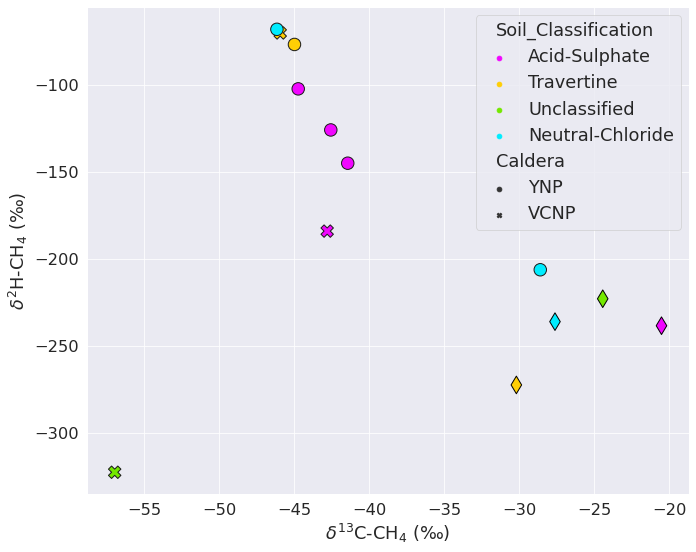

<Figure size 720x720 with 0 Axes>

In [ ]:
# Add error to dataframe
## Error for δ13C-CH4
df_static_cham["d13C_err"] = 0.14
## Error for δ2H-CH4
df_static_cham["d2H_err"] = 1.40

# Scatterplot of static chamber data
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_static_cham,x="d13C_CH4", y="d2H_CH4",
                hue="Soil_Classification", palette="gist_ncar_r", 
                s=155, style="Caldera", style_order=["YNP", "VCNP"],
                markers=True, edgecolor="k")
# Scatterplot of Moran et al. (2017) data
sns.scatterplot("d13C_CH4", "d2H_CH4",  data=df_Moran_grp, 
                hue="Soil_Classification", 
                marker="d", s=155, edgecolor="black",
                palette="gist_ncar_r", legend=None)

plt.xlabel("$\delta^{13}$C-CH$_4$ (‰)")
plt.ylabel("$\delta^{2}$H-CH$_4$ (‰)")
plt.tight_layout()
plt.show()
plt.savefig("../../figures/static_cham_d2H-CH4_v_d13C-CH4.png")

Figure ##: δ<sup>2</sup>H-CH<sub>4</sub> plotted against δ<sup>13</sup>C-CH<sub>4</sub> measurements from samples collected from the static chamber method. The error for these measurements fit within the size of the symbol. The diamond symbols represent averaged data collected by Moran et al. (2017) at YNP (n-Acid-Sulphate = 6, n-Travertine = 6, n-Unclassified = 6, n-Neutral-Chloride = 57). Note: 75% of the δ<sup>2</sup>H-CH<sub>4</sub> measurements collected in this study (i.e. circles and crosses) were below 3 ppm in the concentration of CH<sub>4</sub> and the level of quantification as per the methods described by UC Davis Stable Isotope Laboratory where the samples were measured.

The static chamber measurements intended to capture the sauration concentration of gases emitted from the subsurface. The δ<sup>13</sup>C-CH<sub>4</sub> were measured within a narrow range of -46 and -40‰ for the majority of measurements, save for one unclassified and neutral-chloride measurements. These two exceptions, the former in VCHB and the latter at NGBN, show large deviations from the remaining measurements. This deviation may be due to the fact these exceptions were the only samples that were above the level of quantification for  δ<sup>2</sup>H-CH<sub>4</sub>. 

## Inter-Caldera Comparisons
In this section of the notebook, the data at the caldera level has been aggregated for comparison.

In [ ]:
# Group data by caldera and soil chemistry class
gb_cald_scls = df_all_iso_pos_only.dropna().groupby(by=["Caldera", "Soil_Classification"])\
[["Caldera", "Soil_Classification", "d13CH4_source", "d13CO2_source"]]
gb_cald_scls = [gb_cald_scls.get_group(x) for x in gb_cald_scls.groups]
gb_cald_scls[2]

Caldera Soil_Classification  d13CH4_source  d13CO2_source
18     VCNP        Unclassified     -45.349965      -6.118929
19     VCNP        Unclassified     -53.072312      -6.810988
20     VCNP        Unclassified     -60.948037      -8.245861
21     VCNP        Unclassified     -50.864708      -7.243751
22     VCNP        Unclassified     -45.849117      -4.630778
23     VCNP        Unclassified     -37.603231      -2.252906
24     VCNP        Unclassified     -47.037549     -13.651527
123    VCNP        Unclassified     -51.389034     -10.915515
124    VCNP        Unclassified     -50.921404      -8.587561
125    VCNP        Unclassified     -54.441103      -7.097089
126    VCNP        Unclassified     -54.260698      -7.797980
129    VCNP        Unclassified     -53.343748      -6.017154
130    VCNP        Unclassified     -48.868378      -4.630169

#### KS Test
Test for normality using the KS among the different groups

In [ ]:
# Import stats from the `statsmodels` library
from statsmodels.stats.diagnostic import kstest_normal

# Set up the dataframe to receive results
df_KS_rslts_cald_scls_d13C = \
pd.DataFrame(columns=["Caldera", "Soil_Classification", 
                      "ks_stat_d13CH4", "pval_d13CH4", 
                      "ks_stat_d13CO2", "pval_d13CO2"], 
             index=range(7))

# Loop through each soil type and check for normality
for i in range(7):
  #---YNP---#
  # Gather Caldera
  df_KS_rslts_cald_scls_d13C.loc[i]["Caldera"] = \
  gb_cald_scls[i].Caldera.iloc[0]
  # Gather Soil Classification
  df_KS_rslts_cald_scls_d13C.loc[i]["Soil_Classification"] = \
  gb_cald_scls[i].Soil_Classification.iloc[0]
  # Run KS Test - CH4
  ks_stat, pval = kstest_normal(gb_cald_scls[i].d13CH4_source)
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_cald_scls_d13C.loc[i]["ks_stat_d13CH4"] = ks_stat
  ## pval
  df_KS_rslts_cald_scls_d13C.loc[i]["pval_d13CH4"] = pval
  # Run KS Test - CO2
  ks_stat, pval = kstest_normal(gb_cald_scls[i].d13CO2_source)
  # Assign results to dataframe
  ## ks_stat
  df_KS_rslts_cald_scls_d13C.loc[i]["ks_stat_d13CO2"] = ks_stat
  ## pval
  df_KS_rslts_cald_scls_d13C.loc[i]["pval_d13CO2"] = pval

# Export results from KS test to .csv
df_KS_rslts_cald_scls_d13C.to_csv("df_KS_rslts_cald_scls_d13C.csv", sep=",", 
                             index=False)

In [ ]:
df_KS_rslts_cald_scls_d13C

Caldera Soil_Classification  ... ks_stat_d13CO2 pval_d13CO2
0    VCNP       Acid-Sulphate  ...       0.189638   0.0470719
1    VCNP          Travertine  ...       0.292033    0.115523
2    VCNP        Unclassified  ...       0.164657         0.2
3     YNP       Acid-Sulphate  ...       0.198044  0.00025407
4     YNP    Neutral-Chloride  ...       0.146424    0.062347
5     YNP          Travertine  ...       0.141401         0.2
6     YNP        Unclassified  ...       0.224551         0.2

[7 rows x 6 columns]

The function `two_samp_compare()` permits the comparison of two samples of data and ensures that if the KS 2-sample test does not show that samples are from a similar distribution that they are then transformed by subtracting the minimum value from each datum and proveeding to use the Mann-Whitney U two sample non-parametric text. 

*`two_sample_compare()` may not be valid, needs further testing to ensure minimum scaling shift is not affecting results (23 April 2021)*

Apply the `scipy.stats.mannwhitneyu()` function to each relevant pair of data for δ<sup>13</sup>C-CH<sub>4</sub>

In [ ]:
def two_samp_compare(samp1, samp2):
  import scipy.stats as sps
  import warnings
  # Conduct Two Sample KS Test
  ks_2_stat, p_val = sps.ks_2samp(samp1, samp2)
  print(p_val)
  # Proceed based on p-value: if > 0.05 then samples come from similar 
  # distributions, if <= 0.05 samples must be transfomed becuse they come from 
  # populations fitted by different distributions
  if p_val > 0.05:
    # Conduct Mann-Whitney Test
    mu_stat, mu_pval = sps.mannwhitneyu(samp1, samp2)
    return mu_pval
  elif p_val <=  0.05:
    # Transform data with relative the minimum value
    samp1_trans = samp1 - np.min(samp1)
    samp2_trans = samp2 - np.min(samp2)
    # Double check KS 2-sample
    ks_2_stat_, p_val_ = sps.ks_2samp(samp1_trans, samp2_trans)
    print(p_val_)
    if p_val_ <= 0.05:
      warnings.warn("KS 2-sample not passed after transformation")
    # Conduct Mann-Whitney
    mu_stat, mu_pval = sps.mannwhitneyu(samp1_trans, samp2_trans)
    # Return stats
    return mu_pval

In [ ]:
import scipy.stats as sps

# d13C-CH4 |  Acid - Sulphate | YNP v VCNP
_, pval = sps.mannwhitneyu(gb_cald_scls[3].d13CH4_source, gb_cald_scls[0].d13CH4_source)
print("The p-value from the Mann-Whitney U test comparing median d13CH4 values \nat acid-sulphate locations is: {:.4e}.\n".format(pval))

# d13C-CH4 |  Travertine | YNP v VCNP
_, pval = sps.mannwhitneyu(gb_cald_scls[5].d13CH4_source, gb_cald_scls[1].d13CH4_source)
print("The p-value from the Mann-Whitney U test comparing median d13CH4 values \nat travertine locations is: {:.4e}.\n".format(pval))

# d13C-CH4 |  Unclasified | YNP v VCNP
_, pval = sps.mannwhitneyu(gb_cald_scls[6].d13CH4_source, gb_cald_scls[2].d13CH4_source)
print("The p-value from the Mann-Whitney U test comparing median d13CH4 values \nat unclassified locations is: {:.4e}.\n".format(pval))

The p-value from the Mann-Whitney U test comparing median d13CH4 values 
at acid-sulphate locations is: 1.4124e-09.

The p-value from the Mann-Whitney U test comparing median d13CH4 values 
at travertine locations is: 3.6305e-01.

The p-value from the Mann-Whitney U test comparing median d13CH4 values 
at unclassified locations is: 2.3209e-02.



The null hypothesis of the Mann-Whitney U test states that the median values of the pair of samples are equal to each other. This test was employed to examine the differences between the δ<sup>13</sup>C-CH<sub>4</sub> and  δ<sup>13</sup>C-CO<sub>2</sub> between the calderas. 

Paring by soil chemistry classes, the Mann-Whitney U test demonstrated that the acid-sulphate ($p < 0.0001$) and unclassified ($p < 0.03$) chemistry classes had significantly different medians. The median values  of the carbon isotopes from the travertine chemistry class between the calderas were not signficantly different from one another ($p = 0.36$).

Apply the `scipy.stats.mannwhitneyu()` function to each relevant pair of data for δ<sup>13</sup>C-CO<sub>2</sub>

In [ ]:
# d13CO2 |  Acid - Sulphate | YNP v VCNP
_, pval = sps.mannwhitneyu(gb_cald_scls[3].d13CO2_source, gb_cald_scls[0].d13CO2_source)
print("The p-value from the Mann-Whitney U test comparing median d13CO2 values \nat acid-sulphate locations is: {:.4e}.\n".format(pval))

# d13CO2 |  Travertine | YNP v VCNP
_, pval = sps.mannwhitneyu(gb_cald_scls[5].d13CO2_source, gb_cald_scls[1].d13CO2_source)
print("The p-value from the Mann-Whitney U test comparing median d13CO2 values \nat travertine locations is: {:.4e}.\n".format(pval))

# d13C-CO2 |  Unclasified | YNP v VCNP
_, pval = sps.mannwhitneyu(gb_cald_scls[6].d13CO2_source, gb_cald_scls[2].d13CO2_source)
print("The p-value from the Mann-Whitney U test comparing median d13CO2 values \nat unclassified locations is: {:.4e}.\n".format(pval))

The p-value from the Mann-Whitney U test comparing median d13CO2 values 
at acid-sulphate locations is: 9.7313e-04.

The p-value from the Mann-Whitney U test comparing median d13CO2 values 
at travertine locations is: 1.6525e-01.

The p-value from the Mann-Whitney U test comparing median d13CO2 values 
at unclassified locations is: 4.9186e-04.



The results from the Mann-Whitney U test demonstrate that medians between the carbon isotopes are not significantly different between the travertine groups ($p =0.17$). However, the median carbon isotopic signatures between the acid-sulphate ($p < 0.0001$)and unclassified ($p < 0.001$) groups indicate a significant difference in median values.

## Calibration Gases

The Picarro (CRDS) was assessed several times before, during, and after this project. This subsection contains some of those results. The analysis completed in this section has been streamlined to be added to publications.

### Import calibration gas data

Some of this data has been preprocessed by legacy MATLAB files. 

##### Zero Air

In [ ]:
# zero air data collected 25 Aug 2015
"""These data were collected across two .xlsx files"""
# page 1
zair_2015_pg01 = pd.read_excel(
    "pertinent-data/calibration-data/CFIDS2136-20150825-1.xlsx",
    parse_dates={"datetime" : ["DATE", "TIME CST"]}
)
# page 2
zair_2015_pg02 = pd.read_excel(
    "pertinent-data/calibration-data/CFIDS2136-20150825-2.xlsx",
    parse_dates={"datetime" : ["DATE", "TIME CST"]}
)

# vertically concatenate pages
df_zair_2015_raw = pd.concat(
    [zair_2015_pg01, zair_2015_pg02]
)

df_zair_2015_raw.head()

datetime  FRAC_DAYS_SINCE_JAN1  FRAC_HRS_SINCE_JAN1  \
0 2015-08-25 11:31:38.303            236.438638          5674.527307   
1 2015-08-25 11:31:39.624            236.438653          5674.527673   
2 2015-08-25 11:31:40.114            236.438659          5674.527809   
3 2015-08-25 11:31:40.608            236.438664          5674.527947   
4 2015-08-25 11:31:41.894            236.438679          5674.528304   

     EPOCH_TIME  ALARM_STATUS  INST_STATUS  CavityPressure  CavityTemp  \
0  1.440520e+09             0          963      148.008724   44.895134   
1  1.440520e+09             0          963      147.986718   44.894430   
2  1.440520e+09             0          963      147.998566   44.892387   
3  1.440520e+09             0          963      148.023238   44.892387   
4  1.440520e+09             0          963      148.005508   44.892387   

   WarmBoxTemp  EtalonTemp  ...  PPF_base_offset  PPF_slope_offset  PPF_shift  \
0    44.757439   44.528618  ...         1.006612          0.203088   0.000792   
1    44.757079   44.527311  ...         1.006612          0.203088   0.000792   
2    44.756035   44.523521  ...         1.006612          0.203088   0.000792   
3    44.756035   44.523521  ...         1.006612          0.203088   0.000792   
4    44.756035   44.523521  ...         1.074970          0.220191   0.000752   

   PPF_CH4_conc  PPF_H2O_conc  PPF_C2H6_conc  PPF_C2H4_conc  PPF_NH3_conc  \
0      1.851142      1.249788      -0.432444       0.004154      0.028523   
1      1.851142      1.249788      -0.432444       0.004154      0.028523   
2      1.851142      1.249788      -0.432444       0.004154      0.028523   
3      1.851142      1.249788      -0.432444       0.004154      0.028523   
4      1.855506      1.249576      -0.587432       0.001453      0.031922   

   PPF_H2S_conc             TIME  
0     -7.471180  16:31:38.303000  
1     -7.471180  16:31:39.624000  
2     -7.471180  16:31:40.114000  
3     -7.471180  16:31:40.608000  
4     -8.557252  16:31:41.894000  

[5 rows x 59 columns]

In [ ]:
# select only the pertinent columns
df_zair_2015 = df_zair_2015_raw[[
    "datetime",
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

# set the index to datetime
df_zair_2015.set_index("datetime", drop=True, inplace=True)

df_zair_2015.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6691 entries, 2015-08-25 11:31:38.303000 to 2015-08-25 13:10:50.755000
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       6691 non-null   int64  
 1   HP_12CH4_dry       6691 non-null   float64
 2   HP_Delta_iCH4_Raw  6691 non-null   float64
 3   Delta_Raw_iCO2     6691 non-null   float64
 4   12CO2_dry          6691 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 313.6 KB


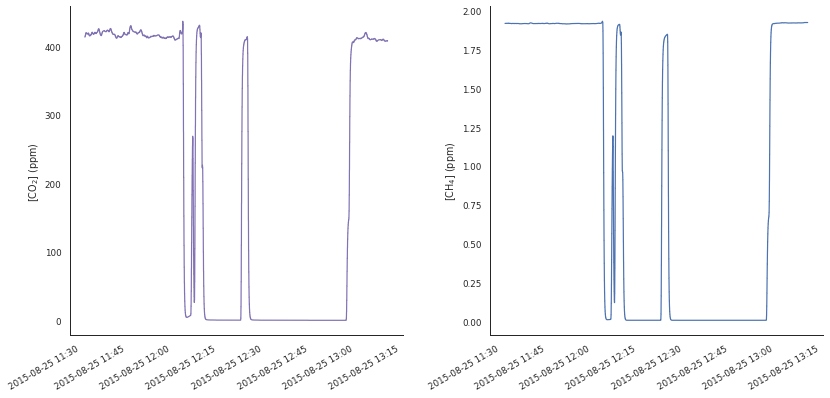

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({'font.size':22})

# co2
df_zair_2015.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_zair_2015.plot(y="HP_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

The chart above highlights at least two periods (longer than 10 minutes) where the zero air was hooked up to the CRDS. The longest period will be isolated and used to assess the sensitivity of the instrument. This period begins ~12:30 and is completed just before 13:00.


This section will be isolated as a new dataframe and the index will be the `datetime` column.

#### T-Iso 3 (Aug 2015)

In [ ]:
# gather the 2015 T-iso data
tiso_2015_raw = pd.read_excel(
    "pertinent-data/calibration-data/CFIDS2136-20150819-ALL.xlsx",
    parse_dates={"datetime" : ["DATE", "TIME CST"]}
)

tiso_2015_raw.head()

datetime  FRAC_DAYS_SINCE_JAN1  FRAC_HRS_SINCE_JAN1  \
0 2015-08-19 14:02:44.059            230.543566          5533.045572   
1 2015-08-19 14:02:45.375            230.543581          5533.045938   
2 2015-08-19 14:02:45.861            230.543586          5533.046073   
3 2015-08-19 14:02:46.348            230.543592          5533.046208   
4 2015-08-19 14:02:47.757            230.543608          5533.046599   

     EPOCH_TIME  ALARM_STATUS  INST_STATUS  CavityPressure  CavityTemp  \
0  1.440011e+09             0          963      148.000202   44.844170   
1  1.440011e+09             0          963      147.979561   44.851289   
2  1.440011e+09             0          963      147.974686   44.852135   
3  1.440011e+09             0          963      148.026702   44.852135   
4  1.440011e+09             0          963      147.995234   44.852135   

   WarmBoxTemp  EtalonTemp  ...   PPF_res  PPF_base_offset  PPF_slope_offset  \
0    45.037895   44.775505  ...  0.145703         0.965287          0.243023   
1    45.037050   44.774714  ...  0.145703         0.965287          0.243023   
2    45.036949   44.774620  ...  0.145703         0.965287          0.243023   
3    45.036949   44.774620  ...  0.145703         0.965287          0.243023   
4    45.036949   44.774620  ...  0.143207         1.006894          0.267561   

   PPF_shift  PPF_CH4_conc  PPF_H2O_conc  PPF_C2H6_conc  PPF_C2H4_conc  \
0   0.001871      1.770598      1.334238      -0.570065       0.002868   
1   0.001871      1.770598      1.334238      -0.570065       0.002868   
2   0.001871      1.770598      1.334238      -0.570065       0.002868   
3   0.001871      1.770598      1.334238      -0.570065       0.002868   
4   0.001904      1.769560      1.333764      -0.655899       0.001295   

   PPF_NH3_conc  PPF_H2S_conc  
0      0.036573     -9.118347  
1      0.036573     -9.118347  
2      0.036573     -9.118347  
3      0.036573     -9.118347  
4      0.037114     -9.609655  

[5 rows x 58 columns]

In [ ]:
# select only the pertinent columns
df_tiso_raw_2015 = tiso_2015_raw[[
    "datetime",
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HR_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "HR_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

# set the index to datetime
df_tiso_raw_2015.set_index("datetime", drop=True, inplace=True)

df_tiso_raw_2015.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5664 entries, 2015-08-19 14:02:44.059000 to 2015-08-19 15:32:41.076000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       5664 non-null   int64  
 1   HP_12CH4_dry       5664 non-null   float64
 2   HR_12CH4_dry       5664 non-null   float64
 3   HP_Delta_iCH4_Raw  5664 non-null   float64
 4   HR_Delta_iCH4_Raw  5664 non-null   float64
 5   Delta_Raw_iCO2     5664 non-null   float64
 6   12CO2_dry          5664 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 354.0 KB


Simple plot of the raw T-Iso 3 data

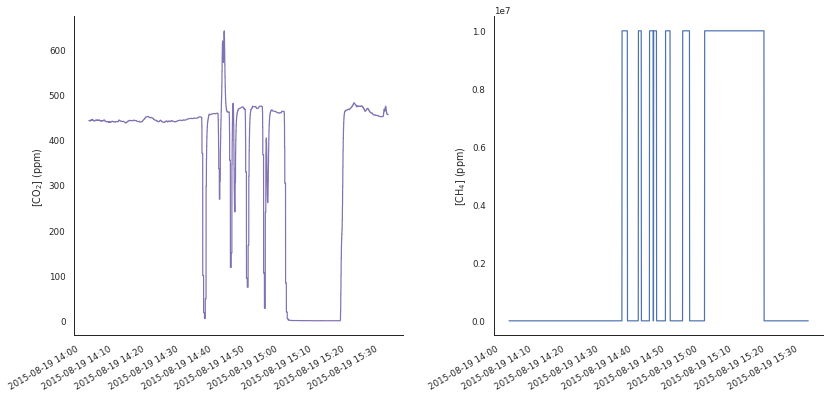

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({'font.size':22})

# co2
df_tiso_raw_2015.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_tiso_raw_2015.plot(y="HP_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

#### Calibration Session (April 2018)


In [ ]:
# print the files in the .zip folder
with zipfile.ZipFile("pertinent-data/calibration-data/20180420-dat/20180420_crds_data_dat-files.zip", mode="r") as calib_datFile_2018:
  
  # get list of filenames and other ancillary information
  calib_datFile_2018.printdir()

File Name                                             Modified             Size
CFIDS2136-20180420-155045Z-DataLog_User.dat    2018-04-20 10:50:56      6599646
__MACOSX/._CFIDS2136-20180420-155045Z-DataLog_User.dat 2018-04-20 10:50:56          276
CFIDS2136-20180420-165055Z-DataLog_User.dat    2018-04-20 11:51:04      6578664
__MACOSX/._CFIDS2136-20180420-165055Z-DataLog_User.dat 2018-04-20 11:51:04          220
CFIDS2136-20180420-175102Z-DataLog_User.dat    2018-04-20 12:51:12      6562524
__MACOSX/._CFIDS2136-20180420-175102Z-DataLog_User.dat 2018-04-20 12:51:12          220
CFIDS2136-20180420-185110Z-DataLog_User.dat    2018-04-20 13:51:20      6568980
__MACOSX/._CFIDS2136-20180420-185110Z-DataLog_User.dat 2018-04-20 13:51:20          220
CFIDS2136-20180420-195118Z-DataLog_User.dat    2018-04-20 14:51:26      6581892
__MACOSX/._CFIDS2136-20180420-195118Z-DataLog_User.dat 2018-04-20 14:51:26          220
CFIDS2136-20180420-205125Z-DataLog_User.dat    2018-04-20 15:51:34      6589962


In [ ]:
with zipfile.ZipFile("pertinent-data/calibration-data/20180420-dat/20180420_crds_data_dat-files.zip", mode="r") as calib_datFile_2018:
  
  # organize the filenames of .dat files into a list 
  calib_files_lst = calib_datFile_2018.namelist()

  # filter for .dat files
  calib_datFiles = fnmatch.filter(calib_files_lst, "*.dat")

  try:
    # calib_datFile_2018.open
    # read the .dat files into dataframes
    data = [
        pd.read_fwf(calib_datFile_2018.open(file_name), encoding='latin-1') for file_name in calib_datFiles
      ]
  except Exception as e:
    print("The following error has occured:\n{}".format(e))

# concatenate files
df_calib_2018 = pd.concat(data)

# reset the index
df_calib_2018.reset_index(drop=True, inplace=True)

# drop the columns that were encoded incorrectly (see comment)
df_calib_2018.drop(
    df_calib_2018.columns[61:],
    axis=1,
    inplace=True
)
# drop the one missing row (observed through visual inspection - row 4088)
df_calib_2018.dropna(inplace=True)

# convert `DATE` to a datetime type
df_calib_2018["DATE"] = pd.to_datetime(df_calib_2018.DATE)
# convert `TIME` to a datetime type
df_calib_2018["TIME"] = pd.to_datetime(df_calib_2018.TIME)
# explicitly label the time as GMT (this is how it is read in the Picarro)
df_calib_2018["TIME"] = df_calib_2018.TIME.dt.tz_localize("GMT+0", nonexistent="NaT")
# convert time label into eastern timezon (calibration took place outside of Oak Ridge)
df_calib_2018["TIME"] = df_calib_2018.TIME.dt.tz_convert("US/Eastern")
# remove the deafult date so only time remains
df_calib_2018["TIME"] = df_calib_2018.TIME.dt.time
# combine `DATE` and `TIME` into a new series
_datetime = pd.to_datetime(df_calib_2018.DATE.astype(str) + " " + df_calib_2018.TIME.astype(str))
# insert series into dataframe after TIME
df_calib_2018.insert(2, "datetime", _datetime)

df_calib_2018["datetime"] = pd.to_datetime(
    df_calib_2018.datetime, 
    format="%Y-%m-%d %H:%M:%S"
  )

df_calib_2018.set_index("datetime", drop=True, inplace=True)

# preview the data quality (i.e., non-null values and data types)
df_calib_2018.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27620 entries, 2018-04-20 11:50:40.076000 to 2018-04-20 18:37:59.181000
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  27620 non-null  datetime64[ns]
 1   TIME                  27620 non-null  object        
 2   FRAC_DAYS_SINCE_JAN1  27620 non-null  float64       
 3   FRAC_HRS_SINCE_JAN1   27620 non-null  float64       
 4   EPOCH_TIME            27620 non-null  float64       
 5   ALARM_STATUS          27620 non-null  float64       
 6   INST_STATUS           27620 non-null  float64       
 7   CavityPressure        27620 non-null  float64       
 8   CavityTemp            27620 non-null  float64       
 9   WarmBoxTemp           27620 non-null  float64       
 10  EtalonTemp            27620 non-null  float64       
 11  DasTemp               27620 non-null  float64       
 12  MPVPosition           276

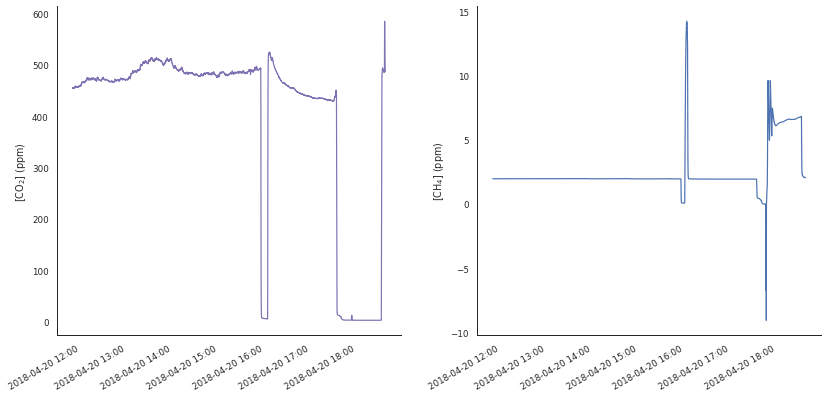

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({"font.size":22})

# co2
df_calib_2018.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_calib_2018.plot(y="HP_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

##### Field Prep Session (04 Apr 2018)

The machine was turned on to assess its readiness for the Summer 2018 field season.

The chart below shows that the machine was just turned on to measure laboratory air and nothing else. Therefore, it was not evaluated in the ["Analyze calibration data"](#analyze-calibration-data) section.

In [ ]:
# print the files in the .zip folder
with zipfile.ZipFile("pertinent-data/calibration-data/20180404-dat/20180404_crds_data_dat-files.zip", mode="r") as calib_datFile_20180404:
  
  # get list of filenames and other ancillary information
  calib_datFile_20180404.printdir()

File Name                                             Modified             Size
CFIDS2136-20180404-144830Z-DataLog_User.dat    2018-04-04 08:54:08       611833
__MACOSX/._CFIDS2136-20180404-144830Z-DataLog_User.dat 2018-04-04 08:54:08          120
CFIDS2136-20180404-154021Z-DataLog_User.dat    2018-04-04 10:40:30      6588348
__MACOSX/._CFIDS2136-20180404-154021Z-DataLog_User.dat 2018-04-04 10:40:30          120
CFIDS2136-20180404-164029Z-DataLog_User.dat    2018-04-04 11:40:38      6549612
__MACOSX/._CFIDS2136-20180404-164029Z-DataLog_User.dat 2018-04-04 11:40:38          120
CFIDS2136-20180404-174036Z-DataLog_User.dat    2018-04-04 12:40:46      6551226
__MACOSX/._CFIDS2136-20180404-174036Z-DataLog_User.dat 2018-04-04 12:40:46          120
CFIDS2136-20180404-184044Z-DataLog_User.dat    2018-04-04 13:21:18      3828662
__MACOSX/._CFIDS2136-20180404-184044Z-DataLog_User.dat 2018-04-04 13:21:18          120


In [ ]:
with zipfile.ZipFile("pertinent-data/calibration-data/20180404-dat/20180404_crds_data_dat-files.zip", mode="r") as calib_datFile_20180404:
  
  # organize the filenames of .dat files into a list 
  calib_files_lst = calib_datFile_20180404.namelist()

  # filter for .dat files
  calib_datFiles = fnmatch.filter(calib_files_lst, "*.dat")

  # read the .dat files into dataframes
  data = [
      pd.read_fwf(calib_datFile_20180404.open(file_name), encoding='latin-1') for file_name in calib_datFiles
    ]

# concatenate files
df_calib_20180404 = pd.concat(data)

# reset the index
df_calib_20180404.reset_index(drop=True, inplace=True)

# drop the columns that were encoded incorrectly (see comment)
df_calib_20180404.drop(
    df_calib_20180404.columns[61:],
    axis=1,
    inplace=True
)
# drop the one missing row (observed through visual inspection - row 4088)
df_calib_20180404.dropna(inplace=True)

# convert `DATE` to a datetime type
df_calib_20180404["DATE"] = pd.to_datetime(df_calib_20180404.DATE)
# convert `TIME` to a datetime type
df_calib_20180404["TIME"] = pd.to_datetime(df_calib_20180404.TIME)
# explicitly label the time as GMT (this is how it is read in the Picarro)
df_calib_20180404["TIME"] = df_calib_20180404.TIME.dt.tz_localize("GMT+0", nonexistent="NaT")
# convert time label into eastern timezon (calibration took place outside of Oak Ridge)
df_calib_20180404["TIME"] = df_calib_20180404.TIME.dt.tz_convert("US/Eastern")
# remove the deafult date so only time remains
df_calib_20180404["TIME"] = df_calib_20180404.TIME.dt.time
# combine `DATE` and `TIME` into a new series
_datetime = pd.to_datetime(df_calib_20180404.DATE.astype(str) + " " + df_calib_20180404.TIME.astype(str))
# insert series into dataframe after TIME
df_calib_20180404.insert(2, "datetime", _datetime)

df_calib_20180404["datetime"] = pd.to_datetime(
    df_calib_20180404.datetime, 
    format="%Y-%m-%d %H:%M:%S"
  )

df_calib_20180404.set_index("datetime", drop=True, inplace=True)

# preview the data quality (i.e., non-null values and data types)
df_calib_20180404.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14945 entries, 2018-04-04 10:48:25.292000 to 2018-04-04 15:15:42.707000
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  14945 non-null  datetime64[ns]
 1   TIME                  14945 non-null  object        
 2   FRAC_DAYS_SINCE_JAN1  14945 non-null  float64       
 3   FRAC_HRS_SINCE_JAN1   14945 non-null  float64       
 4   EPOCH_TIME            14945 non-null  float64       
 5   ALARM_STATUS          14945 non-null  float64       
 6   INST_STATUS           14945 non-null  float64       
 7   CavityPressure        14945 non-null  float64       
 8   CavityTemp            14945 non-null  float64       
 9   WarmBoxTemp           14945 non-null  float64       
 10  EtalonTemp            14945 non-null  float64       
 11  DasTemp               14945 non-null  float64       
 12  MPVPosition           149

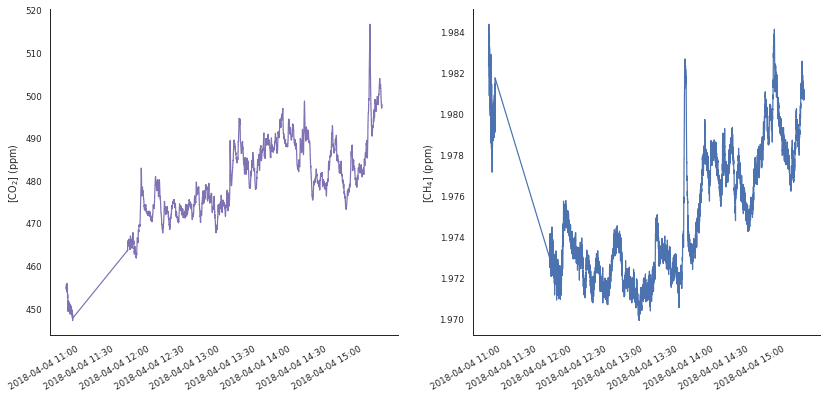

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({"font.size":22})

# co2
df_calib_20180404.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_calib_20180404.plot(y="HP_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

##### Field Prep Session (12 Apr 2018)

The machine was turned on to assess its readiness for the Summer 2018 field season.

Just as observed with the 04 Apr 2018 data, the chart below shows that the machine was just turned on to measure laboratory air. However, a brief attempt was made to measure what appears to be the diluted large CH4 cylinder. Therefore, it was not evaluated in the ["Analyze calibration data"](#analyze-calibration-data) section.

In [ ]:
# print the files in the .zip folder
with zipfile.ZipFile("pertinent-data/calibration-data/20180412-dat/20180412_crds_data_dat-files.zip", mode="r") as calib_datFile_20180412:
  
  # get list of filenames and other ancillary information
  calib_datFile_20180412.printdir()

File Name                                             Modified             Size
CFIDS2136-20180412-160951Z-DataLog_User.dat    2018-04-12 11:10:00      6586734
__MACOSX/._CFIDS2136-20180412-160951Z-DataLog_User.dat 2018-04-12 11:10:00          120
CFIDS2136-20180412-170959Z-DataLog_User.dat    2018-04-12 12:10:08      6585120
__MACOSX/._CFIDS2136-20180412-170959Z-DataLog_User.dat 2018-04-12 12:10:08          120
CFIDS2136-20180412-181007Z-DataLog_User.dat    2018-04-12 13:10:16      6589962
__MACOSX/._CFIDS2136-20180412-181007Z-DataLog_User.dat 2018-04-12 13:10:16          120
CFIDS2136-20180412-191015Z-DataLog_User.dat    2018-04-12 14:10:24      6593190
__MACOSX/._CFIDS2136-20180412-191015Z-DataLog_User.dat 2018-04-12 14:10:24          120
CFIDS2136-20180412-201023Z-DataLog_User.dat    2018-04-12 15:10:32      6354318
__MACOSX/._CFIDS2136-20180412-201023Z-DataLog_User.dat 2018-04-12 15:10:32          120
CFIDS2136-20180412-211031Z-DataLog_User.dat    2018-04-12 15:26:02      1092061


In [ ]:
with zipfile.ZipFile("pertinent-data/calibration-data/20180412-dat/20180412_crds_data_dat-files.zip", mode="r") as calib_datFile_20180412:
  
  # organize the filenames of .dat files into a list 
  calib_files_lst = calib_datFile_20180412.namelist()

  # filter for .dat files
  calib_datFiles = fnmatch.filter(calib_files_lst, "*.dat")

  # read the .dat files into dataframes
  data = [
      pd.read_fwf(calib_datFile_20180412.open(file_name), encoding='latin-1') for file_name in calib_datFiles
    ]

# concatenate files
df_calib_20180412 = pd.concat(data)

# reset the index
df_calib_20180412.reset_index(drop=True, inplace=True)

# drop the columns that were encoded incorrectly (see comment)
df_calib_20180412.drop(
    df_calib_20180412.columns[61:],
    axis=1,
    inplace=True
)
# drop the one missing row (observed through visual inspection - row 4088)
df_calib_20180412.dropna(inplace=True)

# convert `DATE` to a datetime type
df_calib_20180412["DATE"] = pd.to_datetime(df_calib_20180412.DATE)
# convert `TIME` to a datetime type
df_calib_20180412["TIME"] = pd.to_datetime(df_calib_20180412.TIME)
# explicitly label the time as GMT (this is how it is read in the Picarro)
df_calib_20180412["TIME"] = df_calib_20180412.TIME.dt.tz_localize("GMT+0", nonexistent="NaT")
# convert time label into eastern timezon (calibration took place outside of Oak Ridge)
df_calib_20180412["TIME"] = df_calib_20180412.TIME.dt.tz_convert("US/Eastern")
# remove the deafult date so only time remains
df_calib_20180412["TIME"] = df_calib_20180412.TIME.dt.time
# combine `DATE` and `TIME` into a new series
_datetime = pd.to_datetime(df_calib_20180412.DATE.astype(str) + " " + df_calib_20180412.TIME.astype(str))
# insert series into dataframe after TIME
df_calib_20180412.insert(2, "datetime", _datetime)

df_calib_20180412["datetime"] = pd.to_datetime(
    df_calib_20180412.datetime, 
    format="%Y-%m-%d %H:%M:%S"
  )

df_calib_20180412.set_index("datetime", drop=True, inplace=True)

# preview the data quality (i.e., non-null values and data types)
df_calib_20180412.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20936 entries, 2018-04-12 12:09:44.046000 to 2018-04-12 17:20:23.500000
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  20936 non-null  datetime64[ns]
 1   TIME                  20936 non-null  object        
 2   FRAC_DAYS_SINCE_JAN1  20936 non-null  float64       
 3   FRAC_HRS_SINCE_JAN1   20936 non-null  float64       
 4   EPOCH_TIME            20936 non-null  float64       
 5   ALARM_STATUS          20936 non-null  float64       
 6   INST_STATUS           20936 non-null  float64       
 7   CavityPressure        20936 non-null  float64       
 8   CavityTemp            20936 non-null  float64       
 9   WarmBoxTemp           20936 non-null  float64       
 10  EtalonTemp            20936 non-null  float64       
 11  DasTemp               20936 non-null  float64       
 12  MPVPosition           209

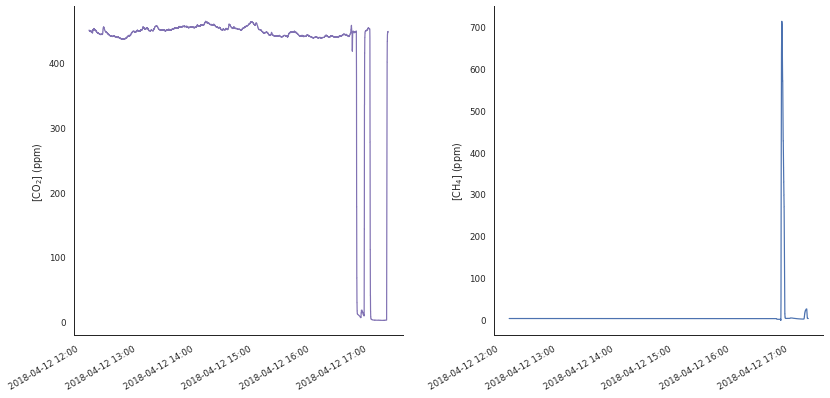

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({"font.size":22})

# co2
df_calib_20180412.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_calib_20180412.plot(y="HR_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

#### Calibration Session (May 2019)

Extract the May 2019 calibration data. This data was not stored as a [flat file](https://www.pcmag.com/encyclopedia/term/flat-file). Instead, the data collected in this session was store in a [HDF](https://asdc.larc.nasa.gov/documents/tools/hdf.pdf) file. Thus, the extraction process is different than others.

In [ ]:
# print the files in the .zip folder
with zipfile.ZipFile("pertinent-data/calibration-data/DataLog_Private_20190523_223822.zip", mode="r") as calib_datFile_2019:
  
  # get list of filenames and other ancillary information
  calib_datFile_2019.printdir()

File Name                                             Modified             Size
Picarro/G2000/Log/DataLogger/DataLog_Private/CFIDS2136-20180706-211156Z-DataLog_Private.h5 2018-07-06 16:37:10       522260
Picarro/G2000/Log/DataLogger/DataLog_Private/CFIDS2136-20190523-173753Z-DataLog_Private.h5 2019-05-23 13:37:58      1453335
Picarro/G2000/Log/DataLogger/DataLog_Private/CFIDS2136-20190523-183759Z-DataLog_Private.h5 2019-05-23 14:38:04      1455926
Picarro/G2000/Log/DataLogger/DataLog_Private/CFIDS2136-20190523-193804Z-DataLog_Private.h5 2019-05-23 15:38:10      1428461
Picarro/G2000/Log/DataLogger/DataLog_Private/CFIDS2136-20190523-203811Z-DataLog_Private.h5 2019-05-23 16:38:16      1430886
Picarro/G2000/Log/DataLogger/DataLog_Private/CFIDS2136-20190523-213817Z-DataLog_Private.h5 2019-05-23 17:38:22      1433222


This list comprehension will get every subdirectory in the directory down to the one holding the data. Thus indexing by `-1` will get the full path to the subdirectory holding the `.h5` files with the relevant data.

In [ ]:
subdirs_h5 = [x[0] for x in os.walk("pertinent-data/calibration-data/20190523-h5")]
path_to_h5_data = subdirs_h5[-1]

In [ ]:
lst_h5_paths = glob.glob(os.path.join(path_to_h5_data, "*.h5"))

In [ ]:
# establish an empty list to hold the concatenated data
calib_raw_may2019 = pd.DataFrame([])

for h5 in lst_h5_paths:
  if "-2019" in h5:
    with h5py.File(h5, "r") as f:
      print("Keys: {}".format(f.keys()))
      ar = np.array(f["results"])
      df = pd.DataFrame(ar)

      # concatenate to the output dataframe
      calib_raw_may2019 = pd.concat([calib_raw_may2019, df])

calib_raw_may2019.shape

Keys: <KeysViewHDF5 ['results']>
Keys: <KeysViewHDF5 ['results']>
Keys: <KeysViewHDF5 ['results']>
Keys: <KeysViewHDF5 ['results']>
Keys: <KeysViewHDF5 ['results']>


(20462, 245)

In [ ]:
# convert epoch time to a readable datetime
_datetime = calib_raw_may2019.time.map(
  lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x))
)

# insert into the dataframe on the far left
calib_raw_may2019.insert(
    0, "datetime", _datetime
)

# rename columns to match others dataframes
# calib_raw_may2019 = (
#     calib_raw_may2019
#     # .rename_column("12CH4_raw_dry","HP_12CH4_dry")
#     # .rename_column("12CH4_high_range","HR_12CH4_dry")
#     # .rename_column("HP_Delta_iCH4_Raw","HP_Delta_iCH4_Raw")
#     # .rename_column("HR_Delta_iCH4_Raw","HR_Delta_iCH4_Raw")
#     # .rename_column("12CO2_dry","12CO2_dry")
#     # .rename_column("Delta_Raw_iCO2","Delta_Raw_iCO2")
#     # .rename_column("ALARM_STATUS","ALARM_STATUS")
# )

calib_raw_may2019.head()

datetime  12CH4_high_range  12CH4_raw  12CH4_raw_dry  \
0  2019-05-23 17:37:47          2.091470   2.324511       2.349506   
1  2019-05-23 17:37:48          2.091470   2.324511       2.349506   
2  2019-05-23 17:37:48          2.091470   2.324511       2.349506   
3  2019-05-23 17:37:49          2.091470   2.324511       2.349506   
4  2019-05-23 17:37:50          2.095109   2.328548       2.353544   

        12CO2   12CO2_dry  12CO2_ppm_dry  12CO2_ppm_wet  13CH4_raw  \
0  452.963593  458.328796     470.817261     465.310181   0.024927   
1  452.963593  458.328796     470.817261     465.310181   0.024927   
2  453.066223  458.423584     470.914581     465.415527   0.024927   
3  453.066223  458.423584     470.914581     465.415527   0.024927   
4  453.066223  458.423584     470.914581     465.415527   0.024946   

   13CH4_raw_dry  ...  wlm7_offset  wlm8_offset   y87_ave       y88       y_0  \
0            0.0  ...          0.0    -0.037788  1.721676  1.918208  1.163182   
1            0.0  ...          0.0    -0.037788  1.721676  1.918062  1.163182   
2            0.0  ...          0.0    -0.037788  1.724164  1.918062  1.163182   
3            0.0  ...          0.0    -0.037788  1.724164  1.921034  1.163182   
4            0.0  ...          0.0    -0.037778  1.724164  1.921034  1.160758   

       y_30       y_5      y_87   z87_ave       z88  
0  1.403278  1.123634  1.717464  0.553519  0.616704  
1  1.403278  1.123634  1.717464  0.553519  0.616657  
2  1.403278  1.123634  1.731627  0.554319  0.616657  
3  1.403278  1.123634  1.731627  0.554319  0.617612  
4  1.389068  1.121292  1.731627  0.554319  0.617612  

[5 rows x 246 columns]

In [ ]:
# select only the pertinent columns
df_calib_raw_may2019 = calib_raw_may2019[[
    "datetime",
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HR_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "HR_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

# set datetime to a datetime object
df_calib_raw_may2019["datetime"] = pd.to_datetime(
    df_calib_raw_may2019.datetime, 
    format="%Y-%m-%d %H:%M:%S"
  )

# set the index to datetime
df_calib_raw_may2019.set_index("datetime", drop=True, inplace=True)

df_calib_raw_may2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20462 entries, 2019-05-23 17:37:47 to 2019-05-23 22:38:16
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       20462 non-null  float32
 1   HP_12CH4_dry       20462 non-null  float32
 2   HR_12CH4_dry       20462 non-null  float32
 3   HP_Delta_iCH4_Raw  20462 non-null  float32
 4   HR_Delta_iCH4_Raw  20462 non-null  float32
 5   Delta_Raw_iCO2     20462 non-null  float32
 6   12CO2_dry          20462 non-null  float32
dtypes: float32(7)
memory usage: 719.4 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Simple plot of calibration session

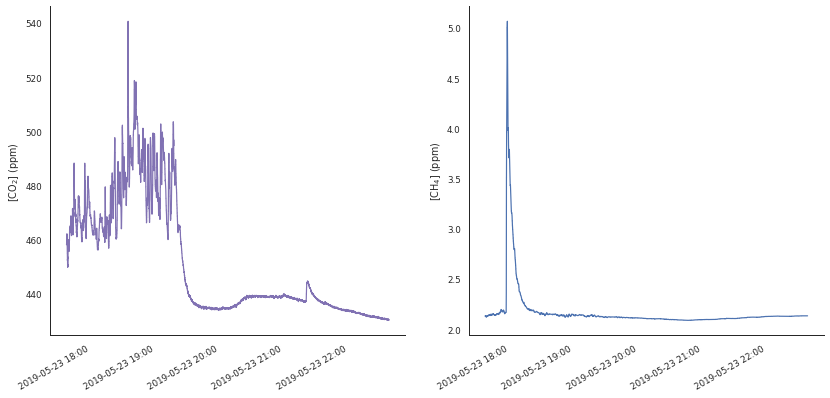

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({'font.size':22})

# co2
df_calib_raw_may2019.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_calib_raw_may2019.plot(y="HP_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

#### Calibration Session (Aug 2019)

In [ ]:
# calibration session (Aug 2019)
calib_data_aug2019_raw = (
    pd.read_csv(
    "pertinent-data/calibration-data/CALB_21Aug2019.csv"
  )
  .rename_column("Time","datetime")
  .rename_column("HP_CH4_dry","HP_12CH4_dry")
  .rename_column("HR_CH4_dry","HR_12CH4_dry")
  .rename_column("HP_d13_CH4","HP_Delta_iCH4_Raw")
  .rename_column("HR_d13_CH4","HR_Delta_iCH4_Raw")
  .rename_column("CO2_dry","12CO2_dry")
  .rename_column("d13_CO2","Delta_Raw_iCO2")
  .rename_column("Alarm_Status","ALARM_STATUS")
)

calib_data_aug2019_raw.head()

datetime  Rel_Sec  HP_12CH4_dry  HR_12CH4_dry  \
0  21-Aug-2019 15:05:18    0.000      1.956742      1.986554   
1  21-Aug-2019 15:05:22    3.745      1.957195      1.987020   
2  21-Aug-2019 15:05:26    7.506      1.956247      1.986128   
3  21-Aug-2019 15:05:29   11.251      1.957495      1.987391   
4  21-Aug-2019 15:05:33   15.063      1.957596      1.987626   

   HP_Delta_iCH4_Raw  HR_Delta_iCH4_Raw   12CO2_dry  Delta_Raw_iCO2  \
0        -158.359148        -158.359148  593.464351     -169.361805   
1        -158.176069        -158.176069  596.560140     -171.214172   
2        -157.622903        -157.622903  595.850652     -168.224238   
3        -157.744035        -157.744035  596.482923     -167.872452   
4        -154.232839        -154.232839  596.479245     -168.028950   

   ALARM_STATUS  
0             0  
1             0  
2             0  
3             0  
4             0

In [ ]:
# select only the pertinent columns
df_calib_raw_aug2019 = calib_data_aug2019_raw[[
    "datetime",
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HR_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "HR_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

df_calib_raw_aug2019["datetime"] = pd.to_datetime(
    df_calib_raw_aug2019.datetime
  )

# set the index to datetime
df_calib_raw_aug2019.set_index("datetime", drop=True, inplace=True)

df_calib_raw_aug2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3069 entries, 2019-08-21 15:05:18 to 2019-08-21 18:22:13
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       3069 non-null   int64  
 1   HP_12CH4_dry       3069 non-null   float64
 2   HR_12CH4_dry       3069 non-null   float64
 3   HP_Delta_iCH4_Raw  3069 non-null   float64
 4   HR_Delta_iCH4_Raw  3069 non-null   float64
 5   Delta_Raw_iCO2     3069 non-null   float64
 6   12CO2_dry          3069 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 191.8 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Simple plot of calibration session

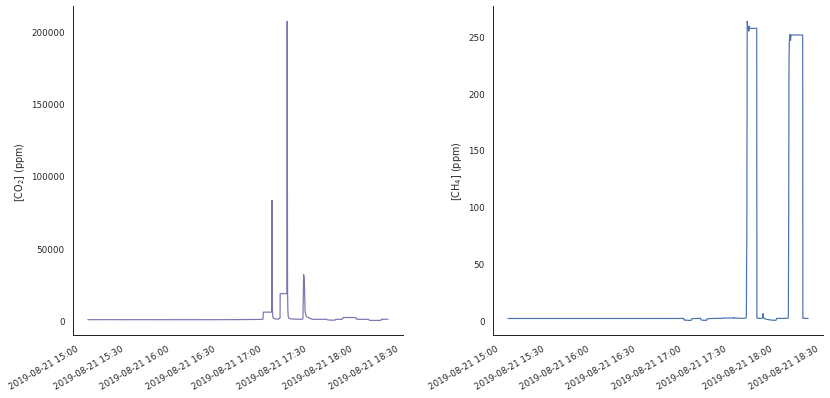

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({"font.size":22})

# co2
df_calib_raw_aug2019.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_calib_raw_aug2019.plot(y="HP_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

#### Calibration Session (Jun 2020)

The import process for this subset of data is more complex than those above because a series of `.dat` files (pulled directly from the machine as opposed to having been manually copied and pasted into a `.xlsx` file) needs to be ingested from a `.zip` folder. Once ingested, a short set of steps are required to prepare the data for analysis.

In [ ]:
# print the files in the .zip folder
with zipfile.ZipFile("pertinent-data/calibration-data/15Jun.zip", mode="r") as calib_datFile_2020:
  
  # get list of filenames and other ancillary information
  calib_datFile_2020.printdir()

File Name                                             Modified             Size
15/CFIDS2136-20200615-004041Z-DataLog_User.dat 2020-06-14 21:40:50      4630572
15/CFIDS2136-20200615-014049Z-DataLog_User.dat 2020-06-14 22:40:58      4617680
15/CFIDS2136-20200615-024057Z-DataLog_User.dat 2020-06-14 23:41:08      4609476
15/CFIDS2136-20200615-034106Z-DataLog_User.dat 2020-06-15 00:41:16      4601272
15/CFIDS2136-20200615-044115Z-DataLog_User.dat 2020-06-15 01:41:24      4614164
15/CFIDS2136-20200615-054122Z-DataLog_User.dat 2020-06-15 02:41:32      4623540
15/CFIDS2136-20200615-064130Z-DataLog_User.dat 2020-06-15 03:41:40      4598928
15/CFIDS2136-20200615-074139Z-DataLog_User.dat 2020-06-15 04:41:48      4596584
15/CFIDS2136-20200615-084146Z-DataLog_User.dat 2020-06-15 05:41:56      4638776
15/CFIDS2136-20200615-094154Z-DataLog_User.dat 2020-06-15 06:42:02      4586036
15/CFIDS2136-20200615-104200Z-DataLog_User.dat 2020-06-15 07:42:10      4635260
15/CFIDS2136-20200615-114211Z-DataLog_Us

The compressed folder contains a secondary folder (`15/`) and beneath that are 21 `.dat` files containing data from the calibration session. The instrument was running continuously during this time. Thus, list all of the filenames and extract the `.dat` files into a dataframe

In [ ]:
with zipfile.ZipFile("pertinent-data/calibration-data/15Jun.zip", mode="r") as calib_datFile_2020:
  
  # organize the filenames of .dat files into a list 
  calib_files_lst = calib_datFile_2020.namelist()

  # filter for .dat files
  calib_datFiles = fnmatch.filter(calib_files_lst, "*.dat")

  # read the .dat files into dataframes
  data = [
      pd.read_fwf(calib_datFile_2020.open(file_name)) for file_name in calib_datFiles
    ]

# concatenate files
df_calib_2020 = pd.concat(data)

# reset the index
df_calib_2020.reset_index(drop=True, inplace=True)

# convert `DATE` to a datetime type
df_calib_2020["DATE"] = pd.to_datetime(df_calib_2020.DATE)
# convert `TIME` to a datetime type
df_calib_2020["TIME"] = pd.to_datetime(df_calib_2020.TIME)
# explicitly label the time as GMT (this is how it is read in the Picarro)
df_calib_2020["TIME"] = df_calib_2020.TIME.dt.tz_localize("GMT+0", nonexistent="NaT")
# convert time label into eastern timezon (calibration took place outside of Oak Ridge)
df_calib_2020["TIME"] = df_calib_2020.TIME.dt.tz_convert("US/Eastern")
# remove the deafult date so only time remains
df_calib_2020["TIME"] = df_calib_2020.TIME.dt.time
# combine `DATE` and `TIME` into a new series
_datetime = pd.to_datetime(df_calib_2020.DATE.astype(str) + " " + df_calib_2020.TIME.astype(str))
# insert series into dataframe after TIME
df_calib_2020.insert(2, "datetime", _datetime)

df_calib_2020["datetime"] = pd.to_datetime(
    df_calib_2020.datetime, 
    format="%Y-%m-%d %H:%M:%S"
  )

df_calib_2020.set_index("datetime", drop=True, inplace=True)

# preview the data quality (i.e., non-null values and data types)
df_calib_2020.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77341 entries, 2020-06-15 20:40:33.549000 to 2020-06-15 18:19:15.970000
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  77341 non-null  datetime64[ns]
 1   TIME                  77341 non-null  object        
 2   FRAC_DAYS_SINCE_JAN1  77341 non-null  float64       
 3   FRAC_HRS_SINCE_JAN1   77341 non-null  float64       
 4   EPOCH_TIME            77341 non-null  float64       
 5   ALARM_STATUS          77341 non-null  int64         
 6   INST_STATUS           77341 non-null  int64         
 7   CavityPressure        77341 non-null  float64       
 8   CavityTemp            77341 non-null  float64       
 9   WarmBoxTemp           77341 non-null  float64       
 10  EtalonTemp            77341 non-null  float64       
 11  DasTemp               77341 non-null  float64       
 12  MPVPosition           773

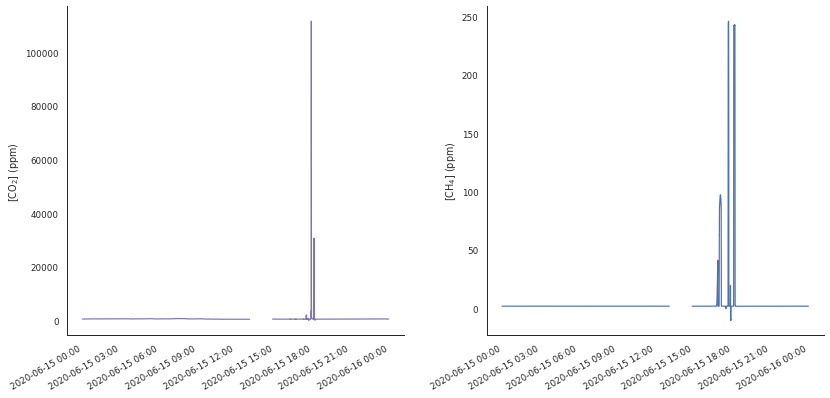

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
matplotlib.rcParams.update({"font.size":22})

# co2
df_calib_2020.plot(y="12CO2_dry", color="m", ax=ax[0])
ax[0].xaxis.set_major_formatter(_datetick_format)
ax[0].set_xlabel("")
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].get_legend().remove()

# ch4
df_calib_2020.plot(y="HR_12CH4_dry", ax=ax[1])
ax[1].xaxis.set_major_formatter(_datetick_format)
ax[1].set_xlabel("")
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].get_legend().remove()

plt.tight_layout()
plt.show()

### Analyze calibration data

#### Zero Air

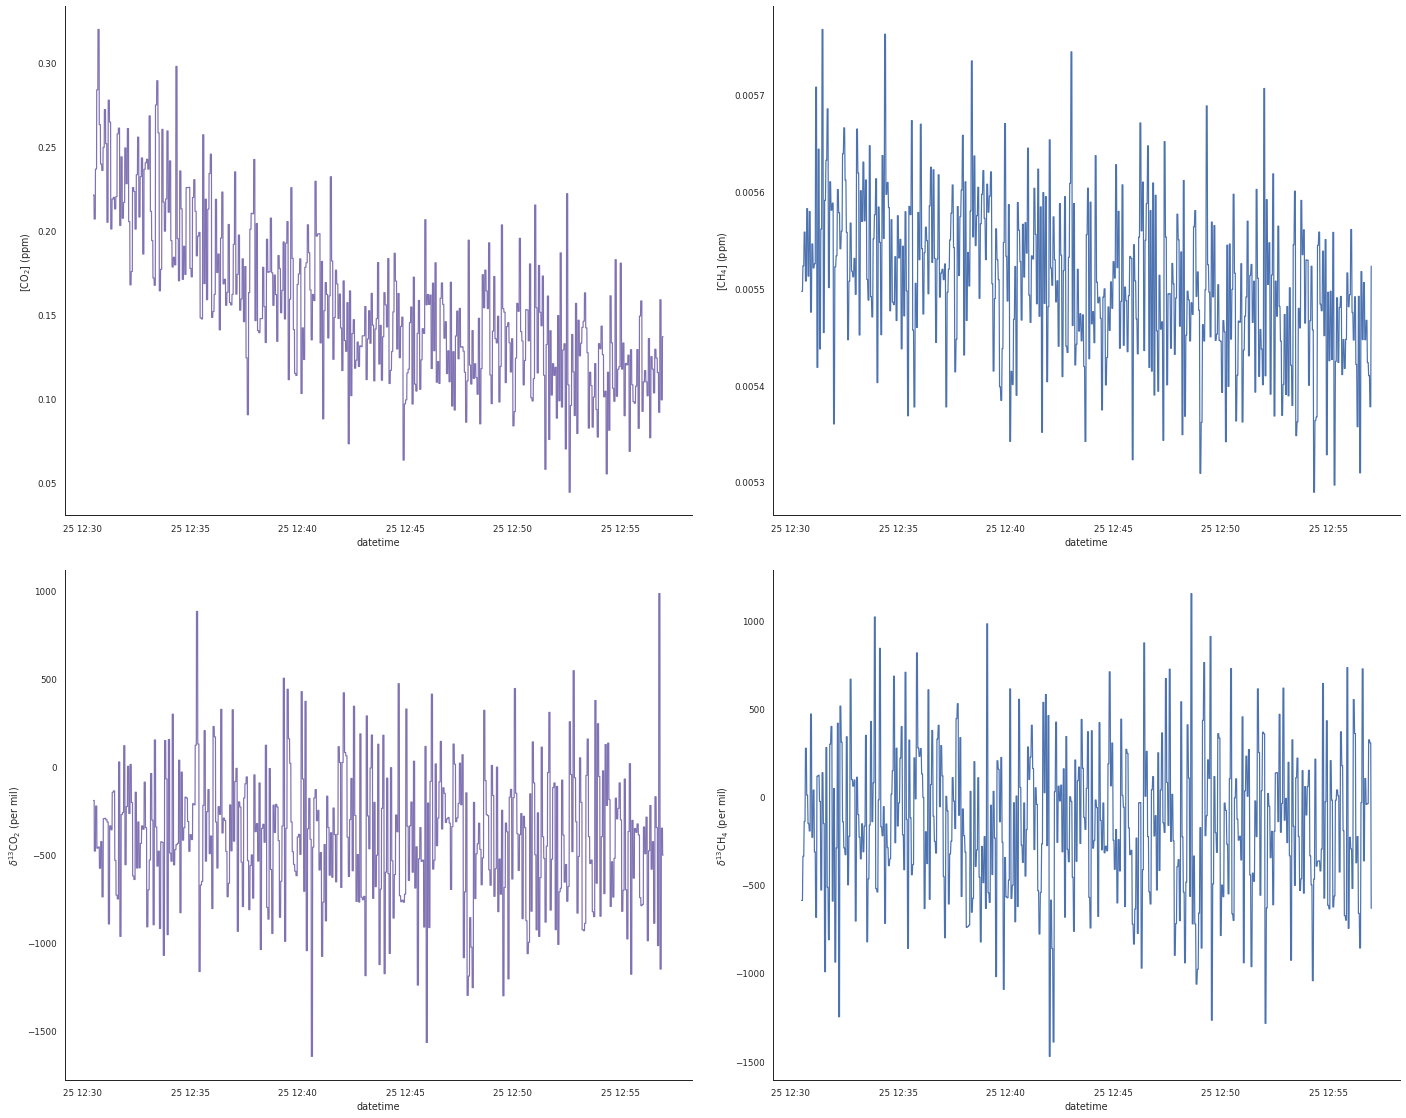

In [ ]:
# isolate the calibaration section
df_zair_calib_2015 = df_zair_2015.between_time(
    "12:30:30",
    "12:57:00"
)

fig, ax = plt.subplots(2,2, figsize=(20,16), sharey=False)
# co2
sns.lineplot(
    data=df_zair_calib_2015,
    x=df_zair_calib_2015.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0,0]
  )
ax[0,0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_zair_calib_2015,
    x=df_zair_calib_2015.index,
    y="HP_12CH4_dry", 
    color="b", 
    ax=ax[0,1]
  )
ax[0,1].set_ylabel("[CH$_{4}$] (ppm)")

# co2
sns.lineplot(
    data=df_zair_calib_2015,
    x=df_zair_calib_2015.index,
    y="Delta_Raw_iCO2", 
    color="m", 
    ax=ax[1,0]
  )
ax[1,0].set_ylabel("$\delta^{13}$CO$_{2}$ (per mil)")

# ch4
sns.lineplot(
    data=df_zair_calib_2015,
    x=df_zair_calib_2015.index,
    y="HP_Delta_iCH4_Raw", 
    ax=ax[1,1]
  )
ax[1,1].set_ylabel("$\delta^{13}$CH$_{4}$ (per mil)")

plt.tight_layout()
plt.show()

The chart above will account represents the calibration period. The descriptive stats for this period are shown below.

In [ ]:
"""get descriptive statistics for the calibration period"""
df_zair_calib_2015_descrip = df_zair_calib_2015.describe()

df_zair_calib_2015_descrip

ALARM_STATUS  HP_12CH4_dry  HP_Delta_iCH4_Raw  Delta_Raw_iCO2  \
count        1785.0   1785.000000        1785.000000     1785.000000   
mean            0.0      0.005508        -153.125988     -402.374306   
std             0.0      0.000082         432.070249      381.424868   
min             0.0      0.005289       -1471.959348    -1648.426173   
25%             0.0      0.005452        -456.192341     -663.371353   
50%             0.0      0.005507        -167.640272     -387.132346   
75%             0.0      0.005565         118.712410     -174.525516   
max             0.0      0.005768        1151.788338      983.735895   

         12CO2_dry  
count  1785.000000  
mean      0.157071  
std       0.047474  
min       0.044575  
25%       0.120998  
50%       0.151698  
75%       0.183490  
max       0.319511

The lower bound of detecttion ($3 * \sigma$, where $\sigma$ = standard deviation)

In [ ]:
# co2
print(
    "The lower level of quantification for the CRDS when measuring the concentration of CO2 is: {:.3f}\n".format(df_zair_calib_2015_descrip["12CO2_dry"].loc["std"] * 3),
    "The lower level of quantification for the CRDS when measuring the concentration of CH4 is: {:.6f}\n".format(df_zair_calib_2015_descrip["HP_12CH4_dry"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CO2 is: 0.142
 The lower level of quantification for the CRDS when measuring the concentration of CH4 is: 0.000245



#### T-Iso 3 (Aug 2015)

Plot the T-iso CH$_{4}$ calibration data (2015)

In [ ]:
# consolidate the pertinent columns
df_tiso_2015 = tiso_2015_raw[[
    "datetime",
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HR_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "HR_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

# set the index to datetime
df_tiso_2015.set_index("datetime", drop=True, inplace=True)

df_tiso_2015.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5664 entries, 2015-08-19 14:02:44.059000 to 2015-08-19 15:32:41.076000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       5664 non-null   int64  
 1   HP_12CH4_dry       5664 non-null   float64
 2   HR_12CH4_dry       5664 non-null   float64
 3   HP_Delta_iCH4_Raw  5664 non-null   float64
 4   HR_Delta_iCH4_Raw  5664 non-null   float64
 5   Delta_Raw_iCO2     5664 non-null   float64
 6   12CO2_dry          5664 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 354.0 KB


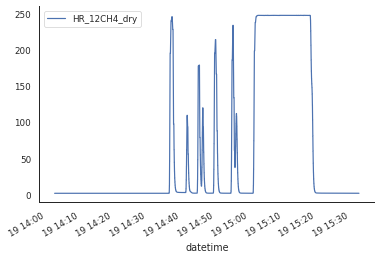

In [ ]:
df_tiso_2015.plot(y="HR_12CH4_dry")

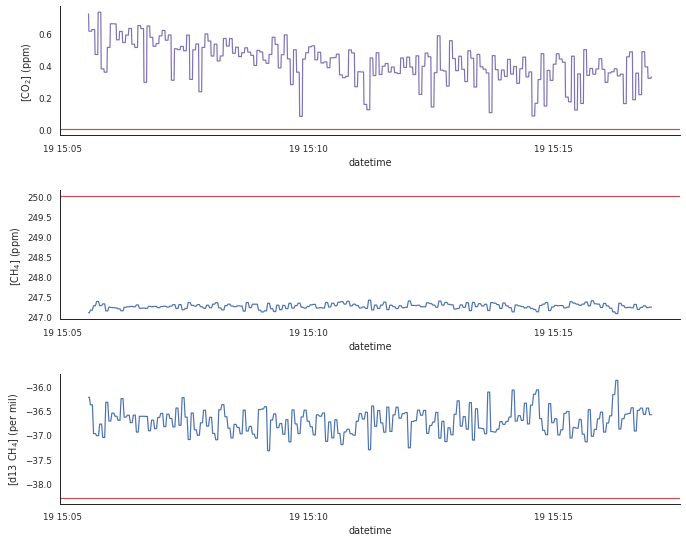

In [ ]:
# isolate the calibaration section
df_tiso_2015 = df_tiso_2015.between_time(
    "15:05:30",
    "15:17:00"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_tiso_2015,
    x=df_tiso_2015.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")
ax[0].axhline(y=0, color="r")

# ch4
sns.lineplot(
    data=df_tiso_2015,
    x=df_tiso_2015.index,
    y="HR_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].axhline(y=250, color="r")

# # ch4
sns.lineplot(
    data=df_tiso_2015,
    x=df_tiso_2015.index,
    y="HR_Delta_iCH4_Raw",
    color="b", 
    ax=ax[2]
  )
ax[2].set_ylabel("[d13 CH$_{4}$] (per mil)")
ax[2].axhline(y=-38.3, color="r")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_tiso_calib_2015_descrip = df_tiso_2015.describe()

df_tiso_calib_2015_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count         739.0         739.0    739.000000              739.0   
mean            1.0     9999999.0    247.266394          9999999.0   
std             0.0           0.0      0.064745                0.0   
min             1.0     9999999.0    247.084557          9999999.0   
25%             1.0     9999999.0    247.225139          9999999.0   
50%             1.0     9999999.0    247.269717          9999999.0   
75%             1.0     9999999.0    247.312844          9999999.0   
max             1.0     9999999.0    247.416784          9999999.0   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2   12CO2_dry  
count         739.000000      739.000000  739.000000  
mean          -36.708111      246.550234    0.420531  
std             0.255767      750.398628    0.125411  
min           -37.325278    -1807.985702    0.082354  
25%           -36.900637     -299.346777    0.350964  
50%           -36.707324      199.965162    0.437080  
75%           -36.548850      800.448497    0.499839  
max           -35.861532     2475.300552    0.735887

The lower bound of detecttion ($3 * \sigma$, where $\sigma$ = standard deviation)

In [ ]:
# ch4
print(
  "The lower level of quantification for the CRDS when measuring the concentration of CH4 is: {:.3f}\n".format(df_tiso_calib_2015_descrip["HR_12CH4_dry"].loc["std"] * 3)
)
print(
    "The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: {:.3f}\n".format(df_tiso_calib_2015_descrip["HR_Delta_iCH4_Raw"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CH4 is: 0.194

The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: 0.767



#### Calibration Session (Apr 2018)

This data was collected on 20 Apr 2018. However, it looks like the gas collected was associated with a diluted verison of the large CH4 tank because the data does not match any of the standards.

In [ ]:
# consolidate the pertinent columns
df_calib_20Apr2018 = df_calib_2018[[
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HR_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "HR_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

# set the index to datetime
# df_calib_2018.set_index("DATETIME", drop=True, inplace=True)

df_calib_20Apr2018.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27620 entries, 2018-04-20 11:50:40.076000 to 2018-04-20 18:37:59.181000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       27620 non-null  float64
 1   HP_12CH4_dry       27620 non-null  float64
 2   HR_12CH4_dry       27620 non-null  float64
 3   HP_Delta_iCH4_Raw  27620 non-null  float64
 4   HR_Delta_iCH4_Raw  27620 non-null  float64
 5   Delta_Raw_iCO2     27620 non-null  float64
 6   12CO2_dry          27620 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB


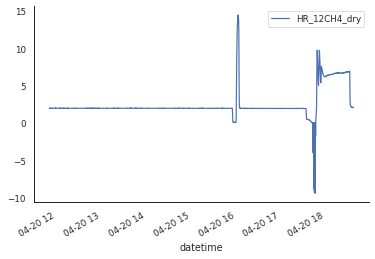

In [ ]:
df_calib_20Apr2018.plot(y="HR_12CH4_dry")

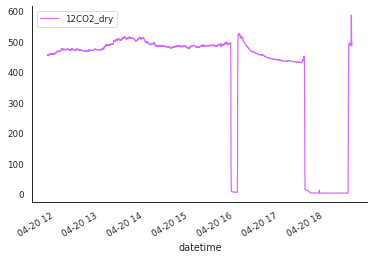

In [ ]:
df_calib_20Apr2018.plot(y="12CO2_dry", color=CO2_color1)

Unkown Gas 01

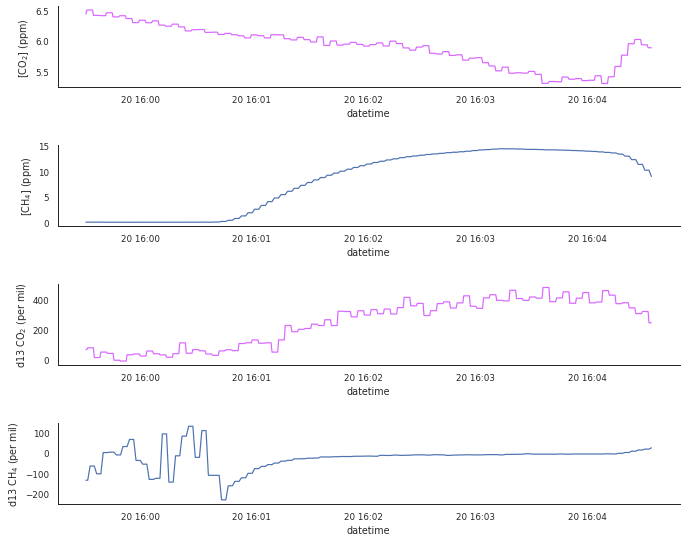

In [ ]:
# isolate the calibaration section
df_gas01 = df_calib_20Apr2018.between_time(
    "15:59:30",
    "16:04:35"
)

fig, ax = plt.subplots(4,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_gas01,
    x=df_gas01.index,
    y="12CO2_dry", 
    color=CO2_color1, 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_gas01,
    x=df_gas01.index,
    y="HR_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
# ax[1].axhline(y=10, color="r")

# d13 co2
sns.lineplot(
    data=df_gas01,
    x=df_gas01.index,
    y="Delta_Raw_iCO2",
    color=CO2_color1, 
    ax=ax[2]
  )
ax[2].set_ylabel("d13 CO$_{2}$ (per mil)")

# d13 ch4
sns.lineplot(
    data=df_gas01,
    x=df_gas01.index,
    y="HR_Delta_iCH4_Raw",
    color="b", 
    ax=ax[3]
  )
ax[3].set_ylabel("d13 CH$_{4}$ (per mil)")
# ax[2].axhline(y=-25, color="r")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_gas01_descrip = df_gas01.describe()

df_gas01_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count    344.000000    344.000000    344.000000         344.000000   
mean       0.453488      8.172906      8.281920          13.636883   
std        0.498557      5.840857      5.891602          32.585320   
min        0.000000      0.071003      0.060697         -88.808769   
25%        0.000000      0.193063      0.229997           5.046370   
50%        0.000000     10.735339     10.924412           7.755855   
75%        1.000000     13.647729     13.787268          10.039922   
max        1.000000     14.231643     14.395735         113.578297   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2   12CO2_dry  
count         344.000000      344.000000  344.000000  
mean          -23.706302      244.887715    5.909715  
std            55.261322      152.901725    0.326464  
min          -229.889911      -10.969263    5.295176  
25%           -28.514052       65.218144    5.683615  
50%            -9.970196      302.018835    5.955647  
75%            -5.167408      375.999004    6.109301  
max           131.558491      477.050376    6.515708

Unknown Gas 02

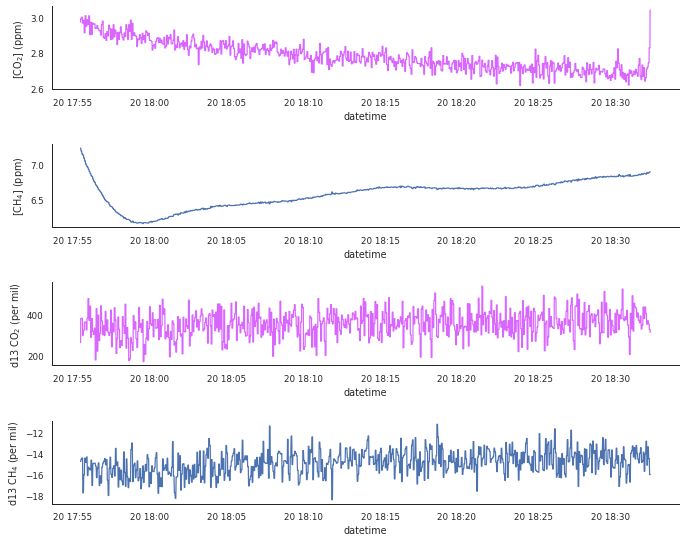

In [ ]:
# isolate the calibaration section
df_gas02 = df_calib_20Apr2018.between_time(
    "17:55:30",
    "18:32:35"
)

fig, ax = plt.subplots(4,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_gas02,
    x=df_gas02.index,
    y="12CO2_dry", 
    color=CO2_color1, 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_gas02,
    x=df_gas02.index,
    y="HR_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
# ax[1].axhline(y=10, color="r")

# d13 co2
sns.lineplot(
    data=df_gas02,
    x=df_gas02.index,
    y="Delta_Raw_iCO2",
    color=CO2_color1, 
    ax=ax[2]
  )
ax[2].set_ylabel("d13 CO$_{2}$ (per mil)")

# d13 ch4
sns.lineplot(
    data=df_gas02,
    x=df_gas02.index,
    y="HR_Delta_iCH4_Raw",
    color="b", 
    ax=ax[3]
  )
ax[3].set_ylabel("d13 CH$_{4}$ (per mil)")
# ax[2].axhline(y=-25, color="r")

plt.tight_layout()
plt.show()

#### Calibration Session (Aug 2019)

Biogenic CH4 Standard

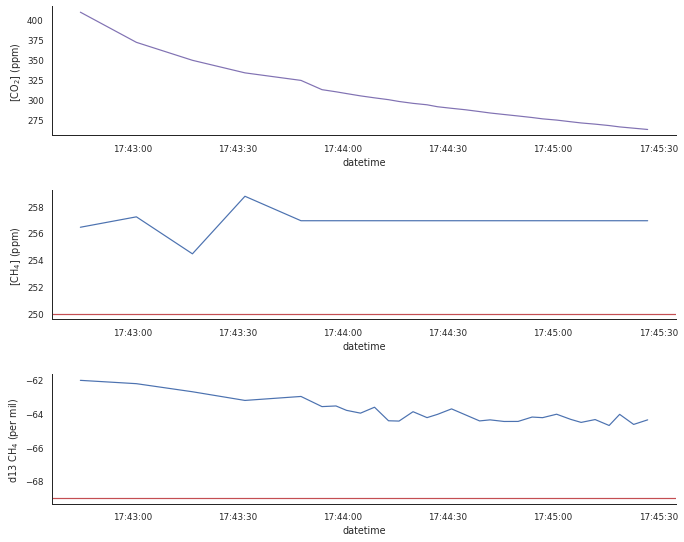

In [ ]:
# isolate the calibaration section
df_calib_bio_aug2019 = df_calib_raw_aug2019.between_time(
    "17:42:45",
    "17:45:30"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_calib_bio_aug2019,
    x=df_calib_bio_aug2019.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_calib_bio_aug2019,
    x=df_calib_bio_aug2019.index,
    y="HP_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].axhline(y=250, color="r")

# # ch4
sns.lineplot(
    data=df_calib_bio_aug2019,
    x=df_calib_bio_aug2019.index,
    y="HP_Delta_iCH4_Raw",
    color="b", 
    ax=ax[2]
  )
ax[2].set_ylabel("d13 CH$_{4}$ (per mil)")
ax[2].axhline(y=-69, color="r")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_calib_bio_aug2019_descrip = df_calib_bio_aug2019.describe()

df_calib_bio_aug2019_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count     31.000000     31.000000          31.0          31.000000   
mean       0.258065    256.889864     9999999.0         -63.928952   
std        0.444803      0.568719           0.0           0.677863   
min        0.000000    254.450800     9999999.0         -64.709229   
25%        0.000000    256.916946     9999999.0         -64.401777   
50%        0.000000    256.916946     9999999.0         -64.079985   
75%        0.500000    256.916946     9999999.0         -63.672649   
max        1.000000    258.739946     9999999.0         -62.024840   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2   12CO2_dry  
count               31.0       31.000000   31.000000  
mean           9999999.0      -29.377039  297.503363  
std                  0.0        0.727766   32.587912  
min            9999999.0      -30.893124  263.271088  
25%            9999999.0      -29.872746  275.731824  
50%            9999999.0      -29.433817  289.625466  
75%            9999999.0      -28.885432  306.539247  
max            9999999.0      -28.015604  409.302607

The lower bound of detecttion ($3 * \sigma$, where $\sigma$ = standard deviation)

In [ ]:
# ch4
print(
  "The lower level of quantification for the CRDS when measuring the concentration of CH4 is: {:.3f}\n".format(df_calib_bio_aug2019_descrip["HP_12CH4_dry"].loc["std"] * 3)
)
print(
    "The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: {:.3f}\n".format(df_calib_bio_aug2019_descrip["HP_Delta_iCH4_Raw"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CH4 is: 1.706

The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: 2.034



Thermogenic CH4 Standard

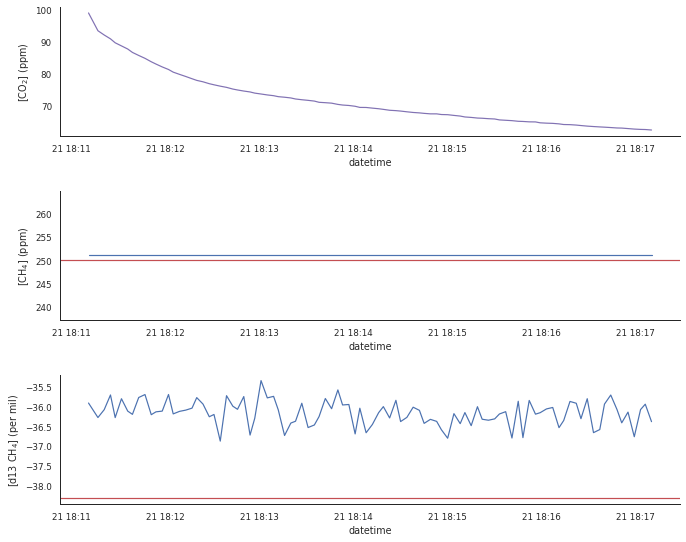

In [ ]:
# isolate the calibaration section
df_calib_therm_aug2019 = df_calib_raw_aug2019.between_time(
    "18:11:00",
    "18:17:10"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_calib_therm_aug2019,
    x=df_calib_therm_aug2019.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_calib_therm_aug2019,
    x=df_calib_therm_aug2019.index,
    y="HP_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].axhline(y=250, color="r")

# # ch4
sns.lineplot(
    data=df_calib_therm_aug2019,
    x=df_calib_therm_aug2019.index,
    y="HP_Delta_iCH4_Raw",
    color="b", 
    ax=ax[2]
  )
ax[2].set_ylabel("[d13 CH$_{4}$] (per mil)")
ax[2].axhline(y=-38.3, color="r")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_calib_therm_aug2019_descrip = df_calib_therm_aug2019.describe()

df_calib_therm_aug2019_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count     97.000000  9.700000e+01          97.0          97.000000   
mean       0.041237  2.510835e+02     9999999.0         -36.170092   
std        0.199871  5.713871e-14           0.0           0.311293   
min        0.000000  2.510835e+02     9999999.0         -36.875034   
25%        0.000000  2.510835e+02     9999999.0         -36.374150   
50%        0.000000  2.510835e+02     9999999.0         -36.144153   
75%        0.000000  2.510835e+02     9999999.0         -35.944823   
max        1.000000  2.510835e+02     9999999.0         -35.350074   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2  12CO2_dry  
count               97.0       97.000000  97.000000  
mean           9999999.0      -23.150550  71.538257  
std                  0.0        3.229258   8.254370  
min            9999999.0      -33.245207  62.274882  
25%            9999999.0      -24.750043  65.212335  
50%            9999999.0      -22.927098  69.144891  
75%            9999999.0      -21.019197  75.132236  
max            9999999.0      -16.031152  99.023055

The lower bound of detecttion ($3 * \sigma$, where $\sigma$ = standard deviation)

In [ ]:
# ch4
print(
  "The lower level of quantification for the CRDS when measuring the concentration of CH4 is: {:.3e}\n".format(df_calib_therm_aug2019_descrip["HP_12CH4_dry"].loc["std"] * 3)
)
print(
    "The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: {:.3f}\n".format(df_calib_therm_aug2019_descrip["HP_Delta_iCH4_Raw"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CH4 is: 1.714e-13

The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: 0.934



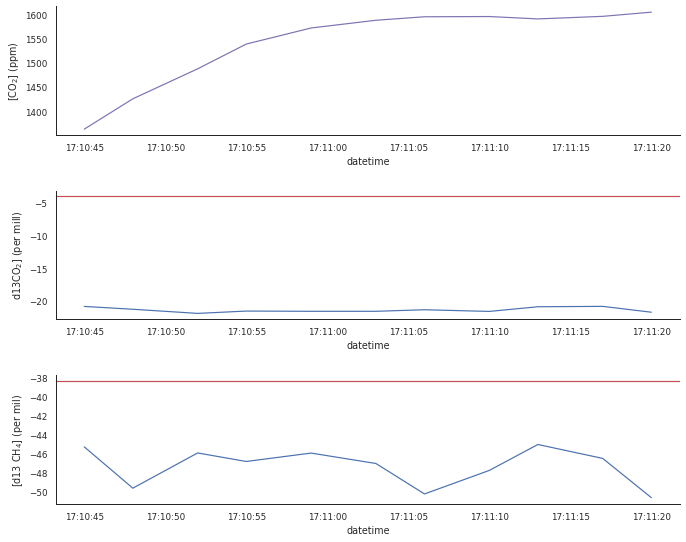

In [ ]:
# isolate the calibaration section
df_calib_aug2019_co2 = df_calib_raw_aug2019.between_time(
    "17:10:45",
    "17:11:20"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_calib_aug2019_co2,
    x=df_calib_aug2019_co2.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# d13Co2
sns.lineplot(
    data=df_calib_aug2019_co2,
    x=df_calib_aug2019_co2.index,
    y="Delta_Raw_iCO2", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("d13CO$_{2}$] (per mill)")
ax[1].axhline(y=-4, color="r")

# # ch4
sns.lineplot(
    data=df_calib_aug2019_co2,
    x=df_calib_aug2019_co2.index,
    y="HP_Delta_iCH4_Raw",
    color="b", 
    ax=ax[2]
  )
ax[2].set_ylabel("[d13 CH$_{4}$] (per mil)")
ax[2].axhline(y=-38.3, color="r")

plt.tight_layout()
plt.show()

#### Calibration Session (Jun 2020)

Get the relevant columns and set the new dataframe with the index of `DATETIME`.

In [ ]:
# consolidate the pertinent columns
df_tiso_2020 = df_calib_2020[[
    "ALARM_STATUS", 
    "HP_12CH4_dry",
    "HR_12CH4_dry",
    "HP_Delta_iCH4_Raw",
    "HR_Delta_iCH4_Raw",
    "Delta_Raw_iCO2",
    "12CO2_dry"
  ]]

# set the index to datetime
# df_tiso_2020.set_index("DATETIME", drop=True, inplace=True)

df_tiso_2020.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77341 entries, 2020-06-15 20:40:33.549000 to 2020-06-15 18:19:15.970000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ALARM_STATUS       77341 non-null  int64  
 1   HP_12CH4_dry       77341 non-null  float64
 2   HR_12CH4_dry       77340 non-null  float64
 3   HP_Delta_iCH4_Raw  77341 non-null  float64
 4   HR_Delta_iCH4_Raw  77340 non-null  float64
 5   Delta_Raw_iCO2     77340 non-null  float64
 6   12CO2_dry          77340 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 4.7 MB


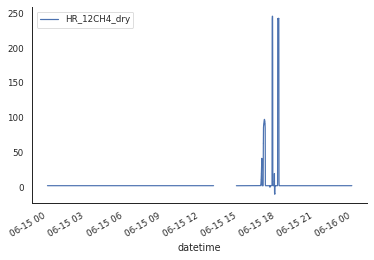

In [ ]:
df_tiso_2020.plot(y="HR_12CH4_dry")

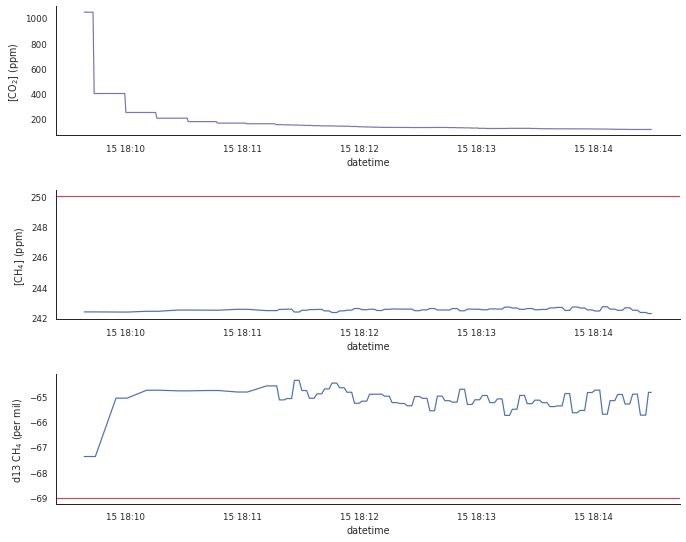

In [ ]:
# isolate the calibaration section
df_tiso_bio_jun2020 = df_tiso_2020.between_time(
    "18:09:30",
    "18:14:30"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_tiso_bio_jun2020,
    x=df_tiso_bio_jun2020.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_tiso_bio_jun2020,
    x=df_tiso_bio_jun2020.index,
    y="HR_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")
ax[1].axhline(y=250, color="r")

# # ch4
sns.lineplot(
    data=df_tiso_bio_jun2020,
    x=df_tiso_bio_jun2020.index,
    y="HR_Delta_iCH4_Raw",
    color="b", 
    ax=ax[2]
  )
ax[2].set_ylabel("d13 CH$_{4}$ (per mil)")
ax[2].axhline(y=-69, color="r")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_tiso_bio_jun2020_descrip = df_tiso_bio_jun2020.describe()

df_tiso_bio_jun2020_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count         226.0         226.0    226.000000              226.0   
mean            1.0     9999999.0    242.542804          9999999.0   
std             0.0           0.0      0.088541                0.0   
min             1.0     9999999.0    242.286802          9999999.0   
25%             1.0     9999999.0    242.495854          9999999.0   
50%             1.0     9999999.0    242.548165          9999999.0   
75%             1.0     9999999.0    242.581523          9999999.0   
max             1.0     9999999.0    242.734044          9999999.0   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2    12CO2_dry  
count         226.000000      226.000000   226.000000  
mean          -65.121988      -19.901621   144.898746  
std             0.433325        4.147668    95.094268  
min           -67.375119      -28.756015   112.117616  
25%           -65.280775      -23.201392   118.603838  
50%           -65.075636      -19.319180   127.391016  
75%           -64.847033      -17.123456   140.119325  
max           -64.365868      -10.706484  1046.537352

In [ ]:
# ch4
print(
  "The lower level of quantification for the CRDS when measuring the concentration of CH4 is: {:.3f}\n".format(df_tiso_bio_jun2020_descrip["HR_12CH4_dry"].loc["std"] * 3)
)
print(
    "The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: {:.3f}\n".format(df_tiso_bio_jun2020_descrip["HR_Delta_iCH4_Raw"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CH4 is: 0.266

The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: 1.300



Calibration Session 2020 - CO$_{2}$

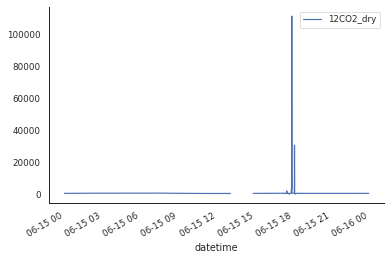

In [ ]:
df_tiso_2020.plot(y="12CO2_dry")

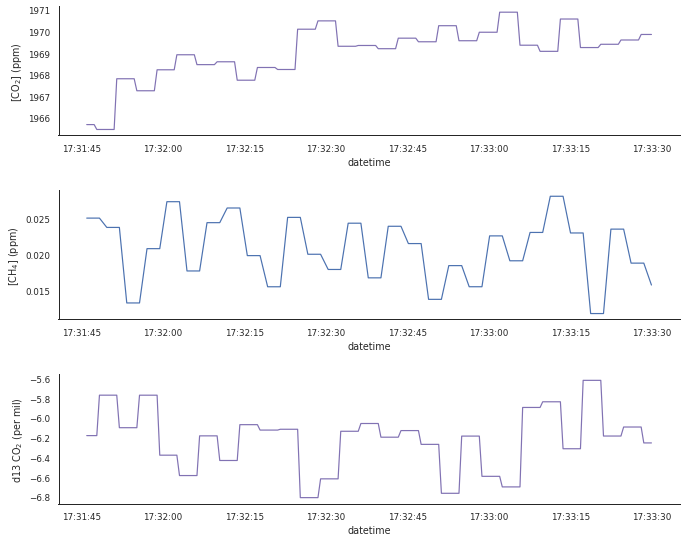

In [ ]:
# isolate the calibaration section
df_tiso_2020_co2 = df_tiso_2020.between_time(
    "17:31:45",
    "17:33:30"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_tiso_2020_co2,
    x=df_tiso_2020_co2.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_tiso_2020_co2,
    x=df_tiso_2020_co2.index,
    y="HR_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")

# # ch4
sns.lineplot(
    data=df_tiso_2020_co2,
    x=df_tiso_2020_co2.index,
    y="Delta_Raw_iCO2",
    color="m", 
    ax=ax[2]
  )
ax[2].set_ylabel("d13 CO$_{2}$ (per mil)")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_tiso_2020_co2_descrip = df_tiso_2020_co2.describe()

df_tiso_2020_co2_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count         113.0    113.000000    113.000000         113.000000   
mean            0.0      0.026823      0.020749          27.937995   
std             0.0      0.000428      0.004332         128.718888   
min             0.0      0.026440      0.011836        -231.349243   
25%             0.0      0.026628      0.017743         -63.813463   
50%             0.0      0.026695      0.020835          27.705725   
75%             0.0      0.026820      0.023938         130.624464   
max             0.0      0.028587      0.028099         286.733596   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2    12CO2_dry  
count         113.000000      113.000000   113.000000  
mean          511.979786       -6.216619  1969.032638  
std           277.372759        0.300086     1.207029  
min            53.264532       -6.805961  1965.469367  
25%           329.112266       -6.375846  1968.339860  
50%           471.185945       -6.180129  1969.322482  
75%           644.558389       -6.090591  1969.697732  
max          1139.670038       -5.617782  1970.901046

In [ ]:
# print the descriptive statsistics
print(
  "The lower level of quantification for the CRDS when measuring the concentration of CO2 is: {:.3f}\n".format(df_tiso_2020_co2_descrip["12CO2_dry"].loc["std"] * 3)
)
print(
    "The lower level of quantification for the CRDS when measuring the d13C composition of CO2 is: {:.3f}\n".format(df_tiso_2020_co2_descrip["Delta_Raw_iCO2"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CO2 is: 2.147

The lower level of quantification for the CRDS when measuring the d13C composition of CO2 is: 0.921



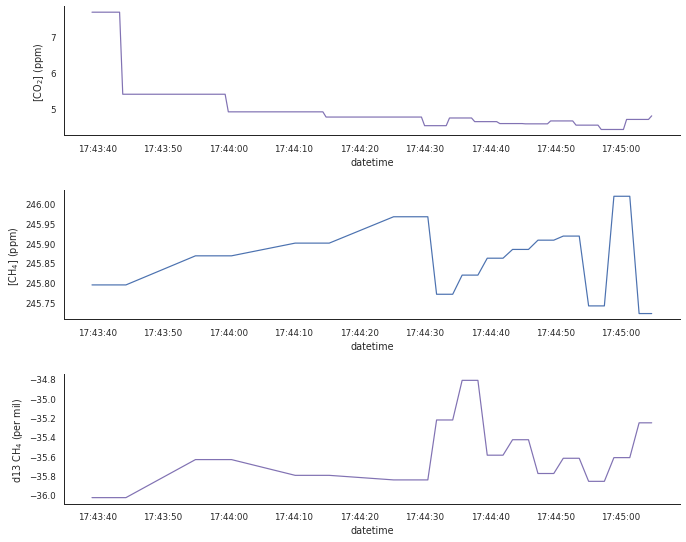

In [ ]:
# isolate the calibaration section
df_tiso_2020_ch4 = df_tiso_2020.between_time(
    "17:43:30",
    "17:45:05"
)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharey=False)
# co2
sns.lineplot(
    data=df_tiso_2020_ch4,
    x=df_tiso_2020_ch4.index,
    y="12CO2_dry", 
    color="m", 
    ax=ax[0]
  )
ax[0].set_ylabel("[CO$_{2}$] (ppm)")

# ch4
sns.lineplot(
    data=df_tiso_2020_ch4,
    x=df_tiso_2020_ch4.index,
    y="HR_12CH4_dry", 
    color="b", 
    ax=ax[1]
  )
ax[1].set_ylabel("[CH$_{4}$] (ppm)")

# ch4
sns.lineplot(
    data=df_tiso_2020_ch4,
    x=df_tiso_2020_ch4.index,
    y="HR_Delta_iCH4_Raw",
    color="m", 
    ax=ax[2]
  )
ax[2].set_ylabel("d13 CH$_{4}$ (per mil)")

plt.tight_layout()
plt.show()

In [ ]:
"""get descriptive statistics for the calibration period"""
df_tiso_2020_ch4_descrip = df_tiso_2020_ch4.describe()

df_tiso_2020_ch4_descrip

ALARM_STATUS  HP_12CH4_dry  HR_12CH4_dry  HP_Delta_iCH4_Raw  \
count          51.0          51.0     51.000000               51.0   
mean            1.0     9999999.0    245.862313          9999999.0   
std             0.0           0.0      0.083495                0.0   
min             1.0     9999999.0    245.721771          9999999.0   
25%             1.0     9999999.0    245.794394          9999999.0   
50%             1.0     9999999.0    245.868141          9999999.0   
75%             1.0     9999999.0    245.907876          9999999.0   
max             1.0     9999999.0    246.019204          9999999.0   

       HR_Delta_iCH4_Raw  Delta_Raw_iCO2  12CO2_dry  
count          51.000000       51.000000  51.000000  
mean          -35.582080       69.484377   4.826912  
std             0.316968       46.362887   0.630812  
min           -36.027756      -19.665158   4.423027  
25%           -35.797207       36.664906   4.579919  
50%           -35.620506       77.180725   4.660864  
75%           -35.428660       97.693368   4.768972  
max           -34.814379      140.944915   7.688689

In [ ]:
# print the descriptive statsistics
print(
  "The lower level of quantification for the CRDS when measuring the concentration of CH4 is: {:.3f}\n".format(df_tiso_2020_ch4_descrip["HR_12CH4_dry"].loc["std"] * 3)
)
print(
    "The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: {:.3f}\n".format(df_tiso_2020_ch4_descrip["HR_Delta_iCH4_Raw"].loc["std"] * 3)
)

The lower level of quantification for the CRDS when measuring the concentration of CH4 is: 0.250

The lower level of quantification for the CRDS when measuring the d13C composition of CH4 is: 0.951

